In [104]:
import numpy as np

from sklearn.preprocessing import LabelEncoder
from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

import pandas as pd
import lightgbm as lgbm
import optuna
from matplotlib import pyplot as plt
import plotly.graph_objects as go


from distvis import plots as dplot
import plotly.express as px

In [96]:
red = "#E07182"
blue = "#4487D3"
green = "#96D6B4"
purple = "#B140C8"
grey = "#87878A"

color_cycle = [red, blue, green, purple, grey]

In [9]:
numerical_features = [
    'edad', 'meses_empleo'
]

categorical_features = [
    'sexo', 'rol_hogar', 'tipo_zona', 
    'termino_nivel', 'cine', 'est_conyugal', 'region', 'comuna', 'provincia',
    'est_subcontratado', 'categoria_empleo', 'grupo_ocupacion', 'nacionalidad'
]

features = categorical_features + numerical_features
target = "sueldo_neto"

In [10]:
import chart_studio.plotly as py
import chart_studio


username='miloiturra'
api_key='CrY0Z3dZVv539AVcBAcW'

chart_studio.tools.set_credentials_file(username=username,
                                        api_key=api_key)

In [11]:
datos = pd.read_csv('../datos/datos_procesados.csv').iloc[:, 1:]

test_index = datos.sample(frac=.1, random_state=1312).index
datos['is_test'] = 0 
datos.loc[test_index, 'is_test'] = 1

mean = np.log(datos.query('is_test == 0')[target]).mean()
std = np.log(datos.query('is_test == 0')[target]).std()

def transform(x):
    return (np.log(x) - mean)/std

def inv_transf(x):
    return np.exp(std*x + mean)

datos[target+'_transf'] = transform(datos[target])
datos[target+'_transf'].min(), datos[target+'_transf'].max()

df_train = datos.query('is_test == 0')
df_test = datos.query('is_test == 1')

df_test.loc[:, categorical_features] = df_test.loc[:, categorical_features].astype('category')
df_train.loc[:, categorical_features] = df_train.loc[:, categorical_features].astype('category')

In [12]:
def get_categ_index_mapping(df_train, categ_feature):
    base_mapping = dict(zip(df_train[categ_feature], df_train[categ_feature].cat.codes + 1))
    return {**{"N/A": 0}, **base_mapping}

def get_categs_mappings(df_train, categs):
    mappings_list = []
    for i, c in enumerate(categs):
        map_dict = get_categ_index_mapping(df_train, c)
        mappings_list.append({'col': i, 'mapping': map_dict})
    return mappings_list

In [13]:
categs_mappings = get_categs_mappings(df_train, categorical_features)

In [14]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='median', fill_value=np.NaN)), 
    ])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value="N/A")),
    ('label', OrdinalEncoder(handle_unknown="value", mapping=categs_mappings)), #uknown values goes to -1
    ('imputer_uknow', SimpleImputer(missing_values=-1, strategy='constant', fill_value=0)), #uknown values go to 0, the index for NaN
    ])

preprocessor = ColumnTransformer(               #preprocessor rearenge columns
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numerical_features)]
)


In [15]:
def diferencia_porcentual(df, feature):
    desprotegidos = dict_particion[feature]['desprotegido']
    privilegiados = dict_particion[feature]['privilegiado']
    combinaciones = [list(par) for par in product(desprotegidos, privilegiados)]
    sueldos = df.set_index(feature)[['sueldo_predicho']]
    valores = np.array([sueldos.loc[comb, 'sueldo_predicho'].values for comb in combinaciones])
    
    return ((valores[:, 1] - valores[:, 0])/valores[:, 0]).mean() #sueldos[combinaciones[0]]


# Optimización multiobjetivo con optuna 
(MAPE y Fairness)

In [30]:
def calc_dif_porcentual_max(df):
    sueldo_max = df['sueldo_predicho'].max()
    sueldo_min = df['sueldo_predicho'].min()
    
    return (sueldo_max - sueldo_min)/sueldo_min


def calc_dpc_persona(datos_test, feature, pipeline, sample_frac=1, merge=False):
    valores = datos_test[feature].unique()
    otros_features = [f for f in features if f != feature]
    datos_contraf = (
        datos_test[otros_features]
        .sample(frac=sample_frac, random_state=1312)
        .copy()
    )
    datos_contraf['id_persona'] = datos_contraf.index
    datos_contraf['dummy'] = 1
    valores_df = pd.DataFrame({feature: valores, 'dummy': 1})
    datos_contraf = pd.merge(datos_contraf, valores_df, on='dummy')
    datos_contraf['sueldo_predicho'] = inv_transf(pipeline.predict(datos_contraf[features]))
    dif_pct_persona = datos_contraf.groupby('id_persona').apply(calc_dif_porcentual_max)
    del datos_contraf
    if merge:
        datos_test = pd.merge(datos_test, dif_pct_persona.to_frame(f'dpc_{feature}'), 
                         left_index=True, right_index=True,
                         how='left')
    return datos_test, dif_pct_persona

def calc_dpc(datos_test, feature, pipeline, sample_frac=1, merge=False):
    _, dif_pct_persona = calc_dpc_persona(datos_test, feature, pipeline, sample_frac=sample_frac, merge=merge)
    return dif_pct_persona.mean()

def calc_dpm(datos_test, feature):
    sueldo_pred_mediano = datos_test.groupby(feature).sueldo_predicho.median()
    sueldo_max = sueldo_pred_mediano.max()
    sueldo_min = sueldo_pred_mediano.min()
    
    return (sueldo_max - sueldo_min)/sueldo_min

In [31]:
#se entrena el modelo y se retorna Mape y métrica de fairness 
def multi_obj(model_params):
    regressor = lgbm.LGBMRegressor(**model_params)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', regressor)])
    pipeline.fit(X=df_train[features], 
                 y=df_train[target+'_transf'],
                 classifier__categorical_feature=[i for i in range(len(categorical_features))],
                 classifier__feature_name=features,
    )
    
    df_test['sueldo_predicho'] = inv_transf(pipeline.predict(df_test[features]))
    
    mape = df_test.eval(f"abs(sueldo_predicho - {target})/{target}").mean()
    
    #metrica de fairness
    feature = "sexo"
    dpc = calc_dpc(df_test, feature, pipeline, sample_frac=1, merge=False)
    dpm = calc_dpm(df_test, feature)
    return mape, dpc, dpm

In [65]:
def objective(trial):
    
    sexo_feature_contri = trial.suggest_uniform('sexo_feature_contri', 1e-8, 1.1)
    feature_contri = np.ones(len(features))
    feature_contri[features.index('sexo')] = sexo_feature_contri
    
    model_params = {
        "objective": "regression",
        "metric": ["mape", "mae"],
        "verbosity": -1,
        "boosting_type": "gbdt",  
        "max_depth": -1,
        "min_data_in_leaf": 20,
        "learning_rate": trial.suggest_loguniform('learning_rate', 1e-4, 0.2), 
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'seed': 1312,
        'feature_contri': feature_contri,
        "deterministic": True,

    }

    
    return multi_obj(model_params)

In [66]:
default_params = {
    'learning_rate': 0.01,
    'lambda_l1': 1e-8,
    'lambda_l2': 1e-8,
    'num_leaves': 31,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.9,
    'bagging_freq': 0,
    'min_child_samples': 20,
    'sexo_feature_contri': 1
}

In [ ]:
%%time
study = optuna.create_study(directions=['minimize', 'minimize', 'minimize'])
study.enqueue_trial(default_params)
study.optimize(objective, n_trials=5000)

[I 2021-08-10 17:37:16,123] A new study created in memory with name: no-name-1caed10f-d503-4439-8600-de6b06dbd3c8
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: ExperimentalWarning: enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
  
/opt/conda/lib/python3.7/site-packages/optuna/study.py:783: ExperimentalWarning: create_trial is experimental (supported from v2.0.0). The interface can change in the future.
  create_trial(state=TrialState.WAITING, system_attrs={"fixed_params": params})
/opt/conda/lib/python3.7/site-packages/optuna/study.py:783: ExperimentalWarning: add_trial is experimental (supported from v2.0.0). The interface can change in the future.
  create_trial(state=TrialState.WAITING, system_attrs={"fixed_params": params})
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1e-08
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1e-08
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:37:18,660] Trial 0 finished with values: [0.48292520457294913, 0.10175051687813054, 0.10365971081260222] and parameters: {'sexo_feature_contri': 1, 'learning_rate': 0.01, 'lambda_l1': 1e-08, 'lambda_l2': 1e-08, 'num_leaves': 31, 'feature_fraction': 0.7, 'bagging_fraction': 0.9, 'bagging_freq': 0, 'min_child_samples': 20}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=5.715091803146076e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.715091803146076e-07
[LightGBM] [Warning] bagging_fraction is set=0.3652184511167701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3652184511167701
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.875321988871739e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.875321988871739e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.43168540606780903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43168540606780903


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:37:22,031] Trial 1 finished with values: [0.44761865331068734, 0.2655254068899903, 0.2296293433911159] and parameters: {'sexo_feature_contri': 0.8881275622695561, 'learning_rate': 0.13919197073031375, 'lambda_l1': 5.715091803146076e-07, 'lambda_l2': 3.875321988871739e-05, 'num_leaves': 426, 'feature_fraction': 0.43168540606780903, 'bagging_fraction': 0.3652184511167701, 'bagging_freq': 5, 'min_child_samples': 49}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.06511594718334497, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06511594718334497
[LightGBM] [Warning] bagging_fraction is set=0.636267672092942, subsample=1.0 will be ignored. Current value: bagging_fraction=0.636267672092942
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=82 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.149081126709498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.149081126709498
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5383580782284648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5383580782284648


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:37:25,527] Trial 2 finished with values: [0.6832723217053538, 0.0012451625358195152, 0.0009008372402247083] and parameters: {'sexo_feature_contri': 0.6475955680107953, 'learning_rate': 0.00010885064848628906, 'lambda_l1': 0.06511594718334497, 'lambda_l2': 2.149081126709498, 'num_leaves': 249, 'feature_fraction': 0.5383580782284648, 'bagging_fraction': 0.636267672092942, 'bagging_freq': 10, 'min_child_samples': 82}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.07721292203849352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07721292203849352
[LightGBM] [Warning] bagging_fraction is set=0.12895553928892498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12895553928892498
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.995817988382582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.995817988382582
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.18686050031722265, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18686050031722265


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:37:28,019] Trial 3 finished with values: [0.6823469421627574, 0.0011762677278793427, 0.0008019626010502889] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.0002528493378084442, 'lambda_l1': 0.07721292203849352, 'lambda_l2': 6.995817988382582, 'num_leaves': 281, 'feature_fraction': 0.18686050031722265, 'bagging_fraction': 0.12895553928892498, 'bagging_freq': 10, 'min_child_samples': 36}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0383754312750003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0383754312750003
[LightGBM] [Warning] bagging_fraction is set=0.467452968119349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.467452968119349
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.19520314129504315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19520314129504315
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7920334638544461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7920334638544461


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:37:31,773] Trial 4 finished with values: [0.43005557911374237, 0.2802546137599583, 0.20381672246488022] and parameters: {'sexo_feature_contri': 1.0648180310906175, 'learning_rate': 0.0720306310864682, 'lambda_l1': 0.0383754312750003, 'lambda_l2': 0.19520314129504315, 'num_leaves': 396, 'feature_fraction': 0.7920334638544461, 'bagging_fraction': 0.467452968119349, 'bagging_freq': 5, 'min_child_samples': 49}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.568480490839536e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.568480490839536e-06
[LightGBM] [Warning] bagging_fraction is set=0.20533917767290344, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20533917767290344
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.414842307874773, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.414842307874773
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.40401564898680564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40401564898680564


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:37:34,583] Trial 5 finished with values: [0.504279432168606, 0.07974011176911863, 0.05724503195979416] and parameters: {'sexo_feature_contri': 0.6461706862158207, 'learning_rate': 0.00958118583013065, 'lambda_l1': 6.568480490839536e-06, 'lambda_l2': 8.414842307874773, 'num_leaves': 122, 'feature_fraction': 0.40401564898680564, 'bagging_fraction': 0.20533917767290344, 'bagging_freq': 0, 'min_child_samples': 97}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.05747529472844889, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05747529472844889
[LightGBM] [Warning] bagging_fraction is set=0.23213147414603635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23213147414603635
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=78 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.9928451788150279, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9928451788150279
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.3095987610870444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3095987610870444


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:37:37,374] Trial 6 finished with values: [0.5138490522830859, 0.07556381484520841, 0.06356983413244258] and parameters: {'sexo_feature_contri': 0.15871591921151776, 'learning_rate': 0.010234784328749712, 'lambda_l1': 0.05747529472844889, 'lambda_l2': 0.9928451788150279, 'num_leaves': 434, 'feature_fraction': 0.3095987610870444, 'bagging_fraction': 0.23213147414603635, 'bagging_freq': 15, 'min_child_samples': 78}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00010419431929019236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010419431929019236
[LightGBM] [Warning] bagging_fraction is set=0.6896946541402059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6896946541402059
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.2489723550028291e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2489723550028291e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6753085535310064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6753085535310064


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:37:40,733] Trial 7 finished with values: [0.6716817632854188, 0.005394348755889187, 0.0041349694479681145] and parameters: {'sexo_feature_contri': 0.6560795031811165, 'learning_rate': 0.0003721921319048116, 'lambda_l1': 0.00010419431929019236, 'lambda_l2': 1.2489723550028291e-05, 'num_leaves': 178, 'feature_fraction': 0.6753085535310064, 'bagging_fraction': 0.6896946541402059, 'bagging_freq': 4, 'min_child_samples': 18}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.569399441003472e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.569399441003472e-07
[LightGBM] [Warning] bagging_fraction is set=0.34985161864788267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.34985161864788267
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.06713339675503494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06713339675503494
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8278854460302175, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8278854460302175


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:37:43,654] Trial 8 finished with values: [0.49214846405059925, 0.07078213010750543, 0.06954324440264044] and parameters: {'sexo_feature_contri': 0.4530522736257254, 'learning_rate': 0.00784785604725898, 'lambda_l1': 1.569399441003472e-07, 'lambda_l2': 0.06713339675503494, 'num_leaves': 101, 'feature_fraction': 0.8278854460302175, 'bagging_fraction': 0.34985161864788267, 'bagging_freq': 7, 'min_child_samples': 22}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.3813167761834816e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3813167761834816e-08
[LightGBM] [Warning] bagging_fraction is set=0.5234065277085634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5234065277085634
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=57 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.5922200323997568, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5922200323997568
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2775349673761943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2775349673761943


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:37:46,887] Trial 9 finished with values: [0.6835614785354988, 0.0012761209288663924, 0.00041806614184640873] and parameters: {'sexo_feature_contri': 0.3324054431192825, 'learning_rate': 0.0001727727317377506, 'lambda_l1': 1.3813167761834816e-08, 'lambda_l2': 0.5922200323997568, 'num_leaves': 384, 'feature_fraction': 0.2775349673761943, 'bagging_fraction': 0.5234065277085634, 'bagging_freq': 5, 'min_child_samples': 57}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.1729615164925227e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1729615164925227e-05
[LightGBM] [Warning] bagging_fraction is set=0.864201434321013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.864201434321013
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=62 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.053432628773513e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.053432628773513e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.3121539664326637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3121539664326637


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:37:50,472] Trial 10 finished with values: [0.6793785456052573, 0.0027248360079134178, 0.0018688667044739998] and parameters: {'sexo_feature_contri': 0.2626347004091758, 'learning_rate': 0.00027807424356701574, 'lambda_l1': 2.1729615164925227e-05, 'lambda_l2': 3.053432628773513e-08, 'num_leaves': 313, 'feature_fraction': 0.3121539664326637, 'bagging_fraction': 0.864201434321013, 'bagging_freq': 8, 'min_child_samples': 62}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.004824681633516082, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004824681633516082
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9744873655330746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744873655330746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:37:53,717] Trial 11 finished with values: [0.4272607903048664, 0.19405268594398045, 0.1662377225205972] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.07365241146422205, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 0.004824681633516082, 'num_leaves': 153, 'feature_fraction': 0.9744873655330746, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 0, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.025564454322384314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.025564454322384314
[LightGBM] [Warning] bagging_fraction is set=0.24743600907381397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24743600907381397
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0003678373721336241, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003678373721336241
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5616033150070671, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5616033150070671


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:37:57,316] Trial 12 finished with values: [0.42761971249302466, 0.1688905268127422, 0.1605967169154263] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.029103683632629822, 'lambda_l1': 0.025564454322384314, 'lambda_l2': 0.0003678373721336241, 'num_leaves': 490, 'feature_fraction': 0.5616033150070671, 'bagging_fraction': 0.24743600907381397, 'bagging_freq': 4, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00805146262450049, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00805146262450049
[LightGBM] [Warning] bagging_fraction is set=0.19748513166364856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.19748513166364856
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=61 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.109369376430232e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.109369376430232e-06
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] feature_fraction is set=0.5310206295998793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5310206295998793


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:38:00,436] Trial 13 finished with values: [0.6743049315486693, 0.004217214020834502, 0.0033122386958322103] and parameters: {'sexo_feature_contri': 1.081603442830305, 'learning_rate': 0.0003593193895218537, 'lambda_l1': 0.00805146262450049, 'lambda_l2': 3.109369376430232e-06, 'num_leaves': 408, 'feature_fraction': 0.5310206295998793, 'bagging_fraction': 0.19748513166364856, 'bagging_freq': 14, 'min_child_samples': 61}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.089917203005346e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.089917203005346e-05
[LightGBM] [Warning] bagging_fraction is set=0.4689674197976734, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4689674197976734
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0025525142236152965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0025525142236152965
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.7026476170975636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7026476170975636


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:38:03,324] Trial 14 finished with values: [0.42520628169548097, 0.2527854479963852, 0.19983009301040497] and parameters: {'sexo_feature_contri': 0.9800383576236829, 'learning_rate': 0.055920227356648186, 'lambda_l1': 6.089917203005346e-05, 'lambda_l2': 0.0025525142236152965, 'num_leaves': 84, 'feature_fraction': 0.7026476170975636, 'bagging_fraction': 0.4689674197976734, 'bagging_freq': 10, 'min_child_samples': 17}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.8513436873198773e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8513436873198773e-06
[LightGBM] [Warning] bagging_fraction is set=0.6223728777576902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6223728777576902
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7326452125983359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7326452125983359


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:38:06,278] Trial 15 finished with values: [0.42561317116869385, 0.25229712410151484, 0.2163526803304447] and parameters: {'sexo_feature_contri': 0.7113693145244616, 'learning_rate': 0.07056715346154353, 'lambda_l1': 1.8513436873198773e-06, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 104, 'feature_fraction': 0.7326452125983359, 'bagging_fraction': 0.6223728777576902, 'bagging_freq': 7, 'min_child_samples': 75}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.736516936830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736516936830935e-07
[LightGBM] [Warning] bagging_fraction is set=0.859465716244613, subsample=1.0 will be ignored. Current value: bagging_fraction=0.859465716244613
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.95170061292304e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.95170061292304e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:38:09,064] Trial 16 finished with values: [0.4338013633147707, 0.14606432834129046, 0.14061130987359316] and parameters: {'sexo_feature_contri': 0.6036605509689659, 'learning_rate': 0.02174599180638746, 'lambda_l1': 2.736516936830935e-07, 'lambda_l2': 8.95170061292304e-06, 'num_leaves': 46, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.859465716244613, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.865044080843562e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.865044080843562e-06
[LightGBM] [Warning] bagging_fraction is set=0.6385153082916132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6385153082916132
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=66 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.459156551120922e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.459156551120922e-06
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.1243338159121273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1243338159121273


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:38:11,712] Trial 17 finished with values: [0.44968900584978583, 0.29537912742815764, 0.22598596642889213] and parameters: {'sexo_feature_contri': 0.9638864325343482, 'learning_rate': 0.18236819249478806, 'lambda_l1': 4.865044080843562e-06, 'lambda_l2': 9.459156551120922e-06, 'num_leaves': 384, 'feature_fraction': 0.1243338159121273, 'bagging_fraction': 0.6385153082916132, 'bagging_freq': 10, 'min_child_samples': 66}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.9517276372711685e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9517276372711685e-05
[LightGBM] [Warning] bagging_fraction is set=0.6918324153172396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6918324153172396
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.0126382633617e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.0126382633617e-07
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] feature_fraction is set=0.20287081402355922, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20287081402355922


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:38:14,144] Trial 18 finished with values: [0.6680652836273058, 0.003945079388832426, 0.00210028198939097] and parameters: {'sexo_feature_contri': 0.35939509989870794, 'learning_rate': 0.000944029781258023, 'lambda_l1': 2.9517276372711685e-05, 'lambda_l2': 9.0126382633617e-07, 'num_leaves': 14, 'feature_fraction': 0.20287081402355922, 'bagging_fraction': 0.6918324153172396, 'bagging_freq': 14, 'min_child_samples': 67}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.003159075966674932, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003159075966674932
[LightGBM] [Warning] bagging_fraction is set=0.47644018937117716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47644018937117716
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018336356325432693, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018336356325432693
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5649429838790455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5649429838790455


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:38:17,721] Trial 19 finished with values: [0.683127865705568, 0.001329413069757782, 0.0009958202115198684] and parameters: {'sexo_feature_contri': 0.9943374960978849, 'learning_rate': 0.00011084955551541678, 'lambda_l1': 0.003159075966674932, 'lambda_l2': 0.018336356325432693, 'num_leaves': 363, 'feature_fraction': 0.5649429838790455, 'bagging_fraction': 0.47644018937117716, 'bagging_freq': 4, 'min_child_samples': 12}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.427897984856548e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.427897984856548e-06
[LightGBM] [Warning] bagging_fraction is set=0.8613825978797284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8613825978797284
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=69 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.009825019319256341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009825019319256341
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9521048269286838, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9521048269286838


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:38:20,607] Trial 20 finished with values: [0.6174316682014751, 0.00463433501730177, 0.012427666859235048] and parameters: {'sexo_feature_contri': 0.22743782774065008, 'learning_rate': 0.0017344184664395501, 'lambda_l1': 4.427897984856548e-06, 'lambda_l2': 0.009825019319256341, 'num_leaves': 93, 'feature_fraction': 0.9521048269286838, 'bagging_fraction': 0.8613825978797284, 'bagging_freq': 2, 'min_child_samples': 69}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.004723070972237909, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004723070972237909
[LightGBM] [Warning] bagging_fraction is set=0.4682123490785217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4682123490785217
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=1 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.0570467398357238e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0570467398357238e-05
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.8868573359917634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8868573359917634


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:38:23,457] Trial 21 finished with values: [0.6657492805738519, 0.000911393954522175, 0.0027844014731365943] and parameters: {'sexo_feature_contri': 0.14041637637977097, 'learning_rate': 0.0004975178610134454, 'lambda_l1': 0.004723070972237909, 'lambda_l2': 1.0570467398357238e-05, 'num_leaves': 107, 'feature_fraction': 0.8868573359917634, 'bagging_fraction': 0.4682123490785217, 'bagging_freq': 12, 'min_child_samples': 1}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.1170088795125794e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1170088795125794e-05
[LightGBM] [Warning] bagging_fraction is set=0.5261755836840186, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5261755836840186
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=57 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.134366403952671, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.134366403952671
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.24427759150799055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24427759150799055


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:38:26,309] Trial 22 finished with values: [0.44057716153848575, 0.23864415773429107, 0.14869470135668872] and parameters: {'sexo_feature_contri': 0.1397110292316727, 'learning_rate': 0.07048396614110133, 'lambda_l1': 4.1170088795125794e-05, 'lambda_l2': 5.134366403952671, 'num_leaves': 477, 'feature_fraction': 0.24427759150799055, 'bagging_fraction': 0.5261755836840186, 'bagging_freq': 13, 'min_child_samples': 57}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.6906133968584499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6906133968584499
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.020332076872656e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.020332076872656e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.17203743652603923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17203743652603923


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:38:29,200] Trial 23 finished with values: [0.6835596097940966, 0.0009290574148086755, 0.0005393684599822468] and parameters: {'sexo_feature_contri': 0.3296933113488557, 'learning_rate': 0.00017680684991195714, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 8.020332076872656e-06, 'num_leaves': 507, 'feature_fraction': 0.17203743652603923, 'bagging_fraction': 0.6906133968584499, 'bagging_freq': 2, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.011900043160490004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011900043160490004
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.25174309228823255, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25174309228823255


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:38:31,736] Trial 24 finished with values: [0.44797421259843623, 0.1854232432917251, 0.1022923523007278] and parameters: {'sexo_feature_contri': 0.16462404803502537, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.011900043160490004, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.25174309228823255, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 1, 'min_child_samples': 37}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.3110762768158505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3110762768158505
[LightGBM] [Warning] bagging_fraction is set=0.4549069133830357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4549069133830357
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=7.115001453446033e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.115001453446033e-07
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.3462447709631431, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3462447709631431


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:38:35,221] Trial 25 finished with values: [0.4279148709877833, 0.23555647805354446, 0.18703950781691692] and parameters: {'sexo_feature_contri': 0.7989843048362161, 'learning_rate': 0.04899864585050011, 'lambda_l1': 0.3110762768158505, 'lambda_l2': 7.115001453446033e-07, 'num_leaves': 497, 'feature_fraction': 0.3462447709631431, 'bagging_fraction': 0.4549069133830357, 'bagging_freq': 0, 'min_child_samples': 49}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.166863528926706e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.166863528926706e-08
[LightGBM] [Warning] bagging_fraction is set=0.7889565821003344, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7889565821003344
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.951876778552482e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.951876778552482e-06
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.6913502346745504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6913502346745504


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:38:38,986] Trial 26 finished with values: [0.4279777134077065, 0.1838111801123014, 0.1484059608313481] and parameters: {'sexo_feature_contri': 0.6148509033260064, 'learning_rate': 0.021700375350983302, 'lambda_l1': 1.166863528926706e-08, 'lambda_l2': 5.951876778552482e-06, 'num_leaves': 337, 'feature_fraction': 0.6913502346745504, 'bagging_fraction': 0.7889565821003344, 'bagging_freq': 15, 'min_child_samples': 90}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.6985713205062354e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6985713205062354e-05
[LightGBM] [Warning] bagging_fraction is set=0.7387467887399026, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7387467887399026
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.001089343774899103, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001089343774899103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.38005744554747434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38005744554747434


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:38:41,464] Trial 27 finished with values: [0.43394409079709706, 0.1677201601938187, 0.1420802020004663] and parameters: {'sexo_feature_contri': 0.9236444123100728, 'learning_rate': 0.03074399473126098, 'lambda_l1': 2.6985713205062354e-05, 'lambda_l2': 0.001089343774899103, 'num_leaves': 19, 'feature_fraction': 0.38005744554747434, 'bagging_fraction': 0.7387467887399026, 'bagging_freq': 1, 'min_child_samples': 16}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.6966746291442834e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6966746291442834e-05
[LightGBM] [Warning] bagging_fraction is set=0.7837498350101808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7837498350101808
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.35972152447215394, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35972152447215394
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.40895915050158904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40895915050158904


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:38:43,984] Trial 28 finished with values: [0.44219123581481035, 0.10394453855852324, 0.10169163786797655] and parameters: {'sexo_feature_contri': 0.35990341643779833, 'learning_rate': 0.02525915495254142, 'lambda_l1': 2.6966746291442834e-05, 'lambda_l2': 0.35972152447215394, 'num_leaves': 21, 'feature_fraction': 0.40895915050158904, 'bagging_fraction': 0.7837498350101808, 'bagging_freq': 5, 'min_child_samples': 12}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=3.344605728485707e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.344605728485707e-07
[LightGBM] [Warning] bagging_fraction is set=0.8136573285524973, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8136573285524973
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.2188264236156745e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2188264236156745e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6236492953766819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6236492953766819


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:38:48,219] Trial 29 finished with values: [0.42259415136904677, 0.21496523850235227, 0.17295760393011608] and parameters: {'sexo_feature_contri': 0.5480974394653548, 'learning_rate': 0.03497493448348646, 'lambda_l1': 3.344605728485707e-07, 'lambda_l2': 5.2188264236156745e-08, 'num_leaves': 464, 'feature_fraction': 0.6236492953766819, 'bagging_fraction': 0.8136573285524973, 'bagging_freq': 7, 'min_child_samples': 98}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.2710194615060697e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2710194615060697e-06
[LightGBM] [Warning] bagging_fraction is set=0.8211863000323086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8211863000323086
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0005677947714779938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005677947714779938
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.4623217657863822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4623217657863822


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:38:51,830] Trial 30 finished with values: [0.6712949236665844, 0.002185173994340184, 0.0009995868374558271] and parameters: {'sexo_feature_contri': 0.07676917931392636, 'learning_rate': 0.0004584784836426595, 'lambda_l1': 2.2710194615060697e-06, 'lambda_l2': 0.0005677947714779938, 'num_leaves': 316, 'feature_fraction': 0.4623217657863822, 'bagging_fraction': 0.8211863000323086, 'bagging_freq': 15, 'min_child_samples': 47}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.6650206811054879e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6650206811054879e-06
[LightGBM] [Warning] bagging_fraction is set=0.144842827910835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.144842827910835
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.469735132337538e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.469735132337538e-05
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5311888661479103, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5311888661479103


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:38:55,737] Trial 31 finished with values: [0.4300183890167704, 0.2753019049259246, 0.2086687180105384] and parameters: {'sexo_feature_contri': 0.7849575540242053, 'learning_rate': 0.10016090225072255, 'lambda_l1': 1.6650206811054879e-06, 'lambda_l2': 3.469735132337538e-05, 'num_leaves': 377, 'feature_fraction': 0.5311888661479103, 'bagging_fraction': 0.144842827910835, 'bagging_freq': 0, 'min_child_samples': 95}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.07792807195274683, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07792807195274683
[LightGBM] [Warning] bagging_fraction is set=0.48314391196115314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48314391196115314
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0007945540252735092, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007945540252735092
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.3166375533776047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3166375533776047


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:38:58,893] Trial 32 finished with values: [0.47615557521306107, 0.11158245187249571, 0.0882978359863068] and parameters: {'sexo_feature_contri': 0.27454591840519793, 'learning_rate': 0.015067748853823648, 'lambda_l1': 0.07792807195274683, 'lambda_l2': 0.0007945540252735092, 'num_leaves': 323, 'feature_fraction': 0.3166375533776047, 'bagging_fraction': 0.48314391196115314, 'bagging_freq': 13, 'min_child_samples': 55}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:39:01,649] Trial 33 finished with values: [0.4172655806477706, 0.24217621799698502, 0.196927934914077] and parameters: {'sexo_feature_contri': 0.7915013007569275, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=5.97633790331636e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.97633790331636e-08
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00024467303757627824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024467303757627824
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:39:04,119] Trial 34 finished with values: [0.6782192622427329, 0.0005906048541174366, 0.000799653337240299] and parameters: {'sexo_feature_contri': 0.2951900133905627, 'learning_rate': 0.00025314835580874306, 'lambda_l1': 5.97633790331636e-08, 'lambda_l2': 0.00024467303757627824, 'num_leaves': 25, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 8, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.3502309259821114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3502309259821114
[LightGBM] [Warning] bagging_fraction is set=0.9751867994046614, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9751867994046614
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=88 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.443015867545029e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.443015867545029e-07
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.21405347804479352, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21405347804479352


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:39:06,823] Trial 35 finished with values: [0.46717599902521845, 0.09976914986636704, 0.08090328672337462] and parameters: {'sexo_feature_contri': 0.03476057139001694, 'learning_rate': 0.023873527865305128, 'lambda_l1': 0.3502309259821114, 'lambda_l2': 1.443015867545029e-07, 'num_leaves': 242, 'feature_fraction': 0.21405347804479352, 'bagging_fraction': 0.9751867994046614, 'bagging_freq': 11, 'min_child_samples': 88}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.531436350664265e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.531436350664265e-06
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.13759071914994803, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13759071914994803
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.38852757119560155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38852757119560155


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:39:09,847] Trial 36 finished with values: [0.6561322780344738, 0.008501706906938593, 0.004779167045301683] and parameters: {'sexo_feature_contri': 0.34033206521148607, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 1.531436350664265e-06, 'lambda_l2': 0.13759071914994803, 'num_leaves': 167, 'feature_fraction': 0.38852757119560155, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.6264201521536736e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6264201521536736e-06
[LightGBM] [Warning] bagging_fraction is set=0.6740675581283797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6740675581283797
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.5574670286074367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5574670286074367
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.2731530872577514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2731530872577514


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:39:12,931] Trial 37 finished with values: [0.549739243586494, 0.06236211545743679, 0.021337316467286763] and parameters: {'sexo_feature_contri': 0.10164688272067007, 'learning_rate': 0.009383096019958492, 'lambda_l1': 2.6264201521536736e-06, 'lambda_l2': 0.5574670286074367, 'num_leaves': 436, 'feature_fraction': 0.2731530872577514, 'bagging_fraction': 0.6740675581283797, 'bagging_freq': 8, 'min_child_samples': 94}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.8593650870703728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8593650870703728
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2935685764527311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2935685764527311
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:39:16,663] Trial 38 finished with values: [0.4249132471556416, 0.11818901137802267, 0.11591452629415973] and parameters: {'sexo_feature_contri': 0.06532935546465334, 'learning_rate': 0.041276734352130695, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.2935685764527311, 'num_leaves': 353, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8593650870703728, 'bagging_freq': 5, 'min_child_samples': 28}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=8.198158407861677e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.198158407861677e-08
[LightGBM] [Warning] bagging_fraction is set=0.9374320965190301, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9374320965190301
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.39323157120418767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.39323157120418767
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6042581104125703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6042581104125703


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:39:20,624] Trial 39 finished with values: [0.4289585510191386, 0.25584219120316587, 0.20684230501394985] and parameters: {'sexo_feature_contri': 0.642675710691676, 'learning_rate': 0.06820921874408671, 'lambda_l1': 8.198158407861677e-08, 'lambda_l2': 0.39323157120418767, 'num_leaves': 452, 'feature_fraction': 0.6042581104125703, 'bagging_fraction': 0.9374320965190301, 'bagging_freq': 2, 'min_child_samples': 75}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.016256799721507512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016256799721507512
[LightGBM] [Warning] bagging_fraction is set=0.6840144180475629, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6840144180475629
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.12626808490918967, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12626808490918967
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.9234659566252614, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9234659566252614


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:39:24,290] Trial 40 finished with values: [0.4373247013496249, 0.07470520134088028, 0.08660451085227781] and parameters: {'sexo_feature_contri': 0.1859138494124307, 'learning_rate': 0.0180011258519993, 'lambda_l1': 0.016256799721507512, 'lambda_l2': 0.12626808490918967, 'num_leaves': 328, 'feature_fraction': 0.9234659566252614, 'bagging_fraction': 0.6840144180475629, 'bagging_freq': 9, 'min_child_samples': 33}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.79681470270613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.79681470270613
[LightGBM] [Warning] bagging_fraction is set=0.7637992226307702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7637992226307702
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.938105053338886e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.938105053338886e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.24546835612161005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24546835612161005


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:39:27,021] Trial 41 finished with values: [0.43728512442886774, 0.29274819143807274, 0.20657089826554134] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.1712334945588258, 'lambda_l1': 2.79681470270613, 'lambda_l2': 3.938105053338886e-08, 'num_leaves': 273, 'feature_fraction': 0.24546835612161005, 'bagging_fraction': 0.7637992226307702, 'bagging_freq': 4, 'min_child_samples': 39}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.3581306148949477e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3581306148949477e-08
[LightGBM] [Warning] bagging_fraction is set=0.8479406217350094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8479406217350094
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.2524258068122962e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2524258068122962e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5769629317632892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5769629317632892


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:39:29,975] Trial 42 finished with values: [0.5912770506792854, 0.00804190013328039, 0.005822622885910887] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.0029402289491910075, 'lambda_l1': 1.3581306148949477e-08, 'lambda_l2': 1.2524258068122962e-05, 'num_leaves': 110, 'feature_fraction': 0.5769629317632892, 'bagging_fraction': 0.8479406217350094, 'bagging_freq': 6, 'min_child_samples': 30}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.449613434588965e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.449613434588965e-08
[LightGBM] [Warning] bagging_fraction is set=0.7892092296649804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7892092296649804
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=88 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.780657695779874e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.780657695779874e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.3800802598172548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3800802598172548


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:39:33,457] Trial 43 finished with values: [0.44795175399919496, 0.1373489997891608, 0.0975273231735703] and parameters: {'sexo_feature_contri': 0.5519900818094109, 'learning_rate': 0.018979610959259274, 'lambda_l1': 2.449613434588965e-08, 'lambda_l2': 2.780657695779874e-08, 'num_leaves': 315, 'feature_fraction': 0.3800802598172548, 'bagging_fraction': 0.7892092296649804, 'bagging_freq': 5, 'min_child_samples': 88}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.46408591646242503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46408591646242503
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7525572245503983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7525572245503983


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:39:37,062] Trial 44 finished with values: [0.5335583000334031, 0.0666415825607042, 0.05978318604657698] and parameters: {'sexo_feature_contri': 0.5658264604411246, 'learning_rate': 0.005048170577377677, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 348, 'feature_fraction': 0.7525572245503983, 'bagging_fraction': 0.46408591646242503, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.378514700556677e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.378514700556677e-05
[LightGBM] [Warning] bagging_fraction is set=0.42256315716702153, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42256315716702153
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.4774192405100582e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4774192405100582e-06
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.4503125993136946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4503125993136946


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:39:40,850] Trial 45 finished with values: [0.44459561436548145, 0.23831502159153256, 0.1646274806489703] and parameters: {'sexo_feature_contri': 0.32366444577087505, 'learning_rate': 0.11590096908435056, 'lambda_l1': 2.378514700556677e-05, 'lambda_l2': 1.4774192405100582e-06, 'num_leaves': 391, 'feature_fraction': 0.4503125993136946, 'bagging_fraction': 0.42256315716702153, 'bagging_freq': 9, 'min_child_samples': 50}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00010378468829810369, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010378468829810369
[LightGBM] [Warning] bagging_fraction is set=0.3820502236757888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3820502236757888
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0017519445138889631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017519445138889631
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.29271536880662496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29271536880662496


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:39:43,724] Trial 46 finished with values: [0.6831668962520264, 0.0014269576805321748, 0.0004629523539814887] and parameters: {'sexo_feature_contri': 0.6458733728439625, 'learning_rate': 0.00019021230850371732, 'lambda_l1': 0.00010378468829810369, 'lambda_l2': 0.0017519445138889631, 'num_leaves': 427, 'feature_fraction': 0.29271536880662496, 'bagging_fraction': 0.3820502236757888, 'bagging_freq': 10, 'min_child_samples': 97}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.6140575319513473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6140575319513473
[LightGBM] [Warning] bagging_fraction is set=0.4339877245676024, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4339877245676024
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.05406653650689298, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05406653650689298
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.11370350032627585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11370350032627585


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:39:46,120] Trial 47 finished with values: [0.6860616588337711, 0.0007582852986208158, 0.00046898474104063525] and parameters: {'sexo_feature_contri': 0.42693146266809767, 'learning_rate': 0.0001149900503272086, 'lambda_l1': 2.6140575319513473, 'lambda_l2': 0.05406653650689298, 'num_leaves': 464, 'feature_fraction': 0.11370350032627585, 'bagging_fraction': 0.4339877245676024, 'bagging_freq': 12, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.6871596227699728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6871596227699728
[LightGBM] [Warning] bagging_fraction is set=0.2468374456408167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2468374456408167
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.3830186013238945e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3830186013238945e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5748766939304213, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5748766939304213


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:39:48,889] Trial 48 finished with values: [0.5607429345715678, 0.03899516590194129, 0.026554306478422593] and parameters: {'sexo_feature_contri': 0.1759877386756094, 'learning_rate': 0.004446042360586613, 'lambda_l1': 1.6871596227699728, 'lambda_l2': 2.3830186013238945e-05, 'num_leaves': 112, 'feature_fraction': 0.5748766939304213, 'bagging_fraction': 0.2468374456408167, 'bagging_freq': 2, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.4283157149085077e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4283157149085077e-05
[LightGBM] [Warning] bagging_fraction is set=0.39133725204205916, subsample=1.0 will be ignored. Current value: bagging_fraction=0.39133725204205916
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.012692169265957079, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012692169265957079
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.792906629834694, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.792906629834694


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:39:52,455] Trial 49 finished with values: [0.5792794089648016, 0.045793690035265934, 0.04277136018042473] and parameters: {'sexo_feature_contri': 0.8747868722508635, 'learning_rate': 0.0029824373081129485, 'lambda_l1': 2.4283157149085077e-05, 'lambda_l2': 0.012692169265957079, 'num_leaves': 435, 'feature_fraction': 0.792906629834694, 'bagging_fraction': 0.39133725204205916, 'bagging_freq': 5, 'min_child_samples': 46}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.48314391196115314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48314391196115314
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0007945540252735092, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007945540252735092
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.3166375533776047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3166375533776047


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:39:55,365] Trial 50 finished with values: [0.4318478427491264, 0.2593109185320775, 0.20608996644516794] and parameters: {'sexo_feature_contri': 1.0366152634490553, 'learning_rate': 0.07365241146422205, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 0.0007945540252735092, 'num_leaves': 153, 'feature_fraction': 0.3166375533776047, 'bagging_fraction': 0.48314391196115314, 'bagging_freq': 11, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0024995624293720755, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024995624293720755
[LightGBM] [Warning] bagging_fraction is set=0.39133725204205916, subsample=1.0 will be ignored. Current value: bagging_fraction=0.39133725204205916
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.012692169265957079, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012692169265957079
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.792906629834694, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.792906629834694


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:39:58,690] Trial 51 finished with values: [0.676030271548523, 0.004252226594319778, 0.004180108677835527] and parameters: {'sexo_feature_contri': 0.8747868722508635, 'learning_rate': 0.0002528493378084442, 'lambda_l1': 0.0024995624293720755, 'lambda_l2': 0.012692169265957079, 'num_leaves': 281, 'feature_fraction': 0.792906629834694, 'bagging_fraction': 0.39133725204205916, 'bagging_freq': 10, 'min_child_samples': 36}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.3110762768158505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3110762768158505
[LightGBM] [Warning] bagging_fraction is set=0.4549069133830357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4549069133830357
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=7.115001453446033e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.115001453446033e-07
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.14884419433677773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14884419433677773


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:40:01,333] Trial 52 finished with values: [0.48434945629736154, 0.20943077985729833, 0.1355171947645819] and parameters: {'sexo_feature_contri': 0.7989843048362161, 'learning_rate': 0.04899864585050011, 'lambda_l1': 0.3110762768158505, 'lambda_l2': 7.115001453446033e-07, 'num_leaves': 497, 'feature_fraction': 0.14884419433677773, 'bagging_fraction': 0.4549069133830357, 'bagging_freq': 0, 'min_child_samples': 49}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.3581306148949477e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3581306148949477e-08
[LightGBM] [Warning] bagging_fraction is set=0.23213147414603635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23213147414603635
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=78 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.2524258068122962e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2524258068122962e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.3095987610870444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3095987610870444


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:40:04,284] Trial 53 finished with values: [0.6166958745501195, 0.022590223974630588, 0.017409519949812713] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.0029402289491910075, 'lambda_l1': 1.3581306148949477e-08, 'lambda_l2': 1.2524258068122962e-05, 'num_leaves': 434, 'feature_fraction': 0.3095987610870444, 'bagging_fraction': 0.23213147414603635, 'bagging_freq': 6, 'min_child_samples': 78}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00010378468829810369, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010378468829810369
[LightGBM] [Warning] bagging_fraction is set=0.3820502236757888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3820502236757888
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.2188264236156745e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2188264236156745e-08
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.29271536880662496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29271536880662496


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:40:07,044] Trial 54 finished with values: [0.45546551531371515, 0.18105863527361066, 0.09532350486633255] and parameters: {'sexo_feature_contri': 0.5480974394653548, 'learning_rate': 0.03644246047042916, 'lambda_l1': 0.00010378468829810369, 'lambda_l2': 5.2188264236156745e-08, 'num_leaves': 139, 'feature_fraction': 0.29271536880662496, 'bagging_fraction': 0.3820502236757888, 'bagging_freq': 10, 'min_child_samples': 97}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.1729615164925227e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1729615164925227e-05
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.053432628773513e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.053432628773513e-08
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.3121539664326637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3121539664326637


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:40:09,576] Trial 55 finished with values: [0.6797854776300545, 0.0017570075634122965, 0.001367911391056824] and parameters: {'sexo_feature_contri': 0.2626347004091758, 'learning_rate': 0.00027807424356701574, 'lambda_l1': 2.1729615164925227e-05, 'lambda_l2': 3.053432628773513e-08, 'num_leaves': 31, 'feature_fraction': 0.3121539664326637, 'bagging_fraction': 0.9, 'bagging_freq': 0, 'min_child_samples': 20}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.531436350664265e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.531436350664265e-06
[LightGBM] [Warning] bagging_fraction is set=0.9289124333905212, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9289124333905212
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.9928451788150279, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9928451788150279
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.3095987610870444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3095987610870444


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:40:12,509] Trial 56 finished with values: [0.5087960507845584, 0.07688458354987127, 0.05649408550260668] and parameters: {'sexo_feature_contri': 0.15871591921151776, 'learning_rate': 0.010234784328749712, 'lambda_l1': 1.531436350664265e-06, 'lambda_l2': 0.9928451788150279, 'num_leaves': 167, 'feature_fraction': 0.3095987610870444, 'bagging_fraction': 0.9289124333905212, 'bagging_freq': 15, 'min_child_samples': 72}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.011900043160490004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011900043160490004
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.39323157120418767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.39323157120418767
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6042581104125703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6042581104125703


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:40:16,469] Trial 57 finished with values: [0.4290131445264844, 0.183330165036434, 0.1607379725545618] and parameters: {'sexo_feature_contri': 0.16462404803502537, 'learning_rate': 0.06820921874408671, 'lambda_l1': 0.011900043160490004, 'lambda_l2': 0.39323157120418767, 'num_leaves': 452, 'feature_fraction': 0.6042581104125703, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 86}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:40:19,542] Trial 58 finished with values: [0.6498370127210888, 0.0010343988836520404, 9.561657650888534e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.018606027525457116, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.004723070972237909, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004723070972237909
[LightGBM] [Warning] bagging_fraction is set=0.4682123490785217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4682123490785217
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.4774192405100582e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4774192405100582e-06
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.4503125993136946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4503125993136946


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:40:22,385] Trial 59 finished with values: [0.52035653412221, 0.05266285391999201, 0.03600297468876775] and parameters: {'sexo_feature_contri': 0.32366444577087505, 'learning_rate': 0.007327693584771717, 'lambda_l1': 0.004723070972237909, 'lambda_l2': 1.4774192405100582e-06, 'num_leaves': 107, 'feature_fraction': 0.4503125993136946, 'bagging_fraction': 0.4682123490785217, 'bagging_freq': 8, 'min_child_samples': 50}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2014154927597356e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2014154927597356e-08
[LightGBM] [Warning] bagging_fraction is set=0.864201434321013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.864201434321013
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=62 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.053432628773513e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.053432628773513e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.3121539664326637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3121539664326637


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:40:25,673] Trial 60 finished with values: [0.6793783280335715, 0.0027246462736195587, 0.0018689809384644103] and parameters: {'sexo_feature_contri': 0.2626347004091758, 'learning_rate': 0.00027807424356701574, 'lambda_l1': 1.2014154927597356e-08, 'lambda_l2': 3.053432628773513e-08, 'num_leaves': 313, 'feature_fraction': 0.3121539664326637, 'bagging_fraction': 0.864201434321013, 'bagging_freq': 8, 'min_child_samples': 62}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.6650206811054879e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6650206811054879e-06
[LightGBM] [Warning] bagging_fraction is set=0.23213147414603635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23213147414603635
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.9928451788150279, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9928451788150279
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.15316092627926964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15316092627926964


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:40:28,155] Trial 61 finished with values: [0.5971283803377289, 0.06171490525454042, 0.03895572935480008] and parameters: {'sexo_feature_contri': 0.15871591921151776, 'learning_rate': 0.010234784328749712, 'lambda_l1': 1.6650206811054879e-06, 'lambda_l2': 0.9928451788150279, 'num_leaves': 377, 'feature_fraction': 0.15316092627926964, 'bagging_fraction': 0.23213147414603635, 'bagging_freq': 15, 'min_child_samples': 95}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00805146262450049, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00805146262450049
[LightGBM] [Warning] bagging_fraction is set=0.8702601425180784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8702601425180784
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=61 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.12626808490918967, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12626808490918967
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5310206295998793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5310206295998793


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:40:31,891] Trial 62 finished with values: [0.4383710273397473, 0.10555810570288036, 0.0942519531083908] and parameters: {'sexo_feature_contri': 0.1859138494124307, 'learning_rate': 0.0180011258519993, 'lambda_l1': 0.00805146262450049, 'lambda_l2': 0.12626808490918967, 'num_leaves': 408, 'feature_fraction': 0.5310206295998793, 'bagging_fraction': 0.8702601425180784, 'bagging_freq': 7, 'min_child_samples': 61}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.79681470270613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.79681470270613
[LightGBM] [Warning] bagging_fraction is set=0.7892092296649804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7892092296649804
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=88 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.780657695779874e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.780657695779874e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.24546835612161005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24546835612161005


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:40:34,564] Trial 63 finished with values: [0.43761568545266694, 0.29364776339310633, 0.21740776859070754] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.1712334945588258, 'lambda_l1': 2.79681470270613, 'lambda_l2': 2.780657695779874e-08, 'num_leaves': 315, 'feature_fraction': 0.24546835612161005, 'bagging_fraction': 0.7892092296649804, 'bagging_freq': 5, 'min_child_samples': 88}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.531436350664265e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.531436350664265e-06
[LightGBM] [Warning] bagging_fraction is set=0.3820502236757888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3820502236757888
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.13759071914994803, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13759071914994803
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.38852757119560155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38852757119560155


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:40:37,450] Trial 64 finished with values: [0.6812321745548161, 0.0018616174222479403, 0.001299555213999112] and parameters: {'sexo_feature_contri': 0.6458733728439625, 'learning_rate': 0.00019021230850371732, 'lambda_l1': 1.531436350664265e-06, 'lambda_l2': 0.13759071914994803, 'num_leaves': 183, 'feature_fraction': 0.38852757119560155, 'bagging_fraction': 0.3820502236757888, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.79681470270613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.79681470270613
[LightGBM] [Warning] bagging_fraction is set=0.7637992226307702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7637992226307702
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.938105053338886e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.938105053338886e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.24546835612161005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24546835612161005


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:40:40,104] Trial 65 finished with values: [0.43728512442886774, 0.29274819143807274, 0.20657089826554134] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.1712334945588258, 'lambda_l1': 2.79681470270613, 'lambda_l2': 3.938105053338886e-08, 'num_leaves': 273, 'feature_fraction': 0.24546835612161005, 'bagging_fraction': 0.7637992226307702, 'bagging_freq': 4, 'min_child_samples': 39}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.9517276372711685e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9517276372711685e-05
[LightGBM] [Warning] bagging_fraction is set=0.6918324153172396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6918324153172396
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.0126382633617e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.0126382633617e-07
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] feature_fraction is set=0.3121539664326637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3121539664326637


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:40:42,497] Trial 66 finished with values: [0.553583312262979, 0.02184389315842244, 0.018047623393857203] and parameters: {'sexo_feature_contri': 0.2626347004091758, 'learning_rate': 0.007293658110755848, 'lambda_l1': 2.9517276372711685e-05, 'lambda_l2': 9.0126382633617e-07, 'num_leaves': 14, 'feature_fraction': 0.3121539664326637, 'bagging_fraction': 0.6918324153172396, 'bagging_freq': 14, 'min_child_samples': 67}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.79681470270613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.79681470270613
[LightGBM] [Warning] bagging_fraction is set=0.7637992226307702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7637992226307702
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.35972152447215394, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35972152447215394
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.48752218403682945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48752218403682945


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:40:44,932] Trial 67 finished with values: [0.4451207792626981, 0.027630509654395667, 0.05463688159265306] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.02525915495254142, 'lambda_l1': 2.79681470270613, 'lambda_l2': 0.35972152447215394, 'num_leaves': 21, 'feature_fraction': 0.48752218403682945, 'bagging_fraction': 0.7637992226307702, 'bagging_freq': 4, 'min_child_samples': 39}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6906133968584499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6906133968584499
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.020332076872656e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.020332076872656e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.17203743652603923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17203743652603923


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:40:47,728] Trial 68 finished with values: [0.683561577007547, 0.000928705986934072, 0.0005400918885777879] and parameters: {'sexo_feature_contri': 0.3296933113488557, 'learning_rate': 0.00017680684991195714, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 8.020332076872656e-06, 'num_leaves': 507, 'feature_fraction': 0.17203743652603923, 'bagging_fraction': 0.6906133968584499, 'bagging_freq': 2, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.449613434588965e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.449613434588965e-08
[LightGBM] [Warning] bagging_fraction is set=0.862277436469909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.862277436469909
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.35972152447215394, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35972152447215394
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.40895915050158904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40895915050158904


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:40:51,192] Trial 69 finished with values: [0.44656160183998644, 0.13797201207349133, 0.10142317003837305] and parameters: {'sexo_feature_contri': 0.5519900818094109, 'learning_rate': 0.018979610959259274, 'lambda_l1': 2.449613434588965e-08, 'lambda_l2': 0.35972152447215394, 'num_leaves': 315, 'feature_fraction': 0.40895915050158904, 'bagging_fraction': 0.862277436469909, 'bagging_freq': 5, 'min_child_samples': 12}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=8.587057659174002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.587057659174002
[LightGBM] [Warning] bagging_fraction is set=0.7889565821003344, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7889565821003344
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.2524258068122962e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2524258068122962e-05
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.5769629317632892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5769629317632892


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:40:54,098] Trial 70 finished with values: [0.5942983098002038, 0.026786927276160145, 0.02099469565385479] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.0029402289491910075, 'lambda_l1': 8.587057659174002, 'lambda_l2': 1.2524258068122962e-05, 'num_leaves': 148, 'feature_fraction': 0.5769629317632892, 'bagging_fraction': 0.7889565821003344, 'bagging_freq': 15, 'min_child_samples': 90}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1e-08
[LightGBM] [Warning] bagging_fraction is set=0.48314391196115314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48314391196115314
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1e-08
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.3166375533776047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3166375533776047


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:40:56,574] Trial 71 finished with values: [0.513976611756311, 0.08352441707899667, 0.06508047596699797] and parameters: {'sexo_feature_contri': 1, 'learning_rate': 0.01, 'lambda_l1': 1e-08, 'lambda_l2': 1e-08, 'num_leaves': 31, 'feature_fraction': 0.3166375533776047, 'bagging_fraction': 0.48314391196115314, 'bagging_freq': 0, 'min_child_samples': 70}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.004723070972237909, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004723070972237909
[LightGBM] [Warning] bagging_fraction is set=0.14411608089762445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14411608089762445
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=1 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.004824681633516082, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004824681633516082
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8868573359917634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8868573359917634


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:40:59,389] Trial 72 finished with values: [0.6665146170634207, 0.00038726245174645316, 0.0018652598357176303] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.0004975178610134454, 'lambda_l1': 0.004723070972237909, 'lambda_l2': 0.004824681633516082, 'num_leaves': 153, 'feature_fraction': 0.8868573359917634, 'bagging_fraction': 0.14411608089762445, 'bagging_freq': 7, 'min_child_samples': 1}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.003159075966674932, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003159075966674932
[LightGBM] [Warning] bagging_fraction is set=0.47644018937117716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47644018937117716
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018336356325432693, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018336356325432693
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.6913502346745504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6913502346745504


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:41:03,169] Trial 73 finished with values: [0.42885704132916574, 0.19529228130610926, 0.17832820207944666] and parameters: {'sexo_feature_contri': 0.9943374960978849, 'learning_rate': 0.021700375350983302, 'lambda_l1': 0.003159075966674932, 'lambda_l2': 0.018336356325432693, 'num_leaves': 363, 'feature_fraction': 0.6913502346745504, 'bagging_fraction': 0.47644018937117716, 'bagging_freq': 15, 'min_child_samples': 12}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.3813167761834816e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3813167761834816e-08
[LightGBM] [Warning] bagging_fraction is set=0.6697158253682867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697158253682867
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.2188264236156745e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2188264236156745e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6236492953766819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6236492953766819


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:41:06,989] Trial 74 finished with values: [0.4214919403321895, 0.18820123042089493, 0.15809412146182938] and parameters: {'sexo_feature_contri': 0.3324054431192825, 'learning_rate': 0.03497493448348646, 'lambda_l1': 1.3813167761834816e-08, 'lambda_l2': 5.2188264236156745e-08, 'num_leaves': 384, 'feature_fraction': 0.6236492953766819, 'bagging_fraction': 0.6697158253682867, 'bagging_freq': 5, 'min_child_samples': 98}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.736516936830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736516936830935e-07
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:41:09,619] Trial 75 finished with values: [0.4243616259595173, 0.12478994043212704, 0.13292340127745483] and parameters: {'sexo_feature_contri': 0.16462404803502537, 'learning_rate': 0.042357469378074636, 'lambda_l1': 2.736516936830935e-07, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 1, 'min_child_samples': 37}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.6264201521536736e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6264201521536736e-06
[LightGBM] [Warning] bagging_fraction is set=0.6740675581283797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6740675581283797
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.009825019319256341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009825019319256341
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.9521048269286838, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9521048269286838


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:41:12,549] Trial 76 finished with values: [0.47305070004183297, 0.11576129315761981, 0.11405318784711423] and parameters: {'sexo_feature_contri': 0.8899724967767095, 'learning_rate': 0.009383096019958492, 'lambda_l1': 2.6264201521536736e-06, 'lambda_l2': 0.009825019319256341, 'num_leaves': 93, 'feature_fraction': 0.9521048269286838, 'bagging_fraction': 0.6740675581283797, 'bagging_freq': 8, 'min_child_samples': 94}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.6966746291442834e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6966746291442834e-05
[LightGBM] [Warning] bagging_fraction is set=0.7837498350101808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7837498350101808
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.35972152447215394, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35972152447215394
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.40895915050158904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40895915050158904


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:41:15,069] Trial 77 finished with values: [0.6600277042321762, 0.0032443410589202506, 0.001938062225167906] and parameters: {'sexo_feature_contri': 0.35990341643779833, 'learning_rate': 0.0009649669509108025, 'lambda_l1': 2.6966746291442834e-05, 'lambda_l2': 0.35972152447215394, 'num_leaves': 21, 'feature_fraction': 0.40895915050158904, 'bagging_fraction': 0.7837498350101808, 'bagging_freq': 5, 'min_child_samples': 12}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.569399441003472e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.569399441003472e-07
[LightGBM] [Warning] bagging_fraction is set=0.34985161864788267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.34985161864788267
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.06713339675503494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06713339675503494
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8278854460302175, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8278854460302175


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:41:17,567] Trial 78 finished with values: [0.5083653903563984, 0.010341678109195266, 0.03779093850542697] and parameters: {'sexo_feature_contri': 0.2951900133905627, 'learning_rate': 0.00784785604725898, 'lambda_l1': 1.569399441003472e-07, 'lambda_l2': 0.06713339675503494, 'num_leaves': 25, 'feature_fraction': 0.8278854460302175, 'bagging_fraction': 0.34985161864788267, 'bagging_freq': 7, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.452521700326381e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.452521700326381e-07
[LightGBM] [Warning] bagging_fraction is set=0.8593650870703728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8593650870703728
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2935685764527311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2935685764527311
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] feature_fraction is set=0.20287081402355922, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20287081402355922


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:41:20,022] Trial 79 finished with values: [0.44298201809950843, 0.13922120532692256, 0.13019583723732445] and parameters: {'sexo_feature_contri': 0.3840079141400593, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.452521700326381e-07, 'lambda_l2': 0.2935685764527311, 'num_leaves': 14, 'feature_fraction': 0.20287081402355922, 'bagging_fraction': 0.8593650870703728, 'bagging_freq': 14, 'min_child_samples': 67}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.003159075966674932, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003159075966674932
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018336356325432693, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018336356325432693
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9744873655330746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744873655330746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:41:23,974] Trial 80 finished with values: [0.6392227723740966, 0.021576840815292694, 0.022023056955989388] and parameters: {'sexo_feature_contri': 0.9943374960978849, 'learning_rate': 0.0010382120026834452, 'lambda_l1': 0.003159075966674932, 'lambda_l2': 0.018336356325432693, 'num_leaves': 363, 'feature_fraction': 0.9744873655330746, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 4, 'min_child_samples': 12}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.004723070972237909, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004723070972237909
[LightGBM] [Warning] bagging_fraction is set=0.4682123490785217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4682123490785217
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=1 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.0570467398357238e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0570467398357238e-05
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.8868573359917634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8868573359917634


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:41:26,978] Trial 81 finished with values: [0.66585715061523, 1.585766951810233e-05, 0.002719558995585184] and parameters: {'sexo_feature_contri': 0.04422637879230418, 'learning_rate': 0.0004975178610134454, 'lambda_l1': 0.004723070972237909, 'lambda_l2': 1.0570467398357238e-05, 'num_leaves': 107, 'feature_fraction': 0.8868573359917634, 'bagging_fraction': 0.4682123490785217, 'bagging_freq': 12, 'min_child_samples': 1}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:41:29,719] Trial 82 finished with values: [0.41962273875785927, 0.22346098023745448, 0.18824881808369448] and parameters: {'sexo_feature_contri': 0.6036605509689659, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=5.97633790331636e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.97633790331636e-08
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00024467303757627824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024467303757627824
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.29271536880662496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29271536880662496


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:41:32,864] Trial 83 finished with values: [0.6831170680681942, 0.0014805359781035865, 0.00045934285835081963] and parameters: {'sexo_feature_contri': 0.6458733728439625, 'learning_rate': 0.00019021230850371732, 'lambda_l1': 5.97633790331636e-08, 'lambda_l2': 0.00024467303757627824, 'num_leaves': 427, 'feature_fraction': 0.29271536880662496, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 8, 'min_child_samples': 97}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.6966746291442834e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6966746291442834e-05
[LightGBM] [Warning] bagging_fraction is set=0.8613825978797284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8613825978797284
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=69 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.009825019319256341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009825019319256341
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:41:35,537] Trial 84 finished with values: [0.6313175291368169, 0.004376751043903236, 0.00560857822409157] and parameters: {'sexo_feature_contri': 0.35990341643779833, 'learning_rate': 0.0017344184664395501, 'lambda_l1': 2.6966746291442834e-05, 'lambda_l2': 0.009825019319256341, 'num_leaves': 21, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.8613825978797284, 'bagging_freq': 5, 'min_child_samples': 69}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.2710194615060697e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2710194615060697e-06
[LightGBM] [Warning] bagging_fraction is set=0.144842827910835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.144842827910835
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0005677947714779938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005677947714779938
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5311888661479103, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5311888661479103


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:41:38,528] Trial 85 finished with values: [0.44731702844608906, 0.05152536135321394, 0.06767832392434811] and parameters: {'sexo_feature_contri': 0.07676917931392636, 'learning_rate': 0.019312372995712965, 'lambda_l1': 2.2710194615060697e-06, 'lambda_l2': 0.0005677947714779938, 'num_leaves': 316, 'feature_fraction': 0.5311888661479103, 'bagging_fraction': 0.144842827910835, 'bagging_freq': 3, 'min_child_samples': 95}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0018450437846307208, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018450437846307208
[LightGBM] [Warning] bagging_fraction is set=0.19748513166364856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.19748513166364856
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=61 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.109369376430232e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.109369376430232e-06
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] feature_fraction is set=0.5310206295998793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5310206295998793


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:41:41,629] Trial 86 finished with values: [0.6743006901780825, 0.004216999991202109, 0.0032966682461643337] and parameters: {'sexo_feature_contri': 1.081603442830305, 'learning_rate': 0.0003593193895218537, 'lambda_l1': 0.0018450437846307208, 'lambda_l2': 3.109369376430232e-06, 'num_leaves': 408, 'feature_fraction': 0.5310206295998793, 'bagging_fraction': 0.19748513166364856, 'bagging_freq': 14, 'min_child_samples': 61}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.1729615164925227e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1729615164925227e-05
[LightGBM] [Warning] bagging_fraction is set=0.864201434321013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.864201434321013
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.012692169265957079, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012692169265957079
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.792906629834694, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.792906629834694


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:41:44,718] Trial 87 finished with values: [0.4381995620258615, 0.24730250557321323, 0.20438068114034788] and parameters: {'sexo_feature_contri': 0.2626347004091758, 'learning_rate': 0.183303966381855, 'lambda_l1': 2.1729615164925227e-05, 'lambda_l2': 0.012692169265957079, 'num_leaves': 96, 'feature_fraction': 0.792906629834694, 'bagging_fraction': 0.864201434321013, 'bagging_freq': 5, 'min_child_samples': 46}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.879520391183263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.879520391183263
[LightGBM] [Warning] bagging_fraction is set=0.6223728777576902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6223728777576902
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.18686050031722265, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18686050031722265


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:41:47,456] Trial 88 finished with values: [0.6819793123229975, 0.00132874936559901, 0.0007600951299035652] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.0002528493378084442, 'lambda_l1': 1.879520391183263, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 281, 'feature_fraction': 0.18686050031722265, 'bagging_fraction': 0.6223728777576902, 'bagging_freq': 7, 'min_child_samples': 81}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.24743600907381397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24743600907381397
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2935685764527311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2935685764527311
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:41:50,585] Trial 89 finished with values: [0.4222189731049608, 0.1917750036576243, 0.16845386698561585] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.041276734352130695, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.2935685764527311, 'num_leaves': 490, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.24743600907381397, 'bagging_freq': 5, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.568480490839536e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.568480490839536e-06
[LightGBM] [Warning] bagging_fraction is set=0.7889565821003344, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7889565821003344
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.414842307874773, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.414842307874773
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.6913502346745504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6913502346745504


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:41:53,611] Trial 90 finished with values: [0.4797214288820359, 0.10172247923207672, 0.09131392729350288] and parameters: {'sexo_feature_contri': 0.6148509033260064, 'learning_rate': 0.00958118583013065, 'lambda_l1': 6.568480490839536e-06, 'lambda_l2': 8.414842307874773, 'num_leaves': 122, 'feature_fraction': 0.6913502346745504, 'bagging_fraction': 0.7889565821003344, 'bagging_freq': 15, 'min_child_samples': 97}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.05747529472844889, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05747529472844889
[LightGBM] [Warning] bagging_fraction is set=0.6740675581283797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6740675581283797
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.5574670286074367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5574670286074367
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.2731530872577514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2731530872577514


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:41:56,724] Trial 91 finished with values: [0.5497735243099845, 0.06343066764344418, 0.02347350046008519] and parameters: {'sexo_feature_contri': 0.15871591921151776, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.05747529472844889, 'lambda_l2': 0.5574670286074367, 'num_leaves': 434, 'feature_fraction': 0.2731530872577514, 'bagging_fraction': 0.6740675581283797, 'bagging_freq': 8, 'min_child_samples': 94}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.79681470270613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.79681470270613
[LightGBM] [Warning] bagging_fraction is set=0.7637992226307702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7637992226307702
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.938105053338886e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.938105053338886e-08
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.11370350032627585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11370350032627585


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:41:59,168] Trial 92 finished with values: [0.68601590293593, 0.0007594542187888389, 0.0004524349710123941] and parameters: {'sexo_feature_contri': 0.42693146266809767, 'learning_rate': 0.0001149900503272086, 'lambda_l1': 2.79681470270613, 'lambda_l2': 3.938105053338886e-08, 'num_leaves': 464, 'feature_fraction': 0.11370350032627585, 'bagging_fraction': 0.7637992226307702, 'bagging_freq': 11, 'min_child_samples': 39}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.05747529472844889, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05747529472844889
[LightGBM] [Warning] bagging_fraction is set=0.49092710419203, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49092710419203
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=78 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0017519445138889631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017519445138889631
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.3095987610870444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3095987610870444


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:42:02,343] Trial 93 finished with values: [0.5093001591225144, 0.0865123846757413, 0.06396528114777435] and parameters: {'sexo_feature_contri': 0.6458733728439625, 'learning_rate': 0.010234784328749712, 'lambda_l1': 0.05747529472844889, 'lambda_l2': 0.0017519445138889631, 'num_leaves': 427, 'feature_fraction': 0.3095987610870444, 'bagging_fraction': 0.49092710419203, 'bagging_freq': 10, 'min_child_samples': 78}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.07721292203849352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07721292203849352
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.995817988382582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.995817988382582
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.18686050031722265, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18686050031722265


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:42:04,798] Trial 94 finished with values: [0.6819938187216741, 0.0013370601527378085, 0.0007964050056777236] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.0002528493378084442, 'lambda_l1': 0.07721292203849352, 'lambda_l2': 6.995817988382582, 'num_leaves': 31, 'feature_fraction': 0.18686050031722265, 'bagging_fraction': 0.9, 'bagging_freq': 10, 'min_child_samples': 36}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0383754312750003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0383754312750003
[LightGBM] [Warning] bagging_fraction is set=0.859465716244613, subsample=1.0 will be ignored. Current value: bagging_fraction=0.859465716244613
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.9852737718773456e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9852737718773456e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.1536599622611356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1536599622611356


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:42:07,324] Trial 95 finished with values: [0.5383072893271595, 0.11891248475659827, 0.07926488972974798] and parameters: {'sexo_feature_contri': 0.6061114150321417, 'learning_rate': 0.02174599180638746, 'lambda_l1': 0.0383754312750003, 'lambda_l2': 1.9852737718773456e-08, 'num_leaves': 396, 'feature_fraction': 0.1536599622611356, 'bagging_fraction': 0.859465716244613, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.07721292203849352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07721292203849352
[LightGBM] [Warning] bagging_fraction is set=0.12895553928892498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12895553928892498
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.995817988382582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.995817988382582
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.987634188669256, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.987634188669256


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:42:09,872] Trial 96 finished with values: [0.6773162358512963, 0.0027329408332116556, 0.002931197393322387] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.0002528493378084442, 'lambda_l1': 0.07721292203849352, 'lambda_l2': 6.995817988382582, 'num_leaves': 281, 'feature_fraction': 0.987634188669256, 'bagging_fraction': 0.12895553928892498, 'bagging_freq': 10, 'min_child_samples': 36}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.736516936830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736516936830935e-07
[LightGBM] [Warning] bagging_fraction is set=0.2468374456408167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2468374456408167
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.3830186013238945e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3830186013238945e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:42:12,423] Trial 97 finished with values: [0.4383381289135104, 0.0558311924630343, 0.07411044359982571] and parameters: {'sexo_feature_contri': 0.1759877386756094, 'learning_rate': 0.02174599180638746, 'lambda_l1': 2.736516936830935e-07, 'lambda_l2': 2.3830186013238945e-05, 'num_leaves': 46, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.2468374456408167, 'bagging_freq': 2, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.6906133968584499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6906133968584499
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7326452125983359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7326452125983359


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:42:16,642] Trial 98 finished with values: [0.679533094397681, 0.002384560528113148, 0.001965587073012268] and parameters: {'sexo_feature_contri': 0.3296933113488557, 'learning_rate': 0.00017680684991195714, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 507, 'feature_fraction': 0.7326452125983359, 'bagging_fraction': 0.6906133968584499, 'bagging_freq': 2, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0016229480570088633, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0016229480570088633
[LightGBM] [Warning] bagging_fraction is set=0.4549069133830357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4549069133830357
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=7.115001453446033e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.115001453446033e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9234659566252614, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9234659566252614


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:42:20,228] Trial 99 finished with values: [0.42811443597817117, 0.15068221257167794, 0.1482896088053533] and parameters: {'sexo_feature_contri': 0.1859138494124307, 'learning_rate': 0.04899864585050011, 'lambda_l1': 0.0016229480570088633, 'lambda_l2': 7.115001453446033e-07, 'num_leaves': 328, 'feature_fraction': 0.9234659566252614, 'bagging_fraction': 0.4549069133830357, 'bagging_freq': 3, 'min_child_samples': 33}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=5.97633790331636e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.97633790331636e-08
[LightGBM] [Warning] bagging_fraction is set=0.6740675581283797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6740675581283797
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.05793339790884308, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05793339790884308
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.2731530872577514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2731530872577514


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:42:23,339] Trial 100 finished with values: [0.5493255254290129, 0.06444531681988128, 0.024520391314679563] and parameters: {'sexo_feature_contri': 0.2951900133905627, 'learning_rate': 0.009383096019958492, 'lambda_l1': 5.97633790331636e-08, 'lambda_l2': 0.05793339790884308, 'num_leaves': 434, 'feature_fraction': 0.2731530872577514, 'bagging_fraction': 0.6740675581283797, 'bagging_freq': 8, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.166863528926706e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.166863528926706e-08
[LightGBM] [Warning] bagging_fraction is set=0.4339877245676024, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4339877245676024
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.951876778552482e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.951876778552482e-06
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] feature_fraction is set=0.11370350032627585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11370350032627585


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:42:25,855] Trial 101 finished with values: [0.6860326255132637, 0.0007682446246887103, 0.0004815701994479943] and parameters: {'sexo_feature_contri': 0.42693146266809767, 'learning_rate': 0.0001149900503272086, 'lambda_l1': 1.166863528926706e-08, 'lambda_l2': 5.951876778552482e-06, 'num_leaves': 337, 'feature_fraction': 0.11370350032627585, 'bagging_fraction': 0.4339877245676024, 'bagging_freq': 14, 'min_child_samples': 90}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.003159075966674932, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003159075966674932
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.009825019319256341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009825019319256341
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9744873655330746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744873655330746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:42:28,352] Trial 102 finished with values: [0.647820240849893, 0.0, 0.00680331154571215] and parameters: {'sexo_feature_contri': 0.35990341643779833, 'learning_rate': 0.0010382120026834452, 'lambda_l1': 0.003159075966674932, 'lambda_l2': 0.009825019319256341, 'num_leaves': 21, 'feature_fraction': 0.9744873655330746, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 5, 'min_child_samples': 12}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.3820502236757888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3820502236757888
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.13759071914994803, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13759071914994803
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.38852757119560155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38852757119560155


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:42:31,244] Trial 103 finished with values: [0.6812304159502394, 0.0017874612938481626, 0.001209527761869372] and parameters: {'sexo_feature_contri': 0.6036605509689659, 'learning_rate': 0.00019021230850371732, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.13759071914994803, 'num_leaves': 183, 'feature_fraction': 0.38852757119560155, 'bagging_fraction': 0.3820502236757888, 'bagging_freq': 7, 'min_child_samples': 11}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.736516936830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736516936830935e-07
[LightGBM] [Warning] bagging_fraction is set=0.6231761319480751, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6231761319480751
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0016571563522745306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016571563522745306
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.5938030400620697, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5938030400620697


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:42:34,233] Trial 104 finished with values: [0.4758669483632047, 0.04864872330508609, 0.042251194180646955] and parameters: {'sexo_feature_contri': 0.15871591921151776, 'learning_rate': 0.010234784328749712, 'lambda_l1': 2.736516936830935e-07, 'lambda_l2': 0.0016571563522745306, 'num_leaves': 167, 'feature_fraction': 0.5938030400620697, 'bagging_fraction': 0.6231761319480751, 'bagging_freq': 15, 'min_child_samples': 72}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.166863528926706e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.166863528926706e-08
[LightGBM] [Warning] bagging_fraction is set=0.6671607719742707, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6671607719742707
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.951876778552482e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.951876778552482e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.40895915050158904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40895915050158904


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:42:37,627] Trial 105 finished with values: [0.4415730277292049, 0.14026783565898454, 0.10308185438834713] and parameters: {'sexo_feature_contri': 0.35990341643779833, 'learning_rate': 0.021700375350983302, 'lambda_l1': 1.166863528926706e-08, 'lambda_l2': 5.951876778552482e-06, 'num_leaves': 337, 'feature_fraction': 0.40895915050158904, 'bagging_fraction': 0.6671607719742707, 'bagging_freq': 3, 'min_child_samples': 12}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.4339877245676024, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4339877245676024
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2935685764527311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2935685764527311
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:42:41,042] Trial 106 finished with values: [0.4256979394044199, 0.20924068671588336, 0.17825824662797454] and parameters: {'sexo_feature_contri': 0.6522529328392989, 'learning_rate': 0.041276734352130695, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.2935685764527311, 'num_leaves': 396, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.4339877245676024, 'bagging_freq': 12, 'min_child_samples': 28}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.004723070972237909, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004723070972237909
[LightGBM] [Warning] bagging_fraction is set=0.6906133968584499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6906133968584499
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.020332076872656e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.020332076872656e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4503125993136946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4503125993136946


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:42:43,858] Trial 107 finished with values: [0.6811622791599324, 0.0014282507542955412, 0.0007899756498351229] and parameters: {'sexo_feature_contri': 0.32366444577087505, 'learning_rate': 0.00017680684991195714, 'lambda_l1': 0.004723070972237909, 'lambda_l2': 8.020332076872656e-06, 'num_leaves': 107, 'feature_fraction': 0.4503125993136946, 'bagging_fraction': 0.6906133968584499, 'bagging_freq': 2, 'min_child_samples': 50}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.736516936830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736516936830935e-07
[LightGBM] [Warning] bagging_fraction is set=0.6906133968584499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6906133968584499
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.020332076872656e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.020332076872656e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.17203743652603923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17203743652603923


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:42:46,445] Trial 108 finished with values: [0.47439345062426347, 0.09425821948069167, 0.07343846650688134] and parameters: {'sexo_feature_contri': 0.3296933113488557, 'learning_rate': 0.02174599180638746, 'lambda_l1': 2.736516936830935e-07, 'lambda_l2': 8.020332076872656e-06, 'num_leaves': 131, 'feature_fraction': 0.17203743652603923, 'bagging_fraction': 0.6906133968584499, 'bagging_freq': 2, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.12626808490918967, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12626808490918967
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.7285277380659769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7285277380659769


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:42:50,070] Trial 109 finished with values: [0.43487954770769005, 0.09255398377625802, 0.0908007842832379] and parameters: {'sexo_feature_contri': 0.1859138494124307, 'learning_rate': 0.0180011258519993, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 0.12626808490918967, 'num_leaves': 328, 'feature_fraction': 0.7285277380659769, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 9, 'min_child_samples': 33}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.009825019319256341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009825019319256341
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:42:53,109] Trial 110 finished with values: [0.6498475191571075, 0.0009438398063341832, 0.00020260312875371544] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.009825019319256341, 'num_leaves': 167, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.6966746291442834e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6966746291442834e-05
[LightGBM] [Warning] bagging_fraction is set=0.859465716244613, subsample=1.0 will be ignored. Current value: bagging_fraction=0.859465716244613
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.95170061292304e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.95170061292304e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:42:55,685] Trial 111 finished with values: [0.626947005258271, 0.01789351005364413, 0.01566753793417227] and parameters: {'sexo_feature_contri': 0.6036605509689659, 'learning_rate': 0.0017344184664395501, 'lambda_l1': 2.6966746291442834e-05, 'lambda_l2': 8.95170061292304e-06, 'num_leaves': 46, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.859465716244613, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.07721292203849352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07721292203849352
[LightGBM] [Warning] bagging_fraction is set=0.5234065277085634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5234065277085634
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=57 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=7.541646504463121e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.541646504463121e-07
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.2775349673761943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2775349673761943


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:42:58,592] Trial 112 finished with values: [0.6835428889500321, 0.001293357461165278, 0.0003542352201504619] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.0001727727317377506, 'lambda_l1': 0.07721292203849352, 'lambda_l2': 7.541646504463121e-07, 'num_leaves': 384, 'feature_fraction': 0.2775349673761943, 'bagging_fraction': 0.5234065277085634, 'bagging_freq': 10, 'min_child_samples': 57}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.9709278038765139, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9709278038765139
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:43:01,755] Trial 113 finished with values: [0.624036286896819, 0.012837799174688445, 0.009119609395255595] and parameters: {'sexo_feature_contri': 0.19694304711466673, 'learning_rate': 0.0017344184664395501, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.018606027525457116, 'num_leaves': 167, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.9709278038765139, 'bagging_freq': 3, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.736516936830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736516936830935e-07
[LightGBM] [Warning] bagging_fraction is set=0.2468374456408167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2468374456408167
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2935685764527311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2935685764527311
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:43:04,663] Trial 114 finished with values: [0.4246544423204974, 0.1543212632972898, 0.15405722108013964] and parameters: {'sexo_feature_contri': 0.1759877386756094, 'learning_rate': 0.041276734352130695, 'lambda_l1': 2.736516936830935e-07, 'lambda_l2': 0.2935685764527311, 'num_leaves': 353, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.2468374456408167, 'bagging_freq': 5, 'min_child_samples': 28}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.004723070972237909, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004723070972237909
[LightGBM] [Warning] bagging_fraction is set=0.2468374456408167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2468374456408167
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.3830186013238945e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3830186013238945e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.10751732248888049, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10751732248888049


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:43:06,994] Trial 115 finished with values: [0.6814931555872593, 0.0031604391235920733, 0.001874299522114922] and parameters: {'sexo_feature_contri': 0.04422637879230418, 'learning_rate': 0.0004975178610134454, 'lambda_l1': 0.004723070972237909, 'lambda_l2': 2.3830186013238945e-05, 'num_leaves': 46, 'feature_fraction': 0.10751732248888049, 'bagging_fraction': 0.2468374456408167, 'bagging_freq': 2, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.6966746291442834e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6966746291442834e-05
[LightGBM] [Warning] bagging_fraction is set=0.7837498350101808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7837498350101808
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.35972152447215394, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35972152447215394
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.40895915050158904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40895915050158904


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:43:09,454] Trial 116 finished with values: [0.6599574874637063, 0.0030189206703966644, 0.0010999159864270248] and parameters: {'sexo_feature_contri': 0.35990341643779833, 'learning_rate': 0.0009649669509108025, 'lambda_l1': 2.6966746291442834e-05, 'lambda_l2': 0.35972152447215394, 'num_leaves': 21, 'feature_fraction': 0.40895915050158904, 'bagging_fraction': 0.7837498350101808, 'bagging_freq': 4, 'min_child_samples': 12}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.05747529472844889, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05747529472844889
[LightGBM] [Warning] bagging_fraction is set=0.4682123490785217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4682123490785217
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.5574670286074367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5574670286074367
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.4503125993136946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4503125993136946


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:43:12,244] Trial 117 finished with values: [0.49710895894181206, 0.06779441400313246, 0.046115529839249325] and parameters: {'sexo_feature_contri': 0.32366444577087505, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.05747529472844889, 'lambda_l2': 0.5574670286074367, 'num_leaves': 107, 'feature_fraction': 0.4503125993136946, 'bagging_fraction': 0.4682123490785217, 'bagging_freq': 8, 'min_child_samples': 94}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.3581306148949477e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3581306148949477e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.2524258068122962e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2524258068122962e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.3095987610870444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3095987610870444


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:43:15,508] Trial 118 finished with values: [0.6596537849522813, 0.009781295174365998, 0.007249249757863864] and parameters: {'sexo_feature_contri': 0.31501297758137087, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 1.3581306148949477e-08, 'lambda_l2': 1.2524258068122962e-05, 'num_leaves': 434, 'feature_fraction': 0.3095987610870444, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 92}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.569399441003472e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.569399441003472e-07
[LightGBM] [Warning] bagging_fraction is set=0.34985161864788267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.34985161864788267
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.9436831046156275e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9436831046156275e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7977868046806195, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7977868046806195


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:43:18,474] Trial 119 finished with values: [0.49090587592574053, 0.06696267410760141, 0.06249080690038289] and parameters: {'sexo_feature_contri': 0.34033206521148607, 'learning_rate': 0.00784785604725898, 'lambda_l1': 1.569399441003472e-07, 'lambda_l2': 3.9436831046156275e-06, 'num_leaves': 167, 'feature_fraction': 0.7977868046806195, 'bagging_fraction': 0.34985161864788267, 'bagging_freq': 2, 'min_child_samples': 17}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.879520391183263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.879520391183263
[LightGBM] [Warning] bagging_fraction is set=0.9920089095516184, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9920089095516184
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.18686050031722265, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18686050031722265


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:43:21,044] Trial 120 finished with values: [0.44826136599514893, 0.13635571376421513, 0.1224750088680464] and parameters: {'sexo_feature_contri': 0.9026795939288019, 'learning_rate': 0.03497493448348646, 'lambda_l1': 1.879520391183263, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 281, 'feature_fraction': 0.18686050031722265, 'bagging_fraction': 0.9920089095516184, 'bagging_freq': 5, 'min_child_samples': 98}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6906133968584499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6906133968584499
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.35972152447215394, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35972152447215394
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.40895915050158904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40895915050158904


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:43:24,650] Trial 121 finished with values: [0.6816098700441025, 0.0016486130929400597, 0.0009505765674978023] and parameters: {'sexo_feature_contri': 0.35990341643779833, 'learning_rate': 0.00017680684991195714, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.35972152447215394, 'num_leaves': 507, 'feature_fraction': 0.40895915050158904, 'bagging_fraction': 0.6906133968584499, 'bagging_freq': 2, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.79681470270613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.79681470270613
[LightGBM] [Warning] bagging_fraction is set=0.6740675581283797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6740675581283797
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.35972152447215394, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35972152447215394
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.2731530872577514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2731530872577514


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:43:27,027] Trial 122 finished with values: [0.5548439072368303, 0.04183137973777585, 0.007165020760463657] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.009383096019958492, 'lambda_l1': 2.79681470270613, 'lambda_l2': 0.35972152447215394, 'num_leaves': 21, 'feature_fraction': 0.2731530872577514, 'bagging_fraction': 0.6740675581283797, 'bagging_freq': 8, 'min_child_samples': 94}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.569399441003472e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.569399441003472e-07
[LightGBM] [Warning] bagging_fraction is set=0.34985161864788267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.34985161864788267
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.578438395484938e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.578438395484938e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8278854460302175, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8278854460302175


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:43:29,473] Trial 123 finished with values: [0.5068409568926427, 0.026388869957871007, 0.047425050646611615] and parameters: {'sexo_feature_contri': 0.42693146266809767, 'learning_rate': 0.00784785604725898, 'lambda_l1': 1.569399441003472e-07, 'lambda_l2': 2.578438395484938e-08, 'num_leaves': 25, 'feature_fraction': 0.8278854460302175, 'bagging_fraction': 0.34985161864788267, 'bagging_freq': 7, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.2821341928934084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2821341928934084
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:43:31,940] Trial 124 finished with values: [0.6526480415013423, 0.0, 0.0011401320669287987] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 33, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.2821341928934084, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.531436350664265e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.531436350664265e-06
[LightGBM] [Warning] bagging_fraction is set=0.6282004575225266, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6282004575225266
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.218262571008228e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.218262571008228e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.16325316394116418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16325316394116418


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:43:34,342] Trial 125 finished with values: [0.5382335327977101, 0.11925877969933049, 0.07639499740845118] and parameters: {'sexo_feature_contri': 0.6458733728439625, 'learning_rate': 0.02174599180638746, 'lambda_l1': 1.531436350664265e-06, 'lambda_l2': 2.218262571008228e-08, 'num_leaves': 46, 'feature_fraction': 0.16325316394116418, 'bagging_fraction': 0.6282004575225266, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.736516936830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736516936830935e-07
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:43:36,877] Trial 126 finished with values: [0.4243616259595173, 0.12478994043212704, 0.13292340127745483] and parameters: {'sexo_feature_contri': 0.16462404803502537, 'learning_rate': 0.042357469378074636, 'lambda_l1': 2.736516936830935e-07, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 1, 'min_child_samples': 37}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.2518240968060525e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2518240968060525e-05
[LightGBM] [Warning] bagging_fraction is set=0.7637992226307702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7637992226307702
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=61 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.12626808490918967, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12626808490918967
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.11370350032627585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11370350032627585


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:43:39,393] Trial 127 finished with values: [0.662333055625996, 0.014126733420639352, 0.008310834421488176] and parameters: {'sexo_feature_contri': 0.42693146266809767, 'learning_rate': 0.0021615486506876324, 'lambda_l1': 2.2518240968060525e-05, 'lambda_l2': 0.12626808490918967, 'num_leaves': 464, 'feature_fraction': 0.11370350032627585, 'bagging_fraction': 0.7637992226307702, 'bagging_freq': 11, 'min_child_samples': 61}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.879520391183263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.879520391183263
[LightGBM] [Warning] bagging_fraction is set=0.6740675581283797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6740675581283797
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.18686050031722265, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18686050031722265


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:43:42,413] Trial 128 finished with values: [0.5470972470522477, 0.045764392860967666, 0.030235814149889104] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.009383096019958492, 'lambda_l1': 1.879520391183263, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 456, 'feature_fraction': 0.18686050031722265, 'bagging_fraction': 0.6740675581283797, 'bagging_freq': 7, 'min_child_samples': 94}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.004723070972237909, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004723070972237909
[LightGBM] [Warning] bagging_fraction is set=0.6906133968584499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6906133968584499
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.004824681633516082, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004824681633516082
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8868573359917634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8868573359917634


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:43:46,513] Trial 129 finished with values: [0.6651036417042298, 0.0004575813677391246, 0.0022873609149513838] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.0004975178610134454, 'lambda_l1': 0.004723070972237909, 'lambda_l2': 0.004824681633516082, 'num_leaves': 487, 'feature_fraction': 0.8868573359917634, 'bagging_fraction': 0.6906133968584499, 'bagging_freq': 7, 'min_child_samples': 15}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.9687264141466417e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9687264141466417e-05
[LightGBM] [Warning] bagging_fraction is set=0.2468374456408167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2468374456408167
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.951876778552482e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.951876778552482e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:43:49,047] Trial 130 finished with values: [0.43892567337331917, 0.05620828072879682, 0.0723802370063261] and parameters: {'sexo_feature_contri': 0.1759877386756094, 'learning_rate': 0.021700375350983302, 'lambda_l1': 1.9687264141466417e-05, 'lambda_l2': 5.951876778552482e-06, 'num_leaves': 46, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.2468374456408167, 'bagging_freq': 2, 'min_child_samples': 90}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.427897984856548e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.427897984856548e-06
[LightGBM] [Warning] bagging_fraction is set=0.144842827910835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.144842827910835
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0005677947714779938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005677947714779938
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9521048269286838, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9521048269286838


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:43:51,681] Trial 131 finished with values: [0.6200633765600324, 0.0010530956135788607, 0.007319290606187956] and parameters: {'sexo_feature_contri': 0.07676917931392636, 'learning_rate': 0.0017344184664395501, 'lambda_l1': 4.427897984856548e-06, 'lambda_l2': 0.0005677947714779938, 'num_leaves': 93, 'feature_fraction': 0.9521048269286838, 'bagging_fraction': 0.144842827910835, 'bagging_freq': 4, 'min_child_samples': 95}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.004723070972237909, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004723070972237909
[LightGBM] [Warning] bagging_fraction is set=0.14411608089762445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14411608089762445
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=1 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=7.115001453446033e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.115001453446033e-07
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8868573359917634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8868573359917634


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:43:54,447] Trial 132 finished with values: [0.6662050656329347, 0.0032658299525997274, 0.0032600331309343214] and parameters: {'sexo_feature_contri': 0.1859138494124307, 'learning_rate': 0.0004975178610134454, 'lambda_l1': 0.004723070972237909, 'lambda_l2': 7.115001453446033e-07, 'num_leaves': 328, 'feature_fraction': 0.8868573359917634, 'bagging_fraction': 0.14411608089762445, 'bagging_freq': 8, 'min_child_samples': 1}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:43:57,488] Trial 133 finished with values: [0.42794129189338587, 0.11643453068526831, 0.13158845414644726] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.07365241146422205, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 0.018606027525457116, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.025564454322384314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.025564454322384314
[LightGBM] [Warning] bagging_fraction is set=0.24743600907381397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24743600907381397
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0003678373721336241, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003678373721336241
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5616033150070671, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5616033150070671


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:44:00,498] Trial 134 finished with values: [0.42530094921858896, 0.159157889271581, 0.13564406650361951] and parameters: {'sexo_feature_contri': 0.35990341643779833, 'learning_rate': 0.029103683632629822, 'lambda_l1': 0.025564454322384314, 'lambda_l2': 0.0003678373721336241, 'num_leaves': 490, 'feature_fraction': 0.5616033150070671, 'bagging_fraction': 0.24743600907381397, 'bagging_freq': 5, 'min_child_samples': 12}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.7637992226307702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7637992226307702
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.35972152447215394, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35972152447215394
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9744873655330746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744873655330746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:44:03,522] Trial 135 finished with values: [0.43644101097917964, 0.004843406939015159, 0.06498901949217706] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.02525915495254142, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 0.35972152447215394, 'num_leaves': 153, 'feature_fraction': 0.9744873655330746, 'bagging_fraction': 0.7637992226307702, 'bagging_freq': 0, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.736516936830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736516936830935e-07
[LightGBM] [Warning] bagging_fraction is set=0.7020582450982499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7020582450982499
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.2524258068122962e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2524258068122962e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5769629317632892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5769629317632892


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:44:06,063] Trial 136 finished with values: [0.5672742177349464, 0.002379915591793354, 0.007881718921065699] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.004177306435086569, 'lambda_l1': 2.736516936830935e-07, 'lambda_l2': 1.2524258068122962e-05, 'num_leaves': 46, 'feature_fraction': 0.5769629317632892, 'bagging_fraction': 0.7020582450982499, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.2710194615060697e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2710194615060697e-06
[LightGBM] [Warning] bagging_fraction is set=0.8211863000323086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8211863000323086
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.160357668223728e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.160357668223728e-06
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.23475521268200095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23475521268200095


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:44:08,457] Trial 137 finished with values: [0.6775823543362633, 0.0028321844040774566, 0.0006880688532935739] and parameters: {'sexo_feature_contri': 0.35990341643779833, 'learning_rate': 0.0004584784836426595, 'lambda_l1': 2.2710194615060697e-06, 'lambda_l2': 1.160357668223728e-06, 'num_leaves': 21, 'feature_fraction': 0.23475521268200095, 'bagging_fraction': 0.8211863000323086, 'bagging_freq': 15, 'min_child_samples': 12}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.6966746291442834e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6966746291442834e-05
[LightGBM] [Warning] bagging_fraction is set=0.7837498350101808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7837498350101808
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.226475278044535e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.226475278044535e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.40895915050158904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40895915050158904


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:44:11,210] Trial 138 finished with values: [0.43363696988992567, 0.14331096033502508, 0.11482600779760634] and parameters: {'sexo_feature_contri': 0.35990341643779833, 'learning_rate': 0.02525915495254142, 'lambda_l1': 2.6966746291442834e-05, 'lambda_l2': 2.226475278044535e-08, 'num_leaves': 93, 'feature_fraction': 0.40895915050158904, 'bagging_fraction': 0.7837498350101808, 'bagging_freq': 2, 'min_child_samples': 70}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0016229480570088633, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0016229480570088633
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=7.115001453446033e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.115001453446033e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.38852757119560155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38852757119560155


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:44:14,597] Trial 139 finished with values: [0.42611682868926526, 0.16124935081843436, 0.15028887655444367] and parameters: {'sexo_feature_contri': 0.12329260512802333, 'learning_rate': 0.04899864585050011, 'lambda_l1': 0.0016229480570088633, 'lambda_l2': 7.115001453446033e-07, 'num_leaves': 328, 'feature_fraction': 0.38852757119560155, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 3, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.6906133968584499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6906133968584499
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:44:17,114] Trial 140 finished with values: [0.4215902037736137, 0.17439524354421806, 0.1564999046389523] and parameters: {'sexo_feature_contri': 0.3296933113488557, 'learning_rate': 0.042357469378074636, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.6906133968584499, 'bagging_freq': 1, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.24743600907381397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24743600907381397
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:44:20,001] Trial 141 finished with values: [0.4299248228766636, 0.03585788249507679, 0.07396868379794308] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.018606027525457116, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.24743600907381397, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.016256799721507512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016256799721507512
[LightGBM] [Warning] bagging_fraction is set=0.6840144180475629, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6840144180475629
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.05406653650689298, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05406653650689298
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.11370350032627585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11370350032627585


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:44:22,456] Trial 142 finished with values: [0.45265262241364534, 0.29141391667823, 0.2226177883432863] and parameters: {'sexo_feature_contri': 0.42693146266809767, 'learning_rate': 0.13321564558282745, 'lambda_l1': 0.016256799721507512, 'lambda_l2': 0.05406653650689298, 'num_leaves': 328, 'feature_fraction': 0.11370350032627585, 'bagging_fraction': 0.6840144180475629, 'bagging_freq': 12, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.004723070972237909, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004723070972237909
[LightGBM] [Warning] bagging_fraction is set=0.4682123490785217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4682123490785217
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=1 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.0570467398357238e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0570467398357238e-05
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.7371115799069884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7371115799069884


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:44:25,207] Trial 143 finished with values: [0.4795161883828077, 0.05521538596343408, 0.057647061195905756] and parameters: {'sexo_feature_contri': 0.27584835111358924, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.004723070972237909, 'lambda_l2': 1.0570467398357238e-05, 'num_leaves': 107, 'feature_fraction': 0.7371115799069884, 'bagging_fraction': 0.4682123490785217, 'bagging_freq': 8, 'min_child_samples': 1}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.736516936830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736516936830935e-07
[LightGBM] [Warning] bagging_fraction is set=0.7889565821003344, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7889565821003344
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=38 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.2524258068122962e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2524258068122962e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5769629317632892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5769629317632892


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:44:27,836] Trial 144 finished with values: [0.5930898482413663, 0.029814443571249405, 0.027767973109617306] and parameters: {'sexo_feature_contri': 0.6036605509689659, 'learning_rate': 0.0029402289491910075, 'lambda_l1': 2.736516936830935e-07, 'lambda_l2': 1.2524258068122962e-05, 'num_leaves': 46, 'feature_fraction': 0.5769629317632892, 'bagging_fraction': 0.7889565821003344, 'bagging_freq': 7, 'min_child_samples': 38}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.6966746291442834e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6966746291442834e-05
[LightGBM] [Warning] bagging_fraction is set=0.5215037006677803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5215037006677803
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.40895915050158904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40895915050158904


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:44:30,221] Trial 145 finished with values: [0.6592209849678023, 0.0035090793948404143, 0.0017674387151805893] and parameters: {'sexo_feature_contri': 0.35990341643779833, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 2.6966746291442834e-05, 'lambda_l2': 0.018606027525457116, 'num_leaves': 21, 'feature_fraction': 0.40895915050158904, 'bagging_fraction': 0.5215037006677803, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.736516936830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736516936830935e-07
[LightGBM] [Warning] bagging_fraction is set=0.2468374456408167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2468374456408167
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.3969088693198377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3969088693198377


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:44:33,135] Trial 146 finished with values: [0.42849580714775587, 0.1569840023559642, 0.1551765640474487] and parameters: {'sexo_feature_contri': 0.16462404803502537, 'learning_rate': 0.042357469378074636, 'lambda_l1': 2.736516936830935e-07, 'lambda_l2': 0.02669783880410886, 'num_leaves': 327, 'feature_fraction': 0.3969088693198377, 'bagging_fraction': 0.2468374456408167, 'bagging_freq': 1, 'min_child_samples': 37}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.79681470270613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.79681470270613
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:44:36,006] Trial 147 finished with values: [0.429151033214817, 0.1290400343179203, 0.1069758864509595] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.02525915495254142, 'lambda_l1': 2.79681470270613, 'lambda_l2': 0.018606027525457116, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 4, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.531436350664265e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.531436350664265e-06
[LightGBM] [Warning] bagging_fraction is set=0.46408591646242503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46408591646242503
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.13759071914994803, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13759071914994803
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7525572245503983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7525572245503983


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:44:39,002] Trial 148 finished with values: [0.6466704820691948, 0.011199047083492656, 0.00957933598979753] and parameters: {'sexo_feature_contri': 0.34033206521148607, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 1.531436350664265e-06, 'lambda_l2': 0.13759071914994803, 'num_leaves': 167, 'feature_fraction': 0.7525572245503983, 'bagging_fraction': 0.46408591646242503, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.2313006215648009, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2313006215648009
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.004824681633516082, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004824681633516082
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9744873655330746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744873655330746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:44:41,982] Trial 149 finished with values: [0.4272607903048664, 0.19405268594398045, 0.1662377225205972] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.07365241146422205, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 0.004824681633516082, 'num_leaves': 153, 'feature_fraction': 0.9744873655330746, 'bagging_fraction': 0.2313006215648009, 'bagging_freq': 0, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.6871596227699728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6871596227699728
[LightGBM] [Warning] bagging_fraction is set=0.5667863810725415, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5667863810725415
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.3830186013238945e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3830186013238945e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5938030400620697, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5938030400620697


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:44:44,879] Trial 150 finished with values: [0.4787442799758818, 0.06468509945884054, 0.048554446691813136] and parameters: {'sexo_feature_contri': 0.1759877386756094, 'learning_rate': 0.010234784328749712, 'lambda_l1': 1.6871596227699728, 'lambda_l2': 2.3830186013238945e-05, 'num_leaves': 112, 'feature_fraction': 0.5938030400620697, 'bagging_fraction': 0.5667863810725415, 'bagging_freq': 2, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.009825019319256341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009825019319256341
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:44:47,311] Trial 151 finished with values: [0.6539405296441864, 0.0, 0.00010122786496947458] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.009825019319256341, 'num_leaves': 21, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=5.97633790331636e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.97633790331636e-08
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.7369149332182002e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7369149332182002e-06
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:44:49,771] Trial 152 finished with values: [0.6783168525176949, 0.0, 0.0002796485461758614] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00025314835580874306, 'lambda_l1': 5.97633790331636e-08, 'lambda_l2': 1.7369149332182002e-06, 'num_leaves': 25, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 8, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00024467303757627824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024467303757627824
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:44:52,810] Trial 153 finished with values: [0.6773723430297802, 0.00029070089078329464, 8.230708832245651e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00025314835580874306, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.00024467303757627824, 'num_leaves': 167, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 8, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.79681470270613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.79681470270613
[LightGBM] [Warning] bagging_fraction is set=0.5234065277085634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5234065277085634
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.1122226496540914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1122226496540914
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.4747338447423348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4747338447423348


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:44:55,657] Trial 154 finished with values: [0.5004376812845684, 0.06524673256176071, 0.04172645221777495] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.009383096019958492, 'lambda_l1': 2.79681470270613, 'lambda_l2': 0.1122226496540914, 'num_leaves': 384, 'feature_fraction': 0.4747338447423348, 'bagging_fraction': 0.5234065277085634, 'bagging_freq': 10, 'min_child_samples': 94}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.6740675581283797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6740675581283797
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.35972152447215394, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35972152447215394
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:44:58,077] Trial 155 finished with values: [0.42192426268718547, 0.24885488225405583, 0.20363673413481595] and parameters: {'sexo_feature_contri': 0.7915013007569275, 'learning_rate': 0.07645992696052122, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.35972152447215394, 'num_leaves': 21, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6740675581283797, 'bagging_freq': 8, 'min_child_samples': 94}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.6871596227699728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6871596227699728
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.12626808490918967, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12626808490918967
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.5748766939304213, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5748766939304213


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:45:01,410] Trial 156 finished with values: [0.4398429593047148, 0.12615905307185296, 0.10292091227795408] and parameters: {'sexo_feature_contri': 0.1859138494124307, 'learning_rate': 0.0180011258519993, 'lambda_l1': 1.6871596227699728, 'lambda_l2': 0.12626808490918967, 'num_leaves': 328, 'feature_fraction': 0.5748766939304213, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 9, 'min_child_samples': 33}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.569399441003472e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.569399441003472e-07
[LightGBM] [Warning] bagging_fraction is set=0.7637992226307702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7637992226307702
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.578438395484938e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.578438395484938e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9744873655330746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744873655330746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:45:05,023] Trial 157 finished with values: [0.4925610270582168, 0.0, 0.044567206934762287] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.00784785604725898, 'lambda_l1': 1.569399441003472e-07, 'lambda_l2': 2.578438395484938e-08, 'num_leaves': 153, 'feature_fraction': 0.9744873655330746, 'bagging_fraction': 0.7637992226307702, 'bagging_freq': 7, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.9517276372711685e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9517276372711685e-05
[LightGBM] [Warning] bagging_fraction is set=0.7889565821003344, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7889565821003344
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.2524258068122962e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2524258068122962e-05
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] feature_fraction is set=0.3121539664326637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3121539664326637


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:45:07,638] Trial 158 finished with values: [0.6216278627125758, 0.008392831599515689, 0.006079646686031476] and parameters: {'sexo_feature_contri': 0.2626347004091758, 'learning_rate': 0.0029402289491910075, 'lambda_l1': 2.9517276372711685e-05, 'lambda_l2': 1.2524258068122962e-05, 'num_leaves': 14, 'feature_fraction': 0.3121539664326637, 'bagging_fraction': 0.7889565821003344, 'bagging_freq': 14, 'min_child_samples': 67}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.24743600907381397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24743600907381397
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.6235051854535831, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6235051854535831
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9744873655330746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744873655330746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:45:10,798] Trial 159 finished with values: [0.4291600120476159, 0.10550323900421749, 0.1345176244003148] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.041276734352130695, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.6235051854535831, 'num_leaves': 153, 'feature_fraction': 0.9744873655330746, 'bagging_fraction': 0.24743600907381397, 'bagging_freq': 0, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=5.97633790331636e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.97633790331636e-08
[LightGBM] [Warning] bagging_fraction is set=0.144842827910835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.144842827910835
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.05793339790884308, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05793339790884308
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.29786024428053787, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29786024428053787


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:45:13,730] Trial 160 finished with values: [0.6525052521494976, 0.012449383286891902, 0.003537312923887465] and parameters: {'sexo_feature_contri': 0.2951900133905627, 'learning_rate': 0.0017344184664395501, 'lambda_l1': 5.97633790331636e-08, 'lambda_l2': 0.05793339790884308, 'num_leaves': 434, 'feature_fraction': 0.29786024428053787, 'bagging_fraction': 0.144842827910835, 'bagging_freq': 8, 'min_child_samples': 95}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.879520391183263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.879520391183263
[LightGBM] [Warning] bagging_fraction is set=0.6740675581283797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6740675581283797
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.12811642235852405, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12811642235852405
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.18686050031722265, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18686050031722265


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:45:16,580] Trial 161 finished with values: [0.4595412772936909, 0.11599075599926623, 0.0913504880487783] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.02818231678333886, 'lambda_l1': 1.879520391183263, 'lambda_l2': 0.12811642235852405, 'num_leaves': 456, 'feature_fraction': 0.18686050031722265, 'bagging_fraction': 0.6740675581283797, 'bagging_freq': 7, 'min_child_samples': 94}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.07721292203849352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07721292203849352
[LightGBM] [Warning] bagging_fraction is set=0.5234065277085634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5234065277085634
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=7.541646504463121e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.541646504463121e-07
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5897082446299792, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5897082446299792


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:45:21,077] Trial 162 finished with values: [0.6804709364195326, 0.0008406560307450451, 0.0005687230878092004] and parameters: {'sexo_feature_contri': 0.06532935546465334, 'learning_rate': 0.0001727727317377506, 'lambda_l1': 0.07721292203849352, 'lambda_l2': 7.541646504463121e-07, 'num_leaves': 495, 'feature_fraction': 0.5897082446299792, 'bagging_fraction': 0.5234065277085634, 'bagging_freq': 10, 'min_child_samples': 28}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.736516936830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736516936830935e-07
[LightGBM] [Warning] bagging_fraction is set=0.4339877245676024, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4339877245676024
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=38 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0014242408329409937, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0014242408329409937
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] feature_fraction is set=0.5769629317632892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5769629317632892


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:45:23,892] Trial 163 finished with values: [0.6829568455418514, 0.0010657517693052835, 0.0009786892200720943] and parameters: {'sexo_feature_contri': 0.5172165639542857, 'learning_rate': 0.0001149900503272086, 'lambda_l1': 2.736516936830935e-07, 'lambda_l2': 0.0014242408329409937, 'num_leaves': 46, 'feature_fraction': 0.5769629317632892, 'bagging_fraction': 0.4339877245676024, 'bagging_freq': 14, 'min_child_samples': 38}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.7637992226307702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7637992226307702
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.12626808490918967, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12626808490918967
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.9744873655330746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744873655330746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:45:28,301] Trial 164 finished with values: [0.4361683089413083, 0.07014935903058443, 0.07640484341559627] and parameters: {'sexo_feature_contri': 0.1859138494124307, 'learning_rate': 0.0180011258519993, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 0.12626808490918967, 'num_leaves': 328, 'feature_fraction': 0.9744873655330746, 'bagging_fraction': 0.7637992226307702, 'bagging_freq': 9, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.004723070972237909, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004723070972237909
[LightGBM] [Warning] bagging_fraction is set=0.24743600907381397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24743600907381397
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=1 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.3706746711575118e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3706746711575118e-05
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:45:31,669] Trial 165 finished with values: [0.6604060337595642, 0.008428700180317786, 0.006036983597539064] and parameters: {'sexo_feature_contri': 0.9828850740020313, 'learning_rate': 0.0008121580611869141, 'lambda_l1': 0.004723070972237909, 'lambda_l2': 1.3706746711575118e-05, 'num_leaves': 490, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.24743600907381397, 'bagging_freq': 12, 'min_child_samples': 1}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.4728973063303382, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4728973063303382
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.4774192405100582e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4774192405100582e-06
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:45:34,824] Trial 166 finished with values: [0.5206246366419195, 0.052536628440928955, 0.036616368486944786] and parameters: {'sexo_feature_contri': 0.32366444577087505, 'learning_rate': 0.007327693584771717, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 1.4774192405100582e-06, 'num_leaves': 107, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.4728973063303382, 'bagging_freq': 8, 'min_child_samples': 28}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=3.323945289113868e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.323945289113868e-06
[LightGBM] [Warning] bagging_fraction is set=0.4682123490785217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4682123490785217
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.5574670286074367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5574670286074367
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.4503125993136946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4503125993136946


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:45:38,005] Trial 167 finished with values: [0.5002504313875467, 0.032097236185899276, 0.019636698567126704] and parameters: {'sexo_feature_contri': 0.10164688272067007, 'learning_rate': 0.009383096019958492, 'lambda_l1': 3.323945289113868e-06, 'lambda_l2': 0.5574670286074367, 'num_leaves': 107, 'feature_fraction': 0.4503125993136946, 'bagging_fraction': 0.4682123490785217, 'bagging_freq': 8, 'min_child_samples': 94}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.6140575319513473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6140575319513473
[LightGBM] [Warning] bagging_fraction is set=0.8982622068422413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8982622068422413
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.5574670286074367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5574670286074367
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.11370350032627585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11370350032627585


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:45:40,707] Trial 168 finished with values: [0.6860206239251606, 0.0007541438435299132, 0.00044620035901471027] and parameters: {'sexo_feature_contri': 0.680841634482171, 'learning_rate': 0.0001149900503272086, 'lambda_l1': 2.6140575319513473, 'lambda_l2': 0.5574670286074367, 'num_leaves': 436, 'feature_fraction': 0.11370350032627585, 'bagging_fraction': 0.8982622068422413, 'bagging_freq': 8, 'min_child_samples': 56}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6740675581283797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6740675581283797
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.35972152447215394, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35972152447215394
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:45:46,478] Trial 169 finished with values: [0.4871734188629164, 0.02205436172456086, 0.019452415552631216] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.35972152447215394, 'num_leaves': 426, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6740675581283797, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.6906133968584499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6906133968584499
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.3713791360881925e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3713791360881925e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.17203743652603923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17203743652603923


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:45:50,025] Trial 170 finished with values: [0.6835596095435519, 0.0009290574817772024, 0.0005393683536641159] and parameters: {'sexo_feature_contri': 0.3296933113488557, 'learning_rate': 0.00017680684991195714, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 1.3713791360881925e-08, 'num_leaves': 507, 'feature_fraction': 0.17203743652603923, 'bagging_fraction': 0.6906133968584499, 'bagging_freq': 2, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.6264201521536736e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6264201521536736e-06
[LightGBM] [Warning] bagging_fraction is set=0.2821341928934084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2821341928934084
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.2731530872577514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2731530872577514


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:45:52,701] Trial 171 finished with values: [0.5541403108392096, 0.040295027657990076, 0.00515803875812787] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 2.6264201521536736e-06, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 33, 'feature_fraction': 0.2731530872577514, 'bagging_fraction': 0.2821341928934084, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.9517276372711685e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9517276372711685e-05
[LightGBM] [Warning] bagging_fraction is set=0.6906133968584499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6906133968584499
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] feature_fraction is set=0.3121539664326637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3121539664326637


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:45:55,527] Trial 172 finished with values: [0.5431111529911352, 0.050952295904518836, 0.04037724794548633] and parameters: {'sexo_feature_contri': 0.2626347004091758, 'learning_rate': 0.007293658110755848, 'lambda_l1': 2.9517276372711685e-05, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.3121539664326637, 'bagging_fraction': 0.6906133968584499, 'bagging_freq': 14, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.6871596227699728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6871596227699728
[LightGBM] [Warning] bagging_fraction is set=0.7837498350101808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7837498350101808
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.3830186013238945e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3830186013238945e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.40895915050158904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40895915050158904


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:45:58,598] Trial 173 finished with values: [0.43489224802707227, 0.1457371303438062, 0.1215287528381778] and parameters: {'sexo_feature_contri': 0.35990341643779833, 'learning_rate': 0.02525915495254142, 'lambda_l1': 1.6871596227699728, 'lambda_l2': 2.3830186013238945e-05, 'num_leaves': 93, 'feature_fraction': 0.40895915050158904, 'bagging_fraction': 0.7837498350101808, 'bagging_freq': 2, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.2821341928934084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2821341928934084
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:46:02,205] Trial 174 finished with values: [0.6501889037400058, 0.005596081278553607, 0.0034143758707715754] and parameters: {'sexo_feature_contri': 0.10164688272067007, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 436, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.2821341928934084, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.79681470270613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.79681470270613
[LightGBM] [Warning] bagging_fraction is set=0.7637992226307702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7637992226307702
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.35972152447215394, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35972152447215394
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.2731530872577514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2731530872577514


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:46:05,164] Trial 175 finished with values: [0.4759392873193657, 0.13940620496610812, 0.06425643459679158] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.02525915495254142, 'lambda_l1': 2.79681470270613, 'lambda_l2': 0.35972152447215394, 'num_leaves': 153, 'feature_fraction': 0.2731530872577514, 'bagging_fraction': 0.7637992226307702, 'bagging_freq': 8, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4810692742471403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4810692742471403
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.009825019319256341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009825019319256341
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9744873655330746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744873655330746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:46:09,271] Trial 176 finished with values: [0.6419260186101916, 0.011902958993312781, 0.011342945878807156] and parameters: {'sexo_feature_contri': 0.09194107012669604, 'learning_rate': 0.0010382120026834452, 'lambda_l1': 1.4810692742471403, 'lambda_l2': 0.009825019319256341, 'num_leaves': 434, 'feature_fraction': 0.9744873655330746, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 5, 'min_child_samples': 12}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.9517276372711685e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9517276372711685e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.0126382633617e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.0126382633617e-07
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:46:11,853] Trial 177 finished with values: [0.42765735144291356, 0.20288578116479664, 0.1956640449559936] and parameters: {'sexo_feature_contri': 0.6036605509689659, 'learning_rate': 0.04978961498187342, 'lambda_l1': 2.9517276372711685e-05, 'lambda_l2': 9.0126382633617e-07, 'num_leaves': 14, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 14, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.6966746291442834e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6966746291442834e-05
[LightGBM] [Warning] bagging_fraction is set=0.6740675581283797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6740675581283797
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=69 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.05793339790884308, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05793339790884308
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.2731530872577514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2731530872577514


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:46:14,394] Trial 178 finished with values: [0.6523323410381775, 0.010546590974053725, 0.003533343871992502] and parameters: {'sexo_feature_contri': 0.35990341643779833, 'learning_rate': 0.0017344184664395501, 'lambda_l1': 2.6966746291442834e-05, 'lambda_l2': 0.05793339790884308, 'num_leaves': 21, 'feature_fraction': 0.2731530872577514, 'bagging_fraction': 0.6740675581283797, 'bagging_freq': 8, 'min_child_samples': 69}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.800762616715209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.800762616715209
[LightGBM] [Warning] bagging_fraction is set=0.3698718533189259, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3698718533189259
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.009825019319256341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009825019319256341
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:46:17,619] Trial 179 finished with values: [0.6267520663327945, 0.01939463565887061, 0.013870740379939834] and parameters: {'sexo_feature_contri': 0.35990341643779833, 'learning_rate': 0.0017344184664395501, 'lambda_l1': 1.800762616715209, 'lambda_l2': 0.009825019319256341, 'num_leaves': 436, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.3698718533189259, 'bagging_freq': 5, 'min_child_samples': 94}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.8593650870703728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8593650870703728
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2935685764527311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2935685764527311
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.2731530872577514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2731530872577514


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:46:20,905] Trial 180 finished with values: [0.5500593382311155, 0.061392854481936494, 0.02265291651787055] and parameters: {'sexo_feature_contri': 0.06532935546465334, 'learning_rate': 0.009383096019958492, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.2935685764527311, 'num_leaves': 353, 'feature_fraction': 0.2731530872577514, 'bagging_fraction': 0.8593650870703728, 'bagging_freq': 6, 'min_child_samples': 28}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.05747529472844889, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05747529472844889
[LightGBM] [Warning] bagging_fraction is set=0.4682123490785217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4682123490785217
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4503125993136946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4503125993136946


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:46:23,914] Trial 181 finished with values: [0.49531384603852574, 0.08248924968137564, 0.05563725129369738] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.05747529472844889, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 107, 'feature_fraction': 0.4503125993136946, 'bagging_fraction': 0.4682123490785217, 'bagging_freq': 7, 'min_child_samples': 94}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:46:26,900] Trial 182 finished with values: [0.5081066179341837, 0.050631740741357775, 0.040035703416512615] and parameters: {'sexo_feature_contri': 0.32366444577087505, 'learning_rate': 0.007327693584771717, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 8, 'min_child_samples': 50}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:46:29,617] Trial 183 finished with values: [0.4219523299914555, 0.17239293391140767, 0.17060229717965922] and parameters: {'sexo_feature_contri': 0.3296933113488557, 'learning_rate': 0.042357469378074636, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 1, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.736516936830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736516936830935e-07
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:46:32,368] Trial 184 finished with values: [0.4226212293552284, 0.14289002567720374, 0.15768779919836864] and parameters: {'sexo_feature_contri': 0.16462404803502537, 'learning_rate': 0.04978961498187342, 'lambda_l1': 2.736516936830935e-07, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 46, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.879520391183263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.879520391183263
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:46:35,163] Trial 185 finished with values: [0.42029397335829566, 0.23101691800498847, 0.19271638646278164] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 1.879520391183263, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 94}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.9709278038765139, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9709278038765139
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=78 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.3095987610870444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3095987610870444


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:46:38,503] Trial 186 finished with values: [0.6134102265174188, 0.025338300542710662, 0.018688286194548015] and parameters: {'sexo_feature_contri': 0.19694304711466673, 'learning_rate': 0.0029402289491910075, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.018606027525457116, 'num_leaves': 167, 'feature_fraction': 0.3095987610870444, 'bagging_fraction': 0.9709278038765139, 'bagging_freq': 3, 'min_child_samples': 78}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.24743600907381397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24743600907381397
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0003087379940971357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003087379940971357
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:46:41,805] Trial 187 finished with values: [0.42961424754614225, 0.03291014809902289, 0.0686723605933814] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.0003087379940971357, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.24743600907381397, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.79681470270613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.79681470270613
[LightGBM] [Warning] bagging_fraction is set=0.49053300545886247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49053300545886247
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.35972152447215394, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35972152447215394
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.11370350032627585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11370350032627585


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:46:44,319] Trial 188 finished with values: [0.48411294795567833, 0.20853821307726914, 0.14453345545357163] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.05001842834576289, 'lambda_l1': 2.79681470270613, 'lambda_l2': 0.35972152447215394, 'num_leaves': 139, 'feature_fraction': 0.11370350032627585, 'bagging_fraction': 0.49053300545886247, 'bagging_freq': 0, 'min_child_samples': 39}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.6966746291442834e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6966746291442834e-05
[LightGBM] [Warning] bagging_fraction is set=0.6740675581283797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6740675581283797
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.009825019319256341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009825019319256341
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.18686050031722265, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18686050031722265


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:46:46,900] Trial 189 finished with values: [0.5475424351262511, 0.043007449303721246, 0.028441888814279913] and parameters: {'sexo_feature_contri': 0.35990341643779833, 'learning_rate': 0.009383096019958492, 'lambda_l1': 2.6966746291442834e-05, 'lambda_l2': 0.009825019319256341, 'num_leaves': 21, 'feature_fraction': 0.18686050031722265, 'bagging_fraction': 0.6740675581283797, 'bagging_freq': 7, 'min_child_samples': 94}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.819393580081508e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.819393580081508e-07
[LightGBM] [Warning] bagging_fraction is set=0.6740675581283797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6740675581283797
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.951876778552482e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.951876778552482e-06
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.11370350032627585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11370350032627585


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:46:49,617] Trial 190 finished with values: [0.5999204512515143, 0.057923813915711074, 0.035800121772255104] and parameters: {'sexo_feature_contri': 0.15871591921151776, 'learning_rate': 0.009383096019958492, 'lambda_l1': 7.819393580081508e-07, 'lambda_l2': 5.951876778552482e-06, 'num_leaves': 434, 'feature_fraction': 0.11370350032627585, 'bagging_fraction': 0.6740675581283797, 'bagging_freq': 8, 'min_child_samples': 90}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.6871596227699728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6871596227699728
[LightGBM] [Warning] bagging_fraction is set=0.7020582450982499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7020582450982499
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.3830186013238945e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3830186013238945e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5748766939304213, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5748766939304213


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:46:52,779] Trial 191 finished with values: [0.5629214097572391, 0.021504890165467163, 0.014333119068277006] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.004177306435086569, 'lambda_l1': 1.6871596227699728, 'lambda_l2': 2.3830186013238945e-05, 'num_leaves': 112, 'feature_fraction': 0.5748766939304213, 'bagging_fraction': 0.7020582450982499, 'bagging_freq': 2, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.569399441003472e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.569399441003472e-07
[LightGBM] [Warning] bagging_fraction is set=0.23213147414603635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23213147414603635
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.06713339675503494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06713339675503494
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.3095987610870444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3095987610870444


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:46:55,326] Trial 192 finished with values: [0.6190373479072142, 0.01754890530389626, 0.014130164049851852] and parameters: {'sexo_feature_contri': 0.2951900133905627, 'learning_rate': 0.0029402289491910075, 'lambda_l1': 1.569399441003472e-07, 'lambda_l2': 0.06713339675503494, 'num_leaves': 25, 'feature_fraction': 0.3095987610870444, 'bagging_fraction': 0.23213147414603635, 'bagging_freq': 6, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.736516936830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736516936830935e-07
[LightGBM] [Warning] bagging_fraction is set=0.7889565821003344, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7889565821003344
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=38 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.2524258068122962e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2524258068122962e-05
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] feature_fraction is set=0.5769629317632892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5769629317632892


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:46:58,112] Trial 193 finished with values: [0.5928177394440945, 0.02988741662305208, 0.02555485046014724] and parameters: {'sexo_feature_contri': 0.6036605509689659, 'learning_rate': 0.0029402289491910075, 'lambda_l1': 2.736516936830935e-07, 'lambda_l2': 1.2524258068122962e-05, 'num_leaves': 46, 'feature_fraction': 0.5769629317632892, 'bagging_fraction': 0.7889565821003344, 'bagging_freq': 14, 'min_child_samples': 38}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.4339877245676024, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4339877245676024
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2935685764527311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2935685764527311
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:47:01,966] Trial 194 finished with values: [0.42551147047209087, 0.20043438358676927, 0.1762984473795021] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.041276734352130695, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.2935685764527311, 'num_leaves': 464, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.4339877245676024, 'bagging_freq': 12, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.010995696376742057, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010995696376742057
[LightGBM] [Warning] bagging_fraction is set=0.7637992226307702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7637992226307702
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.35972152447215394, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35972152447215394
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] feature_fraction is set=0.48752218403682945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48752218403682945


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:47:04,676] Trial 195 finished with values: [0.6497077394569318, 0.0002368161016023413, 0.0009222676695704807] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.0012670011014884349, 'lambda_l1': 0.010995696376742057, 'lambda_l2': 0.35972152447215394, 'num_leaves': 21, 'feature_fraction': 0.48752218403682945, 'bagging_fraction': 0.7637992226307702, 'bagging_freq': 14, 'min_child_samples': 39}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=9.609424026926021e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.609424026926021e-06
[LightGBM] [Warning] bagging_fraction is set=0.7889565821003344, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7889565821003344
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:47:07,578] Trial 196 finished with values: [0.5931110597705862, 0.029813008685451916, 0.027885700750099513] and parameters: {'sexo_feature_contri': 0.6036605509689659, 'learning_rate': 0.0029402289491910075, 'lambda_l1': 9.609424026926021e-06, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.7889565821003344, 'bagging_freq': 7, 'min_child_samples': 37}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.6264201521536736e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6264201521536736e-06
[LightGBM] [Warning] bagging_fraction is set=0.6740675581283797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6740675581283797
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.2524258068122962e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2524258068122962e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5769629317632892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5769629317632892


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:47:12,135] Trial 197 finished with values: [0.5892301926964295, 0.018682845009178883, 0.012846912250491348] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.0029402289491910075, 'lambda_l1': 2.6264201521536736e-06, 'lambda_l2': 1.2524258068122962e-05, 'num_leaves': 465, 'feature_fraction': 0.5769629317632892, 'bagging_fraction': 0.6740675581283797, 'bagging_freq': 6, 'min_child_samples': 30}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6906133968584499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6906133968584499
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.12626808490918967, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12626808490918967
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.17203743652603923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17203743652603923


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:47:15,154] Trial 198 finished with values: [0.4883634037389194, 0.08076136981048093, 0.060705748320804866] and parameters: {'sexo_feature_contri': 0.1859138494124307, 'learning_rate': 0.0180011258519993, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.12626808490918967, 'num_leaves': 328, 'feature_fraction': 0.17203743652603923, 'bagging_fraction': 0.6906133968584499, 'bagging_freq': 2, 'min_child_samples': 33}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.24743600907381397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24743600907381397
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2935685764527311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2935685764527311
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:47:18,477] Trial 199 finished with values: [0.4222189731049608, 0.1917750036576243, 0.16845386698561585] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.041276734352130695, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.2935685764527311, 'num_leaves': 490, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.24743600907381397, 'bagging_freq': 5, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:47:21,341] Trial 200 finished with values: [0.4249644198659106, 0.10703382155729446, 0.11731124954272772] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.042357469378074636, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 4, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.6264201521536736e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6264201521536736e-06
[LightGBM] [Warning] bagging_fraction is set=0.2821341928934084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2821341928934084
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.2731530872577514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2731530872577514


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:47:23,956] Trial 201 finished with values: [0.5541403108392096, 0.040295027657990076, 0.00515803875812787] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 2.6264201521536736e-06, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 33, 'feature_fraction': 0.2731530872577514, 'bagging_fraction': 0.2821341928934084, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.24743600907381397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24743600907381397
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2935685764527311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2935685764527311
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:47:26,666] Trial 202 finished with values: [0.42401964958533567, 0.17656337175114747, 0.1570134387428128] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.0444475068413175, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.2935685764527311, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.24743600907381397, 'bagging_freq': 5, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.736516936830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736516936830935e-07
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.06713339675503494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06713339675503494
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:47:30,652] Trial 203 finished with values: [0.4240316113376755, 0.14976505126214926, 0.13738195063897582] and parameters: {'sexo_feature_contri': 0.16462404803502537, 'learning_rate': 0.042357469378074636, 'lambda_l1': 2.736516936830935e-07, 'lambda_l2': 0.06713339675503494, 'num_leaves': 356, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 1, 'min_child_samples': 37}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.010995696376742057, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010995696376742057
[LightGBM] [Warning] bagging_fraction is set=0.144842827910835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.144842827910835
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.35972152447215394, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35972152447215394
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5311888661479103, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5311888661479103


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:47:33,268] Trial 204 finished with values: [0.45044862624164056, 0.12758514555154127, 0.1103542548648175] and parameters: {'sexo_feature_contri': 0.9422242749506289, 'learning_rate': 0.019312372995712965, 'lambda_l1': 0.010995696376742057, 'lambda_l2': 0.35972152447215394, 'num_leaves': 21, 'feature_fraction': 0.5311888661479103, 'bagging_fraction': 0.144842827910835, 'bagging_freq': 3, 'min_child_samples': 46}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=5.447668436262422, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.447668436262422
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.004074874233338168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004074874233338168
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:47:36,422] Trial 205 finished with values: [0.6510537115389496, 0.010075433004674667, 0.007689295345286792] and parameters: {'sexo_feature_contri': 0.16462404803502537, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 5.447668436262422, 'lambda_l2': 0.004074874233338168, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 37}. 
[I 2021-08-10 17:47:39,112] Trial 206 finished with values: [0.49825878057582235, 0.0, 0.016107757005674548] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate'

[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00024467303757627824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024467303757627824
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:47:42,532] Trial 207 finished with values: [0.677047138242078, 0.003466477777942402, 0.002668214745787811] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.00025314835580874306, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.00024467303757627824, 'num_leaves': 167, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 7, 'min_child_samples': 94}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.24743600907381397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24743600907381397
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2935685764527311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2935685764527311
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:47:46,706] Trial 208 finished with values: [0.4238998599405141, 0.20365204883352925, 0.16270597083032648] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.041276734352130695, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.2935685764527311, 'num_leaves': 490, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.24743600907381397, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.003159075966674932, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003159075966674932
[LightGBM] [Warning] bagging_fraction is set=0.7586125679472129, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7586125679472129
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0003087379940971357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003087379940971357
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9744873655330746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744873655330746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:47:50,159] Trial 209 finished with values: [0.6409213267843811, 0.010637862628646987, 0.012559043705362689] and parameters: {'sexo_feature_contri': 0.35990341643779833, 'learning_rate': 0.0010382120026834452, 'lambda_l1': 0.003159075966674932, 'lambda_l2': 0.0003087379940971357, 'num_leaves': 167, 'feature_fraction': 0.9744873655330746, 'bagging_fraction': 0.7586125679472129, 'bagging_freq': 5, 'min_child_samples': 12}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6740675581283797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6740675581283797
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.009825019319256341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009825019319256341
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6171293536861647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6171293536861647


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:47:54,419] Trial 210 finished with values: [0.65094962285971, 0.0018763780112665154, 0.0007312761602576295] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0009571578845856409, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.009825019319256341, 'num_leaves': 426, 'feature_fraction': 0.6171293536861647, 'bagging_fraction': 0.6740675581283797, 'bagging_freq': 5, 'min_child_samples': 34}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.24743600907381397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24743600907381397
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:47:57,565] Trial 211 finished with values: [0.4299248228766636, 0.03585788249507679, 0.07396868379794308] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.018606027525457116, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.24743600907381397, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.427897984856548e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.427897984856548e-06
[LightGBM] [Warning] bagging_fraction is set=0.8593650870703728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8593650870703728
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0005677947714779938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005677947714779938
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:48:01,686] Trial 212 finished with values: [0.4256935107974114, 0.1262295223910004, 0.1258491754911652] and parameters: {'sexo_feature_contri': 0.07676917931392636, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.427897984856548e-06, 'lambda_l2': 0.0005677947714779938, 'num_leaves': 353, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8593650870703728, 'bagging_freq': 5, 'min_child_samples': 95}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.003159075966674932, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003159075966674932
[LightGBM] [Warning] bagging_fraction is set=0.144842827910835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.144842827910835
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0005677947714779938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005677947714779938
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9744873655330746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744873655330746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:48:04,314] Trial 213 finished with values: [0.4523432445498081, 0.06428579684186757, 0.10246619581252561] and parameters: {'sexo_feature_contri': 0.35990341643779833, 'learning_rate': 0.019312372995712965, 'lambda_l1': 0.003159075966674932, 'lambda_l2': 0.0005677947714779938, 'num_leaves': 21, 'feature_fraction': 0.9744873655330746, 'bagging_fraction': 0.144842827910835, 'bagging_freq': 3, 'min_child_samples': 12}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.6906133968584499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6906133968584499
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.578438395484938e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.578438395484938e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:48:06,963] Trial 214 finished with values: [0.5125554583713867, 0.025231707505832996, 0.03362317211003432] and parameters: {'sexo_feature_contri': 0.3296933113488557, 'learning_rate': 0.00784785604725898, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 2.578438395484938e-08, 'num_leaves': 25, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.6906133968584499, 'bagging_freq': 7, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6791003109970644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6791003109970644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2935685764527311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2935685764527311
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6236492953766819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6236492953766819


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:48:11,250] Trial 215 finished with values: [0.42641517568670256, 0.08872302577771018, 0.1107163117379375] and parameters: {'sexo_feature_contri': 0.06532935546465334, 'learning_rate': 0.041276734352130695, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.2935685764527311, 'num_leaves': 384, 'feature_fraction': 0.6236492953766819, 'bagging_fraction': 0.6791003109970644, 'bagging_freq': 5, 'min_child_samples': 28}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.427897984856548e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.427897984856548e-06
[LightGBM] [Warning] bagging_fraction is set=0.144842827910835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.144842827910835
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.40149419166615e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.40149419166615e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.4503125993136946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4503125993136946


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:48:14,033] Trial 216 finished with values: [0.6348096950117116, 0.005816938676675737, 0.0032087649121666528] and parameters: {'sexo_feature_contri': 0.07676917931392636, 'learning_rate': 0.0017344184664395501, 'lambda_l1': 4.427897984856548e-06, 'lambda_l2': 4.40149419166615e-08, 'num_leaves': 107, 'feature_fraction': 0.4503125993136946, 'bagging_fraction': 0.144842827910835, 'bagging_freq': 8, 'min_child_samples': 46}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.24743600907381397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24743600907381397
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0003087379940971357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003087379940971357
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:48:17,216] Trial 217 finished with values: [0.42961424754614225, 0.03291014809902289, 0.0686723605933814] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.0003087379940971357, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.24743600907381397, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.34985161864788267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.34985161864788267
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.06713339675503494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06713339675503494
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:48:20,848] Trial 218 finished with values: [0.49933692973487204, 0.06965890076238127, 0.050554079316254254] and parameters: {'sexo_feature_contri': 0.2951900133905627, 'learning_rate': 0.00784785604725898, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.06713339675503494, 'num_leaves': 436, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.34985161864788267, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:48:24,248] Trial 219 finished with values: [0.42605399602661387, 0.1513452985128142, 0.1642692211240542] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.07365241146422205, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.9744873655330746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744873655330746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:48:26,868] Trial 220 finished with values: [0.6478061730167397, 0.0, 0.005971358901340703] and parameters: {'sexo_feature_contri': 0.3296933113488557, 'learning_rate': 0.0010382120026834452, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 21, 'feature_fraction': 0.9744873655330746, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 12, 'min_child_samples': 12}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6740675581283797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6740675581283797
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:48:30,977] Trial 221 finished with values: [0.4336413266944077, 0.03420886767849851, 0.04919678777674469] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02525915495254142, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.018606027525457116, 'num_leaves': 426, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6740675581283797, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.8593650870703728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8593650870703728
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2935685764527311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2935685764527311
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:48:34,734] Trial 222 finished with values: [0.6492935908859653, 0.003280333442884743, 0.002581174867023854] and parameters: {'sexo_feature_contri': 0.06532935546465334, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.2935685764527311, 'num_leaves': 264, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.8593650870703728, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.2682201520904596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2682201520904596
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.6235051854535831, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6235051854535831
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9744873655330746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744873655330746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:48:39,063] Trial 223 finished with values: [0.43218262420387704, 0.0955192219847632, 0.11789964217708103] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.041276734352130695, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.6235051854535831, 'num_leaves': 394, 'feature_fraction': 0.9744873655330746, 'bagging_fraction': 0.2682201520904596, 'bagging_freq': 0, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.009825019319256341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009825019319256341
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:48:41,666] Trial 224 finished with values: [0.6538664121819691, 0.0, 0.00010831505039006557] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.009825019319256341, 'num_leaves': 21, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 7, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:48:44,369] Trial 225 finished with values: [0.42052635775997727, 0.18893602293580045, 0.16619520760941317] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.042357469378074636, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.6125476622455667e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6125476622455667e-05
[LightGBM] [Warning] bagging_fraction is set=0.6740675581283797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6740675581283797
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.055946924818941e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.055946924818941e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:48:48,845] Trial 226 finished with values: [0.42508620772580474, 0.199469185259057, 0.18206841696335405] and parameters: {'sexo_feature_contri': 0.3296933113488557, 'learning_rate': 0.042357469378074636, 'lambda_l1': 2.6125476622455667e-05, 'lambda_l2': 1.055946924818941e-06, 'num_leaves': 465, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.6740675581283797, 'bagging_freq': 1, 'min_child_samples': 30}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.736516936830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736516936830935e-07
[LightGBM] [Warning] bagging_fraction is set=0.2821341928934084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2821341928934084
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:48:51,509] Trial 227 finished with values: [0.6515720407676233, 0.0024967151017012707, 0.0022072870537428865] and parameters: {'sexo_feature_contri': 0.16462404803502537, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 2.736516936830935e-07, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 46, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.2821341928934084, 'bagging_freq': 1, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.7179939278682355e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7179939278682355e-06
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.8306858813363789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8306858813363789


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:48:54,823] Trial 228 finished with values: [0.6442439389234019, 0.00023783451369811573, 0.004573686325867132] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.0010382120026834452, 'lambda_l1': 1.7179939278682355e-06, 'lambda_l2': 0.018606027525457116, 'num_leaves': 167, 'feature_fraction': 0.8306858813363789, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 9, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.9517276372711685e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9517276372711685e-05
[LightGBM] [Warning] bagging_fraction is set=0.6918324153172396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6918324153172396
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.0126382633617e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.0126382633617e-07
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] feature_fraction is set=0.3121539664326637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3121539664326637


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:48:57,320] Trial 229 finished with values: [0.553583312262979, 0.02184389315842244, 0.018047623393857203] and parameters: {'sexo_feature_contri': 0.2626347004091758, 'learning_rate': 0.007293658110755848, 'lambda_l1': 2.9517276372711685e-05, 'lambda_l2': 9.0126382633617e-07, 'num_leaves': 14, 'feature_fraction': 0.3121539664326637, 'bagging_fraction': 0.6918324153172396, 'bagging_freq': 14, 'min_child_samples': 67}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.427897984856548e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.427897984856548e-06
[LightGBM] [Warning] bagging_fraction is set=0.144842827910835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.144842827910835
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.5574670286074367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5574670286074367
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.4503125993136946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4503125993136946


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:49:00,131] Trial 230 finished with values: [0.6353146131481827, 0.007253651411938848, 0.0034423248768614663] and parameters: {'sexo_feature_contri': 0.07676917931392636, 'learning_rate': 0.0017344184664395501, 'lambda_l1': 4.427897984856548e-06, 'lambda_l2': 0.5574670286074367, 'num_leaves': 107, 'feature_fraction': 0.4503125993136946, 'bagging_fraction': 0.144842827910835, 'bagging_freq': 8, 'min_child_samples': 95}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.24743600907381397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24743600907381397
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.35972152447215394, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35972152447215394
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2731530872577514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2731530872577514


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:49:02,962] Trial 231 finished with values: [0.4525366170251082, 0.17638091551229826, 0.0979854368595756] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.041276734352130695, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.35972152447215394, 'num_leaves': 490, 'feature_fraction': 0.2731530872577514, 'bagging_fraction': 0.24743600907381397, 'bagging_freq': 5, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:59:52,284] Trial 435 finished with values: [0.6498259428723502, 0.0010099901287930302, 0.00015282260976295353] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 1.13

[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8593650870703728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8593650870703728
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:59:55,105] Trial 436 finished with values: [0.6813544560829744, 1.7118457552419108e-05, 0.00019505282689471741] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.00018125974124756533, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8593650870703728, 'bagging_freq': 1, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.7637992226307702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7637992226307702
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.578438395484938e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.578438395484938e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 17:59:57,829] Trial 437 finished with values: [0.5607156218958561, 0.0, 0.0070991361179897575] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.004641915555627932, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 2.578438395484938e-08, 'num_leaves': 33, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.7637992226307702, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.569399441003472e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.569399441003472e-07
[LightGBM] [Warning] bagging_fraction is set=0.8336077205399722, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8336077205399722
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.578438395484938e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.578438395484938e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9744873655330746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744873655330746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:00:01,216] Trial 438 finished with values: [0.48686507036232884, 0.07119670751572961, 0.07571647237787367] and parameters: {'sexo_feature_contri': 0.4418258465514028, 'learning_rate': 0.00784785604725898, 'lambda_l1': 1.569399441003472e-07, 'lambda_l2': 2.578438395484938e-08, 'num_leaves': 153, 'feature_fraction': 0.9744873655330746, 'bagging_fraction': 0.8336077205399722, 'bagging_freq': 7, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.19649578147270064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.19649578147270064
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:00:04,441] Trial 439 finished with values: [0.5571667189917221, 0.007421081257763723, 0.007107147710819969] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.19649578147270064, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:00:07,397] Trial 440 finished with values: [0.42062918940289307, 0.21905236085658658, 0.1886989166060175] and parameters: {'sexo_feature_contri': 0.6036605509689659, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.24743600907381397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24743600907381397
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0003087379940971357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003087379940971357
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7082851443257422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7082851443257422


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:00:10,710] Trial 441 finished with values: [0.4361488513366392, 0.021336769589116896, 0.06648069040727662] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.0003087379940971357, 'num_leaves': 167, 'feature_fraction': 0.7082851443257422, 'bagging_fraction': 0.24743600907381397, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6740675581283797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6740675581283797
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00024467303757627824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024467303757627824
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6758626809231647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6758626809231647


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:00:15,127] Trial 442 finished with values: [0.6768575001348545, 0.0003405420851478389, 0.00030065310178941035] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00025314835580874306, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.00024467303757627824, 'num_leaves': 426, 'feature_fraction': 0.6758626809231647, 'bagging_fraction': 0.6740675581283797, 'bagging_freq': 8, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.2586753388903438, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2586753388903438
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.35972152447215394, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35972152447215394
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:00:19,351] Trial 443 finished with values: [0.634918434111798, 0.007252508277064842, 0.0036254945673709024] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0014352909507529992, 'lambda_l1': 0.2586753388903438, 'lambda_l2': 0.35972152447215394, 'num_leaves': 426, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.19341650015950632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19341650015950632
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:00:22,190] Trial 444 finished with values: [0.4240796100731344, 0.1132678290620051, 0.13914287063945258] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.19341650015950632, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9228697881667223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9228697881667223


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:00:24,975] Trial 445 finished with values: [0.4306972994814861, 0.0275165179139114, 0.08490738369507414] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.9228697881667223, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.8787129151753315, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8787129151753315
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0003087379940971357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003087379940971357
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7899672984514109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7899672984514109


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:00:28,505] Trial 446 finished with values: [0.42385851689496884, 0.14526904137873098, 0.14515744284689439] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.0003087379940971357, 'num_leaves': 167, 'feature_fraction': 0.7899672984514109, 'bagging_fraction': 0.8787129151753315, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.2821341928934084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2821341928934084
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.2731530872577514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2731530872577514


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:00:31,357] Trial 447 finished with values: [0.551112007313016, 0.06072535666331911, 0.02210526623925112] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 194, 'feature_fraction': 0.2731530872577514, 'bagging_fraction': 0.2821341928934084, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.14989954195653268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14989954195653268
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:00:34,483] Trial 448 finished with values: [0.4221188900822143, 0.21384817318172042, 0.17853178392283006] and parameters: {'sexo_feature_contri': 0.6002069352893951, 'learning_rate': 0.042357469378074636, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.14989954195653268, 'num_leaves': 112, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 43}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.7942269326818784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7942269326818784
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.578438395484938e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.578438395484938e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7863591725546896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7863591725546896


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:00:37,786] Trial 449 finished with values: [0.4270559311361993, 0.07614686066247206, 0.1050471685172561] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 2.578438395484938e-08, 'num_leaves': 153, 'feature_fraction': 0.7863591725546896, 'bagging_fraction': 0.7942269326818784, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.034385653168586e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.034385653168586e-06
[LightGBM] [Warning] bagging_fraction is set=0.6697158253682867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697158253682867
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.36526357296410894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36526357296410894


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:00:41,082] Trial 450 finished with values: [0.45973703715617875, 0.11024419572223847, 0.08660570524182727] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.01861573662543598, 'lambda_l1': 4.034385653168586e-06, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.36526357296410894, 'bagging_fraction': 0.6697158253682867, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:00:43,892] Trial 451 finished with values: [0.42267875885242134, 0.20058190403683598, 0.17323284525172955] and parameters: {'sexo_feature_contri': 0.6002069352893951, 'learning_rate': 0.042357469378074636, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 4, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.7773008529002268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7773008529002268
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7863591725546896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7863591725546896


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:00:46,717] Trial 452 finished with values: [0.4234732446304658, 0.19120797007417575, 0.175649697542264] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.041276734352130695, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 3.7773008529002268, 'num_leaves': 46, 'feature_fraction': 0.7863591725546896, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 43}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.7637992226307702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7637992226307702
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:00:50,084] Trial 453 finished with values: [0.4342267328937402, 0.01007001890585424, 0.048945278876731994] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02525915495254142, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.018606027525457116, 'num_leaves': 153, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7637992226307702, 'bagging_freq': 15, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.202224407133413e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.202224407133413e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.5362201216547947e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5362201216547947e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.27033650948227705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.27033650948227705


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:00:52,936] Trial 454 finished with values: [0.44260946674809787, 0.22563746718305655, 0.1360519217560834] and parameters: {'sexo_feature_contri': 0.7915013007569275, 'learning_rate': 0.04978961498187342, 'lambda_l1': 6.202224407133413e-05, 'lambda_l2': 3.5362201216547947e-06, 'num_leaves': 74, 'feature_fraction': 0.27033650948227705, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2935685764527311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2935685764527311
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:00:55,892] Trial 455 finished with values: [0.5517660528518534, 0.03320850894779127, 0.02917336727399856] and parameters: {'sexo_feature_contri': 0.2870686299113096, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.2935685764527311, 'num_leaves': 84, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.7942269326818784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7942269326818784
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:00:58,739] Trial 456 finished with values: [0.4269696495047061, 0.08169686523793943, 0.1120725047658622] and parameters: {'sexo_feature_contri': 0.07676917931392636, 'learning_rate': 0.042357469378074636, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 46, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.7942269326818784, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9744873655330746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744873655330746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:01:02,666] Trial 457 finished with values: [0.6785370167071246, 0.0, 0.001672404179266273] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00018621579185978127, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.9744873655330746, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 0, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:01:05,694] Trial 458 finished with values: [0.6175732079690414, 0.00014820453063596405, 0.0003215763937959534] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0020507629792914277, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.7179939278682355e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7179939278682355e-06
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:01:09,272] Trial 459 finished with values: [0.4282940689288855, 0.044647820288368084, 0.09711759428409446] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 1.7179939278682355e-06, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 3, 'min_child_samples': 44}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.1250388512051661, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1250388512051661
[LightGBM] [Warning] bagging_fraction is set=0.9904612340516111, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9904612340516111
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0005677947714779938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005677947714779938
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:01:12,514] Trial 460 finished with values: [0.6827010860108643, 0.001637278570706404, 0.0012428462523551825] and parameters: {'sexo_feature_contri': 0.943569126394879, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 1.1250388512051661, 'lambda_l2': 0.0005677947714779938, 'num_leaves': 112, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.9904612340516111, 'bagging_freq': 5, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.5564762038496975e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.5564762038496975e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:01:15,143] Trial 461 finished with values: [0.43983452055888883, 0.019896007168521024, 0.07397707740850241] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.02849725367169169, 'lambda_l1': 7.5564762038496975e-06, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 21, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 13, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.7581083567781666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7581083567781666
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7248847887786152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7248847887786152


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:01:18,485] Trial 462 finished with values: [0.4293635070447394, 0.06557117067249871, 0.10261300432483861] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.7581083567781666, 'num_leaves': 167, 'feature_fraction': 0.7248847887786152, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2935685764527311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2935685764527311
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:01:22,647] Trial 463 finished with values: [0.6827648910644815, 0.0002992640816378599, 0.00019519065789327957] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.2935685764527311, 'num_leaves': 399, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2935685764527311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2935685764527311
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:01:25,395] Trial 464 finished with values: [0.41993457659458505, 0.22659712387737876, 0.19155506963032154] and parameters: {'sexo_feature_contri': 0.6036605509689659, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.2935685764527311, 'num_leaves': 46, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.7005901858290029, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7005901858290029
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9391888069171574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9391888069171574


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:01:28,409] Trial 465 finished with values: [0.4256791883876287, 0.12692459843323303, 0.15281406593342214] and parameters: {'sexo_feature_contri': 0.07676917931392636, 'learning_rate': 0.04978961498187342, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 93, 'feature_fraction': 0.9391888069171574, 'bagging_fraction': 0.7005901858290029, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9744873655330746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744873655330746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:01:31,781] Trial 466 finished with values: [0.4776612197001572, 0.0, 0.04154880591001404] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.018606027525457116, 'num_leaves': 153, 'feature_fraction': 0.9744873655330746, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 1, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.7158017159610346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7158017159610346
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.478378104602026e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.478378104602026e-07
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:01:35,801] Trial 467 finished with values: [0.4309846022204306, 0.06827025822060659, 0.09774958009508951] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 9.478378104602026e-07, 'num_leaves': 325, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7158017159610346, 'bagging_freq': 13, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.4879565699435e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4879565699435e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:01:38,992] Trial 468 finished with values: [0.5029046599918212, 0.0070536787433977495, 0.010977055529611366] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.00784785604725898, 'lambda_l1': 2.4879565699435e-05, 'lambda_l2': 0.018606027525457116, 'num_leaves': 153, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 4, 'min_child_samples': 45}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.6871596227699728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6871596227699728
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:01:42,087] Trial 469 finished with values: [0.42535198819342657, 0.12264424575942051, 0.12774913854825481] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 1.6871596227699728, 'lambda_l2': 0.02669783880410886, 'num_leaves': 109, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 5, 'min_child_samples': 10}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0022373028245360133, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0022373028245360133
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:01:45,024] Trial 470 finished with values: [0.6828918949628328, 5.3902321445533135e-06, 3.674472703583628e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.0022373028245360133, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.4024125374804519, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4024125374804519
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:01:47,819] Trial 471 finished with values: [0.6830319999664419, 0.0, 4.926192547982765e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 0.4024125374804519, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 7, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.7179939278682355e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7179939278682355e-06
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7899672984514109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7899672984514109


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:01:51,241] Trial 472 finished with values: [0.42794449995087075, 0.06771591205108161, 0.11313854725973874] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.042357469378074636, 'lambda_l1': 1.7179939278682355e-06, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.7899672984514109, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 1, 'min_child_samples': 7}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.35972152447215394, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35972152447215394
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:01:54,065] Trial 473 finished with values: [0.4296352043634017, 0.022997116876830027, 0.07016891371840243] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.35972152447215394, 'num_leaves': 46, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.569399441003472e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.569399441003472e-07
[LightGBM] [Warning] bagging_fraction is set=0.7637992226307702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7637992226307702
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.7581083567781666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7581083567781666
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.7899672984514109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7899672984514109


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:01:57,434] Trial 474 finished with values: [0.4810631854172488, 0.001047558264587853, 0.028685285547079067] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.009383096019958492, 'lambda_l1': 1.569399441003472e-07, 'lambda_l2': 0.7581083567781666, 'num_leaves': 153, 'feature_fraction': 0.7899672984514109, 'bagging_fraction': 0.7637992226307702, 'bagging_freq': 8, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.7581083567781666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7581083567781666
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:02:00,220] Trial 475 finished with values: [0.42114621112861184, 0.2168533620003284, 0.19666132788766796] and parameters: {'sexo_feature_contri': 0.49162312961992, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.7581083567781666, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.6871596227699728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6871596227699728
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9600944052125282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9600944052125282


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:02:03,391] Trial 476 finished with values: [0.4220267438758407, 0.21932079182519526, 0.20014282549905657] and parameters: {'sexo_feature_contri': 0.31121495068808713, 'learning_rate': 0.04978961498187342, 'lambda_l1': 1.6871596227699728, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 112, 'feature_fraction': 0.9600944052125282, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 43}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.7942269326818784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7942269326818784
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:02:06,137] Trial 477 finished with values: [0.42279245591648046, 0.20400084485226982, 0.17750872549544483] and parameters: {'sexo_feature_contri': 0.6002069352893951, 'learning_rate': 0.041276734352130695, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.7942269326818784, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.179069063439747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.179069063439747
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:02:09,441] Trial 478 finished with values: [0.6415140284500513, 0.004141544174267743, 0.0011764243957754076] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0014352909507529992, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 1.179069063439747, 'num_leaves': 183, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.5564762038496975e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.5564762038496975e-06
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:02:12,305] Trial 479 finished with values: [0.4253299185159652, 0.05184146010350935, 0.09695589670283106] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.5564762038496975e-06, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 8, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00013274372741504435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013274372741504435
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.14989954195653268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14989954195653268
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:02:15,438] Trial 480 finished with values: [0.4895942336483879, 0.0032783717333670073, 0.010015029238088885] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.00013274372741504435, 'lambda_l2': 0.14989954195653268, 'num_leaves': 112, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 43}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.7581083567781666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7581083567781666
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:02:18,322] Trial 481 finished with values: [0.4220074547971533, 0.14975873630689324, 0.15626947704934183] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.7581083567781666, 'num_leaves': 74, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:02:21,285] Trial 482 finished with values: [0.5553659294651989, 0.00023145328641321217, 0.0030140547964821168] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.7637992226307702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7637992226307702
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.9744873655330746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744873655330746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:02:24,634] Trial 483 finished with values: [0.5130393258657941, 0.0, 0.036006863924349056] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.006159625053873831, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.018606027525457116, 'num_leaves': 153, 'feature_fraction': 0.9744873655330746, 'bagging_fraction': 0.7637992226307702, 'bagging_freq': 15, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.328376505676816e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.328376505676816e-07
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.019360853323981984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.019360853323981984
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:02:27,689] Trial 484 finished with values: [0.423940503599223, 0.1174809003544515, 0.131840469936128] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 1.328376505676816e-07, 'lambda_l2': 0.019360853323981984, 'num_leaves': 109, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 1, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.4879565699435e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4879565699435e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5258350818010723, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5258350818010723


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:02:30,693] Trial 485 finished with values: [0.6344669778326891, 0.001654721780513557, 0.0005115447293214077] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.0015537911343260278, 'lambda_l1': 2.4879565699435e-05, 'lambda_l2': 0.018606027525457116, 'num_leaves': 109, 'feature_fraction': 0.5258350818010723, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 4, 'min_child_samples': 45}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.462233827950074e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.462233827950074e-06
[LightGBM] [Warning] bagging_fraction is set=0.6697158253682867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697158253682867
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.2188264236156745e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2188264236156745e-08
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.1431794212680964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1431794212680964


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:02:33,272] Trial 486 finished with values: [0.6420569192751774, 0.026855146240201515, 0.016465414752051818] and parameters: {'sexo_feature_contri': 0.5976471820762516, 'learning_rate': 0.004177306435086569, 'lambda_l1': 4.462233827950074e-06, 'lambda_l2': 5.2188264236156745e-08, 'num_leaves': 67, 'feature_fraction': 0.1431794212680964, 'bagging_fraction': 0.6697158253682867, 'bagging_freq': 13, 'min_child_samples': 98}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.5692855145830487, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5692855145830487
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=87 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.009825019319256341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009825019319256341
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8213527298089633, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8213527298089633


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:02:36,059] Trial 487 finished with values: [0.6481954885046282, 0.0, 0.005086471787669627] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.009825019319256341, 'num_leaves': 46, 'feature_fraction': 0.8213527298089633, 'bagging_fraction': 0.5692855145830487, 'bagging_freq': 2, 'min_child_samples': 87}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4713948641704643e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4713948641704643e-07
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=53 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.577436630409509, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.577436630409509
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:02:38,839] Trial 488 finished with values: [0.4224529207316058, 0.15162353323374128, 0.1489428458014741] and parameters: {'sexo_feature_contri': 0.2281085789952413, 'learning_rate': 0.042357469378074636, 'lambda_l1': 1.4713948641704643e-07, 'lambda_l2': 3.577436630409509, 'num_leaves': 46, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 53}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.36088399898553325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.36088399898553325
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2676802372352079, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2676802372352079
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:02:41,550] Trial 489 finished with values: [0.4307554840980261, 0.01582560964452688, 0.05621141492866649] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.2676802372352079, 'num_leaves': 46, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.36088399898553325, 'bagging_freq': 2, 'min_child_samples': 37}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:02:44,900] Trial 490 finished with values: [0.5594856655552601, 0.0037522259458139385, 0.0030082769725653514] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004320435610582456, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.6101210145634772e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6101210145634772e-06
[LightGBM] [Warning] bagging_fraction is set=0.32510723344101156, subsample=1.0 will be ignored. Current value: bagging_fraction=0.32510723344101156
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.14989954195653268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14989954195653268
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.7863591725546896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7863591725546896


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:02:47,903] Trial 491 finished with values: [0.4828328462708271, 0.0008242681778836099, 0.03374206350259898] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 2.6101210145634772e-06, 'lambda_l2': 0.14989954195653268, 'num_leaves': 112, 'feature_fraction': 0.7863591725546896, 'bagging_fraction': 0.32510723344101156, 'bagging_freq': 8, 'min_child_samples': 43}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.07587362112971748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07587362112971748
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:02:50,805] Trial 492 finished with values: [0.4269912743371213, 0.04405059154580955, 0.08547561896215147] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.07587362112971748, 'lambda_l2': 0.02669783880410886, 'num_leaves': 74, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.7637992226307702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7637992226307702
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.47410377302877427, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47410377302877427


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:02:54,053] Trial 493 finished with values: [0.5148778707258542, 0.025572041627344853, 0.01272698089028775] and parameters: {'sexo_feature_contri': 0.07676917931392636, 'learning_rate': 0.00784785604725898, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 153, 'feature_fraction': 0.47410377302877427, 'bagging_fraction': 0.7637992226307702, 'bagging_freq': 5, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.5564762038496975e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.5564762038496975e-06
[LightGBM] [Warning] bagging_fraction is set=0.6697158253682867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697158253682867
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=64 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.502108568874607e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.502108568874607e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:02:58,392] Trial 494 finished with values: [0.4226892009416492, 0.20260663387605363, 0.1637284582807601] and parameters: {'sexo_feature_contri': 0.4495560173121243, 'learning_rate': 0.03497493448348646, 'lambda_l1': 7.5564762038496975e-06, 'lambda_l2': 4.502108568874607e-07, 'num_leaves': 429, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6697158253682867, 'bagging_freq': 7, 'min_child_samples': 64}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.034385653168586e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.034385653168586e-06
[LightGBM] [Warning] bagging_fraction is set=0.6697158253682867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697158253682867
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.502108568874607e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.502108568874607e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:03:02,893] Trial 495 finished with values: [0.6827367569205293, 0.0002673900203057419, 0.00010589484832607745] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.034385653168586e-06, 'lambda_l2': 4.502108568874607e-07, 'num_leaves': 495, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.6697158253682867, 'bagging_freq': 5, 'min_child_samples': 98}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.3648666761636249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3648666761636249
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.204204717249095e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.204204717249095e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7863591725546896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7863591725546896


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:03:07,295] Trial 496 finished with values: [0.4758534781786506, 0.001107552666631168, 0.032653162966095745] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.010107732436672304, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 8.204204717249095e-06, 'num_leaves': 167, 'feature_fraction': 0.7863591725546896, 'bagging_fraction': 0.3648666761636249, 'bagging_freq': 1, 'min_child_samples': 43}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:03:10,113] Trial 497 finished with values: [0.42037491037135233, 0.20283509061959956, 0.1720428743340657] and parameters: {'sexo_feature_contri': 0.6002069352893951, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=9 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.7581083567781666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7581083567781666
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.7899672984514109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7899672984514109


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:03:13,117] Trial 498 finished with values: [0.48211904487377794, 8.085043303225616e-05, 0.025809686047663673] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.7581083567781666, 'num_leaves': 109, 'feature_fraction': 0.7899672984514109, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 13, 'min_child_samples': 9}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.5564762038496975e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.5564762038496975e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:03:15,984] Trial 499 finished with values: [0.5582534491398928, 0.00022034805186955188, 0.0024888895922178834] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004495027303779944, 'lambda_l1': 7.5564762038496975e-06, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.6697158253682867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697158253682867
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.502108568874607e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.502108568874607e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.3556160456507915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3556160456507915


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:03:19,733] Trial 500 finished with values: [0.5818823846638453, 0.03151665192893779, 0.023427546689561866] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 4.502108568874607e-07, 'num_leaves': 495, 'feature_fraction': 0.3556160456507915, 'bagging_fraction': 0.6697158253682867, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6740675581283797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6740675581283797
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9744873655330746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744873655330746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:03:24,290] Trial 501 finished with values: [0.47619388511770017, 0.0008400381168232175, 0.036933045964373] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.018606027525457116, 'num_leaves': 426, 'feature_fraction': 0.9744873655330746, 'bagging_fraction': 0.6740675581283797, 'bagging_freq': 2, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:03:26,954] Trial 502 finished with values: [0.4230310342433246, 0.21182233454534746, 0.1951345129479092] and parameters: {'sexo_feature_contri': 0.7915013007569275, 'learning_rate': 0.042357469378074636, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 33, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:03:29,853] Trial 503 finished with values: [0.6175637355829949, 0.00014685954793158002, 0.00035641067843199335] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0020507629792914277, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 0.02669783880410886, 'num_leaves': 74, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 5, 'min_child_samples': 37}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.462233827950074e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.462233827950074e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0003087379940971357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003087379940971357
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.24718903363142639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24718903363142639


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:03:33,036] Trial 504 finished with values: [0.45064201809104887, 0.19473051575185052, 0.11904067557105663] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.462233827950074e-06, 'lambda_l2': 0.0003087379940971357, 'num_leaves': 362, 'feature_fraction': 0.24718903363142639, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 13, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.642813051965538e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.642813051965538e-05
[LightGBM] [Warning] bagging_fraction is set=0.2821341928934084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2821341928934084
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.863266189509327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.863266189509327


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:03:35,851] Trial 505 finished with values: [0.6087001253315328, 0.025730107875813688, 0.029632008261257645] and parameters: {'sexo_feature_contri': 0.6074391472035588, 'learning_rate': 0.0020507629792914277, 'lambda_l1': 2.642813051965538e-05, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 74, 'feature_fraction': 0.863266189509327, 'bagging_fraction': 0.2821341928934084, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2935685764527311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2935685764527311
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:03:39,057] Trial 506 finished with values: [0.5656822213001985, 0.010486695414070452, 0.0038545218360113253] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0045834535539510685, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.2935685764527311, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:03:42,377] Trial 507 finished with values: [0.42633711444921046, 0.07668776853882209, 0.11628794929203243] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:03:45,280] Trial 508 finished with values: [0.4192014429334981, 0.24673040070252555, 0.195261146809618] and parameters: {'sexo_feature_contri': 0.7915013007569275, 'learning_rate': 0.04978961498187342, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.35972152447215394, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35972152447215394
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:03:48,077] Trial 509 finished with values: [0.6095095305424357, 0.0, 0.0024296389070807027] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024027217410107085, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.35972152447215394, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=9.556653164157202e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.556653164157202e-06
[LightGBM] [Warning] bagging_fraction is set=0.6318941796009977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6318941796009977
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0005677947714779938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005677947714779938
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5748766939304213, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5748766939304213


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:03:51,085] Trial 510 finished with values: [0.42487003135640966, 0.12737046860662435, 0.1385203062641658] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.041276734352130695, 'lambda_l1': 9.556653164157202e-06, 'lambda_l2': 0.0005677947714779938, 'num_leaves': 112, 'feature_fraction': 0.5748766939304213, 'bagging_fraction': 0.6318941796009977, 'bagging_freq': 5, 'min_child_samples': 43}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.4024125374804519, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4024125374804519
[LightGBM] [Warning] bagging_fraction is set=0.6295249875141815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6295249875141815
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.3579826078477813e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3579826078477813e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9138024297324064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9138024297324064


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:03:53,831] Trial 511 finished with values: [0.6823246628614134, 0.0, 0.000836114352743022] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 0.4024125374804519, 'lambda_l2': 3.3579826078477813e-06, 'num_leaves': 46, 'feature_fraction': 0.9138024297324064, 'bagging_fraction': 0.6295249875141815, 'bagging_freq': 7, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.736516936830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736516936830935e-07
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:03:56,547] Trial 512 finished with values: [0.4275741772835425, 0.13320086538252135, 0.1550924717889305] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.14812787801439373, 'lambda_l1': 2.736516936830935e-07, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 14, 'min_child_samples': 21}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.259742864968842e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.259742864968842e-08
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:04:00,913] Trial 513 finished with values: [0.425593117804287, 0.12952035102575582, 0.13490011190282203] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 6.259742864968842e-08, 'num_leaves': 449, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 13, 'min_child_samples': 44}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.2821341928934084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2821341928934084
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:04:03,468] Trial 514 finished with values: [0.6539743627048279, 0.0, 0.0013514895410491553] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.02669783880410886, 'num_leaves': 21, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.2821341928934084, 'bagging_freq': 7, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.328376505676816e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.328376505676816e-07
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:04:06,444] Trial 515 finished with values: [0.42782696662150826, 0.03763776752599587, 0.09312566858246236] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 1.328376505676816e-07, 'lambda_l2': 0.018606027525457116, 'num_leaves': 109, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 13, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.315108113414806e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.315108113414806e-05
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:04:09,123] Trial 516 finished with values: [0.5610742314265588, 0.0, 0.00628339937292195] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 4.315108113414806e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 33, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 5, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00013274372741504435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013274372741504435
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.14989954195653268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14989954195653268
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:04:12,845] Trial 517 finished with values: [0.42002024111362724, 0.23745262360758473, 0.18064839116585582] and parameters: {'sexo_feature_contri': 0.618665148546353, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.00013274372741504435, 'lambda_l2': 0.14989954195653268, 'num_leaves': 277, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 43}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:04:15,599] Trial 518 finished with values: [0.41909813084877956, 0.21613251355663948, 0.18137505743150906] and parameters: {'sexo_feature_contri': 0.6036605509689659, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 4, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00013274372741504435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013274372741504435
[LightGBM] [Warning] bagging_fraction is set=0.2821341928934084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2821341928934084
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.7581083567781666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7581083567781666
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:04:18,574] Trial 519 finished with values: [0.48545011815960015, 0.09811209204192504, 0.08053167222564273] and parameters: {'sexo_feature_contri': 0.6276055112353109, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.00013274372741504435, 'lambda_l2': 0.7581083567781666, 'num_leaves': 134, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.2821341928934084, 'bagging_freq': 2, 'min_child_samples': 43}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:04:23,107] Trial 520 finished with values: [0.43133522995174156, 0.05138554757655029, 0.08823122062635512] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.03590072752008222, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.018606027525457116, 'num_leaves': 512, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 9, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:04:26,042] Trial 521 finished with values: [0.6154904940510799, 0.02704254165086573, 0.02117395387438795] and parameters: {'sexo_feature_contri': 0.9851989277834565, 'learning_rate': 0.0020507629792914277, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 0.02669783880410886, 'num_leaves': 74, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 5, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:04:28,970] Trial 522 finished with values: [0.41977165156591284, 0.2239121468303655, 0.18604541337523584] and parameters: {'sexo_feature_contri': 0.7915013007569275, 'learning_rate': 0.042357469378074636, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.02669783880410886, 'num_leaves': 74, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0005677947714779938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005677947714779938
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9744873655330746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744873655330746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:04:32,139] Trial 523 finished with values: [0.42913321839393437, 0.04008816548080501, 0.09626638477050788] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.0005677947714779938, 'num_leaves': 153, 'feature_fraction': 0.9744873655330746, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 1, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.642813051965538e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.642813051965538e-05
[LightGBM] [Warning] bagging_fraction is set=0.7637992226307702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7637992226307702
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.3969394783267485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3969394783267485


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:04:35,369] Trial 524 finished with values: [0.508505766588134, 0.025728717264687128, 0.013341075079803652] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 2.642813051965538e-05, 'lambda_l2': 0.018606027525457116, 'num_leaves': 153, 'feature_fraction': 0.3969394783267485, 'bagging_fraction': 0.7637992226307702, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.328376505676816e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.328376505676816e-07
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.2731530872577514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2731530872577514


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:04:38,103] Trial 525 finished with values: [0.5501590143175631, 0.05880597683030072, 0.020539773858244487] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.009383096019958492, 'lambda_l1': 1.328376505676816e-07, 'lambda_l2': 0.02669783880410886, 'num_leaves': 109, 'feature_fraction': 0.2731530872577514, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 13, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:04:41,746] Trial 526 finished with values: [0.42689018307046067, 0.07743312053469105, 0.09480887337803931] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 266, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.24743600907381397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24743600907381397
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.777438579090036e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.777438579090036e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:04:44,503] Trial 527 finished with values: [0.43339445252202147, 0.010802277598355323, 0.06381555925143902] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 5.777438579090036e-06, 'num_leaves': 58, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.24743600907381397, 'bagging_freq': 2, 'min_child_samples': 18}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4306571746333202e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4306571746333202e-07
[LightGBM] [Warning] bagging_fraction is set=0.6697158253682867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697158253682867
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.01231917525475e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.01231917525475e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:04:47,900] Trial 528 finished with values: [0.44043648130369356, 0.20316953401763654, 0.17192905771833453] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.15414297698177928, 'lambda_l1': 1.4306571746333202e-07, 'lambda_l2': 6.01231917525475e-08, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6697158253682867, 'bagging_freq': 5, 'min_child_samples': 45}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:04:50,665] Trial 529 finished with values: [0.6418825108908206, 0.012908841352425869, 0.01005891663005388] and parameters: {'sexo_feature_contri': 0.6002069352893951, 'learning_rate': 0.0012670011014884349, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.9612125925919445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9612125925919445
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:04:55,096] Trial 530 finished with values: [0.42227860062080375, 0.22664957027761895, 0.17942686786287587] and parameters: {'sexo_feature_contri': 0.7915013007569275, 'learning_rate': 0.042357469378074636, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.02669783880410886, 'num_leaves': 428, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9612125925919445, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.2372103969119948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2372103969119948
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0003087379940971357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003087379940971357
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:04:58,237] Trial 531 finished with values: [0.43323159837048536, 0.033082302408921495, 0.08119654870981527] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.0003087379940971357, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.2372103969119948, 'bagging_freq': 6, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.6871596227699728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6871596227699728
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0005677947714779938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005677947714779938
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5748766939304213, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5748766939304213


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:05:01,198] Trial 532 finished with values: [0.4287543197084258, 0.04071562895482077, 0.09495070601532614] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.6871596227699728, 'lambda_l2': 0.0005677947714779938, 'num_leaves': 74, 'feature_fraction': 0.5748766939304213, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7899672984514109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7899672984514109


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:05:04,282] Trial 533 finished with values: [0.4228666501361213, 0.16055244785639886, 0.17115914591615797] and parameters: {'sexo_feature_contri': 0.11035880352081982, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.7899672984514109, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:05:07,747] Trial 534 finished with values: [0.42809879740915585, 0.08122283639308037, 0.10985824723639144] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.3648666761636249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3648666761636249
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.204204717249095e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.204204717249095e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:05:11,157] Trial 535 finished with values: [0.4832585514111774, 0.010028639772344182, 0.021643772494560034] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.010107732436672304, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 8.204204717249095e-06, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.3648666761636249, 'bagging_freq': 4, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7899672984514109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7899672984514109


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:05:14,214] Trial 536 finished with values: [0.41819745400478747, 0.24258333247387312, 0.19912492645345076] and parameters: {'sexo_feature_contri': 0.7915013007569275, 'learning_rate': 0.042357469378074636, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.02669783880410886, 'num_leaves': 74, 'feature_fraction': 0.7899672984514109, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2935685764527311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2935685764527311
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:05:17,715] Trial 537 finished with values: [0.42039789926570215, 0.21866951918325755, 0.18378324882051358] and parameters: {'sexo_feature_contri': 0.6002069352893951, 'learning_rate': 0.041276734352130695, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.2935685764527311, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 5, 'min_child_samples': 94}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.642813051965538e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.642813051965538e-05
[LightGBM] [Warning] bagging_fraction is set=0.3843778039029805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3843778039029805
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.2731530872577514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2731530872577514


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:05:20,365] Trial 538 finished with values: [0.5535896241081952, 0.047456472577068975, 0.013048743319090929] and parameters: {'sexo_feature_contri': 0.11528068620184452, 'learning_rate': 0.009383096019958492, 'lambda_l1': 2.642813051965538e-05, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 33, 'feature_fraction': 0.2731530872577514, 'bagging_fraction': 0.3843778039029805, 'bagging_freq': 11, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.6697158253682867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697158253682867
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.2188264236156745e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2188264236156745e-08
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:05:23,377] Trial 539 finished with values: [0.5561159998634719, 0.007403133304709656, 0.010984249767204534] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.004553978297164589, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 5.2188264236156745e-08, 'num_leaves': 74, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6697158253682867, 'bagging_freq': 13, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.642813051965538e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.642813051965538e-05
[LightGBM] [Warning] bagging_fraction is set=0.8632828024445515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8632828024445515
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.2731530872577514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2731530872577514


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:05:26,042] Trial 540 finished with values: [0.5534228368765968, 0.033313989377713814, 0.0004344659364193925] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 2.642813051965538e-05, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 33, 'feature_fraction': 0.2731530872577514, 'bagging_fraction': 0.8632828024445515, 'bagging_freq': 2, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.7942269326818784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7942269326818784
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.3213937402916786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3213937402916786


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:05:28,796] Trial 541 finished with values: [0.430546876683863, 0.1249967821754227, 0.13091394146237587] and parameters: {'sexo_feature_contri': 0.07676917931392636, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 41, 'feature_fraction': 0.3213937402916786, 'bagging_fraction': 0.7942269326818784, 'bagging_freq': 7, 'min_child_samples': 67}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=5.706354508899699e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.706354508899699e-07
[LightGBM] [Warning] bagging_fraction is set=0.3843778039029805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3843778039029805
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0022751277673260257, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0022751277673260257
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:05:32,530] Trial 542 finished with values: [0.49949303580452437, 0.029227549854073546, 0.016678551826337283] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 5.706354508899699e-07, 'lambda_l2': 0.0022751277673260257, 'num_leaves': 342, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.3843778039029805, 'bagging_freq': 8, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4190598517848839, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4190598517848839


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:05:35,531] Trial 543 finished with values: [0.6293542943482625, 0.002677633299527932, 0.0007875670822281566] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0020507629792914277, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.4190598517848839, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 2, 'min_child_samples': 37}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=3.082690153422945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.082690153422945
[LightGBM] [Warning] bagging_fraction is set=0.2821341928934084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2821341928934084
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=41 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.23309606653388903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23309606653388903


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:05:38,138] Trial 544 finished with values: [0.4323251547255982, 0.2158925578226486, 0.20657093897003687] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.10410956940729701, 'lambda_l1': 3.082690153422945, 'lambda_l2': 0.02669783880410886, 'num_leaves': 303, 'feature_fraction': 0.23309606653388903, 'bagging_fraction': 0.2821341928934084, 'bagging_freq': 2, 'min_child_samples': 41}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.24743600907381397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24743600907381397
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0003087379940971357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003087379940971357
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:05:41,487] Trial 545 finished with values: [0.4305482764793863, 0.05000037707471989, 0.09098541889446565] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.0003087379940971357, 'num_leaves': 426, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.24743600907381397, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.5564762038496975e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.5564762038496975e-06
[LightGBM] [Warning] bagging_fraction is set=0.7942269326818784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7942269326818784
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.47410377302877427, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47410377302877427


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:05:44,469] Trial 546 finished with values: [0.4228647742211456, 0.13452355225205584, 0.13409862678591003] and parameters: {'sexo_feature_contri': 0.13039612766184142, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.5564762038496975e-06, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 93, 'feature_fraction': 0.47410377302877427, 'bagging_fraction': 0.7942269326818784, 'bagging_freq': 5, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:05:47,652] Trial 547 finished with values: [0.5000377615034248, 0.018084767856409476, 0.011394485880517027] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.018606027525457116, 'num_leaves': 153, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 1, 'min_child_samples': 60}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.7020582450982499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7020582450982499
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:05:50,744] Trial 548 finished with values: [0.42823287994348697, 0.03880029560248881, 0.08172387358040553] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 112, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.7020582450982499, 'bagging_freq': 5, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:05:53,699] Trial 549 finished with values: [0.6172380932779656, 0.00011002069752804934, 0.0006899978542544312] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0020507629792914277, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.829868840774547e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.829868840774547e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6234313898834771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6234313898834771


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:05:56,534] Trial 550 finished with values: [0.43077395638079036, 0.014210059248170549, 0.06634923296955807] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 3.829868840774547e-05, 'num_leaves': 46, 'feature_fraction': 0.6234313898834771, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.736516936830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736516936830935e-07
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:05:59,169] Trial 551 finished with values: [0.5610388516635643, 0.0, 0.005899831900319153] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 2.736516936830935e-07, 'lambda_l2': 0.02669783880410886, 'num_leaves': 33, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6740675581283797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6740675581283797
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:06:02,631] Trial 552 finished with values: [0.48481148418248615, 0.023224629930069244, 0.024563015236923346] and parameters: {'sexo_feature_contri': 0.07676917931392636, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 210, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6740675581283797, 'bagging_freq': 11, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.7179939278682355e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7179939278682355e-06
[LightGBM] [Warning] bagging_fraction is set=0.2614252275163892, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2614252275163892
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:06:05,720] Trial 553 finished with values: [0.4309411720023967, 0.035066046103056046, 0.07625968609442253] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.7179939278682355e-06, 'lambda_l2': 0.018606027525457116, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.2614252275163892, 'bagging_freq': 9, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.2821341928934084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2821341928934084
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.7581083567781666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7581083567781666
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.3377706913090876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3377706913090876


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:06:08,743] Trial 554 finished with values: [0.521703115411772, 0.05381062643172681, 0.042689879932036524] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.7581083567781666, 'num_leaves': 194, 'feature_fraction': 0.3377706913090876, 'bagging_fraction': 0.2821341928934084, 'bagging_freq': 2, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.4024125374804519, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4024125374804519
[LightGBM] [Warning] bagging_fraction is set=0.3843778039029805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3843778039029805
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.45554541882454913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45554541882454913


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:06:11,341] Trial 555 finished with values: [0.6836430825078602, 9.679965951979682e-06, 0.00017753539198824166] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 0.4024125374804519, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 33, 'feature_fraction': 0.45554541882454913, 'bagging_fraction': 0.3843778039029805, 'bagging_freq': 8, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.4024125374804519, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4024125374804519
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.14989954195653268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14989954195653268
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:06:14,084] Trial 556 finished with values: [0.6821883329424091, 0.0, 5.481232595207543e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00013813522185794906, 'lambda_l1': 0.4024125374804519, 'lambda_l2': 0.14989954195653268, 'num_leaves': 46, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 2, 'min_child_samples': 43}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:06:17,410] Trial 557 finished with values: [0.4813536415756227, 0.00654501441907005, 0.00983205248165634] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.010107732436672304, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.736516936830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736516936830935e-07
[LightGBM] [Warning] bagging_fraction is set=0.5486499315239484, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5486499315239484
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:06:20,117] Trial 558 finished with values: [0.6420425423451078, 0.007796990491292525, 0.0071106540570966305] and parameters: {'sexo_feature_contri': 0.3628754411286313, 'learning_rate': 0.0012670011014884349, 'lambda_l1': 2.736516936830935e-07, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.5486499315239484, 'bagging_freq': 14, 'min_child_samples': 20}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:06:22,885] Trial 559 finished with values: [0.4194116637998351, 0.1990203527699742, 0.17524678406981145] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:06:25,695] Trial 560 finished with values: [0.4189449691384735, 0.2287986318891418, 0.19823982599931275] and parameters: {'sexo_feature_contri': 0.5212338061034829, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 1, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.009825019319256341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009825019319256341
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9744873655330746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744873655330746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:06:29,056] Trial 561 finished with values: [0.6337100456862934, 0.0, 0.008674859213474915] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.001235816472730394, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.009825019319256341, 'num_leaves': 179, 'feature_fraction': 0.9744873655330746, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00013274372741504435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013274372741504435
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:06:32,120] Trial 562 finished with values: [0.4889794925497215, 0.002932666421771631, 0.007211146100928944] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.00013274372741504435, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 112, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 10, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.7020582450982499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7020582450982499
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.16870835797984984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16870835797984984


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:06:34,893] Trial 563 finished with values: [0.4420077510390571, 0.1508845708017231, 0.12826984386802068] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.041276734352130695, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.018606027525457116, 'num_leaves': 153, 'feature_fraction': 0.16870835797984984, 'bagging_fraction': 0.7020582450982499, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.3648666761636249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3648666761636249
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.204204717249095e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.204204717249095e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7863591725546896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7863591725546896


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:06:38,088] Trial 564 finished with values: [0.47649070227841794, 0.0012447834964407181, 0.031195002618167367] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.010107732436672304, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 8.204204717249095e-06, 'num_leaves': 167, 'feature_fraction': 0.7863591725546896, 'bagging_fraction': 0.3648666761636249, 'bagging_freq': 4, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.736516936830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736516936830935e-07
[LightGBM] [Warning] bagging_fraction is set=0.5486499315239484, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5486499315239484
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:06:41,261] Trial 565 finished with values: [0.6408216101575548, 0.0010845633570314417, 0.0005899518732075522] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0012670011014884349, 'lambda_l1': 2.736516936830935e-07, 'lambda_l2': 0.02669783880410886, 'num_leaves': 148, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.5486499315239484, 'bagging_freq': 14, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.055516991360989e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.055516991360989e-07
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.7581083567781666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7581083567781666
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.7899672984514109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7899672984514109


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:06:44,653] Trial 566 finished with values: [0.42194182585887835, 0.163713771692132, 0.15380723247143183] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.04348709951868975, 'lambda_l1': 1.055516991360989e-07, 'lambda_l2': 0.7581083567781666, 'num_leaves': 194, 'feature_fraction': 0.7899672984514109, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 34}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.30217921108379214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30217921108379214
[LightGBM] [Warning] bagging_fraction is set=0.3648666761636249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3648666761636249
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004663083183185109, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004663083183185109
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7899672984514109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7899672984514109


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:06:48,283] Trial 567 finished with values: [0.4743784252623767, 0.029964731221625962, 0.04003877643223801] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.010107732436672304, 'lambda_l1': 0.30217921108379214, 'lambda_l2': 0.0004663083183185109, 'num_leaves': 369, 'feature_fraction': 0.7899672984514109, 'bagging_fraction': 0.3648666761636249, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.7637992226307702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7637992226307702
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.9744873655330746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744873655330746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:06:51,614] Trial 568 finished with values: [0.4284861559223987, 0.0873661639815427, 0.12206221572291258] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.018606027525457116, 'num_leaves': 153, 'feature_fraction': 0.9744873655330746, 'bagging_fraction': 0.7637992226307702, 'bagging_freq': 15, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.8253644568661955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8253644568661955
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:06:54,410] Trial 569 finished with values: [0.43168489535269206, 0.019186529330357072, 0.06177919116853138] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.8253644568661955, 'bagging_freq': 2, 'min_child_samples': 37}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=5.706354508899699e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.706354508899699e-07
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6043950240978422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043950240978422


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:06:57,155] Trial 570 finished with values: [0.6206108453747817, 0.0, 0.002385054922447003] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0020507629792914277, 'lambda_l1': 5.706354508899699e-07, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 33, 'feature_fraction': 0.6043950240978422, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 8, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:07:00,218] Trial 571 finished with values: [0.6172369844453293, 5.787490375779563e-05, 0.0006990113885446159] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0020507629792914277, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.009825019319256341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009825019319256341
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:07:02,817] Trial 572 finished with values: [0.4342846305011845, 0.013253155921859107, 0.07390540430082308] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.045543113356982676, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.009825019319256341, 'num_leaves': 21, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:07:05,525] Trial 573 finished with values: [0.4223740607730565, 0.22983246474035895, 0.19304005245144154] and parameters: {'sexo_feature_contri': 0.7915013007569275, 'learning_rate': 0.04978961498187342, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.120680333052104, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.120680333052104
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:07:08,628] Trial 574 finished with values: [0.4255676751584711, 0.11379143016862237, 0.12405344372472851] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 5.120680333052104, 'num_leaves': 109, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 13, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.24743600907381397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24743600907381397
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9744873655330746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744873655330746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:07:12,259] Trial 575 finished with values: [0.43777429010932584, 0.0, 0.06184130874752868] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02525915495254142, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.9744873655330746, 'bagging_fraction': 0.24743600907381397, 'bagging_freq': 0, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6017707658726845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6017707658726845
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:07:15,094] Trial 576 finished with values: [0.4204906222106186, 0.13239419571628297, 0.1333184564321624] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 54, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.6017707658726845, 'bagging_freq': 2, 'min_child_samples': 63}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.7020582450982499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7020582450982499
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:07:19,467] Trial 577 finished with values: [0.4866258229996774, 0.016692115680992145, 0.022323180991517436] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 426, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7020582450982499, 'bagging_freq': 2, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.19341650015950632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19341650015950632
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:07:22,184] Trial 578 finished with values: [0.42550050364474, 0.11010009509552633, 0.1152916784612225] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.19341650015950632, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 9, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.20850642921309237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20850642921309237
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.204204717249095e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.204204717249095e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:07:25,353] Trial 579 finished with values: [0.43610048523518646, 0.04088718473554173, 0.08152181596638662] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 8.204204717249095e-06, 'num_leaves': 180, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.20850642921309237, 'bagging_freq': 7, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.6740675581283797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6740675581283797
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9744873655330746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744873655330746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:07:28,424] Trial 580 finished with values: [0.6076004430841239, 0.0, 0.014768102573385304] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0020507629792914277, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.9744873655330746, 'bagging_fraction': 0.6740675581283797, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.328376505676816e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.328376505676816e-07
[LightGBM] [Warning] bagging_fraction is set=0.34892275781185234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.34892275781185234
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.8656202088336554, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8656202088336554


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:07:31,444] Trial 581 finished with values: [0.4370357847295551, 0.0, 0.06759431110394748] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 1.328376505676816e-07, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 109, 'feature_fraction': 0.8656202088336554, 'bagging_fraction': 0.34892275781185234, 'bagging_freq': 13, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6530521222427053, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6530521222427053
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7899672984514109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7899672984514109


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:07:34,849] Trial 582 finished with values: [0.4320947582221011, 0.037301801443832557, 0.08510374838127885] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.7899672984514109, 'bagging_fraction': 0.6530521222427053, 'bagging_freq': 5, 'min_child_samples': 16}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.3648666761636249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3648666761636249
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.204204717249095e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.204204717249095e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7863591725546896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7863591725546896


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:07:38,071] Trial 583 finished with values: [0.5151005366688916, 0.000992868805801891, 0.022701582255185156] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00637625894236423, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 8.204204717249095e-06, 'num_leaves': 167, 'feature_fraction': 0.7863591725546896, 'bagging_fraction': 0.3648666761636249, 'bagging_freq': 1, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:07:41,187] Trial 584 finished with values: [0.42213333675606973, 0.11666817090717788, 0.11845645838501145] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 109, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6740675581283797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6740675581283797
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9259369088674473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9259369088674473


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:07:45,552] Trial 585 finished with values: [0.4372449162796032, 0.0026430446521009893, 0.05632385652990828] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02525915495254142, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.018606027525457116, 'num_leaves': 426, 'feature_fraction': 0.9259369088674473, 'bagging_fraction': 0.6740675581283797, 'bagging_freq': 10, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.736516936830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736516936830935e-07
[LightGBM] [Warning] bagging_fraction is set=0.6570264830070567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6570264830070567
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.006416255414496e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.006416255414496e-05
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:07:48,315] Trial 586 finished with values: [0.6417229469163193, 0.01030020285615672, 0.009799045224357103] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.0012670011014884349, 'lambda_l1': 2.736516936830935e-07, 'lambda_l2': 5.006416255414496e-05, 'num_leaves': 46, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6570264830070567, 'bagging_freq': 0, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.27301344220028045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.27301344220028045
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.9744873655330746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744873655330746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:07:51,514] Trial 587 finished with values: [0.44543947626264413, 0.0, 0.06650738625857908] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02525915495254142, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.018606027525457116, 'num_leaves': 153, 'feature_fraction': 0.9744873655330746, 'bagging_fraction': 0.27301344220028045, 'bagging_freq': 15, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0512940093365501, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0512940093365501
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:07:55,848] Trial 588 finished with values: [0.42947716157763366, 0.05944313423180213, 0.09168646106822964] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0512940093365501, 'lambda_l2': 0.02669783880410886, 'num_leaves': 426, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 13, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.3676748573416493e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3676748573416493e-08
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:07:59,033] Trial 589 finished with values: [0.42044855866610087, 0.1299201563209525, 0.1455481813676104] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 2.3676748573416493e-08, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 13, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.736516936830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736516936830935e-07
[LightGBM] [Warning] bagging_fraction is set=0.3648666761636249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3648666761636249
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.011020910974579648, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011020910974579648
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.7863591725546896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7863591725546896


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:08:02,274] Trial 590 finished with values: [0.6356779968704253, 0.009098461743508212, 0.010322553398017503] and parameters: {'sexo_feature_contri': 0.22928016156605918, 'learning_rate': 0.0012670011014884349, 'lambda_l1': 2.736516936830935e-07, 'lambda_l2': 0.011020910974579648, 'num_leaves': 167, 'feature_fraction': 0.7863591725546896, 'bagging_fraction': 0.3648666761636249, 'bagging_freq': 15, 'min_child_samples': 43}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:08:05,853] Trial 591 finished with values: [0.6827095430578399, 0.0006319393760753892, 0.00039850945337313923] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 194, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:08:09,242] Trial 592 finished with values: [0.552142883408358, 0.00295572358959435, 0.00324598067690548] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.4879565699435e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4879565699435e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.280029882804192e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.280029882804192e-07
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:08:12,477] Trial 593 finished with values: [0.43454917288734923, 0.01728862681972468, 0.05075859293424126] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.02525915495254142, 'lambda_l1': 2.4879565699435e-05, 'lambda_l2': 3.280029882804192e-07, 'num_leaves': 167, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 13, 'min_child_samples': 45}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.315108113414806e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.315108113414806e-05
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:08:15,750] Trial 594 finished with values: [0.42718144944541303, 0.05278882977935922, 0.08322512600718733] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.315108113414806e-05, 'lambda_l2': 0.018606027525457116, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 5, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.6697158253682867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697158253682867
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.638194782518991, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.638194782518991
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:08:19,747] Trial 595 finished with values: [0.4225585319727877, 0.217961655959252, 0.17543950067092645] and parameters: {'sexo_feature_contri': 0.7651872702313077, 'learning_rate': 0.042357469378074636, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 5.638194782518991, 'num_leaves': 495, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.6697158253682867, 'bagging_freq': 5, 'min_child_samples': 98}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.7637992226307702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7637992226307702
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.2188264236156745e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2188264236156745e-08
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.9744873655330746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744873655330746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:08:23,058] Trial 596 finished with values: [0.6478314680231543, 0.0, 0.006519889807986033] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0008900743676163467, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 5.2188264236156745e-08, 'num_leaves': 153, 'feature_fraction': 0.9744873655330746, 'bagging_fraction': 0.7637992226307702, 'bagging_freq': 15, 'min_child_samples': 98}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.5564762038496975e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.5564762038496975e-06
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:08:25,891] Trial 597 finished with values: [0.4253299185159652, 0.05184146010350935, 0.09695589670283106] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.5564762038496975e-06, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 8, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:08:28,719] Trial 598 finished with values: [0.49347588675207704, 0.010367648175164038, 0.01744999590287552] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.4024125374804519, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4024125374804519
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:08:31,425] Trial 599 finished with values: [0.4277449392049999, 0.0469886302624973, 0.09584973876454826] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.050511621600200486, 'lambda_l1': 0.4024125374804519, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 8, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.2821341928934084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2821341928934084
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5756224829818943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5756224829818943


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:08:34,042] Trial 600 finished with values: [0.43478604796338544, 0.0, 0.06274753160936827] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 33, 'feature_fraction': 0.5756224829818943, 'bagging_fraction': 0.2821341928934084, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.315108113414806e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.315108113414806e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.3676748573416493e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3676748573416493e-08
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:08:37,422] Trial 601 finished with values: [0.4257964157138971, 0.06462489860459626, 0.09361817058497958] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 4.315108113414806e-05, 'lambda_l2': 2.3676748573416493e-08, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 13, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:08:40,703] Trial 602 finished with values: [0.417708028680299, 0.25331069217544466, 0.19151390560004175] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6439662989423804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6439662989423804
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:08:43,662] Trial 603 finished with values: [0.4339699029439608, 0.02289098853706253, 0.045786963310233915] and parameters: {'sexo_feature_contri': 0.07676917931392636, 'learning_rate': 0.02525915495254142, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.018606027525457116, 'num_leaves': 93, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6439662989423804, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00024467303757627824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024467303757627824
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:08:47,116] Trial 604 finished with values: [0.677214172168611, 0.0012160772001025063, 0.0007627133612355557] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.00025314835580874306, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.00024467303757627824, 'num_leaves': 206, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 8, 'min_child_samples': 98}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:08:50,513] Trial 605 finished with values: [0.4375800968768484, 0.010884342133400917, 0.03630071321897942] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02122519801926862, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.3648666761636249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3648666761636249
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.204204717249095e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.204204717249095e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:08:53,220] Trial 606 finished with values: [0.6781242079890579, 7.000638158405201e-06, 3.6937760869730416e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0002471421720583367, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 8.204204717249095e-06, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.3648666761636249, 'bagging_freq': 7, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0638069228436782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0638069228436782
[LightGBM] [Warning] bagging_fraction is set=0.647756016853073, subsample=1.0 will be ignored. Current value: bagging_fraction=0.647756016853073
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:08:56,571] Trial 607 finished with values: [0.4260017498451122, 0.09276192854694278, 0.11945787352218533] and parameters: {'sexo_feature_contri': 0.07676917931392636, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0638069228436782, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.647756016853073, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6043950240978422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043950240978422


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:08:59,724] Trial 608 finished with values: [0.4259400797020047, 0.051096940887339536, 0.10333864789171904] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 106, 'feature_fraction': 0.6043950240978422, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 4, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.3843778039029805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3843778039029805
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.008486057339760034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008486057339760034
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6043950240978422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043950240978422


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:09:02,992] Trial 609 finished with values: [0.4898958278625915, 0.009454431522404156, 0.01466467468012369] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.008486057339760034, 'num_leaves': 167, 'feature_fraction': 0.6043950240978422, 'bagging_fraction': 0.3843778039029805, 'bagging_freq': 8, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=5.706354508899699e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.706354508899699e-07
[LightGBM] [Warning] bagging_fraction is set=0.3843778039029805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3843778039029805
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:09:05,603] Trial 610 finished with values: [0.49840718046569954, 0.0, 0.012271260395654833] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 5.706354508899699e-07, 'lambda_l2': 0.02669783880410886, 'num_leaves': 33, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.3843778039029805, 'bagging_freq': 13, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:09:08,406] Trial 611 finished with values: [0.42146857425099177, 0.14376230723034025, 0.1540376983432166] and parameters: {'sexo_feature_contri': 0.12365466937736767, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9686775753488982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9686775753488982


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:09:11,015] Trial 612 finished with values: [0.4287922067409507, 0.11177172530841352, 0.15818802047264174] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.11425074085834117, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 33, 'feature_fraction': 0.9686775753488982, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 10, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:09:13,947] Trial 613 finished with values: [0.42668431139948315, 0.03795927651219034, 0.08668870666252379] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.543758567132434e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.543758567132434e-07
[LightGBM] [Warning] bagging_fraction is set=0.3648666761636249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3648666761636249
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004663083183185109, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004663083183185109
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8607340742542154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8607340742542154


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:09:17,731] Trial 614 finished with values: [0.4739849843600128, 0.007167222670890161, 0.03488665201547061] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.010107732436672304, 'lambda_l1': 6.543758567132434e-07, 'lambda_l2': 0.0004663083183185109, 'num_leaves': 369, 'feature_fraction': 0.8607340742542154, 'bagging_fraction': 0.3648666761636249, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=74 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0001252706360368203, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001252706360368203
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:09:21,051] Trial 615 finished with values: [0.6720787919771376, 0.0003943331346503176, 0.00025241175789244235] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00039168161813849477, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.0001252706360368203, 'num_leaves': 167, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 1, 'min_child_samples': 74}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.315108113414806e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.315108113414806e-05
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.829868840774547e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.829868840774547e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.13157570518796835, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13157570518796835


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:09:23,773] Trial 616 finished with values: [0.4943196545876412, 0.18942850646716022, 0.1260483135358096] and parameters: {'sexo_feature_contri': 0.8242937008145133, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.315108113414806e-05, 'lambda_l2': 3.829868840774547e-05, 'num_leaves': 428, 'feature_fraction': 0.13157570518796835, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 5, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6017707658726845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6017707658726845
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:09:26,638] Trial 617 finished with values: [0.4198407109785977, 0.2185414686112816, 0.1821372255072023] and parameters: {'sexo_feature_contri': 0.5212338061034829, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.6017707658726845, 'bagging_freq': 2, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:09:30,849] Trial 618 finished with values: [0.4216140934969951, 0.22379045475981418, 0.1824686112166484] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.042357469378074636, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.02669783880410886, 'num_leaves': 346, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.5564762038496975e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.5564762038496975e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:09:33,750] Trial 619 finished with values: [0.6828918538620249, 5.390260728646018e-06, 3.6743106995008255e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 7.5564762038496975e-06, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6740675581283797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6740675581283797
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:09:38,027] Trial 620 finished with values: [0.4851035960298888, 0.01740439511910157, 0.024901652225962103] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.018606027525457116, 'num_leaves': 424, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6740675581283797, 'bagging_freq': 12, 'min_child_samples': 93}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.19341650015950632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19341650015950632
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6234313898834771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6234313898834771


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:09:40,847] Trial 621 finished with values: [0.42364693098621453, 0.1176786055114258, 0.13056491078631527] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.19341650015950632, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.6234313898834771, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:09:43,889] Trial 622 finished with values: [0.6175732079690414, 0.00014820453063596405, 0.0003215763937959534] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0020507629792914277, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9744873655330746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744873655330746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:09:46,880] Trial 623 finished with values: [0.4219578252145632, 0.23751642995846908, 0.19498838962587756] and parameters: {'sexo_feature_contri': 0.7915013007569275, 'learning_rate': 0.04978961498187342, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.018606027525457116, 'num_leaves': 74, 'feature_fraction': 0.9744873655330746, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 7, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.6697158253682867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697158253682867
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:09:50,933] Trial 624 finished with values: [0.42550604122966057, 0.11533250423539172, 0.11277479794808884] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.03497493448348646, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.02669783880410886, 'num_leaves': 346, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6697158253682867, 'bagging_freq': 7, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:09:53,747] Trial 625 finished with values: [0.6830098027252655, 0.0, 6.695805225597396e-07] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.13722388861269202, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13722388861269202
[LightGBM] [Warning] bagging_fraction is set=0.6697158253682867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697158253682867
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:09:57,116] Trial 626 finished with values: [0.4204878726643939, 0.1986267343692023, 0.17340044150761172] and parameters: {'sexo_feature_contri': 0.35004508082163244, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.13722388861269202, 'lambda_l2': 0.018606027525457116, 'num_leaves': 167, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6697158253682867, 'bagging_freq': 5, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.2188264236156745e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2188264236156745e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:09:59,962] Trial 627 finished with values: [0.4240438227389257, 0.11637347999240057, 0.13946016171656622] and parameters: {'sexo_feature_contri': 0.07933456476087739, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 5.2188264236156745e-08, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 98}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00013274372741504435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013274372741504435
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=51 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:10:02,873] Trial 628 finished with values: [0.4911969084166533, 0.0006993479032074764, 0.008026914492068892] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.00013274372741504435, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 7, 'min_child_samples': 51}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:10:07,335] Trial 629 finished with values: [0.4314274723362479, 0.03781538005981216, 0.07651117521430807] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.03178404134731738, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.02669783880410886, 'num_leaves': 426, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 4, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.034385653168586e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.034385653168586e-06
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.502108568874607e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.502108568874607e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:10:10,238] Trial 630 finished with values: [0.4229970264357237, 0.20800572715481122, 0.18115851450014853] and parameters: {'sexo_feature_contri': 0.7750426695958805, 'learning_rate': 0.03497493448348646, 'lambda_l1': 4.034385653168586e-06, 'lambda_l2': 4.502108568874607e-07, 'num_leaves': 46, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 5, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.034385653168586e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.034385653168586e-06
[LightGBM] [Warning] bagging_fraction is set=0.6697158253682867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697158253682867
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.829868840774547e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.829868840774547e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6234313898834771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6234313898834771


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:10:13,799] Trial 631 finished with values: [0.42775373704838626, 0.04336287313900379, 0.08357936882188238] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 4.034385653168586e-06, 'lambda_l2': 3.829868840774547e-05, 'num_leaves': 207, 'feature_fraction': 0.6234313898834771, 'bagging_fraction': 0.6697158253682867, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9744873655330746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744873655330746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:10:17,149] Trial 632 finished with values: [0.42798227117554094, 0.08302421670326902, 0.11664324375754397] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.018606027525457116, 'num_leaves': 153, 'feature_fraction': 0.9744873655330746, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.7222935589296428e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7222935589296428e-07
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.204204717249095e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.204204717249095e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7863591725546896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7863591725546896


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:10:20,500] Trial 633 finished with values: [0.43591585077779116, 0.0, 0.05393316721343577] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02525915495254142, 'lambda_l1': 1.7222935589296428e-07, 'lambda_l2': 8.204204717249095e-06, 'num_leaves': 167, 'feature_fraction': 0.7863591725546896, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 4, 'min_child_samples': 43}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.2825590194256252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2825590194256252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.009825019319256341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009825019319256341
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:10:23,491] Trial 634 finished with values: [0.6510531272003638, 0.0009037170644008942, 0.00023549507875529778] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.009825019319256341, 'num_leaves': 91, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.2825590194256252, 'bagging_freq': 5, 'min_child_samples': 43}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.9744873655330746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744873655330746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:10:26,482] Trial 635 finished with values: [0.4380336649009372, 0.0014314454938534659, 0.06305992859296104] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02525915495254142, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.9744873655330746, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 15, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.2821341928934084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2821341928934084
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.3135946804010914e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3135946804010914e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:10:29,625] Trial 636 finished with values: [0.4301342470646724, 0.058271584682436144, 0.08484522688914183] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 3.3135946804010914e-06, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.2821341928934084, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.21619708843362595, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21619708843362595
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8715392476039763, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8715392476039763


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:10:32,321] Trial 637 finished with values: [0.43459581287527654, 0.0, 0.06946858785289566] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.8715392476039763, 'bagging_fraction': 0.21619708843362595, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.462233827950074e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.462233827950074e-06
[LightGBM] [Warning] bagging_fraction is set=0.6697158253682867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697158253682867
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.2188264236156745e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2188264236156745e-08
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:10:35,022] Trial 638 finished with values: [0.6410199163261465, 0.0007884419371889606, 0.002153555905146431] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.0013197245289565816, 'lambda_l1': 4.462233827950074e-06, 'lambda_l2': 5.2188264236156745e-08, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6697158253682867, 'bagging_freq': 13, 'min_child_samples': 98}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.315108113414806e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.315108113414806e-05
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:10:37,667] Trial 639 finished with values: [0.4325411842851684, 0.012013502474201052, 0.06845778788168955] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.315108113414806e-05, 'lambda_l2': 0.018606027525457116, 'num_leaves': 33, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 5, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.24042093922657687, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24042093922657687
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:10:40,961] Trial 640 finished with values: [0.4297228569161152, 0.20917987026759016, 0.17532749300055525] and parameters: {'sexo_feature_contri': 1.0665992409782925, 'learning_rate': 0.02525915495254142, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 426, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.24042093922657687, 'bagging_freq': 1, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.9744873655330746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744873655330746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:10:44,443] Trial 641 finished with values: [0.43907282183338814, 0.0, 0.05719885445340829] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02525915495254142, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.9744873655330746, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 15, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8180814787828052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8180814787828052
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:10:47,293] Trial 642 finished with values: [0.4186246618960209, 0.21223697708338168, 0.1877937131250169] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.02669783880410886, 'num_leaves': 54, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.8180814787828052, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.009825019319256341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009825019319256341
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:10:50,004] Trial 643 finished with values: [0.6539405280006011, 0.0, 0.00010122802786660654] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.009825019319256341, 'num_leaves': 21, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.35972152447215394, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35972152447215394
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.3836123507800844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3836123507800844


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:10:54,021] Trial 644 finished with values: [0.4263346689185684, 0.11197875731533467, 0.09600312832340702] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.35972152447215394, 'num_leaves': 426, 'feature_fraction': 0.3836123507800844, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.462233827950074e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.462233827950074e-06
[LightGBM] [Warning] bagging_fraction is set=0.6697158253682867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697158253682867
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.2188264236156745e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2188264236156745e-08
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:10:56,597] Trial 645 finished with values: [0.5737891943168791, 0.0, 0.0021192295986333623] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.004177306435086569, 'lambda_l1': 4.462233827950074e-06, 'lambda_l2': 5.2188264236156745e-08, 'num_leaves': 21, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6697158253682867, 'bagging_freq': 13, 'min_child_samples': 98}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=42 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:10:59,531] Trial 646 finished with values: [0.42752910538514066, 0.03753746029194284, 0.08652787462953598] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.02669783880410886, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 7, 'min_child_samples': 42}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.2188264236156745e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2188264236156745e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:11:02,317] Trial 647 finished with values: [0.4240438227389257, 0.11637347999240057, 0.13946016171656622] and parameters: {'sexo_feature_contri': 0.07933456476087739, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 5.2188264236156745e-08, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 98}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.7179939278682355e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7179939278682355e-06
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.009825019319256341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009825019319256341
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:11:05,706] Trial 648 finished with values: [0.5910038049323322, 0.002451455675597239, 0.0026045802856099307] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.002949012704798036, 'lambda_l1': 1.7179939278682355e-06, 'lambda_l2': 0.009825019319256341, 'num_leaves': 167, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 9, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.7179939278682355e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7179939278682355e-06
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.2188264236156745e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2188264236156745e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:11:09,063] Trial 649 finished with values: [0.6587774921426439, 0.0006720685564048089, 0.0003474538048819547] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0007472816779342065, 'lambda_l1': 1.7179939278682355e-06, 'lambda_l2': 5.2188264236156745e-08, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:11:11,865] Trial 650 finished with values: [0.4281238387134289, 0.036455182582976656, 0.08622991064711583] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.8412548050762232, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8412548050762232
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.009825019319256341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009825019319256341
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8443049298575325, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8443049298575325


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:11:14,501] Trial 651 finished with values: [0.4589468223593479, 0.10229953946643094, 0.11401759953399014] and parameters: {'sexo_feature_contri': 0.727755795139544, 'learning_rate': 0.015655961648771966, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.009825019319256341, 'num_leaves': 21, 'feature_fraction': 0.8443049298575325, 'bagging_fraction': 0.8412548050762232, 'bagging_freq': 5, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.3676748573416493e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3676748573416493e-08
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:11:18,117] Trial 652 finished with values: [0.42398666174378563, 0.1283731846899039, 0.13738177909444593] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 2.3676748573416493e-08, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 13, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=4 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7808309853627884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7808309853627884


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:11:21,419] Trial 653 finished with values: [0.4204712308831202, 0.17553924763474255, 0.1586897961087841] and parameters: {'sexo_feature_contri': 0.25566479134896447, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 153, 'feature_fraction': 0.7808309853627884, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 1, 'min_child_samples': 4}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.009825019319256341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009825019319256341
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:11:24,034] Trial 654 finished with values: [0.4248441903070031, 0.12493188764010475, 0.14768002293147295] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.1142408144125556, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.009825019319256341, 'num_leaves': 21, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.7946005141308985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7946005141308985
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:11:26,856] Trial 655 finished with values: [0.4308013881328377, 0.03097310738329996, 0.08363679980242517] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 1.7946005141308985, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.19341650015950632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19341650015950632
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:11:30,201] Trial 656 finished with values: [0.42887984271220947, 0.04050162618262464, 0.08524805471598991] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.19341650015950632, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=8.18847122392573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.18847122392573
[LightGBM] [Warning] bagging_fraction is set=0.3648666761636249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3648666761636249
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004663083183185109, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004663083183185109
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:11:33,081] Trial 657 finished with values: [0.49146201024923036, 0.06377675021111412, 0.054708872465519566] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.010107732436672304, 'lambda_l1': 8.18847122392573, 'lambda_l2': 0.0004663083183185109, 'num_leaves': 369, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.3648666761636249, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.829868840774547e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.829868840774547e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:11:35,709] Trial 658 finished with values: [0.4307213398079358, 0.07251814905171974, 0.11340771027396639] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 3.829868840774547e-05, 'num_leaves': 21, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.4879565699435e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4879565699435e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=1 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:11:39,199] Trial 659 finished with values: [0.4251543425918476, 0.09272102217641597, 0.12143560862071888] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.04978961498187342, 'lambda_l1': 2.4879565699435e-05, 'lambda_l2': 0.018606027525457116, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 1}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6439662989423804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6439662989423804
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:11:42,187] Trial 660 finished with values: [0.4352387127005738, 0.003978656110935814, 0.0397195368661553] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02525915495254142, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.018606027525457116, 'num_leaves': 93, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6439662989423804, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6043950240978422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043950240978422


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:11:44,994] Trial 661 finished with values: [0.6602515892113212, 0.007551904118546933, 0.006004863349191179] and parameters: {'sexo_feature_contri': 0.6002069352893951, 'learning_rate': 0.000727750038354242, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.6043950240978422, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.736516936830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736516936830935e-07
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:11:48,474] Trial 662 finished with values: [0.682574726932844, 8.96543526207323e-05, 7.853031912363383e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00012026731598646985, 'lambda_l1': 2.736516936830935e-07, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.7939457538917195, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7939457538917195
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9845353022337187, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9845353022337187


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:11:51,593] Trial 663 finished with values: [0.4259754895468346, 0.11173952682628699, 0.1499324090616878] and parameters: {'sexo_feature_contri': 0.07676917931392636, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.018606027525457116, 'num_leaves': 93, 'feature_fraction': 0.9845353022337187, 'bagging_fraction': 0.7939457538917195, 'bagging_freq': 5, 'min_child_samples': 50}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.7179939278682355e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7179939278682355e-06
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.829868840774547e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.829868840774547e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:11:54,374] Trial 664 finished with values: [0.43099934368362985, 0.012391109539813068, 0.0676627448451896] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.7179939278682355e-06, 'lambda_l2': 3.829868840774547e-05, 'num_leaves': 46, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.15405923476176797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15405923476176797
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:11:57,046] Trial 665 finished with values: [0.6438960009800305, 0.0003461873744825229, 0.0015568879078890617] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0012670011014884349, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.15405923476176797, 'bagging_freq': 14, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00024467303757627824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024467303757627824
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:12:00,466] Trial 666 finished with values: [0.6773723430297802, 0.00029070089078329464, 8.230708832245651e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00025314835580874306, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.00024467303757627824, 'num_leaves': 167, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 8, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.285168729112253e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.285168729112253e-06
[LightGBM] [Warning] bagging_fraction is set=0.2821341928934084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2821341928934084
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.343697889514788, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.343697889514788


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:12:03,164] Trial 667 finished with values: [0.4358489351681282, 0.061223558941394, 0.0879625131434301] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 4.285168729112253e-06, 'lambda_l2': 0.02669783880410886, 'num_leaves': 33, 'feature_fraction': 0.343697889514788, 'bagging_fraction': 0.2821341928934084, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.076118760019096e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.076118760019096e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:12:06,375] Trial 668 finished with values: [0.4286240530134353, 0.02986980081582746, 0.08578605462451981] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 9.076118760019096e-06, 'num_leaves': 112, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 4, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0001593648821966973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001593648821966973
[LightGBM] [Warning] bagging_fraction is set=0.6697158253682867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697158253682867
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:12:09,278] Trial 669 finished with values: [0.563905478312875, 0.006668082987555804, 0.009560472515103627] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.004177306435086569, 'lambda_l1': 0.0001593648821966973, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6697158253682867, 'bagging_freq': 13, 'min_child_samples': 98}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/li

[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


[I 2021-08-10 18:12:11,705] Trial 670 finished with values: [0.5896365098806149, 0.0, 0.0015561743080503483] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 5, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.9030151246490447e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9030151246490447e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6758601840110713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6758601840110713


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:12:15,102] Trial 671 finished with values: [0.4193429012794928, 0.23372738213251779, 0.20418720923386732] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 2.9030151246490447e-06, 'num_leaves': 167, 'feature_fraction': 0.6758601840110713, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.4879565699435e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4879565699435e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:12:17,930] Trial 672 finished with values: [0.6722461134602384, 1.4962554145724525e-05, 5.2304179125719295e-05] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 2.4879565699435e-05, 'lambda_l2': 0.018606027525457116, 'num_leaves': 46, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.30276389882021026, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30276389882021026
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:12:20,766] Trial 673 finished with values: [0.43978953684789346, 0.03466772720813394, 0.04936596459937452] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02525915495254142, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.018606027525457116, 'num_leaves': 93, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.30276389882021026, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.3648666761636249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3648666761636249
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.204204717249095e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.204204717249095e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:12:23,965] Trial 674 finished with values: [0.4277289362497391, 0.06626407271746056, 0.09555030501730724] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 8.204204717249095e-06, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.3648666761636249, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:12:26,710] Trial 675 finished with values: [0.4321384817665656, 0.0, 0.05976548562558598] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.042357469378074636, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 46, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 84}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:12:29,474] Trial 676 finished with values: [0.4207846065167092, 0.21117029672414284, 0.18900213098610757] and parameters: {'sexo_feature_contri': 0.6036605509689659, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.462233827950074e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.462233827950074e-06
[LightGBM] [Warning] bagging_fraction is set=0.6697158253682867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697158253682867
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.2188264236156745e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2188264236156745e-08
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:12:32,148] Trial 677 finished with values: [0.5735594158729234, 0.001292043601530792, 0.005334450602919633] and parameters: {'sexo_feature_contri': 0.17027935182518442, 'learning_rate': 0.004177306435086569, 'lambda_l1': 4.462233827950074e-06, 'lambda_l2': 5.2188264236156745e-08, 'num_leaves': 21, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6697158253682867, 'bagging_freq': 13, 'min_child_samples': 98}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8196083972432753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8196083972432753
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.009825019319256341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009825019319256341
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:12:35,654] Trial 678 finished with values: [0.4190833135564435, 0.250535790785026, 0.20019506334212558] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.009825019319256341, 'num_leaves': 167, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.8196083972432753, 'bagging_freq': 6, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.35972152447215394, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35972152447215394
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:12:38,398] Trial 679 finished with values: [0.4282448552892924, 0.0436147715974226, 0.09813896318985822] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.35972152447215394, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 8, 'min_child_samples': 90}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.462233827950074e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.462233827950074e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.2188264236156745e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2188264236156745e-08
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:12:41,766] Trial 680 finished with values: [0.6150415827708697, 0.0075068990046773705, 0.005913971675368716] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.0020507629792914277, 'lambda_l1': 4.462233827950074e-06, 'lambda_l2': 5.2188264236156745e-08, 'num_leaves': 150, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 13, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00013274372741504435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013274372741504435
[LightGBM] [Warning] bagging_fraction is set=0.6697158253682867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697158253682867
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=51 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.2188264236156745e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2188264236156745e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8019314692816216, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8019314692816216


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:12:44,704] Trial 681 finished with values: [0.5557640798498494, 0.0010667138812285987, 0.018786506955175416] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.004177306435086569, 'lambda_l1': 0.00013274372741504435, 'lambda_l2': 5.2188264236156745e-08, 'num_leaves': 74, 'feature_fraction': 0.8019314692816216, 'bagging_fraction': 0.6697158253682867, 'bagging_freq': 7, 'min_child_samples': 51}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=3.936288018806614e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.936288018806614e-05
[LightGBM] [Warning] bagging_fraction is set=0.7020582450982499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7020582450982499
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00013166779062452703, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013166779062452703
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:12:47,662] Trial 682 finished with values: [0.6771069766739298, 0.00012935470076655972, 3.244030144642911e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00026172024432904154, 'lambda_l1': 3.936288018806614e-05, 'lambda_l2': 0.00013166779062452703, 'num_leaves': 112, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.7020582450982499, 'bagging_freq': 5, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:12:50,637] Trial 683 finished with values: [0.6175732025909959, 0.0001482045274048169, 0.0003215771263879073] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0020507629792914277, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00024467303757627824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024467303757627824
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:12:53,518] Trial 684 finished with values: [0.429619066238103, 0.021041626997097346, 0.06286368114183914] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.00024467303757627824, 'num_leaves': 66, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.35972152447215394, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35972152447215394
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:12:56,232] Trial 685 finished with values: [0.651180566085837, 0.00011452629349268791, 0.0017859823271800948] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0011519122200968266, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.35972152447215394, 'num_leaves': 46, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6697158253682867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697158253682867
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:12:59,041] Trial 686 finished with values: [0.4232322532908648, 0.1299364013310159, 0.1563057295288819] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 57, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.6697158253682867, 'bagging_freq': 5, 'min_child_samples': 63}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=5.706354508899699e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.706354508899699e-07
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6043950240978422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043950240978422


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:13:01,920] Trial 687 finished with values: [0.4908158363326878, 0.0008007903897907334, 0.009954235950259424] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 5.706354508899699e-07, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.6043950240978422, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5756224829818943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5756224829818943


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:13:04,824] Trial 688 finished with values: [0.6160141612491701, 0.016199722175183517, 0.013298335903091991] and parameters: {'sexo_feature_contri': 0.33261468588759496, 'learning_rate': 0.0020507629792914277, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 74, 'feature_fraction': 0.5756224829818943, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:13:08,215] Trial 689 finished with values: [0.425284445681519, 0.07821227365260486, 0.11361051465735407] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6525187965508947, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6525187965508947
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:13:11,186] Trial 690 finished with values: [0.43345142337705533, 0.02831779855678255, 0.055588965947850934] and parameters: {'sexo_feature_contri': 0.07676917931392636, 'learning_rate': 0.02525915495254142, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.018606027525457116, 'num_leaves': 93, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6525187965508947, 'bagging_freq': 5, 'min_child_samples': 45}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:13:14,032] Trial 691 finished with values: [0.6175732079690414, 0.00014820453063596405, 0.0003215763937959534] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0020507629792914277, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 5, 'min_child_samples': 60}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:13:17,271] Trial 692 finished with values: [0.6333435218005785, 0.017420465360831614, 0.013143094998563877] and parameters: {'sexo_feature_contri': 0.4443654986584559, 'learning_rate': 0.0014352909507529992, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.5564762038496975e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.5564762038496975e-06
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:13:20,108] Trial 693 finished with values: [0.4253299185159652, 0.05184146010350935, 0.09695589670283106] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.5564762038496975e-06, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 8, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.315108113414806e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.315108113414806e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:13:23,553] Trial 694 finished with values: [0.42436658262318505, 0.06354883649813362, 0.09361231111022696] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 4.315108113414806e-05, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 13, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.2821341928934084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2821341928934084
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:13:26,196] Trial 695 finished with values: [0.43478604796338544, 0.0, 0.06274753160936827] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 33, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.2821341928934084, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.315108113414806e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.315108113414806e-05
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:13:29,591] Trial 696 finished with values: [0.562373938723965, 0.0034541731911264008, 0.006013510551431248] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004177306435086569, 'lambda_l1': 4.315108113414806e-05, 'lambda_l2': 0.018606027525457116, 'num_leaves': 167, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 5, 'min_child_samples': 98}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:13:33,006] Trial 697 finished with values: [0.6333839749525846, 0.018824059194267904, 0.014949608632670692] and parameters: {'sexo_feature_contri': 0.6674721462970171, 'learning_rate': 0.0014352909507529992, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 4, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=58 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.014831407653538e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.014831407653538e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:13:35,884] Trial 698 finished with values: [0.6375522674495855, 0.0, 0.0006096627252539819] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0014352909507529992, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 5.014831407653538e-05, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 58}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.9317440825282873, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9317440825282873
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.25579852338458064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25579852338458064


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:13:38,538] Trial 699 finished with values: [0.4480229093061539, 0.18453901537384798, 0.111995954478307] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 46, 'feature_fraction': 0.25579852338458064, 'bagging_fraction': 0.9317440825282873, 'bagging_freq': 1, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.012837416620630288, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012837416620630288
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:13:42,475] Trial 700 finished with values: [0.48601438077861914, 0.014598124892483052, 0.016732266630568107] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.012837416620630288, 'num_leaves': 336, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00022540200223742428, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00022540200223742428
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6039286982339493, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6039286982339493


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:13:45,759] Trial 701 finished with values: [0.4383879756890482, 0.010482618298707619, 0.040373015195442945] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02122519801926862, 'lambda_l1': 0.00022540200223742428, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.6039286982339493, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.2825590194256252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2825590194256252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00045771890024254655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00045771890024254655
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9744873655330746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744873655330746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:13:48,717] Trial 702 finished with values: [0.48135697031104424, 0.0, 0.04070000631235131] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.00045771890024254655, 'num_leaves': 91, 'feature_fraction': 0.9744873655330746, 'bagging_fraction': 0.2825590194256252, 'bagging_freq': 1, 'min_child_samples': 43}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7308408777282248, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7308408777282248


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:13:51,456] Trial 703 finished with values: [0.5523259990652851, 0.0, 0.013997260773367558] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 46, 'feature_fraction': 0.7308408777282248, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02800347588298692, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02800347588298692
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:13:55,061] Trial 704 finished with values: [0.4741096308268161, 0.08415062098792384, 0.06527600084089763] and parameters: {'sexo_feature_contri': 0.27163533663553835, 'learning_rate': 0.010107732436672304, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.02800347588298692, 'num_leaves': 219, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.7179939278682355e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7179939278682355e-06
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.829868840774547e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.829868840774547e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.20480121303441304, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20480121303441304


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:13:57,662] Trial 705 finished with values: [0.4426566884304768, 0.13719549025095243, 0.12753141887282268] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.7179939278682355e-06, 'lambda_l2': 3.829868840774547e-05, 'num_leaves': 46, 'feature_fraction': 0.20480121303441304, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.6590899788417644e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6590899788417644e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:14:00,771] Trial 706 finished with values: [0.4218595053240392, 0.1327659429988989, 0.13939081294821207] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 1.6590899788417644e-06, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.5777590052327428, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5777590052327428
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7863591725546896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7863591725546896


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:14:04,088] Trial 707 finished with values: [0.43853980978836465, 0.0015265708319923757, 0.03720348067879439] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02122519801926862, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 1.5777590052327428, 'num_leaves': 167, 'feature_fraction': 0.7863591725546896, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:14:08,121] Trial 708 finished with values: [0.6346224303722605, 0.0027991586983359693, 0.001380806870783946] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0014352909507529992, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 397, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.009825019319256341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009825019319256341
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:14:11,107] Trial 709 finished with values: [0.6498578264273931, 0.0030077182045832214, 0.0011637566600601222] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.009825019319256341, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6525187965508947, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6525187965508947
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:14:14,004] Trial 710 finished with values: [0.43345142337705533, 0.02831779855678255, 0.055588965947850934] and parameters: {'sexo_feature_contri': 0.07676917931392636, 'learning_rate': 0.02525915495254142, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.018606027525457116, 'num_leaves': 93, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6525187965508947, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0017653558386354245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017653558386354245
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:14:17,286] Trial 711 finished with values: [0.4237020264068112, 0.12456271373320381, 0.14288970954758493] and parameters: {'sexo_feature_contri': 0.06861864625012447, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0017653558386354245, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.462233827950074e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.462233827950074e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.2188264236156745e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2188264236156745e-08
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:14:20,080] Trial 712 finished with values: [0.4365695313755397, 0.24762088956981332, 0.21233960363732937] and parameters: {'sexo_feature_contri': 0.17027935182518442, 'learning_rate': 0.19054928563615015, 'lambda_l1': 4.462233827950074e-06, 'lambda_l2': 5.2188264236156745e-08, 'num_leaves': 74, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.19341650015950632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19341650015950632
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:14:22,769] Trial 713 finished with values: [0.5576422655442377, 0.004548743246646985, 0.00706254688884534] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.19341650015950632, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 46, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:14:25,801] Trial 714 finished with values: [0.6770974205152777, 4.8668328921968054e-05, 2.909214053156696e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00026172024432904154, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 112, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:14:28,693] Trial 715 finished with values: [0.5545335056834991, 0.0010989897387928855, 0.004675353386026948] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.018606027525457116, 'num_leaves': 93, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.462233827950074e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.462233827950074e-06
[LightGBM] [Warning] bagging_fraction is set=0.6697158253682867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697158253682867
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.2188264236156745e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2188264236156745e-08
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:14:31,228] Trial 716 finished with values: [0.43360802480618804, 0.05828251638994019, 0.10214192386106095] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.036238723250379724, 'lambda_l1': 4.462233827950074e-06, 'lambda_l2': 5.2188264236156745e-08, 'num_leaves': 21, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6697158253682867, 'bagging_freq': 13, 'min_child_samples': 98}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.7179939278682355e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7179939278682355e-06
[LightGBM] [Warning] bagging_fraction is set=0.5162907155530956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5162907155530956
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:14:34,381] Trial 717 finished with values: [0.4322136058377472, 0.02799013318538861, 0.056209262138282055] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.7179939278682355e-06, 'lambda_l2': 0.018606027525457116, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.5162907155530956, 'bagging_freq': 9, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.829868840774547e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.829868840774547e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:14:37,590] Trial 718 finished with values: [0.428630459649377, 0.03850552502941623, 0.08852839522052598] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 3.829868840774547e-05, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00688596760559438, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00688596760559438
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.3676748573416493e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3676748573416493e-08
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:14:40,866] Trial 719 finished with values: [0.4227446151715626, 0.13702978072275437, 0.13340487525718212] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.00688596760559438, 'lambda_l2': 2.3676748573416493e-08, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 13, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0009419594233593681, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009419594233593681
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.1084674792530145e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1084674792530145e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:14:43,488] Trial 720 finished with values: [0.637575780594458, 5.1426086824970775e-05, 0.0005572292501374696] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.0014352909507529992, 'lambda_l1': 0.0009419594233593681, 'lambda_l2': 1.1084674792530145e-07, 'num_leaves': 46, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.009825019319256341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009825019319256341
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:14:45,978] Trial 721 finished with values: [0.6539405296441864, 0.0, 0.00010122786496947458] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.009825019319256341, 'num_leaves': 21, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.7179939278682355e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7179939278682355e-06
[LightGBM] [Warning] bagging_fraction is set=0.9157711854881361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9157711854881361
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.829868840774547e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.829868840774547e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:14:48,711] Trial 722 finished with values: [0.43039222125065457, 0.025972819627273058, 0.07344417825548862] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.7179939278682355e-06, 'lambda_l2': 3.829868840774547e-05, 'num_leaves': 46, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.9157711854881361, 'bagging_freq': 5, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:14:51,618] Trial 723 finished with values: [0.42646455307866654, 0.04425712256951854, 0.09763548149887243] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.009825019319256341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009825019319256341
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:14:54,561] Trial 724 finished with values: [0.6509343116889309, 3.7334905183712265e-05, 0.0006332195379623087] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.009825019319256341, 'num_leaves': 66, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.7506343178819055, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7506343178819055
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4136490267695373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4136490267695373


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:14:57,385] Trial 725 finished with values: [0.42082793888570025, 0.1990908718902668, 0.1802052926786296] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.02669783880410886, 'num_leaves': 54, 'feature_fraction': 0.4136490267695373, 'bagging_fraction': 0.7506343178819055, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.1038393942950376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1038393942950376
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.69670929668949e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.69670929668949e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:15:00,164] Trial 726 finished with values: [0.43513513912330226, 0.19286315740281443, 0.18521816456157186] and parameters: {'sexo_feature_contri': 0.5598032708709765, 'learning_rate': 0.042357469378074636, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 2.69670929668949e-07, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.1038393942950376, 'bagging_freq': 7, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.7020582450982499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7020582450982499
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=7.349517958321208e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.349517958321208e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:15:03,242] Trial 727 finished with values: [0.6783823853429587, 0.0003607893685469746, 0.00019892628714206597] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00026172024432904154, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 7.349517958321208e-07, 'num_leaves': 112, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.7020582450982499, 'bagging_freq': 5, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.2188264236156745e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2188264236156745e-08
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:15:05,771] Trial 728 finished with values: [0.42759821123119224, 0.2584423198244587, 0.2136271303939136] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.19750013031329733, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 5.2188264236156745e-08, 'num_leaves': 21, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 13, 'min_child_samples': 98}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:15:08,508] Trial 729 finished with values: [0.5659669112322672, 0.03791276200589181, 0.026801525074206554] and parameters: {'sexo_feature_contri': 0.6002069352893951, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 46, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 12, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:15:11,361] Trial 730 finished with values: [0.6172385137455112, 0.0001525582468547337, 0.0017950863531840935] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0020507629792914277, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 14, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:15:14,038] Trial 731 finished with values: [0.42856429036719923, 0.05031394765772888, 0.10648540385332782] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:15:16,872] Trial 732 finished with values: [0.42662579001731404, 0.043382029772881366, 0.09077776372034475] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 4, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:15:19,874] Trial 733 finished with values: [0.6172369844453293, 5.787490375779563e-05, 0.0006990113885446159] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0020507629792914277, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.315108113414806e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.315108113414806e-05
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=58 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:15:23,179] Trial 734 finished with values: [0.6829405510639461, 0.00010732928786981127, 2.2746845612959194e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00011156653805271197, 'lambda_l1': 4.315108113414806e-05, 'lambda_l2': 0.018606027525457116, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 2, 'min_child_samples': 58}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.009825019319256341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009825019319256341
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.776608475295077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.776608475295077


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:15:26,436] Trial 735 finished with values: [0.6457803114323426, 5.755882954946314e-05, 0.004685144347382626] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.009825019319256341, 'num_leaves': 167, 'feature_fraction': 0.776608475295077, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 5, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6197239740458526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6197239740458526
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:15:29,251] Trial 736 finished with values: [0.4303678668038669, 0.020008566552738423, 0.07463006358315513] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6197239740458526, 'bagging_freq': 7, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:15:32,196] Trial 737 finished with values: [0.4280693140005335, 0.03626793402994083, 0.07958049933573196] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.018606027525457116, 'num_leaves': 93, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 5, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.8219090271526499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8219090271526499
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:15:34,995] Trial 738 finished with values: [0.4186554863929373, 0.24979910716505016, 0.1985277112837816] and parameters: {'sexo_feature_contri': 1.0907984095456167, 'learning_rate': 0.042357469378074636, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8219090271526499, 'bagging_freq': 7, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:15:38,254] Trial 739 finished with values: [0.4812605833465906, 0.005873486511935107, 0.013292791234002342] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.010107732436672304, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.009825019319256341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009825019319256341
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:15:41,151] Trial 740 finished with values: [0.650309941285623, 7.50748509834847e-05, 4.767295906947608e-06] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.009825019319256341, 'num_leaves': 91, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 43}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.315108113414806e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.315108113414806e-05
[LightGBM] [Warning] bagging_fraction is set=0.6426867666027587, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6426867666027587
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:15:43,931] Trial 741 finished with values: [0.6174187123481544, 0.00014849987730784864, 0.0006684495944599744] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0020507629792914277, 'lambda_l1': 4.315108113414806e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6426867666027587, 'bagging_freq': 10, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=58 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.014831407653538e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.014831407653538e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:15:46,552] Trial 742 finished with values: [0.6375522674495855, 0.0, 0.0006096627252539819] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0014352909507529992, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 5.014831407653538e-05, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 58}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.3843778039029805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3843778039029805
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.009825019319256341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009825019319256341
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6043950240978422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043950240978422


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:15:49,144] Trial 743 finished with values: [0.49751344849265083, 0.0, 0.0124294219311102] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.009825019319256341, 'num_leaves': 33, 'feature_fraction': 0.6043950240978422, 'bagging_fraction': 0.3843778039029805, 'bagging_freq': 8, 'min_child_samples': 43}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6525187965508947, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6525187965508947
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:15:52,131] Trial 744 finished with values: [0.6771408518480854, 0.00011037033784954473, 6.16257389654482e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00026172024432904154, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.018606027525457116, 'num_leaves': 112, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6525187965508947, 'bagging_freq': 5, 'min_child_samples': 45}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.19341650015950632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19341650015950632
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.987331815184382e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987331815184382e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:15:55,287] Trial 745 finished with values: [0.42254759471459313, 0.1302267110172364, 0.1336385056723441] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.19341650015950632, 'lambda_l2': 5.987331815184382e-06, 'num_leaves': 112, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 36}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:15:57,712] Trial 746 finished with values: [0.5898697142859741, 0.0, 0.00437574615035934] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 5, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.3676748573416493e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3676748573416493e-08
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.6234313898834771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6234313898834771


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:16:00,780] Trial 747 finished with values: [0.43068209225099396, 0.028089844212729847, 0.07273174522881504] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 2.3676748573416493e-08, 'num_leaves': 109, 'feature_fraction': 0.6234313898834771, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 13, 'min_child_samples': 36}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:16:03,452] Trial 748 finished with values: [0.4378895089157967, 0.009542014691648289, 0.0403777783734884] and parameters: {'sexo_feature_contri': 0.07676917931392636, 'learning_rate': 0.02525915495254142, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.018606027525457116, 'num_leaves': 46, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:16:06,364] Trial 749 finished with values: [0.425472422993012, 0.1916922428180003, 0.16474200505318945] and parameters: {'sexo_feature_contri': 0.7915013007569275, 'learning_rate': 0.02525915495254142, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.018606027525457116, 'num_leaves': 93, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.462233827950074e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.462233827950074e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.009825019319256341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009825019319256341
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:16:09,308] Trial 750 finished with values: [0.5627863446853915, 0.009035648236993876, 0.007380468744391351] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.004177306435086569, 'lambda_l1': 4.462233827950074e-06, 'lambda_l2': 0.009825019319256341, 'num_leaves': 91, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 43}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.8180814787828052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8180814787828052
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:16:12,155] Trial 751 finished with values: [0.4201722603624678, 0.21533055952104999, 0.19017752294469684] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.04978961498187342, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.8180814787828052, 'bagging_freq': 5, 'min_child_samples': 60}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:16:14,827] Trial 752 finished with values: [0.6830363694876517, 0.0, 2.577833995961895e-06] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.7179939278682355e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7179939278682355e-06
[LightGBM] [Warning] bagging_fraction is set=0.5162907155530956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5162907155530956
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.3549179305150545e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3549179305150545e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:16:17,604] Trial 753 finished with values: [0.43182601301081786, 0.00845071047696561, 0.053086346906565864] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.7179939278682355e-06, 'lambda_l2': 1.3549179305150545e-07, 'num_leaves': 74, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.5162907155530956, 'bagging_freq': 7, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8180814787828052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8180814787828052
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:16:20,567] Trial 754 finished with values: [0.4189915140331493, 0.20859533233100297, 0.18313113401137082] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.02669783880410886, 'num_leaves': 106, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.8180814787828052, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:16:23,696] Trial 755 finished with values: [0.6159694831625518, 0.0018430609321413182, 0.0019656117801301514] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0020507629792914277, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0009419594233593681, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009419594233593681
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.1084674792530145e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1084674792530145e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.42607951353525153, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42607951353525153


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:16:26,434] Trial 756 finished with values: [0.6298615319886892, 0.0030016794338931455, 0.00123078085417455] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.002029728932334198, 'lambda_l1': 0.0009419594233593681, 'lambda_l2': 1.1084674792530145e-07, 'num_leaves': 74, 'feature_fraction': 0.42607951353525153, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0009419594233593681, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009419594233593681
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:16:29,187] Trial 757 finished with values: [0.6376298822536097, 5.141141187148396e-05, 0.0005753698875061088] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.0014352909507529992, 'lambda_l1': 0.0009419594233593681, 'lambda_l2': 0.2243075041211989, 'num_leaves': 46, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:16:32,073] Trial 758 finished with values: [0.42723864445846493, 0.11318249954694937, 0.13330762103953755] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.09362687678745052, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.7179939278682355e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7179939278682355e-06
[LightGBM] [Warning] bagging_fraction is set=0.5162907155530956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5162907155530956
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:16:34,713] Trial 759 finished with values: [0.43031652960690076, 0.013894730452076965, 0.07828772290927803] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.7179939278682355e-06, 'lambda_l2': 0.018606027525457116, 'num_leaves': 46, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.5162907155530956, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.2638575587035272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2638575587035272
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:16:37,232] Trial 760 finished with values: [0.43477717292111107, 0.05112855954568954, 0.09671133975994912] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 21, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.2638575587035272, 'bagging_freq': 13, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:16:39,886] Trial 761 finished with values: [0.6202315796811583, 0.018485040780114856, 0.011907084294786282] and parameters: {'sexo_feature_contri': 0.6002069352893951, 'learning_rate': 0.002232670297261956, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.136712355852527e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.136712355852527e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:16:43,062] Trial 762 finished with values: [0.4274615979756684, 0.0553014900723319, 0.09690142384203985] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.049732315724886664, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 5.136712355852527e-07, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:16:45,911] Trial 763 finished with values: [0.617378221524867, 0.00012709800590799482, 6.0279797481925836e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0020507629792914277, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.009825019319256341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009825019319256341
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:16:49,962] Trial 764 finished with values: [0.6819548434837137, 0.0002933008112037002, 0.00016191168435264293] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001348088438089434, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.009825019319256341, 'num_leaves': 426, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/con

[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.638117976026511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638117976026511
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


[I 2021-08-10 18:16:52,383] Trial 765 finished with values: [0.6312615055696109, 0.0, 0.0012301569236119847] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.02669783880410886, 'num_leaves': 4, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.638117976026511, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0006814119239652076, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006814119239652076
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:16:55,295] Trial 766 finished with values: [0.4274079654719863, 0.03754367106763778, 0.08928601683067716] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0006814119239652076, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 45}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.381005035030493e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.381005035030493e-05
[LightGBM] [Warning] bagging_fraction is set=0.3648666761636249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3648666761636249
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7863591725546896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7863591725546896


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:16:58,425] Trial 767 finished with values: [0.47657823937326166, 0.001148366088917195, 0.03194189681628083] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.010107732436672304, 'lambda_l1': 7.381005035030493e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.7863591725546896, 'bagging_fraction': 0.3648666761636249, 'bagging_freq': 4, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.35491657642775654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35491657642775654
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.829868840774547e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.829868840774547e-05
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.6234313898834771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6234313898834771


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:17:01,575] Trial 768 finished with values: [0.6588045851752506, 0.0009640838062901758, 9.620276442097981e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0007575494337802773, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 3.829868840774547e-05, 'num_leaves': 167, 'feature_fraction': 0.6234313898834771, 'bagging_fraction': 0.35491657642775654, 'bagging_freq': 9, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda

[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.6197239740458526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6197239740458526
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


[I 2021-08-10 18:17:03,968] Trial 769 finished with values: [0.4492626736560125, 0.1469730155501358, 0.1798051490256419] and parameters: {'sexo_feature_contri': 0.7485489012622576, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 5, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6197239740458526, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:17:07,241] Trial 770 finished with values: [0.5646026669034259, 0.008981263897140095, 0.005148158947261172] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 96}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.8464250646197952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8464250646197952
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:17:10,178] Trial 771 finished with values: [0.6173293692507152, 0.00010265378576662055, 0.0005980071019324396] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0020507629792914277, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 0.018606027525457116, 'num_leaves': 74, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8464250646197952, 'bagging_freq': 9, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.4879565699435e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4879565699435e-05
[LightGBM] [Warning] bagging_fraction is set=0.44471528516748526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44471528516748526
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.337817133704693, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.337817133704693
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:17:12,935] Trial 772 finished with values: [0.43303951499360555, 0.02421853081082709, 0.07914287638028793] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.04978961498187342, 'lambda_l1': 2.4879565699435e-05, 'lambda_l2': 1.337817133704693, 'num_leaves': 54, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.44471528516748526, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5607093361561614, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5607093361561614


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:17:15,658] Trial 773 finished with values: [0.4213223726142593, 0.13045795489228104, 0.14956886097719838] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.5607093361561614, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 63}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:17:19,574] Trial 774 finished with values: [0.42819320688740153, 0.06758861867463377, 0.10078174428550418] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.018606027525457116, 'num_leaves': 346, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.2752630125922278e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2752630125922278e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:17:24,358] Trial 775 finished with values: [0.41868354895592624, 0.2565211228441985, 0.20653128485869854] and parameters: {'sexo_feature_contri': 1.0244272763461586, 'learning_rate': 0.042357469378074636, 'lambda_l1': 2.2752630125922278e-06, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 13, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00024467303757627824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024467303757627824
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.25309725818643153, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25309725818643153


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:17:27,334] Trial 776 finished with values: [0.4491294198895172, 0.1823755997396152, 0.1021753696778309] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.00024467303757627824, 'num_leaves': 167, 'feature_fraction': 0.25309725818643153, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=5.706354508899699e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.706354508899699e-07
[LightGBM] [Warning] bagging_fraction is set=0.3843778039029805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3843778039029805
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6043950240978422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043950240978422


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:17:30,549] Trial 777 finished with values: [0.6516849731046892, 0.0011537359139828158, 0.0001858718250741136] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0009573000963339639, 'lambda_l1': 5.706354508899699e-07, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.6043950240978422, 'bagging_fraction': 0.3843778039029805, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0009419594233593681, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009419594233593681
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.008422788046190458, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008422788046190458
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:17:33,347] Trial 778 finished with values: [0.6374705380807438, 0.0, 0.0013225267274908081] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0014352909507529992, 'lambda_l1': 0.0009419594233593681, 'lambda_l2': 0.008422788046190458, 'num_leaves': 46, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.3648666761636249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3648666761636249
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.204204717249095e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.204204717249095e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7863591725546896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7863591725546896


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:17:36,143] Trial 779 finished with values: [0.4251832124920376, 0.09901743391309142, 0.1370731947328292] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.04978961498187342, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 8.204204717249095e-06, 'num_leaves': 54, 'feature_fraction': 0.7863591725546896, 'bagging_fraction': 0.3648666761636249, 'bagging_freq': 2, 'min_child_samples': 63}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.7179939278682355e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7179939278682355e-06
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.4247771967681867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4247771967681867


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:17:39,452] Trial 780 finished with values: [0.4296877316687173, 0.08234498946481225, 0.08942295055775451] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.7179939278682355e-06, 'lambda_l2': 0.018606027525457116, 'num_leaves': 167, 'feature_fraction': 0.4247771967681867, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 9, 'min_child_samples': 63}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.5777590052327428, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5777590052327428
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7863591725546896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7863591725546896


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:17:42,963] Trial 781 finished with values: [0.43853980978836465, 0.0015265708319923757, 0.03720348067879439] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02122519801926862, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 1.5777590052327428, 'num_leaves': 167, 'feature_fraction': 0.7863591725546896, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:17:45,799] Trial 782 finished with values: [0.41913684626606157, 0.21692929341442638, 0.18720420449992217] and parameters: {'sexo_feature_contri': 0.6036605509689659, 'learning_rate': 0.042357469378074636, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 4, 'min_child_samples': 60}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:17:48,453] Trial 783 finished with values: [0.6539388527211558, 0.0, 7.9422732064726e-05] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 21, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 6, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:17:51,773] Trial 784 finished with values: [0.4221062631036723, 0.16556246655108106, 0.16091040230857417] and parameters: {'sexo_feature_contri': 0.13333534462730773, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00024467303757627824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024467303757627824
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:17:55,118] Trial 785 finished with values: [0.4389895892615421, 0.011909245224659045, 0.03634820750109685] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02122519801926862, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.00024467303757627824, 'num_leaves': 167, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0009419594233593681, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009419594233593681
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:17:58,140] Trial 786 finished with values: [0.6341946520306768, 0.019165799589216236, 0.014193903670860701] and parameters: {'sexo_feature_contri': 0.938241424311339, 'learning_rate': 0.0014352909507529992, 'lambda_l1': 0.0009419594233593681, 'lambda_l2': 0.018606027525457116, 'num_leaves': 93, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00013274372741504435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013274372741504435
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:18:01,077] Trial 787 finished with values: [0.48723632341072265, 0.03831068057232088, 0.038952736081691156] and parameters: {'sexo_feature_contri': 0.19897981655469932, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.00013274372741504435, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 7, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.6697158253682867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697158253682867
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.3676748573416493e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3676748573416493e-08
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:18:04,172] Trial 788 finished with values: [0.5617911547238028, 0.01092608488124914, 0.010321260847786158] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.004177306435086569, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 2.3676748573416493e-08, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6697158253682867, 'bagging_freq': 13, 'min_child_samples': 98}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:18:06,961] Trial 789 finished with values: [0.4194116637998351, 0.1990203527699742, 0.17524678406981145] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0006573615872077044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006573615872077044
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.1084674792530145e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1084674792530145e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:18:09,669] Trial 790 finished with values: [0.6429796959432539, 0.0002198108397664333, 0.002108181437419539] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.0014352909507529992, 'lambda_l1': 0.0006573615872077044, 'lambda_l2': 1.1084674792530145e-07, 'num_leaves': 46, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.9935545515632125, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9935545515632125
[LightGBM] [Warning] bagging_fraction is set=0.6439662989423804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6439662989423804
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:18:12,752] Trial 791 finished with values: [0.42985543830233525, 0.10763472864930948, 0.09007639713976023] and parameters: {'sexo_feature_contri': 0.07676917931392636, 'learning_rate': 0.02525915495254142, 'lambda_l1': 2.9935545515632125, 'lambda_l2': 0.018606027525457116, 'num_leaves': 138, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6439662989423804, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.543758567132434e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.543758567132434e-07
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:18:16,686] Trial 792 finished with values: [0.47977564091485314, 0.015468031678710739, 0.023007204740890658] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.010107732436672304, 'lambda_l1': 6.543758567132434e-07, 'lambda_l2': 0.018606027525457116, 'num_leaves': 369, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.5777590052327428, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5777590052327428
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7863591725546896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7863591725546896


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:18:19,692] Trial 793 finished with values: [0.5462289455387077, 0.0, 0.02017646648917094] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.5777590052327428, 'num_leaves': 93, 'feature_fraction': 0.7863591725546896, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:18:22,600] Trial 794 finished with values: [0.48420941124856004, 0.0013011965070697182, 0.010685898930521723] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.010107732436672304, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.018606027525457116, 'num_leaves': 93, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6282153653512755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6282153653512755


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:18:25,166] Trial 795 finished with values: [0.4366804101898933, 0.0, 0.061326228347794914] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 21, 'feature_fraction': 0.6282153653512755, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:18:28,063] Trial 796 finished with values: [0.6172369844453293, 5.787490375779563e-05, 0.0006990113885446159] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0020507629792914277, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:18:30,838] Trial 797 finished with values: [0.43236152002389416, 0.0, 0.05125075102940345] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 46, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 84}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.19341650015950632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19341650015950632
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:18:33,553] Trial 798 finished with values: [0.41916607163300756, 0.19379752336229156, 0.1820816723644406] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.1381780235072801, 'lambda_l1': 0.19341650015950632, 'lambda_l2': 0.018606027525457116, 'num_leaves': 46, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:18:36,359] Trial 799 finished with values: [0.42974692374362855, 0.034401160609218696, 0.09428388011331826] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 46, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00013274372741504435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013274372741504435
[LightGBM] [Warning] bagging_fraction is set=0.6740675581283797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6740675581283797
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.541595308034884e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.541595308034884e-08
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:18:40,453] Trial 800 finished with values: [0.48598081596008336, 0.015355999854588872, 0.015575434551213494] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.00013274372741504435, 'lambda_l2': 2.541595308034884e-08, 'num_leaves': 426, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6740675581283797, 'bagging_freq': 10, 'min_child_samples': 22}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:18:43,715] Trial 801 finished with values: [0.42201791310206915, 0.21811430595093126, 0.1755779709239262] and parameters: {'sexo_feature_contri': 0.6002069352893951, 'learning_rate': 0.042357469378074636, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.462233827950074e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.462233827950074e-06
[LightGBM] [Warning] bagging_fraction is set=0.6697158253682867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697158253682867
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.2188264236156745e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2188264236156745e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.1763758731052137, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1763758731052137


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:18:46,341] Trial 802 finished with values: [0.6102714705300494, 0.021643582429335412, 0.014579824186598388] and parameters: {'sexo_feature_contri': 1.0500079375213867, 'learning_rate': 0.004177306435086569, 'lambda_l1': 4.462233827950074e-06, 'lambda_l2': 5.2188264236156745e-08, 'num_leaves': 46, 'feature_fraction': 0.1763758731052137, 'bagging_fraction': 0.6697158253682867, 'bagging_freq': 6, 'min_child_samples': 84}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=41 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:18:49,330] Trial 803 finished with values: [0.4263144746906949, 0.04480148842997721, 0.09681743288961608] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.018606027525457116, 'num_leaves': 93, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 4, 'min_child_samples': 41}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6043950240978422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043950240978422


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:18:52,364] Trial 804 finished with values: [0.4288543794416168, 0.033929088371378285, 0.08241714751949002] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 106, 'feature_fraction': 0.6043950240978422, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 4, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.197280702660938e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.197280702660938e-05
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:18:55,314] Trial 805 finished with values: [0.5506713532700113, 0.04623467724215443, 0.03759457286898031] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.004641915555627932, 'lambda_l1': 6.197280702660938e-05, 'lambda_l2': 0.018606027525457116, 'num_leaves': 93, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6439662989423804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6439662989423804
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:18:57,988] Trial 806 finished with values: [0.44044267045209434, 0.007742135550989371, 0.050519542410036804] and parameters: {'sexo_feature_contri': 0.07676917931392636, 'learning_rate': 0.02525915495254142, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 33, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6439662989423804, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00024467303757627824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024467303757627824
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:19:01,269] Trial 807 finished with values: [0.4213426996611323, 0.23086255068545142, 0.1914720901233574] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.042357469378074636, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00024467303757627824, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 15, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:19:04,996] Trial 808 finished with values: [0.42105296023142097, 0.24084354749219278, 0.19347187181995715] and parameters: {'sexo_feature_contri': 0.7915013007569275, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 284, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0009419594233593681, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009419594233593681
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6604983989341194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6604983989341194


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:19:07,777] Trial 809 finished with values: [0.42012226171229783, 0.21655740851937932, 0.19322606053134883] and parameters: {'sexo_feature_contri': 0.6036605509689659, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0009419594233593681, 'lambda_l2': 0.2243075041211989, 'num_leaves': 46, 'feature_fraction': 0.6604983989341194, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:19:10,841] Trial 810 finished with values: [0.6161051969058542, 0.006284582086820581, 0.0026896329607734] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.0020507629792914277, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 109, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.736516936830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736516936830935e-07
[LightGBM] [Warning] bagging_fraction is set=0.8180814787828052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8180814787828052
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:19:13,614] Trial 811 finished with values: [0.42063033955556617, 0.21332319172869676, 0.18377773845729994] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.04978961498187342, 'lambda_l1': 2.736516936830935e-07, 'lambda_l2': 0.02669783880410886, 'num_leaves': 54, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.8180814787828052, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.076118760019096e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.076118760019096e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:19:16,666] Trial 812 finished with values: [0.4309767210648712, 0.0, 0.05535386224764763] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.042357469378074636, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 9.076118760019096e-06, 'num_leaves': 112, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 6, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.5361710051583093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5361710051583093
[LightGBM] [Warning] bagging_fraction is set=0.3843778039029805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3843778039029805
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6043950240978422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043950240978422


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:19:19,275] Trial 813 finished with values: [0.500352462731214, 0.0, 0.009133949455252682] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 2.5361710051583093, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 33, 'feature_fraction': 0.6043950240978422, 'bagging_fraction': 0.3843778039029805, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00024467303757627824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024467303757627824
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:19:22,194] Trial 814 finished with values: [0.42968656390248094, 0.04557536511672109, 0.09099761254933038] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.00024467303757627824, 'num_leaves': 74, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00047425047115721893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00047425047115721893
[LightGBM] [Warning] bagging_fraction is set=0.8180814787828052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8180814787828052
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:19:25,872] Trial 815 finished with values: [0.42696363959932754, 0.04821184834543605, 0.09494717935867422] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.00047425047115721893, 'lambda_l2': 0.02669783880410886, 'num_leaves': 112, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.8180814787828052, 'bagging_freq': 4, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.19341650015950632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19341650015950632
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:19:28,505] Trial 816 finished with values: [0.42616139860103197, 0.10745417618150363, 0.12099877910930748] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.19341650015950632, 'lambda_l2': 0.018606027525457116, 'num_leaves': 46, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.462233827950074e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.462233827950074e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:19:31,066] Trial 817 finished with values: [0.5738246472466094, 0.0, 0.003648106935504083] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.004177306435086569, 'lambda_l1': 4.462233827950074e-06, 'lambda_l2': 0.02669783880410886, 'num_leaves': 21, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 98}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5541220890749746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5541220890749746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:19:33,764] Trial 818 finished with values: [0.6832702688530548, 0.0, 3.901520048328322e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.018606027525457116, 'num_leaves': 46, 'feature_fraction': 0.5541220890749746, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.7179939278682355e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7179939278682355e-06
[LightGBM] [Warning] bagging_fraction is set=0.5162907155530956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5162907155530956
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.3549179305150545e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3549179305150545e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:19:36,815] Trial 819 finished with values: [0.4227957240876114, 0.11201959004377403, 0.10876302874271765] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.7179939278682355e-06, 'lambda_l2': 1.3549179305150545e-07, 'num_leaves': 123, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5162907155530956, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.20236261248891563, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20236261248891563
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:19:39,413] Trial 820 finished with values: [0.6515526308379909, 0.00872823232592557, 0.007155657415120001] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 46, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.20236261248891563, 'bagging_freq': 6, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.5777590052327428, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5777590052327428
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.3746401428775975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3746401428775975


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:19:42,490] Trial 821 finished with values: [0.4476972438627167, 0.055894834004393025, 0.04434838071057104] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02122519801926862, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 1.5777590052327428, 'num_leaves': 167, 'feature_fraction': 0.3746401428775975, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.543758567132434e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.543758567132434e-07
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:19:46,460] Trial 822 finished with values: [0.4804118699837204, 0.014910723758227048, 0.019391989903676438] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.010107732436672304, 'lambda_l1': 6.543758567132434e-07, 'lambda_l2': 0.018606027525457116, 'num_leaves': 369, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 10, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.315108113414806e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.315108113414806e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.5777590052327428, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5777590052327428
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:19:49,785] Trial 823 finished with values: [0.437934121877797, 0.016878953792063837, 0.03996435024291761] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02122519801926862, 'lambda_l1': 4.315108113414806e-05, 'lambda_l2': 1.5777590052327428, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 13, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.3549179305150545e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3549179305150545e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:19:53,150] Trial 824 finished with values: [0.4382946994695844, 0.01419855209856669, 0.04220837574188238] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02122519801926862, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 1.3549179305150545e-07, 'num_leaves': 177, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 7, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00013274372741504435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013274372741504435
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:19:56,114] Trial 825 finished with values: [0.42208358560422854, 0.21198522425417862, 0.17624939726389297] and parameters: {'sexo_feature_contri': 0.31432571341651294, 'learning_rate': 0.057439224232251, 'lambda_l1': 0.00013274372741504435, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 112, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 6, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6017707658726845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6017707658726845
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:20:00,159] Trial 826 finished with values: [0.4224641612434106, 0.24464741874978932, 0.1842994944628562] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 509, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.6017707658726845, 'bagging_freq': 2, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00013274372741504435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013274372741504435
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.12306720951883253, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12306720951883253


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:20:02,702] Trial 827 finished with values: [0.6003324885829131, 0.05691759818721066, 0.03344551772743808] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.00013274372741504435, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.12306720951883253, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 10, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.5876497449863095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5876497449863095
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.076118760019096e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.076118760019096e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:20:05,781] Trial 828 finished with values: [0.4289851596874245, 0.04471818950805679, 0.07142667426077669] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 9.076118760019096e-06, 'num_leaves': 112, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5876497449863095, 'bagging_freq': 4, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.653837150890242e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.653837150890242e-07
[LightGBM] [Warning] bagging_fraction is set=0.6017707658726845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6017707658726845
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.391871943796835e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.391871943796835e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:20:08,455] Trial 829 finished with values: [0.42709765993850407, 0.1015257248170245, 0.13603829282983435] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.653837150890242e-07, 'lambda_l2': 4.391871943796835e-05, 'num_leaves': 21, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.6017707658726845, 'bagging_freq': 2, 'min_child_samples': 98}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.14037622723515733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14037622723515733
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.3549179305150545e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3549179305150545e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4462190810726654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4462190810726654


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:20:11,431] Trial 830 finished with values: [0.43807782189437805, 0.08674778534479503, 0.1048521978123907] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 1.3549179305150545e-07, 'num_leaves': 326, 'feature_fraction': 0.4462190810726654, 'bagging_fraction': 0.14037622723515733, 'bagging_freq': 7, 'min_child_samples': 20}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:20:14,451] Trial 831 finished with values: [0.42213333675606973, 0.11666817090717788, 0.11845645838501145] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 109, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:20:17,573] Trial 832 finished with values: [0.4183616357250847, 0.24918831420465598, 0.19254278919310147] and parameters: {'sexo_feature_contri': 0.7915013007569275, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 127, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.929786507729986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.929786507729986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6043950240978422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043950240978422


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:20:20,303] Trial 833 finished with values: [0.42820892303938907, 0.03034162534403091, 0.08394065545137666] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 46, 'feature_fraction': 0.6043950240978422, 'bagging_fraction': 0.929786507729986, 'bagging_freq': 7, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.7919314376064451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7919314376064451
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:20:24,441] Trial 834 finished with values: [0.4315525125690031, 0.034259533155899476, 0.05117155401637546] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02525915495254142, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.2243075041211989, 'num_leaves': 426, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7919314376064451, 'bagging_freq': 15, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.2050288741118094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2050288741118094
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.3141026164027645, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.3141026164027645
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:20:27,184] Trial 835 finished with values: [0.4383147799809963, 0.015013805715825888, 0.04774284718647723] and parameters: {'sexo_feature_contri': 0.07676917931392636, 'learning_rate': 0.02525915495254142, 'lambda_l1': 0.2050288741118094, 'lambda_l2': 4.3141026164027645, 'num_leaves': 46, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:20:30,085] Trial 836 finished with values: [0.6503144548946572, 7.507099148445178e-05, 1.6626628076634727e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 91, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.6197239740458526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6197239740458526
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:20:32,931] Trial 837 finished with values: [0.43145400597438394, 0.023218083014822425, 0.07658472793762133] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 91, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6197239740458526, 'bagging_freq': 7, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00013274372741504435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013274372741504435
[LightGBM] [Warning] bagging_fraction is set=0.3648666761636249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3648666761636249
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8607340742542154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8607340742542154


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:20:35,896] Trial 838 finished with values: [0.4816999973866476, 0.0, 0.03551305682280623] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.00013274372741504435, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 112, 'feature_fraction': 0.8607340742542154, 'bagging_fraction': 0.3648666761636249, 'bagging_freq': 5, 'min_child_samples': 98}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.829868840774547e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.829868840774547e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5699051873073335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5699051873073335


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:20:38,627] Trial 839 finished with values: [0.42976145103122404, 0.021044274003982854, 0.07507227932868667] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.829868840774547e-05, 'num_leaves': 46, 'feature_fraction': 0.5699051873073335, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.3719693672893142, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3719693672893142
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:20:42,188] Trial 840 finished with values: [0.4290583650532829, 0.20349619759418622, 0.17921759844614465] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.02669783880410886, 'num_leaves': 346, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.3719693672893142, 'bagging_freq': 12, 'min_child_samples': 13}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8180814787828052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8180814787828052
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:20:44,871] Trial 841 finished with values: [0.6512893275149666, 0.0, 0.0010446879005726628] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 54, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.8180814787828052, 'bagging_freq': 6, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=5.706354508899699e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.706354508899699e-07
[LightGBM] [Warning] bagging_fraction is set=0.5741072745159989, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5741072745159989
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6043950240978422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043950240978422


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:20:47,436] Trial 842 finished with values: [0.49127331881242026, 0.07238295271579763, 0.07060838468036637] and parameters: {'sexo_feature_contri': 0.6002069352893951, 'learning_rate': 0.009383096019958492, 'lambda_l1': 5.706354508899699e-07, 'lambda_l2': 0.02669783880410886, 'num_leaves': 33, 'feature_fraction': 0.6043950240978422, 'bagging_fraction': 0.5741072745159989, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=53 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:20:50,708] Trial 843 finished with values: [0.5469837475171168, 0.059129957005941015, 0.04516632928911827] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 53}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:20:53,559] Trial 844 finished with values: [0.4826752905768543, 0.00030514437596149385, 0.010066451774008469] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.010294921215896697, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:20:57,689] Trial 845 finished with values: [0.4523182269629735, 0.19885391213220327, 0.1567613969535703] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.1381780235072801, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.018606027525457116, 'num_leaves': 426, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 4, 'min_child_samples': 97}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/pytho

[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.054232640027986e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.054232640027986e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


[I 2021-08-10 18:21:00,092] Trial 846 finished with values: [0.5896365100302938, 0.0, 0.0015561743080158695] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.054232640027986e-06, 'num_leaves': 5, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.543758567132434e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.543758567132434e-07
[LightGBM] [Warning] bagging_fraction is set=0.3648666761636249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3648666761636249
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004663083183185109, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004663083183185109
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8607340742542154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8607340742542154


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:21:03,766] Trial 847 finished with values: [0.4734462521897361, 0.007223113787973485, 0.033683630941357234] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.010107732436672304, 'lambda_l1': 6.543758567132434e-07, 'lambda_l2': 0.0004663083183185109, 'num_leaves': 369, 'feature_fraction': 0.8607340742542154, 'bagging_fraction': 0.3648666761636249, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00013274372741504435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013274372741504435
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:21:06,850] Trial 848 finished with values: [0.4190475621734637, 0.24322972897091763, 0.1902843523440082] and parameters: {'sexo_feature_contri': 0.8609822534649715, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.00013274372741504435, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 112, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:21:09,567] Trial 849 finished with values: [0.4224445851340111, 0.1922229497229179, 0.1538908742062406] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.042357469378074636, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 7, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.286546491992856e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.286546491992856e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6043950240978422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043950240978422


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:21:13,631] Trial 850 finished with values: [0.42379747008664326, 0.19702980114702132, 0.15772516400970943] and parameters: {'sexo_feature_contri': 0.31902410851609736, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 8.286546491992856e-07, 'num_leaves': 369, 'feature_fraction': 0.6043950240978422, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 4, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.3676748573416493e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3676748573416493e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:21:16,584] Trial 851 finished with values: [0.4232986980535251, 0.11506892229821832, 0.13060789619213034] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 2.3676748573416493e-08, 'num_leaves': 109, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6439662989423804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6439662989423804
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:21:19,432] Trial 852 finished with values: [0.43332062510101355, 0.02995120781820935, 0.05725741498914545] and parameters: {'sexo_feature_contri': 0.07676917931392636, 'learning_rate': 0.02525915495254142, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.018606027525457116, 'num_leaves': 93, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6439662989423804, 'bagging_freq': 0, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:21:22,608] Trial 853 finished with values: [0.6155684982380086, 0.0014902108202665377, 0.0021169701578542767] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0020507629792914277, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.4879565699435e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4879565699435e-05
[LightGBM] [Warning] bagging_fraction is set=0.7919314376064451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7919314376064451
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:21:26,975] Trial 854 finished with values: [0.6711760298433738, 0.0011681345643417414, 0.0005376915065002783] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 2.4879565699435e-05, 'lambda_l2': 0.2243075041211989, 'num_leaves': 426, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7919314376064451, 'bagging_freq': 15, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6017707658726845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6017707658726845
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:21:29,683] Trial 855 finished with values: [0.4204906222106186, 0.13239419571628297, 0.1333184564321624] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 54, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.6017707658726845, 'bagging_freq': 2, 'min_child_samples': 63}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.543758567132434e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.543758567132434e-07
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.076118760019096e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.076118760019096e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7424569142581414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7424569142581414


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:21:33,639] Trial 856 finished with values: [0.5559639085470921, 0.002401884803763452, 0.010796845744641506] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.004130183706364447, 'lambda_l1': 6.543758567132434e-07, 'lambda_l2': 9.076118760019096e-06, 'num_leaves': 369, 'feature_fraction': 0.7424569142581414, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 6, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.629502675418225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.629502675418225
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:21:36,558] Trial 857 finished with values: [0.4284194841328246, 0.04255065440364258, 0.09059355215297286] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 8.629502675418225, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 4, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.6299177469869459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6299177469869459
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.076118760019096e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.076118760019096e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:21:39,533] Trial 858 finished with values: [0.6046889203207272, 0.001207265086093045, 0.0008053212786348717] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 9.076118760019096e-06, 'num_leaves': 112, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6299177469869459, 'bagging_freq': 4, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.3648666761636249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3648666761636249
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.204204717249095e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.204204717249095e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:21:42,614] Trial 859 finished with values: [0.6503716283582807, 0.0009513136054181001, 0.000554841479463135] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 8.204204717249095e-06, 'num_leaves': 167, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.3648666761636249, 'bagging_freq': 6, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6017707658726845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6017707658726845
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:21:45,598] Trial 860 finished with values: [0.681254946312533, 0.0005678342056831332, 0.00033363073213547455] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.00015442618687160864, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 109, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.6017707658726845, 'bagging_freq': 2, 'min_child_samples': 67}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.3648666761636249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3648666761636249
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.204204717249095e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.204204717249095e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7863591725546896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7863591725546896


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:21:48,722] Trial 861 finished with values: [0.47679986611985525, 0.001179173374381397, 0.030509756406197852] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.010107732436672304, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 8.204204717249095e-06, 'num_leaves': 167, 'feature_fraction': 0.7863591725546896, 'bagging_fraction': 0.3648666761636249, 'bagging_freq': 4, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.5777590052327428, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5777590052327428
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7863591725546896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7863591725546896


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:21:51,941] Trial 862 finished with values: [0.6464515314906653, 0.00013682096032445392, 0.0032955658733703794] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.5777590052327428, 'num_leaves': 167, 'feature_fraction': 0.7863591725546896, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.736516936830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736516936830935e-07
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:21:54,840] Trial 863 finished with values: [0.5554110514966741, 0.0002314344343122811, 0.0028209577811754228] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 2.736516936830935e-07, 'lambda_l2': 0.02669783880410886, 'num_leaves': 74, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.054232640027986e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.054232640027986e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:21:57,835] Trial 864 finished with values: [0.42728596925235945, 0.0554725087661709, 0.10201531835732368] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.054232640027986e-06, 'num_leaves': 106, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.7179939278682355e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7179939278682355e-06
[LightGBM] [Warning] bagging_fraction is set=0.16352191167219743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.16352191167219743
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.3676748573416493e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3676748573416493e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:22:00,641] Trial 865 finished with values: [0.4298389015881858, 0.09232416491912507, 0.12252687840493522] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 1.7179939278682355e-06, 'lambda_l2': 2.3676748573416493e-08, 'num_leaves': 109, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.16352191167219743, 'bagging_freq': 2, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.8297565988725756, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8297565988725756
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:22:03,325] Trial 866 finished with values: [0.48165849873842387, 0.08864069222527568, 0.07873302012920454] and parameters: {'sexo_feature_contri': 0.6036605509689659, 'learning_rate': 0.010107732436672304, 'lambda_l1': 0.8297565988725756, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.000473392587686819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000473392587686819
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:22:07,102] Trial 867 finished with values: [0.5471369994921566, 0.05491556898161067, 0.043496882157237425] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.000473392587686819, 'lambda_l2': 0.02669783880410886, 'num_leaves': 346, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.543758567132434e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.543758567132434e-07
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:22:10,289] Trial 868 finished with values: [0.4267215144136425, 0.06611629734773818, 0.09579837590565177] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 6.543758567132434e-07, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 6, 'min_child_samples': 12}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.543758567132434e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.543758567132434e-07
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:22:14,069] Trial 869 finished with values: [0.47200206934948047, 0.11963730762995176, 0.09905537848307241] and parameters: {'sexo_feature_contri': 1.0776454228417127, 'learning_rate': 0.010107732436672304, 'lambda_l1': 6.543758567132434e-07, 'lambda_l2': 0.018606027525457116, 'num_leaves': 419, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=5.018533075861263e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.018533075861263e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.3570650240377271, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3570650240377271


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:22:16,987] Trial 870 finished with values: [0.4442199291555618, 0.16594351591723633, 0.1382314112239504] and parameters: {'sexo_feature_contri': 0.7915013007569275, 'learning_rate': 0.023399862562278686, 'lambda_l1': 5.018533075861263e-06, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 127, 'feature_fraction': 0.3570650240377271, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.543758567132434e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.543758567132434e-07
[LightGBM] [Warning] bagging_fraction is set=0.3648666761636249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3648666761636249
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004663083183185109, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004663083183185109
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7863591725546896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7863591725546896


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:22:20,569] Trial 871 finished with values: [0.6786586370012729, 0.00019735874568639977, 0.0009460581752788655] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00019944041788745335, 'lambda_l1': 6.543758567132434e-07, 'lambda_l2': 0.0004663083183185109, 'num_leaves': 369, 'feature_fraction': 0.7863591725546896, 'bagging_fraction': 0.3648666761636249, 'bagging_freq': 4, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.3549179305150545e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3549179305150545e-07
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:22:23,178] Trial 872 finished with values: [0.6537569657323542, 0.0, 0.00042659578662973] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.3549179305150545e-07, 'num_leaves': 21, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 13, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0035949262938418185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0035949262938418185
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.5777590052327428, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5777590052327428
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:22:26,513] Trial 873 finished with values: [0.4306445812834985, 0.1750541934224994, 0.15051934157750316] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.02122519801926862, 'lambda_l1': 0.0035949262938418185, 'lambda_l2': 1.5777590052327428, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.8079497416138413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8079497416138413
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.724262734659758e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.724262734659758e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:22:29,628] Trial 874 finished with values: [0.5518073634763336, 0.05407301555907813, 0.041086438881538845] and parameters: {'sexo_feature_contri': 0.6036605509689659, 'learning_rate': 0.004641915555627932, 'lambda_l1': 2.8079497416138413, 'lambda_l2': 2.724262734659758e-07, 'num_leaves': 93, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6439662989423804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6439662989423804
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00024467303757627824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024467303757627824
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.28816585657109944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28816585657109944


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:22:32,605] Trial 875 finished with values: [0.4740387404741313, 0.13165602485119604, 0.06378229828900032] and parameters: {'sexo_feature_contri': 0.07676917931392636, 'learning_rate': 0.02525915495254142, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00024467303757627824, 'num_leaves': 93, 'feature_fraction': 0.28816585657109944, 'bagging_fraction': 0.6439662989423804, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:22:35,450] Trial 876 finished with values: [0.4202102068939152, 0.20173472411168725, 0.17126503378056063] and parameters: {'sexo_feature_contri': 0.6002069352893951, 'learning_rate': 0.042357469378074636, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/pyt

[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.3676748573416493e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3676748573416493e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


[I 2021-08-10 18:22:37,866] Trial 877 finished with values: [0.5893921233595129, 0.0, 0.0033027710602348908] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 2.3676748573416493e-08, 'num_leaves': 5, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005362312261476992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005362312261476992
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:22:41,126] Trial 878 finished with values: [0.6714373923124023, 0.0005165790039672528, 3.7727307149481894e-05] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 0.005362312261476992, 'lambda_l2': 0.018606027525457116, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.736516936830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736516936830935e-07
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004663083183185109, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004663083183185109
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:22:43,784] Trial 879 finished with values: [0.5604160900267933, 0.0, 0.007837648945523648] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 2.736516936830935e-07, 'lambda_l2': 0.0004663083183185109, 'num_leaves': 33, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.5162907155530956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5162907155530956
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.3549179305150545e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3549179305150545e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:22:46,880] Trial 880 finished with values: [0.422796281386525, 0.10829836474035417, 0.12492245139687987] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 1.3549179305150545e-07, 'num_leaves': 123, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5162907155530956, 'bagging_freq': 4, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8607340742542154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8607340742542154


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:22:51,105] Trial 881 finished with values: [0.4621301341184102, 0.13679697066101204, 0.11900510983366325] and parameters: {'sexo_feature_contri': 0.7915013007569275, 'learning_rate': 0.010107732436672304, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 369, 'feature_fraction': 0.8607340742542154, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.076118760019096e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.076118760019096e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:22:55,061] Trial 882 finished with values: [0.4802691828654532, 0.014904871316358027, 0.02317190964767829] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.010107732436672304, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 9.076118760019096e-06, 'num_leaves': 326, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.315108113414806e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.315108113414806e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:22:58,598] Trial 883 finished with values: [0.42840053915118054, 0.05457006134925333, 0.09001847270825725] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 4.315108113414806e-05, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.3648666761636249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3648666761636249
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.204204717249095e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.204204717249095e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:23:01,673] Trial 884 finished with values: [0.48140342182222295, 0.03425062899509064, 0.03611044783345465] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.010107732436672304, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 8.204204717249095e-06, 'num_leaves': 112, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.3648666761636249, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=3.90814943758536e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.90814943758536e-05
[LightGBM] [Warning] bagging_fraction is set=0.3648666761636249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3648666761636249
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004663083183185109, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004663083183185109
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.8607340742542154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8607340742542154


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:23:05,594] Trial 885 finished with values: [0.4735421359151421, 0.0071854965158945775, 0.031440804665584195] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.010107732436672304, 'lambda_l1': 3.90814943758536e-05, 'lambda_l2': 0.0004663083183185109, 'num_leaves': 369, 'feature_fraction': 0.8607340742542154, 'bagging_fraction': 0.3648666761636249, 'bagging_freq': 10, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:23:08,540] Trial 886 finished with values: [0.5773283302957121, 0.0001725155362301239, 0.0030442105700902557] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0036063655366491143, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 4, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.7332586443762683, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7332586443762683
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.054232640027986e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.054232640027986e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:23:10,960] Trial 887 finished with values: [0.44405604897600753, 0.12748705642831895, 0.18209814400728302] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 6.054232640027986e-06, 'num_leaves': 5, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.7332586443762683, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.12610589498867392, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12610589498867392
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:23:13,951] Trial 888 finished with values: [0.5542567268948145, 0.0007416612565863699, 0.004236766626633433] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.12610589498867392, 'num_leaves': 93, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 14, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:23:17,028] Trial 889 finished with values: [0.6626824702637821, 0.00014314779580126147, 0.00019576009980341286] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0006453527461713984, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 109, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6826025893275948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6826025893275948


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:23:19,856] Trial 890 finished with values: [0.4221639913140453, 0.20221660752680698, 0.1876350915710754] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 46, 'feature_fraction': 0.6826025893275948, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 8, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=5.034006569842266e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.034006569842266e-05
[LightGBM] [Warning] bagging_fraction is set=0.3843778039029805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3843778039029805
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:23:22,453] Trial 891 finished with values: [0.4966103818230527, 0.003916009584434361, 0.018639595159393334] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.009383096019958492, 'lambda_l1': 5.034006569842266e-05, 'lambda_l2': 0.02669783880410886, 'num_leaves': 33, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.3843778039029805, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0009419594233593681, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009419594233593681
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.1873144602523915e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1873144602523915e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:23:25,376] Trial 892 finished with values: [0.5547379414764567, 0.0007198769417790212, 0.0015504880460974234] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.0009419594233593681, 'lambda_l2': 3.1873144602523915e-07, 'num_leaves': 93, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.076118760019096e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.076118760019096e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:23:28,587] Trial 893 finished with values: [0.4202246539154215, 0.22286887919049794, 0.18460962935576536] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.042357469378074636, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 9.076118760019096e-06, 'num_leaves': 112, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 4, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:23:32,035] Trial 894 finished with values: [0.4175757626897746, 0.2335961234914237, 0.20233227625689468] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.042357469378074636, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 4, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.6697158253682867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697158253682867
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.10031734359585025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10031734359585025
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7232797041172578, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7232797041172578


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:23:35,405] Trial 895 finished with values: [0.4735779138795462, 0.024972194630498462, 0.03296532996119994] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.010107732436672304, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.10031734359585025, 'num_leaves': 167, 'feature_fraction': 0.7232797041172578, 'bagging_fraction': 0.6697158253682867, 'bagging_freq': 4, 'min_child_samples': 98}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.7919314376064451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7919314376064451
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:23:39,744] Trial 896 finished with values: [0.43194804975856865, 0.033293537175475944, 0.058711482589136214] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02525915495254142, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.2243075041211989, 'num_leaves': 426, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7919314376064451, 'bagging_freq': 11, 'min_child_samples': 93}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=5.706354508899699e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.706354508899699e-07
[LightGBM] [Warning] bagging_fraction is set=0.23039894044810266, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23039894044810266
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2935685764527311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2935685764527311
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6043950240978422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043950240978422


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:23:42,851] Trial 897 finished with values: [0.42879969663930967, 0.03677106593048029, 0.08438727095229236] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 5.706354508899699e-07, 'lambda_l2': 0.2935685764527311, 'num_leaves': 167, 'feature_fraction': 0.6043950240978422, 'bagging_fraction': 0.23039894044810266, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:23:47,000] Trial 898 finished with values: [0.4202207349103627, 0.20788787165099515, 0.1755681691139733] and parameters: {'sexo_feature_contri': 0.3570550768055537, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.02669783880410886, 'num_leaves': 346, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 15, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.4841986218570913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4841986218570913
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:23:50,010] Trial 899 finished with values: [0.5643803642722914, 0.0012486077842048613, 0.003305994166584568] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004177306435086569, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.018606027525457116, 'num_leaves': 93, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.4841986218570913, 'bagging_freq': 13, 'min_child_samples': 98}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.543758567132434e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.543758567132434e-07
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:23:52,735] Trial 900 finished with values: [0.5450328461766171, 0.0, 0.007699680896130099] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.005541558368969673, 'lambda_l1': 6.543758567132434e-07, 'lambda_l2': 0.02669783880410886, 'num_leaves': 33, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 10, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:23:55,738] Trial 901 finished with values: [0.6814122151975618, 0.0012146767016992196, 0.0009484493935137603] and parameters: {'sexo_feature_contri': 0.26688266266405175, 'learning_rate': 0.00014900042669109052, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 109, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:23:59,141] Trial 902 finished with values: [0.43772787181388784, 0.01339514687599722, 0.03736960711949344] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02122519801926862, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 4, 'min_child_samples': 84}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.7179939278682355e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7179939278682355e-06
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.3549179305150545e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3549179305150545e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:24:02,366] Trial 903 finished with values: [0.43313651074563486, 0.18345927569637757, 0.1575006774102192] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.14107626305786322, 'lambda_l1': 1.7179939278682355e-06, 'lambda_l2': 1.3549179305150545e-07, 'num_leaves': 123, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=5.706354508899699e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.706354508899699e-07
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:24:05,182] Trial 904 finished with values: [0.4229285330143396, 0.1930060540575721, 0.1837477332983856] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.042357469378074636, 'lambda_l1': 5.706354508899699e-07, 'lambda_l2': 0.02669783880410886, 'num_leaves': 33, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 8, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.5162907155530956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5162907155530956
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.5074775282628135e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5074775282628135e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:24:08,503] Trial 905 finished with values: [0.6715375916026968, 0.0005273996717564173, 0.000233695529402591] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 2.5074775282628135e-06, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5162907155530956, 'bagging_freq': 6, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/con

[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.362522143999107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.362522143999107


[I 2021-08-10 18:24:10,910] Trial 906 finished with values: [0.6067971313170547, 0.0, 0.0018816890404005087] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 5, 'feature_fraction': 0.362522143999107, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:24:13,765] Trial 907 finished with values: [0.41780579263177786, 0.22312871357207423, 0.18043422616035562] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 66, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2935685764527311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2935685764527311
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7831469268249146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7831469268249146


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:24:16,190] Trial 908 finished with values: [0.5825264595034143, 0.0, 0.0216316582376528] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.2935685764527311, 'num_leaves': 5, 'feature_fraction': 0.7831469268249146, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.19341650015950632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19341650015950632
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:24:18,904] Trial 909 finished with values: [0.42477640285145857, 0.19110935390330747, 0.19055417227808052] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.1381780235072801, 'lambda_l1': 0.19341650015950632, 'lambda_l2': 0.018606027525457116, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 8, 'min_child_samples': 89}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00013274372741504435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013274372741504435
[LightGBM] [Warning] bagging_fraction is set=0.5957644665095819, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5957644665095819
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:24:21,988] Trial 910 finished with values: [0.48942977287736883, 0.0038931333375661448, 0.009865713533101315] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.00013274372741504435, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 112, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.5957644665095819, 'bagging_freq': 10, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0009419594233593681, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009419594233593681
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:24:24,416] Trial 911 finished with values: [0.650269837253255, 0.0, 0.0018762313835399564] and parameters: {'sexo_feature_contri': 0.30157369954329183, 'learning_rate': 0.0014352909507529992, 'lambda_l1': 0.0009419594233593681, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 5, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.736516936830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736516936830935e-07
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:24:27,049] Trial 912 finished with values: [0.43817338944303236, 0.0, 0.04833519893558173] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.029365690886103718, 'lambda_l1': 2.736516936830935e-07, 'lambda_l2': 0.02669783880410886, 'num_leaves': 33, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.7919314376064451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7919314376064451
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:24:31,191] Trial 913 finished with values: [0.4336891092968728, 0.03634272661947902, 0.05844140675743712] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02525915495254142, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.2243075041211989, 'num_leaves': 426, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7919314376064451, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:24:34,465] Trial 914 finished with values: [0.41846080502297844, 0.23119199397943216, 0.19770434780075602] and parameters: {'sexo_feature_contri': 0.6036605509689659, 'learning_rate': 0.042357469378074636, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 112, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib

[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.638117976026511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638117976026511
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


[I 2021-08-10 18:24:36,919] Trial 915 finished with values: [0.6312171666296135, 0.001132628388620847, 0.0027145162848838263] and parameters: {'sexo_feature_contri': 0.763946179535559, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.02669783880410886, 'num_leaves': 4, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.638117976026511, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:24:39,766] Trial 916 finished with values: [0.4208712010768454, 0.2156940400204352, 0.18317027865429492] and parameters: {'sexo_feature_contri': 0.6036605509689659, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8180814787828052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8180814787828052
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:24:42,966] Trial 917 finished with values: [0.4189915140331493, 0.20859533233100297, 0.18313113401137082] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.02669783880410886, 'num_leaves': 106, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.8180814787828052, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=88 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:24:46,106] Trial 918 finished with values: [0.42440800375238835, 0.11392873523766493, 0.11709729934856047] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 109, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 4, 'min_child_samples': 88}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:24:48,974] Trial 919 finished with values: [0.6830098032574085, 0.0, 6.695706986423474e-07] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9694340397379642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9694340397379642


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:24:52,329] Trial 920 finished with values: [0.42151845833992824, 0.23393352977860557, 0.18053569510803802] and parameters: {'sexo_feature_contri': 0.4776014200966614, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 123, 'feature_fraction': 0.9694340397379642, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 0, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:24:55,518] Trial 921 finished with values: [0.42254945518073606, 0.12105743142681136, 0.12940417904563611] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 112, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.2277896502995874e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2277896502995874e-08
[LightGBM] [Warning] bagging_fraction is set=0.192759241195811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.192759241195811
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:24:58,396] Trial 922 finished with values: [0.42444595565511584, 0.23100270372288736, 0.18298127626989877] and parameters: {'sexo_feature_contri': 0.7915013007569275, 'learning_rate': 0.04978961498187342, 'lambda_l1': 4.2277896502995874e-08, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.192759241195811, 'bagging_freq': 2, 'min_child_samples': 63}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.533130741307143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.533130741307143


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:25:02,783] Trial 923 finished with values: [0.42963837618665607, 0.04187832290452793, 0.09218322187692171] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.042357469378074636, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.2243075041211989, 'num_leaves': 426, 'feature_fraction': 0.533130741307143, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 15, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.054232640027986e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.054232640027986e-06
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:25:05,733] Trial 924 finished with values: [0.5563287218385944, 0.004624220290168595, 0.00676847231676828] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 6.054232640027986e-06, 'num_leaves': 54, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 13, 'min_child_samples': 63}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.6299177469869459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6299177469869459
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.076118760019096e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.076118760019096e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:25:08,927] Trial 925 finished with values: [0.42045195495438664, 0.2418194438620051, 0.20228627474981525] and parameters: {'sexo_feature_contri': 0.7915013007569275, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 9.076118760019096e-06, 'num_leaves': 112, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6299177469869459, 'bagging_freq': 4, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6017707658726845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6017707658726845
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:25:11,859] Trial 926 finished with values: [0.4204906222106186, 0.13239419571628297, 0.1333184564321624] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 54, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.6017707658726845, 'bagging_freq': 2, 'min_child_samples': 63}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:25:15,008] Trial 927 finished with values: [0.4266554076734024, 0.04919222725771269, 0.1004934616661336] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.204204717249095e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.204204717249095e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7863591725546896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7863591725546896


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:25:20,006] Trial 928 finished with values: [0.520049335969462, 0.055882898362141, 0.05498168203596658] and parameters: {'sexo_feature_contri': 0.27603931545808547, 'learning_rate': 0.0055201979841281975, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 8.204204717249095e-06, 'num_leaves': 508, 'feature_fraction': 0.7863591725546896, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 4, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.543758567132434e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.543758567132434e-07
[LightGBM] [Warning] bagging_fraction is set=0.5369573546963942, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5369573546963942
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00024467303757627824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024467303757627824
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:25:22,888] Trial 929 finished with values: [0.4275874489539434, 0.020235382010515994, 0.07267370577171897] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 6.543758567132434e-07, 'lambda_l2': 0.00024467303757627824, 'num_leaves': 66, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.5369573546963942, 'bagging_freq': 2, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:25:25,986] Trial 930 finished with values: [0.41836296232953835, 0.23418035585468686, 0.1973061218805371] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.042357469378074636, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 95, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 12, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.054232640027986e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.054232640027986e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:25:28,500] Trial 931 finished with values: [0.6776576291920998, 0.0, 0.0004862281378970356] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.000353341649485238, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.054232640027986e-06, 'num_leaves': 5, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=5.0618855737271085e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0618855737271085e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.8515402509460029, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8515402509460029


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:25:33,915] Trial 932 finished with values: [0.6443590681237531, 4.280709520302016e-05, 0.005883285775166576] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 5.0618855737271085e-05, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 277, 'feature_fraction': 0.8515402509460029, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0009419594233593681, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009419594233593681
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00024467303757627824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024467303757627824
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9163908913394412, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9163908913394412


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:25:36,695] Trial 933 finished with values: [0.6301323023863816, 0.01713403859120648, 0.024165749066505118] and parameters: {'sexo_feature_contri': 0.7875484655572093, 'learning_rate': 0.0014352909507529992, 'lambda_l1': 0.0009419594233593681, 'lambda_l2': 0.00024467303757627824, 'num_leaves': 46, 'feature_fraction': 0.9163908913394412, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.7919314376064451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7919314376064451
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:25:40,945] Trial 934 finished with values: [0.42818544529607566, 0.10142332650546845, 0.09471960094134402] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.02525915495254142, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.2243075041211989, 'num_leaves': 426, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.7919314376064451, 'bagging_freq': 13, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.5876497449863095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5876497449863095
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.076118760019096e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.076118760019096e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:25:44,146] Trial 935 finished with values: [0.4289851596874245, 0.04471818950805679, 0.07142667426077669] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 9.076118760019096e-06, 'num_leaves': 112, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5876497449863095, 'bagging_freq': 4, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.462233827950074e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.462233827950074e-06
[LightGBM] [Warning] bagging_fraction is set=0.6697158253682867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697158253682867
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.076118760019096e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.076118760019096e-06
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:25:46,942] Trial 936 finished with values: [0.5677974625882768, 0.0, 0.004002890515605084] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004177306435086569, 'lambda_l1': 4.462233827950074e-06, 'lambda_l2': 9.076118760019096e-06, 'num_leaves': 42, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6697158253682867, 'bagging_freq': 15, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2935685764527311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2935685764527311
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:25:50,456] Trial 937 finished with values: [0.42558601981404914, 0.06691782078180532, 0.07964955766868523] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.2935685764527311, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 5, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:25:53,607] Trial 938 finished with values: [0.4185434488167701, 0.24160724243487233, 0.1921702347738893] and parameters: {'sexo_feature_contri': 0.7915013007569275, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 106, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 4, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.014155615611601117, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.014155615611601117
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:25:57,157] Trial 939 finished with values: [0.42436913047192754, 0.08431842151361105, 0.11647804242890607] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.014155615611601117, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:25:59,781] Trial 940 finished with values: [0.4352846594354856, 0.0, 0.052518927969117835] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 21, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 7, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.6299177469869459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6299177469869459
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.629502675418225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.629502675418225
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:26:02,898] Trial 941 finished with values: [0.6075486849695781, 0.005217021140695289, 0.0034810358951867402] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 8.629502675418225, 'num_leaves': 112, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6299177469869459, 'bagging_freq': 4, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00013274372741504435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013274372741504435
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.076118760019096e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.076118760019096e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.3503371203328536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3503371203328536


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:26:06,611] Trial 942 finished with values: [0.43067581767913604, 0.12847326155203737, 0.13004208583070942] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.00013274372741504435, 'lambda_l2': 9.076118760019096e-06, 'num_leaves': 314, 'feature_fraction': 0.3503371203328536, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 6, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=5.99442693453395e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.99442693453395e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:26:09,943] Trial 943 finished with values: [0.6714389884684326, 0.0005124767105076925, 3.204525723727997e-05] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 5.99442693453395e-08, 'lambda_l2': 0.018606027525457116, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 6, 'min_child_samples': 46}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/cond

[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.1226993961435365, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1226993961435365
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


[I 2021-08-10 18:26:12,357] Trial 944 finished with values: [0.459923982081684, 0.0, 0.05905411927351424] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 5, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.1226993961435365, 'bagging_freq': 5, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.9500482037717284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9500482037717284
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:26:15,788] Trial 945 finished with values: [0.4424646475762031, 0.03461868871334982, 0.04304677461879076] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02122519801926862, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9500482037717284, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.3648666761636249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3648666761636249
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00024467303757627824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024467303757627824
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5260513506754945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5260513506754945


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:26:19,109] Trial 946 finished with values: [0.4888913766521201, 0.014285966599450913, 0.02027109793479888] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.010107732436672304, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.00024467303757627824, 'num_leaves': 167, 'feature_fraction': 0.5260513506754945, 'bagging_fraction': 0.3648666761636249, 'bagging_freq': 10, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.009942686552759365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009942686552759365
[LightGBM] [Warning] bagging_fraction is set=0.6197239740458526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6197239740458526
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:26:22,073] Trial 947 finished with values: [0.6751859364174786, 3.210323821354735e-05, 2.0690088312475716e-06] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0003172077121360774, 'lambda_l1': 0.009942686552759365, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6197239740458526, 'bagging_freq': 7, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:26:24,868] Trial 948 finished with values: [0.6514181028802141, 0.0005210962541581074, 0.00048165341463629884] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 46, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 13, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.076118760019096e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.076118760019096e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:26:27,987] Trial 949 finished with values: [0.4205447781789677, 0.21696446217073426, 0.1827027381401254] and parameters: {'sexo_feature_contri': 0.7810216831102902, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 9.076118760019096e-06, 'num_leaves': 112, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 4, 'min_child_samples': 13}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.726085660442219e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.726085660442219e-08
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.054232640027986e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.054232640027986e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:26:30,925] Trial 950 finished with values: [0.5536113660497497, 0.03919771748421137, 0.033417559334381286] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.004641915555627932, 'lambda_l1': 6.726085660442219e-08, 'lambda_l2': 6.054232640027986e-06, 'num_leaves': 54, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8180814787828052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8180814787828052
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:26:33,680] Trial 951 finished with values: [0.4216041028445077, 0.20581540452141273, 0.18897463277546367] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.02669783880410886, 'num_leaves': 33, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.8180814787828052, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.543758567132434e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.543758567132434e-07
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:26:38,118] Trial 952 finished with values: [0.4757138513131796, 0.06104161629308494, 0.052737569928660445] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.010107732436672304, 'lambda_l1': 6.543758567132434e-07, 'lambda_l2': 0.018606027525457116, 'num_leaves': 479, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 10, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.5192930484603936, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5192930484603936
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.1398723615369883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1398723615369883
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:26:41,510] Trial 953 finished with values: [0.4389466389861724, 0.03284803686475296, 0.03982563654535618] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02122519801926862, 'lambda_l1': 0.5192930484603936, 'lambda_l2': 2.1398723615369883, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 2, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:26:44,659] Trial 954 finished with values: [0.42660238459647704, 0.05080476435799875, 0.0924045996159897] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.543758567132434e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.543758567132434e-07
[LightGBM] [Warning] bagging_fraction is set=0.3648666761636249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3648666761636249
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004663083183185109, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004663083183185109
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8607340742542154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8607340742542154


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:26:48,741] Trial 955 finished with values: [0.4734462521897361, 0.007223113787973485, 0.033683630941357234] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.010107732436672304, 'lambda_l1': 6.543758567132434e-07, 'lambda_l2': 0.0004663083183185109, 'num_leaves': 369, 'feature_fraction': 0.8607340742542154, 'bagging_fraction': 0.3648666761636249, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.6728922979460099, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6728922979460099
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6043950240978422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043950240978422


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:26:51,790] Trial 956 finished with values: [0.48331652321722895, 0.09896378360970606, 0.07922590670522066] and parameters: {'sexo_feature_contri': 0.7915013007569275, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.6043950240978422, 'bagging_fraction': 0.6728922979460099, 'bagging_freq': 7, 'min_child_samples': 63}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005362312261476992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005362312261476992
[LightGBM] [Warning] bagging_fraction is set=0.3231775940060643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3231775940060643
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:26:55,188] Trial 957 finished with values: [0.4207817156465276, 0.23333270543800497, 0.21000300817576484] and parameters: {'sexo_feature_contri': 0.8476930124169799, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.005362312261476992, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.3231775940060643, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:26:58,674] Trial 958 finished with values: [0.552142883408358, 0.00295572358959435, 0.00324598067690548] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:27:02,849] Trial 959 finished with values: [0.5512683522273835, 0.007502182391232754, 0.007443274236963717] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 346, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.7919314376064451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7919314376064451
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:27:07,280] Trial 960 finished with values: [0.42525316031655414, 0.21228821433472997, 0.16918182118201266] and parameters: {'sexo_feature_contri': 1.0147029173462256, 'learning_rate': 0.02525915495254142, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 426, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.7919314376064451, 'bagging_freq': 15, 'min_child_samples': 63}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6017707658726845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6017707658726845
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:27:10,160] Trial 961 finished with values: [0.4188297460056056, 0.23001424491738964, 0.18602685510635505] and parameters: {'sexo_feature_contri': 0.7391302798995433, 'learning_rate': 0.04978961498187342, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 54, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6017707658726845, 'bagging_freq': 2, 'min_child_samples': 63}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.076118760019096e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.076118760019096e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:27:13,219] Trial 962 finished with values: [0.6044932579567609, 0.0003059842842361574, 0.0011011715165044358] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 9.076118760019096e-06, 'num_leaves': 112, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.353070970391385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.353070970391385


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:27:15,820] Trial 963 finished with values: [0.5731837949599956, 0.0066193885027932605, 0.004511024027145004] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.005541558368969673, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.02669783880410886, 'num_leaves': 33, 'feature_fraction': 0.353070970391385, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 10, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.3676748573416493e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3676748573416493e-08
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:27:18,912] Trial 964 finished with values: [0.42044855866610087, 0.1299201563209525, 0.1455481813676104] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 2.3676748573416493e-08, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 13, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.2645522065315021, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2645522065315021
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:27:23,471] Trial 965 finished with values: [0.6493248535521834, 0.003549484806394579, 0.002345732836286098] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 0.2645522065315021, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 460, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.076118760019096e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.076118760019096e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:27:26,812] Trial 966 finished with values: [0.6041574872507627, 0.0020633637897696394, 0.00258023535240243] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 9.076118760019096e-06, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005362312261476992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005362312261476992
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:27:30,204] Trial 967 finished with values: [0.6708093918882935, 0.005717277759897908, 0.004467711542146961] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 0.005362312261476992, 'lambda_l2': 0.018606027525457116, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 21}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=3.648292836767359e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.648292836767359e-08
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.014539066407168427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.014539066407168427
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:27:33,347] Trial 968 finished with values: [0.48267288604682473, 0.002645990349927147, 0.011980585612727235] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.010107732436672304, 'lambda_l1': 3.648292836767359e-08, 'lambda_l2': 0.014539066407168427, 'num_leaves': 112, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 4, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:27:37,868] Trial 969 finished with values: [0.4224891169846461, 0.16676823600926702, 0.1621981145008305] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 2, 'min_child_samples': 63}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6017707658726845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6017707658726845
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=53 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:27:40,706] Trial 970 finished with values: [0.42465498581559386, 0.1089970497974558, 0.11477367570405783] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 54, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6017707658726845, 'bagging_freq': 6, 'min_child_samples': 53}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=5.706354508899699e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.706354508899699e-07
[LightGBM] [Warning] bagging_fraction is set=0.5162907155530956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5162907155530956
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.3549179305150545e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3549179305150545e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6043950240978422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043950240978422


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:27:44,131] Trial 971 finished with values: [0.4869557642567258, 0.029527052171345994, 0.02546448848909838] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.009383096019958492, 'lambda_l1': 5.706354508899699e-07, 'lambda_l2': 1.3549179305150545e-07, 'num_leaves': 123, 'feature_fraction': 0.6043950240978422, 'bagging_fraction': 0.5162907155530956, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.315108113414806e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.315108113414806e-05
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.13131362381330552, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13131362381330552


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:27:46,912] Trial 972 finished with values: [0.4944556406079221, 0.18941656599303497, 0.12610497263125145] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.315108113414806e-05, 'lambda_l2': 0.018606027525457116, 'num_leaves': 79, 'feature_fraction': 0.13131362381330552, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 5, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.8577687493809126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8577687493809126
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.5777590052327428, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5777590052327428
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.7863591725546896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7863591725546896


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:27:50,694] Trial 973 finished with values: [0.4661437297212088, 0.11878661970977834, 0.10414145400675145] and parameters: {'sexo_feature_contri': 0.6609442433831146, 'learning_rate': 0.010107732436672304, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 1.5777590052327428, 'num_leaves': 167, 'feature_fraction': 0.7863591725546896, 'bagging_fraction': 0.8577687493809126, 'bagging_freq': 12, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/

[LightGBM] [Warning] lambda_l1 is set=0.00013274372741504435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013274372741504435
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.3130072423810037e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3130072423810037e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


[I 2021-08-10 18:27:53,207] Trial 974 finished with values: [0.5891191005265486, 0.0, 0.004122875752763693] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.00013274372741504435, 'lambda_l2': 1.3130072423810037e-05, 'num_leaves': 5, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 10, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.462233827950074e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.462233827950074e-06
[LightGBM] [Warning] bagging_fraction is set=0.3843778039029805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3843778039029805
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.076118760019096e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.076118760019096e-06
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:27:56,793] Trial 975 finished with values: [0.5626765563228742, 0.007025063119733174, 0.0034334649713839436] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004177306435086569, 'lambda_l1': 4.462233827950074e-06, 'lambda_l2': 9.076118760019096e-06, 'num_leaves': 294, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.3843778039029805, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9606663139370102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9606663139370102
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2935685764527311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2935685764527311
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:28:00,035] Trial 976 finished with values: [0.42191868156626194, 0.13623251386324023, 0.13667769386111392] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.2935685764527311, 'num_leaves': 123, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9606663139370102, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:28:03,198] Trial 977 finished with values: [0.42459886159565197, 0.11242740885899222, 0.11550928254237142] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 109, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 5, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.8180814787828052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8180814787828052
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:28:06,162] Trial 978 finished with values: [0.4266251573183603, 0.07210510439324036, 0.11698725825516207] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04967467715862869, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.02669783880410886, 'num_leaves': 54, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.8180814787828052, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.543758567132434e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.543758567132434e-07
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:28:10,392] Trial 979 finished with values: [0.47142781896049346, 0.11621306016493113, 0.08890899971803655] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.010107732436672304, 'lambda_l1': 6.543758567132434e-07, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 369, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 4, 'min_child_samples': 96}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00013274372741504435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013274372741504435
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.2188264236156745e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2188264236156745e-08
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:28:12,974] Trial 980 finished with values: [0.5023884905088286, 0.0, 0.017972060338267874] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.00013274372741504435, 'lambda_l2': 5.2188264236156745e-08, 'num_leaves': 21, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 13, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:28:16,314] Trial 981 finished with values: [0.4211725542014245, 0.23069872773632855, 0.1873064573768253] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.315108113414806e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.315108113414806e-05
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.3182235462461362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3182235462461362


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:28:19,478] Trial 982 finished with values: [0.4296682510487839, 0.17183359478650595, 0.1516635872520379] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.315108113414806e-05, 'lambda_l2': 0.018606027525457116, 'num_leaves': 123, 'feature_fraction': 0.3182235462461362, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.315108113414806e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.315108113414806e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:28:22,827] Trial 983 finished with values: [0.41926400474417497, 0.24515270992270352, 0.19705094634512577] and parameters: {'sexo_feature_contri': 0.7957437878864092, 'learning_rate': 0.042357469378074636, 'lambda_l1': 4.315108113414806e-05, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 13, 'min_child_samples': 48}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.315108113414806e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.315108113414806e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.8544798028350741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8544798028350741


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:28:26,241] Trial 984 finished with values: [0.4349611384807801, 0.007276953008587982, 0.059147680635285776] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.042357469378074636, 'lambda_l1': 4.315108113414806e-05, 'lambda_l2': 0.02669783880410886, 'num_leaves': 112, 'feature_fraction': 0.8544798028350741, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 13, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.26133740544968687, subsample=1.0 will be ignored. Current value: bagging_fraction=0.26133740544968687
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0007436506173079077, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007436506173079077
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:28:29,306] Trial 985 finished with values: [0.6067725687320101, 0.002350427133879336, 0.002689036638328982] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.0007436506173079077, 'num_leaves': 109, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.26133740544968687, 'bagging_freq': 2, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6017707658726845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6017707658726845
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:28:32,242] Trial 986 finished with values: [0.4220022820300656, 0.13397456179497572, 0.13325220807720514] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.018606027525457116, 'num_leaves': 54, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6017707658726845, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.076118760019096e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.076118760019096e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.3145493920669635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3145493920669635


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:28:35,727] Trial 987 finished with values: [0.508922488451466, 0.08726222171399664, 0.07377977445789623] and parameters: {'sexo_feature_contri': 0.5236331260267615, 'learning_rate': 0.010107732436672304, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 9.076118760019096e-06, 'num_leaves': 326, 'feature_fraction': 0.3145493920669635, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 5, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.543758567132434e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.543758567132434e-07
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:28:39,537] Trial 988 finished with values: [0.6809853667073685, 0.00024704365773096676, 2.9851369427893725e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00015994173313517811, 'lambda_l1': 6.543758567132434e-07, 'lambda_l2': 0.2243075041211989, 'num_leaves': 210, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 10, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.44701918741006463, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.44701918741006463
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:28:43,959] Trial 989 finished with values: [0.5523405547703718, 0.010552347666467999, 0.008967897523856534] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.44701918741006463, 'num_leaves': 369, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 5, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=5.706354508899699e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.706354508899699e-07
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6043950240978422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043950240978422


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:28:48,075] Trial 990 finished with values: [0.6827436614141442, 0.0001766907641862509, 0.0001574505451438947] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 5.706354508899699e-07, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 288, 'feature_fraction': 0.6043950240978422, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6439662989423804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6439662989423804
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:28:51,121] Trial 991 finished with values: [0.4339699029439608, 0.02289098853706253, 0.045786963310233915] and parameters: {'sexo_feature_contri': 0.07676917931392636, 'learning_rate': 0.02525915495254142, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.018606027525457116, 'num_leaves': 93, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6439662989423804, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00013274372741504435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013274372741504435
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:28:54,660] Trial 992 finished with values: [0.4883824233157763, 0.005327238822381485, 0.010787496982427777] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.00013274372741504435, 'lambda_l2': 0.02669783880410886, 'num_leaves': 139, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.736516936830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736516936830935e-07
[LightGBM] [Warning] bagging_fraction is set=0.523749408675297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.523749408675297
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:28:57,631] Trial 993 finished with values: [0.42218209981547333, 0.22098917635801194, 0.1829869412356142] and parameters: {'sexo_feature_contri': 0.7915013007569275, 'learning_rate': 0.04978961498187342, 'lambda_l1': 2.736516936830935e-07, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 33, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.523749408675297, 'bagging_freq': 5, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.7179939278682355e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7179939278682355e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.3549179305150545e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3549179305150545e-07
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:29:00,677] Trial 994 finished with values: [0.651276964402488, 0.0006696157630635048, 0.0005343352037242844] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 1.7179939278682355e-06, 'lambda_l2': 1.3549179305150545e-07, 'num_leaves': 46, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.736516936830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736516936830935e-07
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6043950240978422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043950240978422


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:29:04,094] Trial 995 finished with values: [0.4290501731853118, 0.03408596487047456, 0.07745326227599496] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 2.736516936830935e-07, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 106, 'feature_fraction': 0.6043950240978422, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.543758567132434e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.543758567132434e-07
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:29:08,622] Trial 996 finished with values: [0.48012582553948024, 0.01731631200758177, 0.019630883640549015] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.010107732436672304, 'lambda_l1': 6.543758567132434e-07, 'lambda_l2': 0.2243075041211989, 'num_leaves': 369, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 10, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.5361710051583093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5361710051583093
[LightGBM] [Warning] bagging_fraction is set=0.5379009906216466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5379009906216466
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:29:11,353] Trial 997 finished with values: [0.4244636070738685, 0.19936963921533013, 0.17328686175161492] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.042357469378074636, 'lambda_l1': 2.5361710051583093, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 33, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5379009906216466, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.076118760019096e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.076118760019096e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:29:14,428] Trial 998 finished with values: [0.4320452629271168, 0.0, 0.06023145193500162] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.042357469378074636, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 9.076118760019096e-06, 'num_leaves': 106, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 6, 'min_child_samples': 92}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.658331837604307e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.658331837604307e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:29:18,350] Trial 999 finished with values: [0.42858572214527174, 0.044380509811542034, 0.07198127614161484] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 3.658331837604307e-05, 'num_leaves': 326, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.736516936830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736516936830935e-07
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:29:21,152] Trial 1000 finished with values: [0.5611397125901129, 0.0, 0.005241218527064082] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 2.736516936830935e-07, 'lambda_l2': 0.02669783880410886, 'num_leaves': 33, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=8.63651634594658e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.63651634594658e-05
[LightGBM] [Warning] bagging_fraction is set=0.5162907155530956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5162907155530956
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.3549179305150545e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3549179305150545e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:29:24,250] Trial 1001 finished with values: [0.4253767048857106, 0.1067328755592765, 0.11861934471741384] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 8.63651634594658e-05, 'lambda_l2': 1.3549179305150545e-07, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5162907155530956, 'bagging_freq': 4, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.28740768187152854, subsample=1.0 will be ignored. Current value: bagging_fraction=0.28740768187152854
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.204204717249095e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.204204717249095e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7863591725546896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7863591725546896


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:29:27,718] Trial 1002 finished with values: [0.4769192125286164, 0.0019535142609026926, 0.03284085264972697] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.010107732436672304, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 8.204204717249095e-06, 'num_leaves': 167, 'feature_fraction': 0.7863591725546896, 'bagging_fraction': 0.28740768187152854, 'bagging_freq': 1, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.638117976026511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638117976026511
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:29:30,925] Trial 1003 finished with values: [0.6047173731023854, 0.0010970020567411696, 0.0008779274659360391] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.02669783880410886, 'num_leaves': 112, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.638117976026511, 'bagging_freq': 4, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.3330232835361466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3330232835361466
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.21077869964121954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21077869964121954
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6895592203269936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6895592203269936


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:29:33,957] Trial 1004 finished with values: [0.43281341588797406, 0.01896344542955303, 0.05728591857533398] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.21077869964121954, 'num_leaves': 109, 'feature_fraction': 0.6895592203269936, 'bagging_fraction': 0.3330232835361466, 'bagging_freq': 7, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.857074412385375e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.857074412385375e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:29:36,980] Trial 1005 finished with values: [0.4909201675580885, 0.08995568481073281, 0.07597240859778187] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.008574535587257116, 'lambda_l1': 6.857074412385375e-05, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 4, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.054232640027986e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.054232640027986e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:29:41,424] Trial 1006 finished with values: [0.480338085729789, 0.014018519933635875, 0.025932692588663327] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.010107732436672304, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.054232640027986e-06, 'num_leaves': 326, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.5777590052327428, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5777590052327428
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7863591725546896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7863591725546896


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:29:44,296] Trial 1007 finished with values: [0.6333487912058561, 0.0, 0.007471242096511089] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.0014352909507529992, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 1.5777590052327428, 'num_leaves': 46, 'feature_fraction': 0.7863591725546896, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0014542216106564227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014542216106564227
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:29:47,534] Trial 1008 finished with values: [0.6824157258076377, 3.763038734089258e-05, 1.6233906643117907e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00012630715384607762, 'lambda_l1': 0.0014542216106564227, 'lambda_l2': 0.02669783880410886, 'num_leaves': 106, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:29:50,613] Trial 1009 finished with values: [0.41696577148116215, 0.22930756620456194, 0.19337889308697692] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.042357469378074636, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.9789115256142754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9789115256142754
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:29:53,745] Trial 1010 finished with values: [0.4207214222723092, 0.16905365177104334, 0.1460702261859293] and parameters: {'sexo_feature_contri': 0.2542500719235995, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.9789115256142754, 'num_leaves': 109, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.6312106630538585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6312106630538585
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:29:56,543] Trial 1011 finished with values: [0.6497465790858302, 0.0, 0.0008347026163999875] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0010521663131989802, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6312106630538585, 'bagging_freq': 12, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.048425191938191094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.048425191938191094
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2935685764527311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2935685764527311
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5246728375619117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5246728375619117


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:30:00,104] Trial 1012 finished with values: [0.44393413001087173, 0.12308119723122071, 0.10052287862441311] and parameters: {'sexo_feature_contri': 0.3928549351823515, 'learning_rate': 0.01673202630816584, 'lambda_l1': 0.048425191938191094, 'lambda_l2': 0.2935685764527311, 'num_leaves': 167, 'feature_fraction': 0.5246728375619117, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 10, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.462233827950074e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.462233827950074e-06
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=7.987878542479723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.987878542479723
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:30:02,895] Trial 1013 finished with values: [0.5691904266159488, 0.0, 0.0033125673951295534] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004177306435086569, 'lambda_l1': 4.462233827950074e-06, 'lambda_l2': 7.987878542479723, 'num_leaves': 42, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 0, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.0518427128506467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0518427128506467
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.076118760019096e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.076118760019096e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:30:06,233] Trial 1014 finished with values: [0.4311241971202248, 0.014728683112869265, 0.06765918180676166] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.042357469378074636, 'lambda_l1': 1.0518427128506467, 'lambda_l2': 9.076118760019096e-06, 'num_leaves': 112, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:30:09,257] Trial 1015 finished with values: [0.6714793203945522, 0.005090036100795814, 0.0038302936108379265] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 0.018606027525457116, 'num_leaves': 66, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 6, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.5777590052327428, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5777590052327428
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.7863591725546896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7863591725546896


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:30:11,918] Trial 1016 finished with values: [0.4518314322857774, 0.0, 0.06096579338824277] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02122519801926862, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 1.5777590052327428, 'num_leaves': 21, 'feature_fraction': 0.7863591725546896, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 9, 'min_child_samples': 98}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.543758567132434e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.543758567132434e-07
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8607340742542154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8607340742542154


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:30:16,721] Trial 1017 finished with values: [0.44803293409116207, 0.09882631888189802, 0.1270993780433876] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.11004947406830555, 'lambda_l1': 6.543758567132434e-07, 'lambda_l2': 0.02669783880410886, 'num_leaves': 482, 'feature_fraction': 0.8607340742542154, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 4, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.5777590052327428, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5777590052327428
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7863591725546896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7863591725546896


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:30:20,085] Trial 1018 finished with values: [0.43853980978836465, 0.0015265708319923757, 0.03720348067879439] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02122519801926862, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 1.5777590052327428, 'num_leaves': 167, 'feature_fraction': 0.7863591725546896, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:30:22,935] Trial 1019 finished with values: [0.4192815773983912, 0.1497749936984635, 0.15178806866526007] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 54, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python

[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


[I 2021-08-10 18:30:25,317] Trial 1020 finished with values: [0.4427611230646091, 0.13698402867382767, 0.17632213787317327] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.02669783880410886, 'num_leaves': 5, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8180814787828052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8180814787828052
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:30:28,192] Trial 1021 finished with values: [0.4282038224852032, 0.07443476282006033, 0.11598177708603712] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.02669783880410886, 'num_leaves': 66, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.8180814787828052, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005362312261476992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005362312261476992
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.89924079436242e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.89924079436242e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.1568678733932238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1568678733932238


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:30:30,949] Trial 1022 finished with values: [0.49282914814996, 0.19024436889678797, 0.12324906201999518] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.005362312261476992, 'lambda_l2': 9.89924079436242e-08, 'num_leaves': 167, 'feature_fraction': 0.1568678733932238, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.6932663706148579, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6932663706148579
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.06357344444524786, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06357344444524786
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.7183023746687903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7183023746687903


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:30:34,215] Trial 1023 finished with values: [0.5997834705198858, 0.0, 0.0069451335418655585] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.06357344444524786, 'num_leaves': 112, 'feature_fraction': 0.7183023746687903, 'bagging_fraction': 0.6932663706148579, 'bagging_freq': 12, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00017638969433835729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017638969433835729
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:30:37,006] Trial 1024 finished with values: [0.6374156775568829, 0.0, 0.0001446984213984785] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.0014352909507529992, 'lambda_l1': 0.00017638969433835729, 'lambda_l2': 0.2243075041211989, 'num_leaves': 46, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 9, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.543758567132434e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.543758567132434e-07
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:30:39,919] Trial 1025 finished with values: [0.5463572994300427, 0.006326496037062564, 0.0009755688899024252] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.005541558368969673, 'lambda_l1': 6.543758567132434e-07, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 10, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.076118760019096e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.076118760019096e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.945791581680908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.945791581680908


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:30:42,491] Trial 1026 finished with values: [0.4427879154978751, 0.023968845534951842, 0.08780684943456957] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 9.076118760019096e-06, 'num_leaves': 8, 'feature_fraction': 0.945791581680908, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.462233827950074e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.462233827950074e-06
[LightGBM] [Warning] bagging_fraction is set=0.6697158253682867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697158253682867
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.003002739632366578, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003002739632366578
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:30:45,164] Trial 1027 finished with values: [0.4371132343840983, 0.0, 0.06716063581126953] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 4.462233827950074e-06, 'lambda_l2': 0.003002739632366578, 'num_leaves': 21, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.6697158253682867, 'bagging_freq': 13, 'min_child_samples': 98}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:30:48,122] Trial 1028 finished with values: [0.6830098027252655, 0.0, 6.695805225597396e-07] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 63}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.7919314376064451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7919314376064451
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:30:52,694] Trial 1029 finished with values: [0.4273382459965862, 0.057698474509433495, 0.08718554275090376] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.018606027525457116, 'num_leaves': 426, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7919314376064451, 'bagging_freq': 4, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/

[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.638117976026511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638117976026511
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


[I 2021-08-10 18:30:55,188] Trial 1030 finished with values: [0.5948400424137583, 0.0, 0.002192235847922089] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 4, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.638117976026511, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.012518827718505612, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012518827718505612
[LightGBM] [Warning] bagging_fraction is set=0.9324352080485462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9324352080485462
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00024467303757627824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024467303757627824
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:30:59,076] Trial 1031 finished with values: [0.4260827921645766, 0.06306739829026506, 0.10310009507287925] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.012518827718505612, 'lambda_l2': 0.00024467303757627824, 'num_leaves': 243, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.9324352080485462, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:31:03,134] Trial 1032 finished with values: [0.4245195501937657, 0.21211185374017408, 0.16495701773310487] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.02669783880410886, 'num_leaves': 346, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 6, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.736516936830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736516936830935e-07
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.3549179305150545e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3549179305150545e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6043950240978422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043950240978422


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:31:05,987] Trial 1033 finished with values: [0.6515515012485749, 0.0, 0.0006900911625432458] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 2.736516936830935e-07, 'lambda_l2': 1.3549179305150545e-07, 'num_leaves': 46, 'feature_fraction': 0.6043950240978422, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.527466867748751, subsample=1.0 will be ignored. Current value: bagging_fraction=0.527466867748751
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:31:09,280] Trial 1034 finished with values: [0.6715318443126634, 0.0004890255981245415, 0.00020200653775736367] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 0.018606027525457116, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.527466867748751, 'bagging_freq': 6, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:31:12,631] Trial 1035 finished with values: [0.47274435368126777, 0.11266558142330968, 0.08982724304697139] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.010107732436672304, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.3676748573416493e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3676748573416493e-08
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:31:15,725] Trial 1036 finished with values: [0.4538928721462369, 0.03546256500519256, 0.04112928244723646] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.01437313370761103, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 2.3676748573416493e-08, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 13, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:31:19,584] Trial 1037 finished with values: [0.4312488206537379, 0.058105366053325475, 0.08440268643904514] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.02669783880410886, 'num_leaves': 346, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 7, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.5361710051583093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5361710051583093
[LightGBM] [Warning] bagging_fraction is set=0.3843778039029805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3843778039029805
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.5773385253180874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5773385253180874
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] feature_fraction is set=0.6043950240978422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043950240978422


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:31:22,597] Trial 1038 finished with values: [0.43659161697254373, 0.11470254173789125, 0.10200755113591359] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02122519801926862, 'lambda_l1': 2.5361710051583093, 'lambda_l2': 0.5773385253180874, 'num_leaves': 280, 'feature_fraction': 0.6043950240978422, 'bagging_fraction': 0.3843778039029805, 'bagging_freq': 14, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00043772274191574437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00043772274191574437
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:31:25,389] Trial 1039 finished with values: [0.4235843864759673, 0.19351549893283806, 0.18432057871388216] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.1381780235072801, 'lambda_l1': 0.00043772274191574437, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6439662989423804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6439662989423804
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:31:28,209] Trial 1040 finished with values: [0.4371698680570515, 0.015997993323547396, 0.04753989906358572] and parameters: {'sexo_feature_contri': 0.07676917931392636, 'learning_rate': 0.02525915495254142, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.018606027525457116, 'num_leaves': 54, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6439662989423804, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.14148573867686298, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14148573867686298
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.3638470754500217e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3638470754500217e-08
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:31:30,898] Trial 1041 finished with values: [0.570889769913978, 0.001065873712928062, 0.004878356337851646] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004177306435086569, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 2.3638470754500217e-08, 'num_leaves': 42, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.14148573867686298, 'bagging_freq': 15, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0679860591740039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0679860591740039
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:31:34,009] Trial 1042 finished with values: [0.43224803942879003, 0.0, 0.05354236876819504] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0679860591740039, 'lambda_l2': 0.02669783880410886, 'num_leaves': 109, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.7939275615878785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7939275615878785
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.076118760019096e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.076118760019096e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:31:37,258] Trial 1043 finished with values: [0.43059833773619144, 0.0075276711096759225, 0.06507289809692585] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.042357469378074636, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 9.076118760019096e-06, 'num_leaves': 112, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.7939275615878785, 'bagging_freq': 6, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.5876497449863095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5876497449863095
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:31:40,511] Trial 1044 finished with values: [0.42079436104316087, 0.17823055732691573, 0.15645543281255372] and parameters: {'sexo_feature_contri': 0.30365382057250195, 'learning_rate': 0.042357469378074636, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 112, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.5876497449863095, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.543758567132434e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.543758567132434e-07
[LightGBM] [Warning] bagging_fraction is set=0.5162907155530956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5162907155530956
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:31:43,445] Trial 1045 finished with values: [0.5442555763521559, 0.0021834517165395225, 0.007305236722466436] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.005541558368969673, 'lambda_l1': 6.543758567132434e-07, 'lambda_l2': 0.02669783880410886, 'num_leaves': 33, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5162907155530956, 'bagging_freq': 10, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.6299177469869459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6299177469869459
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.076118760019096e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.076118760019096e-06
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.8686587828508295, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8686587828508295


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:31:46,555] Trial 1046 finished with values: [0.595528591461559, 0.0, 0.014307951133909744] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 9.076118760019096e-06, 'num_leaves': 109, 'feature_fraction': 0.8686587828508295, 'bagging_fraction': 0.6299177469869459, 'bagging_freq': 12, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.5162907155530956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5162907155530956
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:31:49,624] Trial 1047 finished with values: [0.4247925040538339, 0.10497018494179108, 0.10595935230782862] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5162907155530956, 'bagging_freq': 7, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.3843778039029805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3843778039029805
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6043950240978422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043950240978422


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:31:52,391] Trial 1048 finished with values: [0.5615498331711877, 0.0, 0.0038401883685763275] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 33, 'feature_fraction': 0.6043950240978422, 'bagging_fraction': 0.3843778039029805, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:31:55,577] Trial 1049 finished with values: [0.4183348198278608, 0.22182129525908953, 0.17616284532540635] and parameters: {'sexo_feature_contri': 0.6319412456999794, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 109, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:31:58,539] Trial 1050 finished with values: [0.42973516065815454, 0.025310578430496517, 0.06798700415284573] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 66, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6017707658726845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6017707658726845
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:32:01,372] Trial 1051 finished with values: [0.48589739756592054, 0.011932972774452271, 0.017233012953187344] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.010107732436672304, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.2243075041211989, 'num_leaves': 54, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.6017707658726845, 'bagging_freq': 10, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:32:04,530] Trial 1052 finished with values: [0.4191577606346334, 0.23761297913398804, 0.20788308842324743] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.042357469378074636, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 93, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00024611916105756723, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00024611916105756723
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:32:08,134] Trial 1053 finished with values: [0.45154297724642506, 0.2126151057312325, 0.20592440031239015] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.19286917634880982, 'lambda_l1': 0.00024611916105756723, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=61 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:32:11,328] Trial 1054 finished with values: [0.42539328735698223, 0.08327846042865078, 0.10704382885248993] and parameters: {'sexo_feature_contri': 0.07676917931392636, 'learning_rate': 0.042357469378074636, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.018606027525457116, 'num_leaves': 112, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 61}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.3648666761636249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3648666761636249
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.204204717249095e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.204204717249095e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7863591725546896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7863591725546896


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:32:14,623] Trial 1055 finished with values: [0.47679986611985525, 0.001179173374381397, 0.030509756406197852] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.010107732436672304, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 8.204204717249095e-06, 'num_leaves': 167, 'feature_fraction': 0.7863591725546896, 'bagging_fraction': 0.3648666761636249, 'bagging_freq': 4, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:32:17,328] Trial 1056 finished with values: [0.6538529594231065, 0.0, 0.0006952531105304806] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 21, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.4281621835565356e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4281621835565356e-05
[LightGBM] [Warning] bagging_fraction is set=0.3648666761636249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3648666761636249
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=57 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.204204717249095e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.204204717249095e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:32:20,647] Trial 1057 finished with values: [0.43099079432767917, 0.02165250165304936, 0.0658738121978201] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.042357469378074636, 'lambda_l1': 1.4281621835565356e-05, 'lambda_l2': 8.204204717249095e-06, 'num_leaves': 167, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.3648666761636249, 'bagging_freq': 4, 'min_child_samples': 57}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0008357734329283486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008357734329283486
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.054232640027986e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.054232640027986e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:32:23,115] Trial 1058 finished with values: [0.5896364496406954, 0.0, 0.0015561809092263683] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.0008357734329283486, 'lambda_l2': 6.054232640027986e-06, 'num_leaves': 5, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.5361710051583093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5361710051583093
[LightGBM] [Warning] bagging_fraction is set=0.3843778039029805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3843778039029805
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=66 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6043950240978422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043950240978422


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:32:25,942] Trial 1059 finished with values: [0.4328548676202794, 0.09073197721699268, 0.1198123611220938] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.1381780235072801, 'lambda_l1': 2.5361710051583093, 'lambda_l2': 0.018606027525457116, 'num_leaves': 46, 'feature_fraction': 0.6043950240978422, 'bagging_fraction': 0.3843778039029805, 'bagging_freq': 5, 'min_child_samples': 66}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/pytho

[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.15982065681218866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15982065681218866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.054232640027986e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.054232640027986e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


[I 2021-08-10 18:32:28,407] Trial 1060 finished with values: [0.4581628755529006, 0.0, 0.0692428103438298] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 6.054232640027986e-06, 'num_leaves': 5, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.15982065681218866, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.5162907155530956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5162907155530956
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:32:32,071] Trial 1061 finished with values: [0.4245883710514776, 0.12296588743061834, 0.12231538736288698] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.018606027525457116, 'num_leaves': 270, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.5162907155530956, 'bagging_freq': 4, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.012518827718505612, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012518827718505612
[LightGBM] [Warning] bagging_fraction is set=0.7156115139485025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156115139485025
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.985010039923117e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.985010039923117e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:32:35,694] Trial 1062 finished with values: [0.4267113475374896, 0.053416594625084336, 0.08937758405143316] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.012518827718505612, 'lambda_l2': 5.985010039923117e-05, 'num_leaves': 243, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7156115139485025, 'bagging_freq': 2, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.7939275615878785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7939275615878785
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.076118760019096e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.076118760019096e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:32:38,800] Trial 1063 finished with values: [0.6501347792665809, 2.2281826654759235e-05, 0.0003082577943087404] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 9.076118760019096e-06, 'num_leaves': 112, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.7939275615878785, 'bagging_freq': 6, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.5300485558013938, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5300485558013938
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.20544503803795713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20544503803795713


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:32:41,423] Trial 1064 finished with values: [0.4409896293517498, 0.14790429238832362, 0.1211203232862198] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.018606027525457116, 'num_leaves': 46, 'feature_fraction': 0.20544503803795713, 'bagging_fraction': 0.5300485558013938, 'bagging_freq': 5, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:32:44,459] Trial 1065 finished with values: [0.42486539627438197, 0.05815815182210948, 0.07997942261707597] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.543758567132434e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.543758567132434e-07
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:32:47,346] Trial 1066 finished with values: [0.4253670314163354, 0.0487336927695619, 0.09621987726491349] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 6.543758567132434e-07, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 12, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.462233827950074e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.462233827950074e-06
[LightGBM] [Warning] bagging_fraction is set=0.6697158253682867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697158253682867
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.2188264236156745e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2188264236156745e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:32:51,070] Trial 1067 finished with values: [0.5615087096835295, 0.006322658351470577, 0.005430006268743537] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004177306435086569, 'lambda_l1': 4.462233827950074e-06, 'lambda_l2': 5.2188264236156745e-08, 'num_leaves': 302, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6697158253682867, 'bagging_freq': 5, 'min_child_samples': 98}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.5876497449863095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5876497449863095
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.076118760019096e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.076118760019096e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:32:54,134] Trial 1068 finished with values: [0.4313889293170664, 0.02466337618633394, 0.06761318266054442] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.042357469378074636, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 9.076118760019096e-06, 'num_leaves': 112, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5876497449863095, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:32:56,619] Trial 1069 finished with values: [0.5896365098806149, 0.0, 0.0015561743080503483] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 5, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005362312261476992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005362312261476992
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:32:59,893] Trial 1070 finished with values: [0.6713885893048507, 0.0005549605445601083, 0.0003455089686515913] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 0.005362312261476992, 'lambda_l2': 0.018606027525457116, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 11, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.012518827718505612, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012518827718505612
[LightGBM] [Warning] bagging_fraction is set=0.6439662989423804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6439662989423804
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:33:02,634] Trial 1071 finished with values: [0.43819413441230876, 0.0, 0.031847159933130004] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02525915495254142, 'lambda_l1': 0.012518827718505612, 'lambda_l2': 0.018606027525457116, 'num_leaves': 54, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6439662989423804, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.710630431920252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710630431920252
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6043950240978422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043950240978422


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:33:05,397] Trial 1072 finished with values: [0.4291304605703371, 0.054026653399469465, 0.10694431423020635] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 54, 'feature_fraction': 0.6043950240978422, 'bagging_fraction': 0.710630431920252, 'bagging_freq': 4, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6697158253682867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697158253682867
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.2188264236156745e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2188264236156745e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:33:08,174] Trial 1073 finished with values: [0.433912236266477, 0.04195197554441897, 0.06217928852572562] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.02525915495254142, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 5.2188264236156745e-08, 'num_leaves': 54, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6697158253682867, 'bagging_freq': 5, 'min_child_samples': 98}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.8470496988128894, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8470496988128894
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00024467303757627824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024467303757627824
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:33:10,973] Trial 1074 finished with values: [0.42168191399522964, 0.1425992389737762, 0.14347814689514948] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.00024467303757627824, 'num_leaves': 54, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.8470496988128894, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.5162907155530956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5162907155530956
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:33:14,022] Trial 1075 finished with values: [0.422830255503887, 0.19486380037581078, 0.1723511234619895] and parameters: {'sexo_feature_contri': 0.32807814161603416, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 123, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.5162907155530956, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.9757463528973066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9757463528973066
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2935685764527311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2935685764527311
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.41776458908440095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41776458908440095


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:33:17,048] Trial 1076 finished with values: [0.4257360522406001, 0.07766755516672032, 0.09843737477505175] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.2935685764527311, 'num_leaves': 109, 'feature_fraction': 0.41776458908440095, 'bagging_fraction': 0.9757463528973066, 'bagging_freq': 2, 'min_child_samples': 36}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.543758567132434e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.543758567132434e-07
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.9052071456253916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9052071456253916


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:33:19,791] Trial 1077 finished with values: [0.42600042674893945, 0.2167813545501195, 0.20172532405093277] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.11100456089942079, 'lambda_l1': 6.543758567132434e-07, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.9052071456253916, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 11, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:33:22,666] Trial 1078 finished with values: [0.41894434354212345, 0.20590065425552156, 0.18424267297748445] and parameters: {'sexo_feature_contri': 0.324115923244453, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 54, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.34782085372514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34782085372514e-08
[LightGBM] [Warning] bagging_fraction is set=0.5876497449863095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5876497449863095
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.076118760019096e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.076118760019096e-06
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:33:25,348] Trial 1079 finished with values: [0.5557282757478391, 0.003011184476063662, 0.0026928555753345028] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.005541558368969673, 'lambda_l1': 6.34782085372514e-08, 'lambda_l2': 9.076118760019096e-06, 'num_leaves': 33, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5876497449863095, 'bagging_freq': 10, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.462233827950074e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.462233827950074e-06
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=7.987878542479723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.987878542479723
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:33:28,776] Trial 1080 finished with values: [0.5643070800340986, 0.011132321392537638, 0.009898309572195143] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004177306435086569, 'lambda_l1': 4.462233827950074e-06, 'lambda_l2': 7.987878542479723, 'num_leaves': 167, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 0, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.7919314376064451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7919314376064451
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0041769981830596095, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0041769981830596095
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:33:33,226] Trial 1081 finished with values: [0.4277322910463739, 0.07054562874114972, 0.10874610670497796] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.0041769981830596095, 'num_leaves': 426, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.7919314376064451, 'bagging_freq': 15, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:33:37,192] Trial 1082 finished with values: [0.42301339885888745, 0.2269275177175177, 0.19087681180919308] and parameters: {'sexo_feature_contri': 0.6319412456999794, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 369, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.003713289701650048, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003713289701650048
[LightGBM] [Warning] bagging_fraction is set=0.6439662989423804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6439662989423804
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.3549179305150545e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3549179305150545e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:33:40,347] Trial 1083 finished with values: [0.47836677223810053, 0.10967315940852282, 0.08234974151959215] and parameters: {'sexo_feature_contri': 0.957625949945335, 'learning_rate': 0.00964872171407786, 'lambda_l1': 0.003713289701650048, 'lambda_l2': 1.3549179305150545e-07, 'num_leaves': 123, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.6439662989423804, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8390485248631673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8390485248631673


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:33:43,472] Trial 1084 finished with values: [0.5422990198467255, 0.004692617160225484, 0.02417472559474936] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.02669783880410886, 'num_leaves': 109, 'feature_fraction': 0.8390485248631673, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.717030513064233e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.717030513064233e-05
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:33:46,506] Trial 1085 finished with values: [0.4284298636620107, 0.02375896426181367, 0.0720534060414533] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 7.717030513064233e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:33:49,960] Trial 1086 finished with values: [0.41967022667353987, 0.1526233222242081, 0.14476296474564185] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.13593478702039838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13593478702039838
[LightGBM] [Warning] bagging_fraction is set=0.3843778039029805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3843778039029805
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6043950240978422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043950240978422


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:33:52,693] Trial 1087 finished with values: [0.49817353908964046, 0.0, 0.012498661448927854] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.13593478702039838, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 33, 'feature_fraction': 0.6043950240978422, 'bagging_fraction': 0.3843778039029805, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.054232640027986e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.054232640027986e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.43677783391431424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43677783391431424


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:33:57,186] Trial 1088 finished with values: [0.4181711159913889, 0.24240211768072545, 0.19234916876057348] and parameters: {'sexo_feature_contri': 0.7782032190379531, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.054232640027986e-06, 'num_leaves': 167, 'feature_fraction': 0.43677783391431424, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=3.821531867751646e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.821531867751646e-05
[LightGBM] [Warning] bagging_fraction is set=0.6439662989423804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6439662989423804
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:34:00,581] Trial 1089 finished with values: [0.4327274669974911, 0.04302350784056385, 0.060163244389379845] and parameters: {'sexo_feature_contri': 0.07676917931392636, 'learning_rate': 0.02525915495254142, 'lambda_l1': 3.821531867751646e-05, 'lambda_l2': 0.018606027525457116, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6439662989423804, 'bagging_freq': 15, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6439662989423804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6439662989423804
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:34:03,552] Trial 1090 finished with values: [0.5630298550566466, 0.0039266949512631035, 0.004437678204195935] and parameters: {'sexo_feature_contri': 0.07676917931392636, 'learning_rate': 0.004177306435086569, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.018606027525457116, 'num_leaves': 93, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6439662989423804, 'bagging_freq': 0, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=5.484830952423393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.484830952423393
[LightGBM] [Warning] bagging_fraction is set=0.8180814787828052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8180814787828052
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:34:06,406] Trial 1091 finished with values: [0.4222645505662627, 0.215338002517765, 0.1878779487215622] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.04978961498187342, 'lambda_l1': 5.484830952423393, 'lambda_l2': 0.02669783880410886, 'num_leaves': 54, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.8180814787828052, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.409427607710633e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409427607710633e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:34:09,347] Trial 1092 finished with values: [0.4373584044379222, 0.0015375626243539784, 0.036731295576851564] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02525915495254142, 'lambda_l1': 2.409427607710633e-05, 'lambda_l2': 0.018606027525457116, 'num_leaves': 66, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 25}. 
[I 2021-08-10 18:34:12,462] Trial 1093 finished with values: [0.4238798944781044, 0.13459681236718565, 0.14785921145405737] and parameters: {'sexo_feature_contri': 0.1284762574512366

[LightGBM] [Warning] lambda_l1 is set=1.3814568252969603e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3814568252969603e-07
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:34:15,148] Trial 1094 finished with values: [0.683017622249012, 0.0, 1.1271347922549875e-05] and parameters: {'sexo_feature_contri': 0.041086504467922544, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 1.3814568252969603e-07, 'lambda_l2': 0.2243075041211989, 'num_leaves': 46, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.2188264236156745e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2188264236156745e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:34:17,716] Trial 1095 finished with values: [0.42363006777664686, 0.21873530612488568, 0.1969955429470767] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 5.2188264236156745e-08, 'num_leaves': 21, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:34:20,398] Trial 1096 finished with values: [0.43538415417389353, 0.0, 0.06461554602845664] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 21, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00017638969433835729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017638969433835729
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:34:24,336] Trial 1097 finished with values: [0.4348672987888138, 0.029420114296920447, 0.07143556210148937] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.048828177324102294, 'lambda_l1': 0.00017638969433835729, 'lambda_l2': 0.2243075041211989, 'num_leaves': 326, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 9, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:34:27,347] Trial 1098 finished with values: [0.4195760673462417, 0.22090038345600704, 0.17160855062948668] and parameters: {'sexo_feature_contri': 0.6319412456999794, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 109, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 39}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.7179939278682355e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7179939278682355e-06
[LightGBM] [Warning] bagging_fraction is set=0.5162907155530956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5162907155530956
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.3549179305150545e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3549179305150545e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 18:34:30,347] Trial 1099 finished with values: [0.5626659419246548, 0.01407956982039684, 0.011549274032617579] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.004177306435086569, 'lambda_l1': 1.7179939278682355e-06, 'lambda_l2': 1.3549179305150545e-07, 'num_leaves': 123, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.5162907155530956, 'bagging_freq': 3, 'min_child_samples': 44}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.638117976026511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638117976026511
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


[I 2021-08-10 19:11:44,466] Trial 1820 finished with values: [0.48530726307876565, 0.0, 0.015271311870752294] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 2.9972506460139135e-08, 'num_leaves': 21, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.315108113414806e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.315108113414806e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.065259325410159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.065259325410159e-08
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:11:47,845] Trial 1821 finished with values: [0.6406934551368959, 0.0009198143749956359, 0.0010361927168957997] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.001258137486536668, 'lambda_l1': 4.315108113414806e-05, 'lambda_l2': 5.065259325410159e-08, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 13, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.5266492213821322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5266492213821322
[LightGBM] [Warning] bagging_fraction is set=0.5688940191652956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5688940191652956
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.054232640027986e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.054232640027986e-06
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:11:51,179] Trial 1822 finished with values: [0.5489533223610367, 0.056851786690614206, 0.045405261437381626] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.5266492213821322, 'lambda_l2': 6.054232640027986e-06, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5688940191652956, 'bagging_freq': 10, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.7945503743966458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945503743966458
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:11:54,419] Trial 1823 finished with values: [0.46658552016473054, 0.008179347916323422, 0.019600501422776622] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.2780695003013599, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7945503743966458, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.23725720432451783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23725720432451783
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.8564631701185307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8564631701185307
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:11:57,394] Trial 1824 finished with values: [0.4218407577770039, 0.22254217935218495, 0.189270567605771] and parameters: {'sexo_feature_contri': 0.9185110632429473, 'learning_rate': 0.04554693795346648, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.8564631701185307, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.23725720432451783, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:12:00,462] Trial 1825 finished with values: [0.42958672229489164, 0.0, 0.05119327700506586] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.7945503743966458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945503743966458
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0015605712616236155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015605712616236155
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:12:03,603] Trial 1826 finished with values: [0.6384199018001493, 0.003761240637801755, 0.0026586871998315357] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.0013304112148420722, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0015605712616236155, 'num_leaves': 109, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.7945503743966458, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0008357734329283486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008357734329283486
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.719376463325225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.719376463325225


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:12:06,392] Trial 1827 finished with values: [0.6826910664629041, 0.0, 0.0004558850554400623] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 0.0008357734329283486, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 46, 'feature_fraction': 0.719376463325225, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.543758567132434e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.543758567132434e-07
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6043950240978422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043950240978422


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:12:10,078] Trial 1828 finished with values: [0.4206229556010665, 0.24947064907950384, 0.18825295323846608] and parameters: {'sexo_feature_contri': 0.8496417108076374, 'learning_rate': 0.041276734352130695, 'lambda_l1': 6.543758567132434e-07, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 237, 'feature_fraction': 0.6043950240978422, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0008357734329283486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008357734329283486
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:12:12,668] Trial 1829 finished with values: [0.6731454566623946, 0.00044268540211383616, 0.0003159387348373775] and parameters: {'sexo_feature_contri': 0.22460420717057578, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 0.0008357734329283486, 'lambda_l2': 0.018606027525457116, 'num_leaves': 21, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.010701894385264666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010701894385264666
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:12:15,962] Trial 1830 finished with values: [0.4213058148307622, 0.11596257147473177, 0.11368665603434605] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.010701894385264666, 'num_leaves': 167, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:12:19,065] Trial 1831 finished with values: [0.4277104619003644, 0.06933735319344507, 0.0994744293358348] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04554693795346648, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:12:21,685] Trial 1832 finished with values: [0.6538123833882042, 0.0, 0.00040130719384061706] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 21, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.3808452976190526e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3808452976190526e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=78 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:12:25,061] Trial 1833 finished with values: [0.4393934627507571, 0.012265677364310444, 0.03527493489807504] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.02059966055187156, 'lambda_l1': 2.3808452976190526e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 237, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 78}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:12:28,283] Trial 1834 finished with values: [0.6769817259263488, 0.0005269415446343725, 0.0002501218655701469] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.0002786068440002839, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:12:32,599] Trial 1835 finished with values: [0.6827126467563718, 0.0002253870553486362, 0.0001390577091099107] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 416, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.3182474860201687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3182474860201687
[LightGBM] [Warning] bagging_fraction is set=0.9311167104546862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9311167104546862
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.010701894385264666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010701894385264666
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:12:36,881] Trial 1836 finished with values: [0.4211735240368263, 0.23938249720230373, 0.1957396991573161] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.3182474860201687, 'lambda_l2': 0.010701894385264666, 'num_leaves': 407, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.9311167104546862, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8356429912258662, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8356429912258662
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:12:40,227] Trial 1837 finished with values: [0.4267460129473345, 0.07507540274351025, 0.0977637698854024] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04554693795346648, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8356429912258662, 'bagging_freq': 2, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.5162907155530956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5162907155530956
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:12:42,993] Trial 1838 finished with values: [0.4246856509240791, 0.12374887612844937, 0.15346185318118102] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 54, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.5162907155530956, 'bagging_freq': 13, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=3.3744218002938533, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3744218002938533
[LightGBM] [Warning] bagging_fraction is set=0.5162907155530956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5162907155530956
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.3549179305150545e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3549179305150545e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:12:46,154] Trial 1839 finished with values: [0.4315503013109332, 0.11131752317083438, 0.10139345570622066] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02525915495254142, 'lambda_l1': 3.3744218002938533, 'lambda_l2': 1.3549179305150545e-07, 'num_leaves': 155, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5162907155530956, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005362312261476992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005362312261476992
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.054232640027986e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.054232640027986e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:12:48,614] Trial 1840 finished with values: [0.5896365982051437, 0.0, 0.001556164611005127] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.005362312261476992, 'lambda_l2': 6.054232640027986e-06, 'num_leaves': 5, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-p

[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


[I 2021-08-10 19:12:51,036] Trial 1841 finished with values: [0.6313258827329495, 0.0, 0.0009120324096157196] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.02669783880410886, 'num_leaves': 4, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:12:54,678] Trial 1842 finished with values: [0.6539401750704322, 0.0, 0.00010122744846537252] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 21, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.463365265810595, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.463365265810595


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:12:57,521] Trial 1843 finished with values: [0.6375104080367076, 0.006499589071825365, 0.0023808734890260388] and parameters: {'sexo_feature_contri': 0.19849420376097174, 'learning_rate': 0.0015856201703020407, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 61, 'feature_fraction': 0.463365265810595, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 52}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.5859316157592617, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5859316157592617


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:13:00,663] Trial 1844 finished with values: [0.6043892473945714, 0.00017626347113006705, 0.0014049947255826666] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.0024828808268592528, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 109, 'feature_fraction': 0.5859316157592617, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 9, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.462233827950074e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.462233827950074e-06
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.5855289378791197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5855289378791197
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:13:03,272] Trial 1845 finished with values: [0.44423109390864846, 0.0165873686695176, 0.05536388738474289] and parameters: {'sexo_feature_contri': 0.13035795626449423, 'learning_rate': 0.02525915495254142, 'lambda_l1': 4.462233827950074e-06, 'lambda_l2': 0.5855289378791197, 'num_leaves': 21, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 98}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.5162907155530956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5162907155530956
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.3549179305150545e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3549179305150545e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.27650899637406984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.27650899637406984


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:13:05,904] Trial 1846 finished with values: [0.6848753080397759, 0.000599274609789235, 8.942678280228065e-06] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 1.3549179305150545e-07, 'num_leaves': 46, 'feature_fraction': 0.27650899637406984, 'bagging_fraction': 0.5162907155530956, 'bagging_freq': 5, 'min_child_samples': 37}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.054232640027986e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.054232640027986e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:13:09,204] Trial 1847 finished with values: [0.42258918859321826, 0.145476257020459, 0.14069487116809337] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.054232640027986e-06, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:13:12,531] Trial 1848 finished with values: [0.4174239916614963, 0.22236631502923998, 0.19472128048772022] and parameters: {'sexo_feature_contri': 0.3943027204101098, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:13:15,133] Trial 1849 finished with values: [0.6539539967548336, 0.0, 8.494263000689262e-05] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.0009995954525174697, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 21, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005362312261476992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005362312261476992
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:13:18,160] Trial 1850 finished with values: [0.6716744214854866, 0.0001432728033866388, 3.968885569612985e-05] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 0.005362312261476992, 'lambda_l2': 0.018606027525457116, 'num_leaves': 100, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:13:21,501] Trial 1851 finished with values: [0.42843233158712163, 0.01708409608847015, 0.06491412120039956] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 4, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:13:24,554] Trial 1852 finished with values: [0.4276284873437159, 0.050256912987779616, 0.0953080966184632] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.9972506460139135e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9972506460139135e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:13:27,335] Trial 1853 finished with values: [0.46865667919546566, 0.017893819438415785, 0.03018814096291198] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.012600636724826687, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 2.9972506460139135e-08, 'num_leaves': 54, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 35}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.5162907155530956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5162907155530956
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:13:30,587] Trial 1854 finished with values: [0.4285383435820591, 0.041955215796962465, 0.0809665545887903] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5162907155530956, 'bagging_freq': 5, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.9972506460139135e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9972506460139135e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:13:33,977] Trial 1855 finished with values: [0.4186027461342041, 0.24990940019706392, 0.20216559670735834] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 2.9972506460139135e-08, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.315108113414806e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.315108113414806e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:13:37,176] Trial 1856 finished with values: [0.4268146867946137, 0.050240945409696945, 0.09937857260025659] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 4.315108113414806e-05, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 1, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.2601491817110345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2601491817110345


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:13:39,990] Trial 1857 finished with values: [0.4744661050209792, 0.12934480786643573, 0.05584704357968508] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02525915495254142, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.2601491817110345, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:13:43,336] Trial 1858 finished with values: [0.5398567934689958, 0.00857124565303323, 0.004816700139215291] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0056484130276439, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.7313129258607877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7313129258607877
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:13:46,578] Trial 1859 finished with values: [0.42076430178254326, 0.23460423832477714, 0.1884317844760139] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.7313129258607877, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005362312261476992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005362312261476992
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:13:49,883] Trial 1860 finished with values: [0.4280414419883056, 0.046292755896194734, 0.09180946082435165] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.005362312261476992, 'lambda_l2': 0.018606027525457116, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:13:53,624] Trial 1861 finished with values: [0.42808491448116165, 0.07473161838529238, 0.09485076413886734] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 308, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 5, 'min_child_samples': 52}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.5361710051583093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5361710051583093
[LightGBM] [Warning] bagging_fraction is set=0.6725456943305301, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6725456943305301
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:13:57,033] Trial 1862 finished with values: [0.4351451008848008, 0.10373086856682183, 0.08443623944467067] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.02059966055187156, 'lambda_l1': 2.5361710051583093, 'lambda_l2': 0.02669783880410886, 'num_leaves': 237, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.6725456943305301, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.7939145540209243, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7939145540209243
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:14:00,480] Trial 1863 finished with values: [0.6789240557775725, 0.00018620528438572777, 0.00012168807161904585] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00021235321717551849, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7939145540209243, 'bagging_freq': 15, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.3808452976190526e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3808452976190526e-05
[LightGBM] [Warning] bagging_fraction is set=0.8180814787828052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8180814787828052
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=78 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:14:04,262] Trial 1864 finished with values: [0.4275016063311217, 0.053047310834580245, 0.08540499532848982] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 2.3808452976190526e-05, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 237, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.8180814787828052, 'bagging_freq': 4, 'min_child_samples': 78}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0005312528138642593, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005312528138642593
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.6043950240978422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043950240978422


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:14:07,613] Trial 1865 finished with values: [0.4255119936018412, 0.15176881457968008, 0.14587387387137787] and parameters: {'sexo_feature_contri': 0.19849420376097174, 'learning_rate': 0.039801025077206266, 'lambda_l1': 0.0005312528138642593, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.6043950240978422, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 9, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:14:10,789] Trial 1866 finished with values: [0.42425152167838515, 0.0765073725439419, 0.09578619715524395] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04554693795346648, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0002578162314268683, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002578162314268683
[LightGBM] [Warning] bagging_fraction is set=0.5162907155530956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5162907155530956
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:14:14,041] Trial 1867 finished with values: [0.42207812610566203, 0.11762779774947525, 0.09976965448717387] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0002578162314268683, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5162907155530956, 'bagging_freq': 2, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.22263241428731217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22263241428731217
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:14:16,757] Trial 1868 finished with values: [0.4937667452683174, 0.006766090713962598, 0.017437166686339815] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.2780695003013599, 'num_leaves': 73, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.22263241428731217, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=2 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.5347874834757812e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5347874834757812e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:14:20,040] Trial 1869 finished with values: [0.4666570417504887, 0.0059117266549771645, 0.019254446964588324] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 2.5347874834757812e-06, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 5, 'min_child_samples': 2}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.9782410718734829, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9782410718734829
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.3549179305150545e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3549179305150545e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:14:23,121] Trial 1870 finished with values: [0.4271402888822974, 0.049964283390886995, 0.09855913752918977] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 1.3549179305150545e-07, 'num_leaves': 100, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.9782410718734829, 'bagging_freq': 2, 'min_child_samples': 24}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.3808452976190526e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3808452976190526e-05
[LightGBM] [Warning] bagging_fraction is set=0.4349555935713275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4349555935713275
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=78 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:14:26,409] Trial 1871 finished with values: [0.43745557965660925, 0.08077373197684411, 0.07458169344872649] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.02059966055187156, 'lambda_l1': 2.3808452976190526e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.4349555935713275, 'bagging_freq': 5, 'min_child_samples': 78}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.3808452976190526e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3808452976190526e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.369459916139697e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.369459916139697e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.47401941332908515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47401941332908515


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:14:30,632] Trial 1872 finished with values: [0.44415807150663444, 0.037581405973329755, 0.044722461327602325] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.02059966055187156, 'lambda_l1': 2.3808452976190526e-05, 'lambda_l2': 4.369459916139697e-07, 'num_leaves': 461, 'feature_fraction': 0.47401941332908515, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 98}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:14:34,103] Trial 1873 finished with values: [0.4174239916614963, 0.22236631502923998, 0.19472128048772022] and parameters: {'sexo_feature_contri': 0.3943027204101098, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:14:37,345] Trial 1874 finished with values: [0.419485983982835, 0.15852854049559925, 0.1470973167673845] and parameters: {'sexo_feature_contri': 0.19849420376097174, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=6 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:14:40,347] Trial 1875 finished with values: [0.6058221336874942, 0.00029980616450212504, 0.0012153588299425877] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 80, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 6}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.7945503743966458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945503743966458
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:14:43,719] Trial 1876 finished with values: [0.4571082109065542, 0.12980275617880938, 0.10225250272513557] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.7945503743966458, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.16382686730880897, subsample=1.0 will be ignored. Current value: bagging_fraction=0.16382686730880897
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:14:46,402] Trial 1877 finished with values: [0.4368604270986596, 0.02274098812114375, 0.06650571720777947] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.02669783880410886, 'num_leaves': 42, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.16382686730880897, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:14:49,760] Trial 1878 finished with values: [0.4212247180324206, 0.23407471915455538, 0.19322498046614012] and parameters: {'sexo_feature_contri': 0.823333210273996, 'learning_rate': 0.04554693795346648, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0016306343518523699, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0016306343518523699
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:14:53,085] Trial 1879 finished with values: [0.41829205913874323, 0.2326859889561422, 0.20692723397153448] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0016306343518523699, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:14:57,970] Trial 1880 finished with values: [0.523839198265274, 0.004658669852521193, 0.0057311703414820135] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00628968586450717, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.2780695003013599, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 9, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.010701894385264666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010701894385264666
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:15:02,259] Trial 1881 finished with values: [0.4259242325371672, 0.14211871743725502, 0.15138177894288468] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.010701894385264666, 'num_leaves': 506, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 3, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.7945503743966458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945503743966458
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:15:05,623] Trial 1882 finished with values: [0.4385290881946411, 0.013035806677471323, 0.042252869515084966] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.021827631887148057, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7945503743966458, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.42027460453476384, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42027460453476384
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.9972506460139135e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9972506460139135e-08
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:15:08,466] Trial 1883 finished with values: [0.44305804966919776, 0.11875207663371207, 0.15136795785307686] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.1495442918534632, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 2.9972506460139135e-08, 'num_leaves': 66, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.42027460453476384, 'bagging_freq': 15, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0008357734329283486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008357734329283486
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.4659724262445966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4659724262445966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:15:11,021] Trial 1884 finished with values: [0.48082373836785136, 0.011339508819388633, 0.0322455719319255] and parameters: {'sexo_feature_contri': 0.19849420376097174, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.0008357734329283486, 'lambda_l2': 0.4659724262445966, 'num_leaves': 21, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 1, 'min_child_samples': 95}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.010759089301563213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010759089301563213
[LightGBM] [Warning] bagging_fraction is set=0.5083552541063368, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5083552541063368
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.7177797047089258e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7177797047089258e-07
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:15:13,757] Trial 1885 finished with values: [0.6830228390226635, 5.2087227325391e-06, 7.697122818478547e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 0.010759089301563213, 'lambda_l2': 1.7177797047089258e-07, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5083552541063368, 'bagging_freq': 10, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6043950240978422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043950240978422


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:15:16,998] Trial 1886 finished with values: [0.4290441123351369, 0.03683158565766408, 0.05998977274165838] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.6043950240978422, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 4, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.7945503743966458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945503743966458
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:15:20,041] Trial 1887 finished with values: [0.468173672720943, 0.002795566558349602, 0.014529034357148717] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.2780695003013599, 'num_leaves': 109, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.7945503743966458, 'bagging_freq': 5, 'min_child_samples': 67}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=3.4265688343676184e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4265688343676184e-07
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:15:23,108] Trial 1888 finished with values: [0.42687473167308687, 0.04284623518999958, 0.06871136651881546] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.041276734352130695, 'lambda_l1': 3.4265688343676184e-07, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 15}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6694617490150296e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6694617490150296e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5486881169524859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5486881169524859


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:15:26,485] Trial 1889 finished with values: [0.4236594060381601, 0.07655042876003722, 0.11054132915891667] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04554693795346648, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 4.6694617490150296e-07, 'num_leaves': 167, 'feature_fraction': 0.5486881169524859, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 27}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6447519761003896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6447519761003896


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:15:29,750] Trial 1890 finished with values: [0.677237538644021, 0.0008962833793402743, 0.0008553386041654547] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.0002455589204214094, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.6447519761003896, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8203408161177643, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8203408161177643


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:15:32,435] Trial 1891 finished with values: [0.5231982622686777, 0.0, 0.02725521602504761] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00628968586450717, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.02669783880410886, 'num_leaves': 42, 'feature_fraction': 0.8203408161177643, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.19341650015950632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19341650015950632
[LightGBM] [Warning] bagging_fraction is set=0.27242459385121187, subsample=1.0 will be ignored. Current value: bagging_fraction=0.27242459385121187
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.3549179305150545e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3549179305150545e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:15:35,085] Trial 1892 finished with values: [0.4355240997025573, 0.15433912371864844, 0.17148575315047554] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.1381780235072801, 'lambda_l1': 0.19341650015950632, 'lambda_l2': 1.3549179305150545e-07, 'num_leaves': 46, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.27242459385121187, 'bagging_freq': 5, 'min_child_samples': 46}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:15:38,341] Trial 1893 finished with values: [0.41968400584946364, 0.14421544809467715, 0.1370076291106634] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.7945503743966458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945503743966458
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:15:41,600] Trial 1894 finished with values: [0.46330471165275217, 0.11092836513366079, 0.08216736422845791] and parameters: {'sexo_feature_contri': 0.5760649006723397, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.7945503743966458, 'bagging_freq': 3, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0008357734329283486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008357734329283486
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:15:44,195] Trial 1895 finished with values: [0.43799700089648735, 0.0, 0.06352800291935212] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0008357734329283486, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 21, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.7945503743966458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945503743966458
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:15:47,298] Trial 1896 finished with values: [0.4679529841717985, 0.003472465326363776, 0.016458429182189913] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.2780695003013599, 'num_leaves': 109, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.7945503743966458, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:15:51,257] Trial 1897 finished with values: [0.4207458091058351, 0.1654234804390261, 0.16367862857647486] and parameters: {'sexo_feature_contri': 0.19849420376097174, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 415, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 4, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.13243064661414067, subsample=1.0 will be ignored. Current value: bagging_fraction=0.13243064661414067
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:15:53,956] Trial 1898 finished with values: [0.6061757079682615, 0.029705995947511082, 0.024122859393884147] and parameters: {'sexo_feature_contri': 0.8105697438072245, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.02669783880410886, 'num_leaves': 80, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.13243064661414067, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.463365265810595, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.463365265810595


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:15:56,905] Trial 1899 finished with values: [0.42283178916246955, 0.12891559153924123, 0.11300746479328279] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 100, 'feature_fraction': 0.463365265810595, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.010701894385264666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010701894385264666
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:16:00,198] Trial 1900 finished with values: [0.4455173746860735, 0.19074365957624986, 0.17905081516546173] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.18857473706873096, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.010701894385264666, 'num_leaves': 167, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.7676129634626091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7676129634626091
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:16:03,345] Trial 1901 finished with values: [0.43962006042089613, 0.03446967374934382, 0.03324144781890546] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02214415021479011, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.7676129634626091, 'bagging_freq': 0, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:16:06,633] Trial 1902 finished with values: [0.42141078897410156, 0.22189966586321164, 0.1850171869871593] and parameters: {'sexo_feature_contri': 0.6458659746922137, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 22}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.3582289183062689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3582289183062689
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0018635941149842523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0018635941149842523
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:16:09,753] Trial 1903 finished with values: [0.42400024957166826, 0.1288762513859771, 0.1304791915021656] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0018635941149842523, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.3582289183062689, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.7945503743966458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945503743966458
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:16:13,377] Trial 1904 finished with values: [0.46536915441958354, 0.015891307928323193, 0.028579502879278088] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.2780695003013599, 'num_leaves': 237, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7945503743966458, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=6 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:16:16,878] Trial 1905 finished with values: [0.6039137413497916, 0.0031262724698753823, 0.0021895524445167034] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 237, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 6}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:16:20,011] Trial 1906 finished with values: [0.417708028680299, 0.25331069217544466, 0.19151390560004175] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=3.942474282421723e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.942474282421723e-06
[LightGBM] [Warning] bagging_fraction is set=0.3843778039029805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3843778039029805
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:16:23,169] Trial 1907 finished with values: [0.4289382764777903, 0.03223222423275597, 0.08324381674011946] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 3.942474282421723e-06, 'lambda_l2': 0.02669783880410886, 'num_leaves': 184, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.3843778039029805, 'bagging_freq': 3, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.9972506460139135e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9972506460139135e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:16:25,786] Trial 1908 finished with values: [0.47340572434109496, 0.0, 0.026899898548347467] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 2.9972506460139135e-08, 'num_leaves': 21, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.3843778039029805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3843778039029805
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:16:28,891] Trial 1909 finished with values: [0.42889789586666266, 0.030212797070785717, 0.0752715635710942] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.3843778039029805, 'bagging_freq': 5, 'min_child_samples': 22}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:16:31,647] Trial 1910 finished with values: [0.4230695727582356, 0.09903515216283913, 0.12670056326761941] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 54, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.11228275263513615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11228275263513615
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=57 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:16:34,395] Trial 1911 finished with values: [0.44470936159553304, 0.027466399895789598, 0.05895433826974807] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.02525915495254142, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.11228275263513615, 'bagging_freq': 5, 'min_child_samples': 57}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0002680077973636263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002680077973636263
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.19411102774462316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19411102774462316
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:16:37,672] Trial 1912 finished with values: [0.4236090405905988, 0.09928382745856384, 0.1141898765126173] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0002680077973636263, 'lambda_l2': 0.19411102774462316, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:16:41,124] Trial 1913 finished with values: [0.4878392424766904, 0.005563564510652445, 0.012519148960602033] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 150, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:16:44,061] Trial 1914 finished with values: [0.41925283895414167, 0.23531688033246295, 0.19442728384158423] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 3, 'min_child_samples': 45}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=7.518535167857167e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.518535167857167e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:16:47,332] Trial 1915 finished with values: [0.5277522050765144, 0.04001330182791765, 0.029176050785708615] and parameters: {'sexo_feature_contri': 0.19849420376097174, 'learning_rate': 0.00628968586450717, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 7.518535167857167e-05, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.5361710051583093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5361710051583093
[LightGBM] [Warning] bagging_fraction is set=0.26127868053824266, subsample=1.0 will be ignored. Current value: bagging_fraction=0.26127868053824266
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.2188264236156745e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2188264236156745e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:16:49,870] Trial 1916 finished with values: [0.5725713753810504, 0.006439406697935414, 0.008414395619103713] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.004177306435086569, 'lambda_l1': 2.5361710051583093, 'lambda_l2': 5.2188264236156745e-08, 'num_leaves': 33, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.26127868053824266, 'bagging_freq': 5, 'min_child_samples': 98}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.543758567132434e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.543758567132434e-07
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:16:53,365] Trial 1917 finished with values: [0.5476579053049908, 0.014135300232612398, 0.009308861514854943] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.005541558368969673, 'lambda_l1': 6.543758567132434e-07, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 237, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 1, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.462233827950074e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.462233827950074e-06
[LightGBM] [Warning] bagging_fraction is set=0.6697158253682867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697158253682867
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:16:55,918] Trial 1918 finished with values: [0.4303182461198051, 0.08106070978141733, 0.12010396197993461] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.462233827950074e-06, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 21, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.6697158253682867, 'bagging_freq': 13, 'min_child_samples': 98}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:16:59,255] Trial 1919 finished with values: [0.42141684650521444, 0.13715533540673436, 0.14214239499806694] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 13, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.315108113414806e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.315108113414806e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:17:02,456] Trial 1920 finished with values: [0.4272828782605737, 0.06380415249424351, 0.10025716035426216] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 4.315108113414806e-05, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.011998146588644211, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011998146588644211
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:17:05,156] Trial 1921 finished with values: [0.4251138897934374, 0.1827251874590969, 0.1723867779492324] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.1381780235072801, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.011998146588644211, 'num_leaves': 46, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=69 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:17:07,964] Trial 1922 finished with values: [0.4920208984718363, 0.0003331079095873841, 0.010818041440147634] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 66, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 69}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.40689584595652106, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40689584595652106


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:17:11,108] Trial 1923 finished with values: [0.42754821538362986, 0.09180164944152752, 0.08805381594305069] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.40689584595652106, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.7945503743966458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945503743966458
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.10295465550384138, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10295465550384138


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:17:13,647] Trial 1924 finished with values: [0.49226457911634514, 0.19132479125896618, 0.12429242011877047] and parameters: {'sexo_feature_contri': 0.32773983450108396, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.10295465550384138, 'bagging_fraction': 0.7945503743966458, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.8968706355160568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8968706355160568


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:17:16,007] Trial 1925 finished with values: [0.44120376116062365, 0.06964357520944099, 0.13362835838577336] and parameters: {'sexo_feature_contri': 0.19849420376097174, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 7, 'feature_fraction': 0.8968706355160568, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.5162907155530956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5162907155530956
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=6 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.005022592655830491, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005022592655830491
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:17:18,983] Trial 1926 finished with values: [0.4283201915312686, 0.02348379985942552, 0.06211283903964173] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.005022592655830491, 'num_leaves': 123, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5162907155530956, 'bagging_freq': 5, 'min_child_samples': 6}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.010701894385264666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010701894385264666
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:17:22,231] Trial 1927 finished with values: [0.4238528999501082, 0.14224046717869523, 0.13643105557055146] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.010701894385264666, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.462233827950074e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.462233827950074e-06
[LightGBM] [Warning] bagging_fraction is set=0.6697158253682867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697158253682867
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.2188264236156745e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2188264236156745e-08
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:17:25,377] Trial 1928 finished with values: [0.5617925326249321, 0.01091077570491474, 0.009337205455282438] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.004177306435086569, 'lambda_l1': 4.462233827950074e-06, 'lambda_l2': 5.2188264236156745e-08, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6697158253682867, 'bagging_freq': 13, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:17:28,200] Trial 1929 finished with values: [0.41873538223187323, 0.2535932965085641, 0.20919079713025546] and parameters: {'sexo_feature_contri': 1.0872885289345813, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.02669783880410886, 'num_leaves': 42, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.683941736836929e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.683941736836929e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.463365265810595, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.463365265810595


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:17:31,312] Trial 1930 finished with values: [0.4234369261088585, 0.13810817750507468, 0.13157066004268225] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 3.683941736836929e-07, 'num_leaves': 100, 'feature_fraction': 0.463365265810595, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 2, 'min_child_samples': 52}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:17:34,739] Trial 1931 finished with values: [0.6045020051934082, 0.0028250249032706065, 0.0018311623610102325] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:17:38,070] Trial 1932 finished with values: [0.4208958750905408, 0.2119962518709977, 0.1696894267009083] and parameters: {'sexo_feature_contri': 0.5088354122357326, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:17:41,883] Trial 1933 finished with values: [0.4212611015913882, 0.19268583952525747, 0.1695295059478445] and parameters: {'sexo_feature_contri': 0.26427714792458046, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 286, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.7945503743966458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945503743966458
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:17:44,627] Trial 1934 finished with values: [0.6829197245573785, 0.00150916095478416, 0.0012938492530048939] and parameters: {'sexo_feature_contri': 1.0245428455914392, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 46, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7945503743966458, 'bagging_freq': 3, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.543758567132434e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.543758567132434e-07
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.48741768195627433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48741768195627433


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:17:48,435] Trial 1935 finished with values: [0.4747489822632654, 0.027595892431198428, 0.02349424297308357] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 6.543758567132434e-07, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 237, 'feature_fraction': 0.48741768195627433, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 2, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.9793771007922625e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9793771007922625e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:17:51,188] Trial 1936 finished with values: [0.6830073506459569, 4.915889528042435e-06, 8.775474376110106e-06] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 2.9793771007922625e-08, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 10, 'min_child_samples': 27}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:17:54,675] Trial 1937 finished with values: [0.6466543531138652, 0.004625885476171626, 0.0017871835397371564] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.001078544766193711, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 12}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=57 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.9972506460139135e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9972506460139135e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:17:58,534] Trial 1938 finished with values: [0.42159689475104833, 0.21849639125802195, 0.18363626570057281] and parameters: {'sexo_feature_contri': 0.4872839090011659, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 2.9972506460139135e-08, 'num_leaves': 302, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 57}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.4107496213219327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4107496213219327
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.9972506460139135e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9972506460139135e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:18:01,350] Trial 1939 finished with values: [0.49347911898370345, 0.00011618215983918386, 0.01471285896165635] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 2.9972506460139135e-08, 'num_leaves': 54, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.4107496213219327, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.032591865778992e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.032591865778992e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9441481795810082, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9441481795810082


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:18:05,431] Trial 1940 finished with values: [0.42934671579965766, 0.08077505393644441, 0.12202065655737546] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 4.032591865778992e-05, 'lambda_l2': 0.02669783880410886, 'num_leaves': 237, 'feature_fraction': 0.9441481795810082, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:18:08,310] Trial 1941 finished with values: [0.44924856068365104, 0.02038889330796303, 0.04666234668660023] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.018607412840847933, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.02669783880410886, 'num_leaves': 42, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005362312261476992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005362312261476992
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5486881169524859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5486881169524859


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:18:12,930] Trial 1942 finished with values: [0.6720747184400073, 0.001436828956623729, 0.0009346812553613652] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 0.005362312261476992, 'lambda_l2': 0.018606027525457116, 'num_leaves': 501, 'feature_fraction': 0.5486881169524859, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.19341650015950632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19341650015950632
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:18:17,528] Trial 1943 finished with values: [0.4242579312785879, 0.16726674068627825, 0.16635329826056605] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.19341650015950632, 'lambda_l2': 0.018606027525457116, 'num_leaves': 429, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.5688940191652956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5688940191652956
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:18:20,487] Trial 1944 finished with values: [0.5553490713209162, 0.0003870442244051393, 0.0009596850321803095] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 80, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.5688940191652956, 'bagging_freq': 5, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.463365265810595, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.463365265810595


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:18:23,567] Trial 1945 finished with values: [0.4273148999631731, 0.04115877166507891, 0.0639509529901003] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 100, 'feature_fraction': 0.463365265810595, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5688940191652956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5688940191652956
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.054232640027986e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.054232640027986e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:18:26,986] Trial 1946 finished with values: [0.5532789072860669, 0.004118755264042148, 0.0033694331256661726] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.054232640027986e-06, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5688940191652956, 'bagging_freq': 5, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.463365265810595, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.463365265810595


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:18:31,165] Trial 1947 finished with values: [0.4273040692323329, 0.08698773622689987, 0.09143011253731503] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 443, 'feature_fraction': 0.463365265810595, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 52}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:18:34,221] Trial 1948 finished with values: [0.42091275874412715, 0.2279241884071329, 0.19972769203920412] and parameters: {'sexo_feature_contri': 0.515737980900831, 'learning_rate': 0.05445082939663705, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 10, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:18:36,994] Trial 1949 finished with values: [0.43469660851132935, 0.17789787790913147, 0.14721649039693604] and parameters: {'sexo_feature_contri': 1.0844943023887128, 'learning_rate': 0.02059966055187156, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 13, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=71 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:18:40,405] Trial 1950 finished with values: [0.4363594166605105, 0.013323684276789706, 0.03782396557232268] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.021827631887148057, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 71}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/p

[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.3843778039029805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3843778039029805
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


[I 2021-08-10 19:18:42,864] Trial 1951 finished with values: [0.6313232649540276, 0.0, 0.0016894720236832618] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.02669783880410886, 'num_leaves': 4, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.3843778039029805, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.5727178144502969, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5727178144502969
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:18:45,663] Trial 1952 finished with values: [0.5859649846648393, 0.03448191054617659, 0.029880187257978235] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.0032437370394948987, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5727178144502969, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:18:49,257] Trial 1953 finished with values: [0.4489138116016495, 0.1396212446780286, 0.11145089837257917] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.4423332082522751e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4423332082522751e-05
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:18:52,660] Trial 1954 finished with values: [0.42641923194933584, 0.05314070374578569, 0.08662139026852235] and parameters: {'sexo_feature_contri': 0.032803239153107636, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 1.4423332082522751e-05, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 13, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.452945653504482e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.452945653504482e-07
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:18:56,175] Trial 1955 finished with values: [0.42061036549939235, 0.17104531582673743, 0.1717452340740392] and parameters: {'sexo_feature_contri': 0.19849420376097174, 'learning_rate': 0.041276734352130695, 'lambda_l1': 2.452945653504482e-07, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 13, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:18:59,618] Trial 1956 finished with values: [0.42140733533132335, 0.20049599216655806, 0.17673553054756297] and parameters: {'sexo_feature_contri': 0.3943027204101098, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.7676129634626091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7676129634626091
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:19:04,343] Trial 1957 finished with values: [0.6360655412332777, 0.018087267650575185, 0.012783433363665497] and parameters: {'sexo_feature_contri': 0.6632703788651468, 'learning_rate': 0.0013460084833915966, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 167, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.7676129634626091, 'bagging_freq': 0, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0003295705710431141, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003295705710431141
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:19:07,244] Trial 1958 finished with values: [0.43111616618040344, 0.09866415256201552, 0.12635686359322426] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.1115366007647555, 'lambda_l1': 0.0003295705710431141, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 66, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.7676129634626091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7676129634626091
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:19:10,475] Trial 1959 finished with values: [0.4281301590003499, 0.16014968585259795, 0.13658851395246266] and parameters: {'sexo_feature_contri': 0.430336521045218, 'learning_rate': 0.02214415021479011, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.2780695003013599, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7676129634626091, 'bagging_freq': 0, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.42482795994803313, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42482795994803313
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:19:14,191] Trial 1960 finished with values: [0.4309783404463367, 0.04615823275437723, 0.07393129986529277] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 350, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.42482795994803313, 'bagging_freq': 5, 'min_child_samples': 17}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02578061369692187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02578061369692187
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:19:17,431] Trial 1961 finished with values: [0.42930506729284146, 0.013942796159690553, 0.058233475895235025] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.02578061369692187, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.9972506460139135e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9972506460139135e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:19:20,793] Trial 1962 finished with values: [0.4622322867118675, 0.009269210252063313, 0.02005314694372549] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 2.9972506460139135e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=6 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:19:23,435] Trial 1963 finished with values: [0.6116261706527553, 0.022820138440263114, 0.017225186493958013] and parameters: {'sexo_feature_contri': 0.831896396202852, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 33, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 6}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=3.2012069806009964, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2012069806009964
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.46557483940372957, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46557483940372957


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:19:26,366] Trial 1964 finished with values: [0.4262852940465308, 0.11317780469353533, 0.10588949366710056] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 3.2012069806009964, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 109, 'feature_fraction': 0.46557483940372957, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:19:28,940] Trial 1965 finished with values: [0.5029435029760301, 0.0, 0.0156458932420035] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 21, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.6697158253682867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697158253682867
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.2188264236156745e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2188264236156745e-08
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:19:32,792] Trial 1966 finished with values: [0.42713311035411267, 0.129468113068009, 0.14144409543881525] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 5.2188264236156745e-08, 'num_leaves': 385, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6697158253682867, 'bagging_freq': 13, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0002680077973636263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002680077973636263
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.19411102774462316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19411102774462316
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.26800940927123695, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26800940927123695


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:19:35,716] Trial 1967 finished with values: [0.44971390211852075, 0.19125404589465864, 0.11685182778333568] and parameters: {'sexo_feature_contri': 0.19849420376097174, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0002680077973636263, 'lambda_l2': 0.19411102774462316, 'num_leaves': 167, 'feature_fraction': 0.26800940927123695, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 3, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:19:38,600] Trial 1968 finished with values: [0.662023558820719, 3.954200525381233e-05, 0.00015739543195545527] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0006815884470425526, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.2243075041211989, 'num_leaves': 66, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2935685764527311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2935685764527311
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:19:41,290] Trial 1969 finished with values: [0.5431223367546363, 0.0, 0.005500781275544549] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00628968586450717, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.2935685764527311, 'num_leaves': 42, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2935685764527311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2935685764527311
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:19:44,280] Trial 1970 finished with values: [0.6143955225975274, 0.0009870411834241128, 0.0017771513526252548] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.2935685764527311, 'num_leaves': 80, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 5, 'min_child_samples': 10}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.7490782758724102, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7490782758724102
[LightGBM] [Warning] bagging_fraction is set=0.8180814787828052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8180814787828052
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:19:47,560] Trial 1971 finished with values: [0.420400059338244, 0.1542987585496342, 0.14569718435118767] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.7490782758724102, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8180814787828052, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0023091365027724806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0023091365027724806
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:19:50,637] Trial 1972 finished with values: [0.4180201613270948, 0.24545802082499013, 0.20324720338905372] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0023091365027724806, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.7490782758724102, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7490782758724102
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6043950240978422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043950240978422


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:19:54,785] Trial 1973 finished with values: [0.42276071650590985, 0.14287246659065192, 0.1301072550414005] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.7490782758724102, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 427, 'feature_fraction': 0.6043950240978422, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:19:58,101] Trial 1974 finished with values: [0.42222808674676066, 0.11442896857574461, 0.1294705171520923] and parameters: {'sexo_feature_contri': 0.08342376878679325, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 6, 'min_child_samples': 75}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6694617490150296e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6694617490150296e-07
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:20:01,468] Trial 1975 finished with values: [0.4214143095952186, 0.14903496129634503, 0.14799500759541379] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 4.6694617490150296e-07, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 12, 'min_child_samples': 27}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.008098162282305773, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008098162282305773
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:20:04,841] Trial 1976 finished with values: [0.6033158914466156, 0.010829556278641838, 0.0061464534777823645] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.008098162282305773, 'num_leaves': 167, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:20:07,737] Trial 1977 finished with values: [0.4244183033341631, 0.07741907669892145, 0.12033311116726579] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 74, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:20:10,514] Trial 1978 finished with values: [0.6832640782703607, 0.0, 5.156742335660929e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 46, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8629925747788545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8629925747788545


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:20:15,034] Trial 1979 finished with values: [0.4424893802761108, 0.1599645504688887, 0.136636088179586] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 407, 'feature_fraction': 0.8629925747788545, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=53 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:20:18,199] Trial 1980 finished with values: [0.6730137658705132, 0.00030419334457326913, 0.00017188388205857782] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.000364544650270841, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 5, 'min_child_samples': 53}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:20:21,132] Trial 1981 finished with values: [0.4167696943401432, 0.2405380084462596, 0.19446813920222766] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002529981388971763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002529981388971763
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:20:24,467] Trial 1982 finished with values: [0.42452133833690797, 0.19561649535858314, 0.18915876522927938] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.07566359606156463, 'lambda_l1': 0.002529981388971763, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:20:27,264] Trial 1983 finished with values: [0.43284199633717607, 0.0, 0.05016017000641848] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 46, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 10, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8180814787828052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8180814787828052
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=6 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:20:30,873] Trial 1984 finished with values: [0.6034726940799933, 0.0036476400962374106, 0.0027514263795877453] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 237, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8180814787828052, 'bagging_freq': 5, 'min_child_samples': 6}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4519024621264023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4519024621264023


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:20:34,101] Trial 1985 finished with values: [0.4206269892142015, 0.1645084724931264, 0.1357520557004339] and parameters: {'sexo_feature_contri': 0.19849420376097174, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 167, 'feature_fraction': 0.4519024621264023, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.7945503743966458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945503743966458
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.19411102774462316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19411102774462316
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:20:37,389] Trial 1986 finished with values: [0.4766405738340471, 0.025358409835391848, 0.020132251829781813] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.19411102774462316, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.7945503743966458, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:20:40,274] Trial 1987 finished with values: [0.42644714917618987, 0.18161141749197704, 0.14418381268796338] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.02525915495254142, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 66, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:20:43,577] Trial 1988 finished with values: [0.4202251146372388, 0.1512079965238678, 0.14024786811254827] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 27}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.3631706869751884, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3631706869751884
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.7504731839609523e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7504731839609523e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:20:46,500] Trial 1989 finished with values: [0.42577150345541365, 0.09288152347202176, 0.10992982371214481] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 3.7504731839609523e-06, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.3631706869751884, 'bagging_freq': 5, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.11307789473289642, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11307789473289642
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2935685764527311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2935685764527311
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8426253267599991, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8426253267599991


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:20:49,238] Trial 1990 finished with values: [0.43924190015585224, 0.019643251044225533, 0.07413012171984484] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.2935685764527311, 'num_leaves': 167, 'feature_fraction': 0.8426253267599991, 'bagging_fraction': 0.11307789473289642, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.7711994084026005e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7711994084026005e-07
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=6 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.15619834641675306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15619834641675306


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:20:51,770] Trial 1991 finished with values: [0.5285432021347158, 0.13324827503777265, 0.08890172039016797] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02525915495254142, 'lambda_l1': 2.7711994084026005e-07, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.15619834641675306, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 9, 'min_child_samples': 6}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.825787347234043e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.825787347234043e-07
[LightGBM] [Warning] bagging_fraction is set=0.7945503743966458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945503743966458
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2098891112385977, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2098891112385977
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:20:55,290] Trial 1992 finished with values: [0.43796289821019074, 0.023618926448970196, 0.04925880239694605] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.021827631887148057, 'lambda_l1': 4.825787347234043e-07, 'lambda_l2': 0.2098891112385977, 'num_leaves': 237, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7945503743966458, 'bagging_freq': 5, 'min_child_samples': 97}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:20:58,590] Trial 1993 finished with values: [0.4266592598872793, 0.062039263461624625, 0.10726217833529329] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 11, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:21:01,147] Trial 1994 finished with values: [0.4350251002449648, 0.002788123274107549, 0.0690627113604058] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 21, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.315108113414806e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.315108113414806e-05
[LightGBM] [Warning] bagging_fraction is set=0.2387396913295979, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2387396913295979
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=79 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:21:04,215] Trial 1995 finished with values: [0.4324503905163649, 0.02295528803381263, 0.08333626450885957] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.315108113414806e-05, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.2387396913295979, 'bagging_freq': 4, 'min_child_samples': 79}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.5361710051583093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5361710051583093
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:21:08,150] Trial 1996 finished with values: [0.6445767049157566, 0.0, 0.0006767002827056114] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.001258137486536668, 'lambda_l1': 2.5361710051583093, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 33, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.5162907155530956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5162907155530956
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:21:10,783] Trial 1997 finished with values: [0.42796369739407375, 0.08118871660120003, 0.11052748233480802] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 33, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5162907155530956, 'bagging_freq': 5, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:21:14,133] Trial 1998 finished with values: [0.4270717344091262, 0.020514419772116748, 0.057947113892028806] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 222, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:21:17,849] Trial 1999 finished with values: [0.4379598597113573, 0.025094615798120723, 0.0428841849479142] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.021827631887148057, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2243075041211989, 'num_leaves': 240, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.9422556609668191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9422556609668191
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8868714996821528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8868714996821528


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:21:21,279] Trial 2000 finished with values: [0.4281995667413282, 0.09488419578454634, 0.13120381253484312] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04554693795346648, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 167, 'feature_fraction': 0.8868714996821528, 'bagging_fraction': 0.9422556609668191, 'bagging_freq': 3, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.543758567132434e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.543758567132434e-07
[LightGBM] [Warning] bagging_fraction is set=0.43956805113503616, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43956805113503616
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:21:24,000] Trial 2001 finished with values: [0.6787272491008544, 0.0, 7.93344594661855e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0002457812637315978, 'lambda_l1': 6.543758567132434e-07, 'lambda_l2': 0.02669783880410886, 'num_leaves': 42, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.43956805113503616, 'bagging_freq': 2, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5486881169524859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5486881169524859


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:21:26,945] Trial 2002 finished with values: [0.4254924766202702, 0.059943044591176255, 0.09818917411025721] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 109, 'feature_fraction': 0.5486881169524859, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 27}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.94097486832263e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.94097486832263e-05
[LightGBM] [Warning] bagging_fraction is set=0.8180814787828052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8180814787828052
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2935685764527311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2935685764527311
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:21:30,337] Trial 2003 finished with values: [0.4294869145423155, 0.0529215938445902, 0.08708099661862677] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.94097486832263e-05, 'lambda_l2': 0.2935685764527311, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8180814787828052, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.6292323690606167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6292323690606167
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6043950240978422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043950240978422


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:21:33,879] Trial 2004 finished with values: [0.421594312396863, 0.16008047466598632, 0.15140504532751217] and parameters: {'sexo_feature_contri': 0.19849420376097174, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 237, 'feature_fraction': 0.6043950240978422, 'bagging_fraction': 0.6292323690606167, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:21:36,448] Trial 2005 finished with values: [0.4400113557890165, 0.0, 0.0592582588879134] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 12, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.009573744023940243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009573744023940243
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:21:40,472] Trial 2006 finished with values: [0.41958127777176235, 0.24744518931968676, 0.199395639043753] and parameters: {'sexo_feature_contri': 0.9819542035039158, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.009573744023940243, 'num_leaves': 394, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/p

[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.638117976026511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638117976026511
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


[I 2021-08-10 19:21:42,916] Trial 2007 finished with values: [0.6371884740313677, 0.0, 0.0006363732860072572] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.02669783880410886, 'num_leaves': 4, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.638117976026511, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8180814787828052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8180814787828052
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:21:46,546] Trial 2008 finished with values: [0.4306390134327131, 0.0394413696290414, 0.08052606872659758] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 237, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8180814787828052, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:21:49,911] Trial 2009 finished with values: [0.6826638625547093, 0.0015995027535703065, 0.0012031387616163263] and parameters: {'sexo_feature_contri': 0.7996183906751355, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 10, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.21946769729203391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21946769729203391
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:21:52,730] Trial 2010 finished with values: [0.4421096682915144, 0.014012319291962854, 0.037095572702980445] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.021827631887148057, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.2243075041211989, 'num_leaves': 80, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.21946769729203391, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6694617490150296e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6694617490150296e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:21:56,025] Trial 2011 finished with values: [0.4208874351678839, 0.154368144760168, 0.15419806378053022] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.04554693795346648, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 4.6694617490150296e-07, 'num_leaves': 167, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.5974575452337832e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5974575452337832e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:21:59,303] Trial 2012 finished with values: [0.4216622885798854, 0.15410216660342027, 0.15332471585886356] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 1.5974575452337832e-06, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.7945503743966458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945503743966458
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:22:02,679] Trial 2013 finished with values: [0.5139181253441386, 0.005877475721600788, 0.011852578469384605] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.006996658874033337, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7945503743966458, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.20827645752016777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20827645752016777


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:22:05,421] Trial 2014 finished with values: [0.4414385546147343, 0.1492817782013732, 0.13418737154121074] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.20827645752016777, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=51 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:22:08,779] Trial 2015 finished with values: [0.42222808674676066, 0.11442896857574461, 0.1294705171520923] and parameters: {'sexo_feature_contri': 0.08342376878679325, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 6, 'min_child_samples': 51}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.7945503743966458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945503743966458
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:22:11,305] Trial 2016 finished with values: [0.4820636105989747, 0.0, 0.02744803571906289] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.2780695003013599, 'num_leaves': 21, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7945503743966458, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7983388668068054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7983388668068054


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:22:14,588] Trial 2017 finished with values: [0.43143398433432617, 0.012525716070501633, 0.06828210930808913] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.7983388668068054, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.7945503743966458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945503743966458
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.7578211404113316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7578211404113316


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:22:18,359] Trial 2018 finished with values: [0.4360230804198601, 0.012933038010401979, 0.04156630627199883] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.021827631887148057, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.2780695003013599, 'num_leaves': 315, 'feature_fraction': 0.7578211404113316, 'bagging_fraction': 0.7945503743966458, 'bagging_freq': 10, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:22:22,004] Trial 2019 finished with values: [0.42252223964934155, 0.1510217237299809, 0.1368621400165113] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 237, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8374476141877143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8374476141877143
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:22:25,267] Trial 2020 finished with values: [0.42837250252479997, 0.0232774112213714, 0.0623141509535499] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8374476141877143, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.3843778039029805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3843778039029805
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:22:27,880] Trial 2021 finished with values: [0.502523165683964, 0.0, 0.007113317695611392] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 33, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.3843778039029805, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2935685764527311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2935685764527311
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:22:31,225] Trial 2022 finished with values: [0.4241521817306403, 0.06808441087865519, 0.09132907150548474] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.2935685764527311, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:22:34,632] Trial 2023 finished with values: [0.42675305918719636, 0.06196618397702279, 0.10852145809792713] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 6, 'min_child_samples': 21}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.315108113414806e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.315108113414806e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:22:37,868] Trial 2024 finished with values: [0.42436658262318505, 0.06354883649813362, 0.09361231111022696] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 4.315108113414806e-05, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 13, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.9972506460139135e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9972506460139135e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6488076742843403, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6488076742843403


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:22:40,443] Trial 2025 finished with values: [0.4711980188851251, 0.0, 0.03807030960757835] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 2.9972506460139135e-08, 'num_leaves': 21, 'feature_fraction': 0.6488076742843403, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:22:43,721] Trial 2026 finished with values: [0.4185400758417443, 0.23635385846219006, 0.19252723693357762] and parameters: {'sexo_feature_contri': 0.8554668434633053, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:22:46,879] Trial 2027 finished with values: [0.4247574897231559, 0.07139409631848159, 0.08694071883583254] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.276769783147789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.276769783147789
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.11567838196998209, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11567838196998209
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:22:50,183] Trial 2028 finished with values: [0.6818245769918496, 0.001235002703891794, 0.000718198867235186] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001616292862345433, 'lambda_l1': 4.276769783147789, 'lambda_l2': 0.11567838196998209, 'num_leaves': 237, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:22:53,080] Trial 2029 finished with values: [0.6055833142767285, 0.00015107786792487631, 9.407429056288027e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 80, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005362312261476992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005362312261476992
[LightGBM] [Warning] bagging_fraction is set=0.7462806275649058, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7462806275649058
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:22:55,827] Trial 2030 finished with values: [0.6796896942403184, 0.0002050731991535541, 0.00020866971674490155] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.00020313691899664628, 'lambda_l1': 0.005362312261476992, 'lambda_l2': 0.018606027525457116, 'num_leaves': 46, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7462806275649058, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5688940191652956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5688940191652956
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.054232640027986e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.054232640027986e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:22:59,013] Trial 2031 finished with values: [0.4207638679461894, 0.15182117065529957, 0.14284626740530537] and parameters: {'sexo_feature_contri': 0.19849420376097174, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.054232640027986e-06, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5688940191652956, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0015232787307761456, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015232787307761456
[LightGBM] [Warning] bagging_fraction is set=0.7945503743966458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945503743966458
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9010216761147126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9010216761147126


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:23:02,972] Trial 2032 finished with values: [0.6819174158191874, 7.131528391886733e-06, 0.0007935730588026104] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 0.0015232787307761456, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 321, 'feature_fraction': 0.9010216761147126, 'bagging_fraction': 0.7945503743966458, 'bagging_freq': 10, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.5266492213821322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5266492213821322
[LightGBM] [Warning] bagging_fraction is set=0.8180814787828052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8180814787828052
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.054232640027986e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.054232640027986e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6043950240978422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043950240978422


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:23:05,720] Trial 2033 finished with values: [0.44826235782859086, 0.0, 0.030039217444243493] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.018927048246832796, 'lambda_l1': 0.5266492213821322, 'lambda_l2': 6.054232640027986e-06, 'num_leaves': 46, 'feature_fraction': 0.6043950240978422, 'bagging_fraction': 0.8180814787828052, 'bagging_freq': 2, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:23:08,481] Trial 2034 finished with values: [0.42354976164592095, 0.10860547531881046, 0.11911665586361461] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.018606027525457116, 'num_leaves': 46, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 56}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7166560463227416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7166560463227416


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:23:12,722] Trial 2035 finished with values: [0.4245112290499143, 0.15350300888083285, 0.15638671346266733] and parameters: {'sexo_feature_contri': 0.19849420376097174, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.7166560463227416, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 4, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.3843778039029805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3843778039029805
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:23:15,716] Trial 2036 finished with values: [0.4346897843693871, 0.024887521344503616, 0.047178657356774886] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02525915495254142, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.3843778039029805, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:23:18,863] Trial 2037 finished with values: [0.4199275804965651, 0.20793501073260393, 0.16716663029583692] and parameters: {'sexo_feature_contri': 0.4872839090011659, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.5162907155530956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5162907155530956
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:23:22,072] Trial 2038 finished with values: [0.4224408537323093, 0.19734957339267226, 0.16836346963153484] and parameters: {'sexo_feature_contri': 0.3943027204101098, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5162907155530956, 'bagging_freq': 5, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005362312261476992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005362312261476992
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:23:25,373] Trial 2039 finished with values: [0.6712056736686294, 0.0012838334850808972, 0.0009123938399319401] and parameters: {'sexo_feature_contri': 0.09471373253695557, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 0.005362312261476992, 'lambda_l2': 0.018606027525457116, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:23:28,664] Trial 2040 finished with values: [0.6714353976138518, 0.000493670746104147, 3.066960114104187e-06] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.4386474905425125, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4386474905425125
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:23:31,805] Trial 2041 finished with values: [0.4396842286326391, 0.020638553547814416, 0.04091577515919012] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.021827631887148057, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.4386474905425125, 'bagging_freq': 10, 'min_child_samples': 24}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.04630357055488, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.04630357055488
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:23:34,960] Trial 2042 finished with values: [0.469458123387459, 0.05316746184175722, 0.04614359350902263] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 9.04630357055488, 'num_leaves': 222, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 14, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.15829177597164024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15829177597164024


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:23:37,523] Trial 2043 finished with values: [0.48333708673496834, 0.21147035383998047, 0.14177270159689218] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.15829177597164024, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:23:40,836] Trial 2044 finished with values: [0.419485983982835, 0.15852854049559925, 0.1470973167673845] and parameters: {'sexo_feature_contri': 0.19849420376097174, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:23:43,502] Trial 2045 finished with values: [0.542848088647954, 0.0, 0.0020854295519492404] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00628968586450717, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.02669783880410886, 'num_leaves': 42, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0008357734329283486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008357734329283486
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.9972506460139135e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9972506460139135e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:23:46,241] Trial 2046 finished with values: [0.46190270404295025, 0.11660083669266241, 0.08853998973349511] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.0008357734329283486, 'lambda_l2': 2.9972506460139135e-08, 'num_leaves': 66, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.23491107695616478, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23491107695616478


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:23:49,141] Trial 2047 finished with values: [0.4489732522089595, 0.1945163798006703, 0.1075134008900127] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.23491107695616478, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 9, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0008357734329283486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008357734329283486
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=71 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.9972506460139135e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9972506460139135e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7920869565972515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7920869565972515


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:23:52,407] Trial 2048 finished with values: [0.46034576195240356, 0.0007008533418478787, 0.03465552546251768] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.0008357734329283486, 'lambda_l2': 2.9972506460139135e-08, 'num_leaves': 167, 'feature_fraction': 0.7920869565972515, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 1, 'min_child_samples': 71}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:23:55,674] Trial 2049 finished with values: [0.42090248647301837, 0.1472339461440956, 0.1531178455264687] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 13, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.5361710051583093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5361710051583093
[LightGBM] [Warning] bagging_fraction is set=0.8180814787828052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8180814787828052
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5048529888695668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5048529888695668


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:23:58,318] Trial 2050 finished with values: [0.4723772459857631, 0.0004363208437300033, 0.018913619707127557] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 2.5361710051583093, 'lambda_l2': 0.02669783880410886, 'num_leaves': 33, 'feature_fraction': 0.5048529888695668, 'bagging_fraction': 0.8180814787828052, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:24:01,174] Trial 2051 finished with values: [0.5868729916127412, 0.0, 0.003383084722006556] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.0032488338662394183, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 54, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.001721245232168582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001721245232168582
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:24:03,998] Trial 2052 finished with values: [0.6830049239033968, 0.0, 2.2415031263580447e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.001721245232168582, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 10, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:24:06,716] Trial 2053 finished with values: [0.4733633882058091, 0.0, 0.017579574689673905] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.2780695003013599, 'num_leaves': 46, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.8307219223349128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8307219223349128
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6694617490150296e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6694617490150296e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5486881169524859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5486881169524859


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:24:09,959] Trial 2054 finished with values: [0.43260144534706346, 0.03003719141793925, 0.060425703022102754] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.026276028555375322, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 4.6694617490150296e-07, 'num_leaves': 167, 'feature_fraction': 0.5486881169524859, 'bagging_fraction': 0.8307219223349128, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.8180814787828052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8180814787828052
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00023665835509864078, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00023665835509864078
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:24:13,600] Trial 2055 finished with values: [0.45817188355877425, 0.00893437101307338, 0.017049294875933582] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.00023665835509864078, 'num_leaves': 237, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8180814787828052, 'bagging_freq': 2, 'min_child_samples': 75}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:24:16,338] Trial 2056 finished with values: [0.6732407204576437, 1.718269386399832e-05, 2.5899810830076265e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.000372614180263308, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 66, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2935685764527311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2935685764527311
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4076936427364861, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4076936427364861


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:24:19,548] Trial 2057 finished with values: [0.42521769289523453, 0.15403945251796317, 0.13499960658951474] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.2935685764527311, 'num_leaves': 174, 'feature_fraction': 0.4076936427364861, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:24:22,816] Trial 2058 finished with values: [0.49273722273153764, 0.013675088028057272, 0.014912126625778127] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 11, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.5162907155530956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5162907155530956
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:24:25,935] Trial 2059 finished with values: [0.42426321047775434, 0.11420835232565074, 0.11597587611523673] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5162907155530956, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.699181883726463, subsample=1.0 will be ignored. Current value: bagging_fraction=0.699181883726463
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:24:28,602] Trial 2060 finished with values: [0.6657662634018858, 0.0, 0.000472012694799984] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0005859973904475894, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.699181883726463, 'bagging_freq': 14, 'min_child_samples': 30}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:24:31,860] Trial 2061 finished with values: [0.42149652686811195, 0.16883529372172557, 0.15939578208534774] and parameters: {'sexo_feature_contri': 0.19849420376097174, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 4, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.9972506460139135e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9972506460139135e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:24:34,860] Trial 2062 finished with values: [0.4678668081558162, 0.0022996518532745363, 0.018110037326626586] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 2.9972506460139135e-08, 'num_leaves': 109, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:24:38,085] Trial 2063 finished with values: [0.417708028680299, 0.25331069217544466, 0.19151390560004175] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0002680077973636263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002680077973636263
[LightGBM] [Warning] bagging_fraction is set=0.5688940191652956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5688940191652956
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.054232640027986e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.054232640027986e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:24:41,222] Trial 2064 finished with values: [0.5534771741680856, 0.004457905355239765, 0.004551508383971714] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.0002680077973636263, 'lambda_l2': 6.054232640027986e-06, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5688940191652956, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.9798287750034471, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9798287750034471
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.19411102774462316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19411102774462316
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7900895479943665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7900895479943665


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:24:44,578] Trial 2065 finished with values: [0.5941090272167039, 0.03116463285827687, 0.03024654282327324] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.19411102774462316, 'num_leaves': 167, 'feature_fraction': 0.7900895479943665, 'bagging_fraction': 0.9798287750034471, 'bagging_freq': 6, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.5266492213821322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5266492213821322
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:24:47,245] Trial 2066 finished with values: [0.5545277565210983, 0.05052478444854067, 0.04489544010897492] and parameters: {'sexo_feature_contri': 0.7658515566992328, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.5266492213821322, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 3, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/py

[LightGBM] [Warning] lambda_l1 is set=2.1486395912202405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1486395912202405
[LightGBM] [Warning] bagging_fraction is set=0.638117976026511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638117976026511
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


[I 2021-08-10 19:24:49,569] Trial 2067 finished with values: [0.6313136481545932, 0.0, 0.0012240183969803667] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 2.1486395912202405, 'lambda_l2': 0.02669783880410886, 'num_leaves': 4, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.638117976026511, 'bagging_freq': 2, 'min_child_samples': 56}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:24:52,229] Trial 2068 finished with values: [0.5021298421714162, 0.0, 0.0030629144492350445] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 33, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.5829704940514139, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5829704940514139
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:24:54,794] Trial 2069 finished with values: [0.5022402194401018, 0.0, 0.008754682787833557] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 33, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.5829704940514139, 'bagging_freq': 5, 'min_child_samples': 81}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.3843778039029805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3843778039029805
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.183710727921441, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.183710727921441
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4314709660364787, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4314709660364787


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:24:57,357] Trial 2070 finished with values: [0.6520724466392909, 0.0003352842799222158, 0.00109801971482455] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.001258137486536668, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 2.183710727921441, 'num_leaves': 33, 'feature_fraction': 0.4314709660364787, 'bagging_fraction': 0.3843778039029805, 'bagging_freq': 5, 'min_child_samples': 56}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.6836515894883225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6836515894883225
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.7578211404113316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7578211404113316


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:25:01,293] Trial 2071 finished with values: [0.42291101857055896, 0.15824423055785716, 0.15522757329552223] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.6836515894883225, 'lambda_l2': 0.02669783880410886, 'num_leaves': 315, 'feature_fraction': 0.7578211404113316, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 10, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.004365921840391682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004365921840391682
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7906125325879676, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7906125325879676


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:25:04,608] Trial 2072 finished with values: [0.4200984940974635, 0.2706675571673754, 0.20844406860089096] and parameters: {'sexo_feature_contri': 1.0214277338724647, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.004365921840391682, 'num_leaves': 167, 'feature_fraction': 0.7906125325879676, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.576297074987147, subsample=1.0 will be ignored. Current value: bagging_fraction=0.576297074987147
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:25:07,790] Trial 2073 finished with values: [0.4228943859455473, 0.2318138743205433, 0.20489127133721607] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.576297074987147, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.29407332531078095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.29407332531078095
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:25:10,964] Trial 2074 finished with values: [0.4285137674747401, 0.10570124048207379, 0.1292388807082403] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.29407332531078095, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0002680077973636263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002680077973636263
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:25:17,774] Trial 2075 finished with values: [0.43236020236496275, 0.027497682870081898, 0.06926056538309842] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0002680077973636263, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 492, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.000973820226314267, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000973820226314267
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:25:21,456] Trial 2076 finished with values: [0.5353128829852908, 0.028166670204044217, 0.02036601939580461] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.005354110639421349, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.000973820226314267, 'num_leaves': 253, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.5266492213821322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5266492213821322
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:25:24,188] Trial 2077 finished with values: [0.5580716226273585, 0.0, 0.0038630088059270476] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.5266492213821322, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.7945503743966458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945503743966458
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6694617490150296e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6694617490150296e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5486881169524859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5486881169524859


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:25:27,461] Trial 2078 finished with values: [0.42523739328297977, 0.0738396082820953, 0.10064083547581519] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04554693795346648, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 4.6694617490150296e-07, 'num_leaves': 167, 'feature_fraction': 0.5486881169524859, 'bagging_fraction': 0.7945503743966458, 'bagging_freq': 5, 'min_child_samples': 27}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4542621192590376, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4542621192590376


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:25:30,873] Trial 2079 finished with values: [0.443869997994476, 0.03965878365477279, 0.039869021940504575] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02059966055187156, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 222, 'feature_fraction': 0.4542621192590376, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.19341650015950632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19341650015950632
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:25:34,659] Trial 2080 finished with values: [0.446414087439474, 0.19437589179498602, 0.17581342208375753] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.1381780235072801, 'lambda_l1': 0.19341650015950632, 'lambda_l2': 0.018606027525457116, 'num_leaves': 405, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9460361467674077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9460361467674077


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:25:38,001] Trial 2081 finished with values: [0.42715414667066837, 0.08097986774930731, 0.12166921709680878] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.9460361467674077, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 5, 'min_child_samples': 55}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.06539679659448414, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06539679659448414
[LightGBM] [Warning] bagging_fraction is set=0.3843778039029805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3843778039029805
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.7578211404113316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7578211404113316


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:25:41,425] Trial 2082 finished with values: [0.4394772486596598, 0.020594438934260734, 0.04438593773369208] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.021827631887148057, 'lambda_l1': 0.06539679659448414, 'lambda_l2': 0.2780695003013599, 'num_leaves': 277, 'feature_fraction': 0.7578211404113316, 'bagging_fraction': 0.3843778039029805, 'bagging_freq': 10, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:25:44,256] Trial 2083 finished with values: [0.4288988456993161, 0.17509876345230654, 0.20454866156247237] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.1381780235072801, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.02669783880410886, 'num_leaves': 46, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 10, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.65736551537081e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.65736551537081e-08
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:25:47,305] Trial 2084 finished with values: [0.42883233639522267, 0.04306617652523933, 0.09233906438351638] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.041276734352130695, 'lambda_l1': 6.65736551537081e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.3843778039029805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3843778039029805
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.8908438640526083e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8908438640526083e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:25:49,912] Trial 2085 finished with values: [0.43304400739282045, 0.0017305361358256614, 0.05346473471612313] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 1.8908438640526083e-08, 'num_leaves': 33, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.3843778039029805, 'bagging_freq': 3, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.21946769729203391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21946769729203391
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:25:53,098] Trial 2086 finished with values: [0.42915560141125486, 0.19304403311955504, 0.16064472132758048] and parameters: {'sexo_feature_contri': 0.8879862898640062, 'learning_rate': 0.02525915495254142, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.21946769729203391, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:25:56,419] Trial 2087 finished with values: [0.4239777145200226, 0.15278077447591895, 0.16225147294504583] and parameters: {'sexo_feature_contri': 0.19849420376097174, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 7, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.7945503743966458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945503743966458
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:25:59,651] Trial 2088 finished with values: [0.46629750592206226, 0.007920206269942984, 0.02097925774585322] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7945503743966458, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.7578211404113316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7578211404113316


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:26:03,605] Trial 2089 finished with values: [0.43178656244320296, 0.022045963099525785, 0.07038147823490545] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 315, 'feature_fraction': 0.7578211404113316, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 10, 'min_child_samples': 7}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:26:06,516] Trial 2090 finished with values: [0.4321000531259606, 0.0, 0.04903495443821301] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 46, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 2, 'min_child_samples': 56}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.5375348317681671e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5375348317681671e-06
[LightGBM] [Warning] bagging_fraction is set=0.7676129634626091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7676129634626091
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:26:09,709] Trial 2091 finished with values: [0.4391324638147905, 0.04190353806646849, 0.048871855894826406] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02214415021479011, 'lambda_l1': 1.5375348317681671e-06, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.7676129634626091, 'bagging_freq': 10, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.4079281765086291, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4079281765086291
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:26:12,613] Trial 2092 finished with values: [0.4305856267164341, 0.01323599366442491, 0.06115488387169492] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.4079281765086291, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=8.408353022428822e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.408353022428822e-07
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:26:15,453] Trial 2093 finished with values: [0.4208078498252243, 0.22056193013336345, 0.1912913036687915] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 8.408353022428822e-07, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 74, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 7, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.023660843670724612, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.023660843670724612
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:26:18,270] Trial 2094 finished with values: [0.41902125584586336, 0.20129409624961517, 0.17364811252781087] and parameters: {'sexo_feature_contri': 0.4872839090011659, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.023660843670724612, 'num_leaves': 66, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:26:21,006] Trial 2095 finished with values: [0.49768168710049177, 0.0, 0.014710268498177647] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 33, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:26:23,713] Trial 2096 finished with values: [0.42922049232720977, 0.03704456999635885, 0.07710276045585183] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 46, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:26:27,104] Trial 2097 finished with values: [0.4767324437313954, 0.024040809700088605, 0.01702362757438848] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.2780695003013599, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:26:30,918] Trial 2098 finished with values: [0.423429096132628, 0.1511536679984887, 0.1498941445494479] and parameters: {'sexo_feature_contri': 0.15319038017023642, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 222, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:26:34,197] Trial 2099 finished with values: [0.4256255561755325, 0.052567837908776976, 0.07638313872358937] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:26:37,500] Trial 2100 finished with values: [0.419944138492815, 0.16291601327510222, 0.15747754944797532] and parameters: {'sexo_feature_contri': 0.19849420376097174, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9763920293093529, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9763920293093529


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:26:40,834] Trial 2101 finished with values: [0.43526977968983066, 0.04118285542202695, 0.07205621616924819] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.02059966055187156, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.9763920293093529, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 1, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:26:43,803] Trial 2102 finished with values: [0.42736915288210703, 0.05085019066303636, 0.09791427346395502] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 80, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:26:46,525] Trial 2103 finished with values: [0.49768168710049177, 0.0, 0.014710268498177647] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 33, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5728450463577717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5728450463577717


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:26:49,326] Trial 2104 finished with values: [0.4203198496089655, 0.21932269877036314, 0.18401786636151654] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 66, 'feature_fraction': 0.5728450463577717, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6694617490150296e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6694617490150296e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5486881169524859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5486881169524859


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:26:52,045] Trial 2105 finished with values: [0.42847533750395955, 0.03610107314829112, 0.08857459282936357] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04554693795346648, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 4.6694617490150296e-07, 'num_leaves': 33, 'feature_fraction': 0.5486881169524859, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.18521066752385645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.18521066752385645
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:26:55,173] Trial 2106 finished with values: [0.43045133659432894, 0.17053667209557513, 0.1366730723100032] and parameters: {'sexo_feature_contri': 0.5088354122357326, 'learning_rate': 0.02525915495254142, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.18521066752385645, 'bagging_freq': 2, 'min_child_samples': 7}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/pyt

[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.638117976026511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638117976026511
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6697985552385804e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6697985552385804e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


[I 2021-08-10 19:26:57,543] Trial 2107 finished with values: [0.6310152954417098, 0.0, 0.0007837558259442255] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 4.6697985552385804e-08, 'num_leaves': 4, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.638117976026511, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.3843778039029805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3843778039029805
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.14692304918157548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14692304918157548


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:27:00,152] Trial 2108 finished with values: [0.6825544890497193, 0.0026345117618442656, 0.0015507078920164892] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.14692304918157548, 'bagging_fraction': 0.3843778039029805, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:27:03,732] Trial 2109 finished with values: [0.4213161169987458, 0.22953976482788374, 0.18257487173634634] and parameters: {'sexo_feature_contri': 0.3943027204101098, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 225, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:27:06,391] Trial 2110 finished with values: [0.42761806976886513, 0.18657158918428907, 0.19782506563617822] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.1590832302146572, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.9384901332762299, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9384901332762299
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:27:09,561] Trial 2111 finished with values: [0.43962006042089613, 0.03446967374934382, 0.03324144781890546] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02214415021479011, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9384901332762299, 'bagging_freq': 0, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6694617490150296e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6694617490150296e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5486881169524859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5486881169524859


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:27:12,849] Trial 2112 finished with values: [0.4234801308274561, 0.08412689575555515, 0.12740242144407057] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04554693795346648, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 4.6694617490150296e-07, 'num_leaves': 167, 'feature_fraction': 0.5486881169524859, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 5, 'min_child_samples': 27}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0002680077973636263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002680077973636263
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.19411102774462316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19411102774462316
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:27:15,577] Trial 2113 finished with values: [0.682429688614682, 0.00012214216006539545, 3.281374266858598e-05] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.000129251670340117, 'lambda_l1': 0.0002680077973636263, 'lambda_l2': 0.19411102774462316, 'num_leaves': 54, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.023660843670724612, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.023660843670724612
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:27:18,514] Trial 2114 finished with values: [0.5548274016213535, 0.037182797357349945, 0.031277368718388425] and parameters: {'sexo_feature_contri': 0.4872839090011659, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.023660843670724612, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 10, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:27:21,199] Trial 2115 finished with values: [0.5321396270594889, 0.0, 0.0030036964819865155] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00673392030740994, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 33, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.8275473591798147e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8275473591798147e-05
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:27:24,642] Trial 2116 finished with values: [0.4240465673879342, 0.08747987025053093, 0.0952301407761351] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04554693795346648, 'lambda_l1': 1.8275473591798147e-05, 'lambda_l2': 0.02669783880410886, 'num_leaves': 209, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:27:27,354] Trial 2117 finished with values: [0.49406033446232994, 0.0, 0.009980716706960957] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.7719623895423674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7719623895423674
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:27:30,623] Trial 2118 finished with values: [0.4274092599082309, 0.024674280235146947, 0.06021449066088865] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.7719623895423674, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.004718205307520721, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004718205307520721
[LightGBM] [Warning] bagging_fraction is set=0.21946769729203391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21946769729203391
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:27:33,319] Trial 2119 finished with values: [0.6778565478867299, 0.00023898038576978205, 0.00018941271417862614] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0002541900081321686, 'lambda_l1': 0.004718205307520721, 'lambda_l2': 0.2243075041211989, 'num_leaves': 80, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.21946769729203391, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:27:36,034] Trial 2120 finished with values: [0.42577871781542687, 0.07994456188877128, 0.12256420457434776] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.07897881128526643, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.02669783880410886, 'num_leaves': 42, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2094979165747888e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2094979165747888e-06
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:27:38,824] Trial 2121 finished with values: [0.41963720014988215, 0.22774097215108347, 0.17973465183734239] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.042357469378074636, 'lambda_l1': 1.2094979165747888e-06, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 66, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:27:41,787] Trial 2122 finished with values: [0.4271008171620823, 0.05031547020373312, 0.09236973483011443] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 80, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 12, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.6924947197683277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6924947197683277
[LightGBM] [Warning] bagging_fraction is set=0.5749410647252929, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5749410647252929
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:27:45,267] Trial 2123 finished with values: [0.4255499350966075, 0.10628903659323473, 0.09389765937234085] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.6924947197683277, 'lambda_l2': 0.02669783880410886, 'num_leaves': 278, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5749410647252929, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.734215060976905, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.734215060976905


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:27:48,135] Trial 2124 finished with values: [0.4186696940495747, 0.24972106374514128, 0.19530460787060186] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 74, 'feature_fraction': 0.734215060976905, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:27:50,825] Trial 2125 finished with values: [0.42540608891696374, 0.11206732658083457, 0.11719895972501329] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 46, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 7, 'min_child_samples': 56}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:27:54,312] Trial 2126 finished with values: [0.41964897481886193, 0.14455586647390634, 0.14373575936635377] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 11, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:27:57,047] Trial 2127 finished with values: [0.6828983811577718, 0.0014420248958790275, 0.0012189854394450352] and parameters: {'sexo_feature_contri': 0.8944976665859993, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 45}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:28:00,897] Trial 2128 finished with values: [0.4748771579519008, 0.03285511569825831, 0.025433821110956153] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 310, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 13, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5181789135903114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5181789135903114


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:28:03,734] Trial 2129 finished with values: [0.42370917953700243, 0.10227250989902005, 0.1325519992294368] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 42, 'feature_fraction': 0.5181789135903114, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 5, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:28:06,440] Trial 2130 finished with values: [0.48023550707740426, 0.0, 0.011219419794353081] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2780695003013599, 'num_leaves': 33, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.766879818297864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.766879818297864


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:28:09,815] Trial 2131 finished with values: [0.4250539098169818, 0.11845699257908666, 0.15373910806066754] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.766879818297864, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 48}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.9604249574920813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9604249574920813
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.7869217165084469, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7869217165084469


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:28:14,329] Trial 2132 finished with values: [0.5412938583124682, 0.0018228426206242819, 0.019311212673110548] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004641915555627932, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 445, 'feature_fraction': 0.7869217165084469, 'bagging_fraction': 0.9604249574920813, 'bagging_freq': 10, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/c

[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.2913948183160518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2913948183160518
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


[I 2021-08-10 19:28:16,709] Trial 2133 finished with values: [0.46108839506125654, 0.0, 0.06577231333551442] and parameters: {'sexo_feature_contri': 0.08342376878679325, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.02669783880410886, 'num_leaves': 4, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.2913948183160518, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.012763562135100602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012763562135100602
[LightGBM] [Warning] bagging_fraction is set=0.7676129634626091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7676129634626091
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:28:19,990] Trial 2134 finished with values: [0.44052604772638965, 0.03852669673039536, 0.039027139742153626] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02214415021479011, 'lambda_l1': 0.012763562135100602, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.7676129634626091, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:28:23,375] Trial 2135 finished with values: [0.4207903375999814, 0.23782607910927578, 0.19468878239615656] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:28:25,911] Trial 2136 finished with values: [0.436585305266817, 0.0, 0.06087284371984862] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 18, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.8194308882599664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8194308882599664


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:28:29,452] Trial 2137 finished with values: [0.4250711423805078, 0.12339246330789226, 0.14029590711815595] and parameters: {'sexo_feature_contri': 0.08342376878679325, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.8194308882599664, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 9, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.21946769729203391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21946769729203391
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.28835421262963046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28835421262963046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:28:32,242] Trial 2138 finished with values: [0.5524098829785922, 0.05636072188016013, 0.01856267616493387] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2243075041211989, 'num_leaves': 460, 'feature_fraction': 0.28835421262963046, 'bagging_fraction': 0.21946769729203391, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.7945503743966458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945503743966458
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:28:35,104] Trial 2139 finished with values: [0.6833493610606639, 0.0, 5.8382673631896715e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00010654577825597456, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.7945503743966458, 'bagging_freq': 10, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:28:37,610] Trial 2140 finished with values: [0.6313788792480618, 0.0, 0.000769694188867507] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.02669783880410886, 'num_leaves': 4, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.8698813556742807e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8698813556742807e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7869521898842011, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7869521898842011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:28:40,566] Trial 2141 finished with values: [0.44043711113302825, 0.0, 0.05652064924362498] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.021827631887148057, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 3.8698813556742807e-07, 'num_leaves': 80, 'feature_fraction': 0.7869521898842011, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 3, 'min_child_samples': 37}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:28:43,869] Trial 2142 finished with values: [0.4240188861649989, 0.06791229007382109, 0.10692414839681158] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04110095880548649, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.7945503743966458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945503743966458
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:28:47,229] Trial 2143 finished with values: [0.6040075989461497, 0.002049304517942965, 0.0014481260743825402] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7945503743966458, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.7945503743966458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945503743966458
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.7542803326675411, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7542803326675411
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:28:50,507] Trial 2144 finished with values: [0.4199012410100358, 0.17174792269068734, 0.165728811464885] and parameters: {'sexo_feature_contri': 0.19849420376097174, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.7542803326675411, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.7945503743966458, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.1531748232745231, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1531748232745231
[LightGBM] [Warning] bagging_fraction is set=0.6039564712875164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6039564712875164
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.054232640027986e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.054232640027986e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:28:53,920] Trial 2145 finished with values: [0.552109010501775, 0.014341031050592317, 0.007556954265832944] and parameters: {'sexo_feature_contri': 0.06263678323902858, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.1531748232745231, 'lambda_l2': 6.054232640027986e-06, 'num_leaves': 259, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6039564712875164, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.366499950494069e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.366499950494069e-05
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:28:56,783] Trial 2146 finished with values: [0.6725228173624741, 0.00038229601705315025, 0.00016451957585315763] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.00039150497392204125, 'lambda_l1': 4.366499950494069e-05, 'lambda_l2': 0.02669783880410886, 'num_leaves': 54, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.1582997071197053e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1582997071197053e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:29:00,293] Trial 2147 finished with values: [0.41944447370002874, 0.2378322117868982, 0.19042417520643523] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.1582997071197053e-06, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0002680077973636263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002680077973636263
[LightGBM] [Warning] bagging_fraction is set=0.7945503743966458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945503743966458
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:29:03,594] Trial 2148 finished with values: [0.4660416621981658, 0.007288718920512146, 0.017558197117839253] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.0002680077973636263, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7945503743966458, 'bagging_freq': 11, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.3013618555630795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3013618555630795
[LightGBM] [Warning] bagging_fraction is set=0.21543716398274584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21543716398274584
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:29:06,402] Trial 2149 finished with values: [0.6083142906357543, 0.0024135981863996005, 0.0028120881742102165] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.3013618555630795, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 80, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.21543716398274584, 'bagging_freq': 7, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:29:10,046] Trial 2150 finished with values: [0.431844280298735, 0.021836961780844866, 0.06669617696591192] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 241, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:29:13,406] Trial 2151 finished with values: [0.422750509625657, 0.08714723429893122, 0.12287762510508052] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:29:16,767] Trial 2152 finished with values: [0.673345388959834, 0.0005731274663426486, 0.00011986888380617111] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 2, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.7676129634626091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7676129634626091
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:29:19,951] Trial 2153 finished with values: [0.43791013526966827, 0.02329697586436978, 0.043733192043399455] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02214415021479011, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 167, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.7676129634626091, 'bagging_freq': 0, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8180814787828052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8180814787828052
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:29:25,327] Trial 2154 finished with values: [0.4581854947497435, 0.007857653374997827, 0.024049564738203112] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.013868948513305057, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 237, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8180814787828052, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:29:29,342] Trial 2155 finished with values: [0.42300208134847034, 0.2399150841489531, 0.19408299917584443] and parameters: {'sexo_feature_contri': 0.7656990511584516, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 321, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.8275473591798147e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8275473591798147e-05
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:29:32,896] Trial 2156 finished with values: [0.42587621300548756, 0.06533652030234052, 0.09999710226165495] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04554693795346648, 'lambda_l1': 1.8275473591798147e-05, 'lambda_l2': 0.02669783880410886, 'num_leaves': 209, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 4, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=4 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:29:35,665] Trial 2157 finished with values: [0.432912432685907, 0.010654858069948382, 0.0583468861941927] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.03518814513786236, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 46, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 4}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.0636525595278263e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0636525595278263e-07
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:29:38,395] Trial 2158 finished with values: [0.4219524175319292, 0.2244670802311904, 0.19385059663320928] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 1.0636525595278263e-07, 'num_leaves': 33, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.3843778039029805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3843778039029805
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=4 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:29:41,596] Trial 2159 finished with values: [0.43857490448284625, 0.022333904951069624, 0.04663984870903312] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02214415021479011, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.3843778039029805, 'bagging_freq': 5, 'min_child_samples': 4}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.5361710051583093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5361710051583093
[LightGBM] [Warning] bagging_fraction is set=0.3843778039029805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3843778039029805
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:29:44,629] Trial 2160 finished with values: [0.6425668451167339, 0.012017405066944936, 0.009166639534101462] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.001258137486536668, 'lambda_l1': 2.5361710051583093, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.3843778039029805, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.638117976026511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638117976026511
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:29:47,125] Trial 2161 finished with values: [0.5162765765184728, 0.0023269593351461725, 0.031848629684810864] and parameters: {'sexo_feature_contri': 0.45097925451511095, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 4, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.638117976026511, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.19341650015950632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19341650015950632
[LightGBM] [Warning] bagging_fraction is set=0.7945503743966458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945503743966458
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=71 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:29:49,611] Trial 2162 finished with values: [0.6224523125298036, 0.0, 0.004932070354769609] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.19341650015950632, 'lambda_l2': 0.018606027525457116, 'num_leaves': 7, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7945503743966458, 'bagging_freq': 5, 'min_child_samples': 71}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:29:52,840] Trial 2163 finished with values: [0.4372715912893371, 0.1856103588393553, 0.16628152233712093] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.1478817651162905, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.7945503743966458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945503743966458
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:29:56,058] Trial 2164 finished with values: [0.47632874447373136, 0.02429093610348287, 0.030080714029322313] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.2780695003013599, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.7945503743966458, 'bagging_freq': 15, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=57 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7578211404113316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7578211404113316


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:29:59,962] Trial 2165 finished with values: [0.43650773464804465, 0.011270832428003252, 0.044205461071921574] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.021827631887148057, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.2780695003013599, 'num_leaves': 315, 'feature_fraction': 0.7578211404113316, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 5, 'min_child_samples': 57}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:30:03,296] Trial 2166 finished with values: [0.41968400584946364, 0.14421544809467715, 0.1370076291106634] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:30:06,665] Trial 2167 finished with values: [0.43445798298398797, 0.01625975448020433, 0.04643785079441144] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02525915495254142, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5486881169524859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5486881169524859


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:30:09,935] Trial 2168 finished with values: [0.6081434248893879, 0.003781582879500236, 0.0018329267443552464] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5486881169524859, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 27}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.5162907155530956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5162907155530956
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.13191095179473517, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13191095179473517


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:30:12,456] Trial 2169 finished with values: [0.4955666600398463, 0.18669792020068704, 0.1315209835249275] and parameters: {'sexo_feature_contri': 0.43271113179612514, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 109, 'feature_fraction': 0.13191095179473517, 'bagging_fraction': 0.5162907155530956, 'bagging_freq': 5, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.1261496413227617, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1261496413227617
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:30:15,173] Trial 2170 finished with values: [0.42063821062261586, 0.2740546135852905, 0.2183604796545383] and parameters: {'sexo_feature_contri': 1.0228097324306151, 'learning_rate': 0.10151141666281654, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.1261496413227617, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0005351619779001908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005351619779001908
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:30:18,548] Trial 2171 finished with values: [0.6707742492624584, 0.0060101485951803355, 0.00456585090778216] and parameters: {'sexo_feature_contri': 1.0740187860345383, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 0.0005351619779001908, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:30:22,962] Trial 2172 finished with values: [0.42575350977964843, 0.2550647405539383, 0.19779630988266822] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 463, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:30:26,508] Trial 2173 finished with values: [0.6830506598814228, 0.0002832629108905783, 0.00010905035544435222] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00010936881462333813, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.2780695003013599, 'num_leaves': 315, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.2015288536841959, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2015288536841959


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:30:29,258] Trial 2174 finished with values: [0.6381088759150532, 0.01262623843092128, 0.007223263660141581] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.2015288536841959, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.7676129634626091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7676129634626091
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.35136663020492775, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35136663020492775


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:30:31,836] Trial 2175 finished with values: [0.6327991941211377, 0.004586736747298227, 0.002435662987910407] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.002194286441875119, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 46, 'feature_fraction': 0.35136663020492775, 'bagging_fraction': 0.7676129634626091, 'bagging_freq': 0, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:30:34,840] Trial 2176 finished with values: [0.5945783502903271, 0.0027982632274134566, 0.0013933784618300562] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.00324787512333993, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.183959156115806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.183959156115806
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:30:37,804] Trial 2177 finished with values: [0.42549597687711777, 0.15341789145146803, 0.12987317458499392] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.183959156115806, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 10, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.459161595269425, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.459161595269425


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:30:41,712] Trial 2178 finished with values: [0.42744113042934306, 0.08149013932911335, 0.0929432289193242] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 343, 'feature_fraction': 0.459161595269425, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.492640555901411, subsample=1.0 will be ignored. Current value: bagging_fraction=0.492640555901411
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6697985552385804e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6697985552385804e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:30:44,883] Trial 2179 finished with values: [0.6038847478002879, 0.006578697227058052, 0.0061522730819037605] and parameters: {'sexo_feature_contri': 0.08342376878679325, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 4.6697985552385804e-08, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.492640555901411, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5486881169524859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5486881169524859


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:30:47,982] Trial 2180 finished with values: [0.4253055827872746, 0.06939491430587814, 0.10251216490778076] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04554693795346648, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 109, 'feature_fraction': 0.5486881169524859, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.7676129634626091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7676129634626091
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:30:51,230] Trial 2181 finished with values: [0.43962006042089613, 0.03446967374934382, 0.03324144781890546] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02214415021479011, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.7676129634626091, 'bagging_freq': 0, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.3843778039029805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3843778039029805
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.14151336202111758, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14151336202111758
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:30:53,825] Trial 2182 finished with values: [0.6434631217447251, 4.02560830116254e-05, 0.0005034485909998199] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.001258137486536668, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.14151336202111758, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.3843778039029805, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:30:56,994] Trial 2183 finished with values: [0.42088454823811844, 0.22551366512489793, 0.18567087403019156] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.5931351994507055, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5931351994507055
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4054118820897398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4054118820897398


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:31:00,395] Trial 2184 finished with values: [0.4232903719365222, 0.20979662435730526, 0.17369257931413887] and parameters: {'sexo_feature_contri': 0.3943027204101098, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 238, 'feature_fraction': 0.4054118820897398, 'bagging_fraction': 0.5931351994507055, 'bagging_freq': 6, 'min_child_samples': 7}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0002680077973636263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002680077973636263
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.19411102774462316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19411102774462316
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:31:03,131] Trial 2185 finished with values: [0.42855725379542, 0.03384814637031639, 0.08488245778131567] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0002680077973636263, 'lambda_l2': 0.19411102774462316, 'num_leaves': 66, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.04082859564239226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04082859564239226
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:31:05,974] Trial 2186 finished with values: [0.41901799813340185, 0.22244968394985346, 0.1770868133948419] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 0.04082859564239226, 'num_leaves': 66, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 94}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:31:08,692] Trial 2187 finished with values: [0.4294662095182513, 0.030391599570364213, 0.08161580794784407] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 9, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:31:11,934] Trial 2188 finished with values: [0.42096182259613446, 0.13931845391806752, 0.14163371084374715] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 13, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0002680077973636263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002680077973636263
[LightGBM] [Warning] bagging_fraction is set=0.5162907155530956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5162907155530956
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:31:15,112] Trial 2189 finished with values: [0.46738740261754014, 0.010351643753335527, 0.019507641280103183] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.0002680077973636263, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.5162907155530956, 'bagging_freq': 11, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.7255039617303874, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7255039617303874
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:31:17,783] Trial 2190 finished with values: [0.42424467436388646, 0.10280801847365492, 0.11778947452668527] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 46, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.7255039617303874, 'bagging_freq': 2, 'min_child_samples': 56}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:31:20,993] Trial 2191 finished with values: [0.4210829160980618, 0.19869747463716184, 0.16975179554164158] and parameters: {'sexo_feature_contri': 0.24178054475939847, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.706313757630224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.706313757630224
[LightGBM] [Warning] bagging_fraction is set=0.7945503743966458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945503743966458
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:31:23,996] Trial 2192 finished with values: [0.6064342879077149, 0.02309176414891628, 0.016770787409188866] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 6.706313757630224, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.7945503743966458, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:31:29,314] Trial 2193 finished with values: [0.5242066659387441, 0.009537716552949058, 0.006552427998437319] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00673392030740994, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.5361710051583093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5361710051583093
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.13229758915959966, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13229758915959966


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:31:31,792] Trial 2194 finished with values: [0.4850073311526195, 0.20782992428891023, 0.13985786088910102] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 2.5361710051583093, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.13229758915959966, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0002680077973636263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002680077973636263
[LightGBM] [Warning] bagging_fraction is set=0.7196602310890714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7196602310890714
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:31:34,969] Trial 2195 finished with values: [0.4770400364513121, 0.023908384456322578, 0.01457821343695706] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.0002680077973636263, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.7196602310890714, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:31:37,717] Trial 2196 finished with values: [0.4301204834970131, 0.026899393511775928, 0.07320676463469154] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.02669783880410886, 'num_leaves': 42, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0038118773673026566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0038118773673026566
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:31:41,090] Trial 2197 finished with values: [0.4706221723630163, 0.016052872484345743, 0.018566860875316653] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.0038118773673026566, 'lambda_l2': 0.2780695003013599, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:31:43,812] Trial 2198 finished with values: [0.48023550707740426, 0.0, 0.011219419794353081] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2780695003013599, 'num_leaves': 33, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:31:46,592] Trial 2199 finished with values: [0.593949220580119, 0.0, 0.0026060599967339154] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0030006108381607113, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:31:50,013] Trial 2200 finished with values: [0.4656179807333208, 0.006953976005438392, 0.015837303569413083] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 11, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=5.163065838175598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.163065838175598
[LightGBM] [Warning] bagging_fraction is set=0.42733846355344096, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42733846355344096
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.888962593618742e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.888962593618742e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:31:52,723] Trial 2201 finished with values: [0.6831672026437794, 0.0002271806571547971, 0.00011001648195552415] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 5.163065838175598, 'lambda_l2': 3.888962593618742e-07, 'num_leaves': 54, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.42733846355344096, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.179492545146969e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.179492545146969e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.2220233539459276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2220233539459276


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:31:55,632] Trial 2202 finished with values: [0.5809424080740423, 0.0302800635023441, 0.02109955415156762] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00628968586450717, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 5.179492545146969e-06, 'num_leaves': 352, 'feature_fraction': 0.2220233539459276, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 4, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:31:59,076] Trial 2203 finished with values: [0.4241040980610577, 0.0812725914244506, 0.10132986116019001] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04554693795346648, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 163, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0005391320938873777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005391320938873777
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.6374440673119196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6374440673119196


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:32:02,093] Trial 2204 finished with values: [0.4223412959362519, 0.22685201022145635, 0.1929331006062826] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0005391320938873777, 'num_leaves': 109, 'feature_fraction': 0.6374440673119196, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 12, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:32:05,404] Trial 2205 finished with values: [0.42931593835731136, 0.0288278281867119, 0.0734261146734304] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.018606027525457116, 'num_leaves': 167, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 56}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.522804898369239e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.522804898369239e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:32:08,181] Trial 2206 finished with values: [0.4948456324594685, 0.0, 0.010708269511955535] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 8.522804898369239e-08, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:32:10,935] Trial 2207 finished with values: [0.42985503217605536, 0.02926403635687694, 0.08255517056835061] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 39}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:32:14,230] Trial 2208 finished with values: [0.4223352956081081, 0.1590423855465074, 0.15004565786210758] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.04554693795346648, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:32:17,150] Trial 2209 finished with values: [0.4278374645019753, 0.15293979848820496, 0.12737273540843758] and parameters: {'sexo_feature_contri': 0.4872839090011659, 'learning_rate': 0.02352479939801741, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 95, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 7, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:32:20,651] Trial 2210 finished with values: [0.4264302535697121, 0.060658642879830485, 0.08351403526773675] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04110095880548649, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 225, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:32:24,026] Trial 2211 finished with values: [0.46595763123788664, 0.00616752076710993, 0.022658707071370732] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 2, 'min_child_samples': 20}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:32:27,422] Trial 2212 finished with values: [0.4261472931595547, 0.041193111939184165, 0.08570392973596376] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2243075041211989, 'num_leaves': 222, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/p

[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


[I 2021-08-10 19:32:29,814] Trial 2213 finished with values: [0.46264969370167774, 0.0, 0.07305771315631714] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041412836348372305, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 4, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:32:32,998] Trial 2214 finished with values: [0.4269201160175989, 0.029361542761398567, 0.07076550032327376] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 7, 'min_child_samples': 97}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.638117976026511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638117976026511
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:32:35,602] Trial 2215 finished with values: [0.6133692033009029, 0.0, 9.179411497799145e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2780695003013599, 'num_leaves': 33, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.638117976026511, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0004476003218249392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004476003218249392
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:32:38,862] Trial 2216 finished with values: [0.4315804850996661, 0.03937828836057155, 0.09481181753040452] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0004476003218249392, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.24917440593767173, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24917440593767173


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:32:41,946] Trial 2217 finished with values: [0.5272614877308809, 0.07606754685564981, 0.02584110784691643] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2780695003013599, 'num_leaves': 368, 'feature_fraction': 0.24917440593767173, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:32:45,489] Trial 2218 finished with values: [0.4254864167388323, 0.08308015138879261, 0.11341680545411965] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 226, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.037991835571587, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.037991835571587
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:32:48,712] Trial 2219 finished with values: [0.42831019009800403, 0.04643496483074319, 0.07398773064745329] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 4.037991835571587, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 10, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.15038135210419454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15038135210419454
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:32:51,427] Trial 2220 finished with values: [0.4326266529665788, 0.051121732536894525, 0.07793720693060056] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 66, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.15038135210419454, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:32:54,516] Trial 2221 finished with values: [0.42486539627438197, 0.05815815182210948, 0.07997942261707597] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:32:57,324] Trial 2222 finished with values: [0.4265966273070819, 0.06902037457895387, 0.10719076898364645] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 54, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 17}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.044279582916169, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.044279582916169
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:33:00,073] Trial 2223 finished with values: [0.431403168480911, 0.03397894042208062, 0.07692530338110534] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.044279582916169, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.571978670563563e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.571978670563563e-07
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:33:02,835] Trial 2224 finished with values: [0.6832556996685342, 0.0, 7.143957447059625e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 4.571978670563563e-07, 'num_leaves': 46, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 10, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02025660722083438, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02025660722083438
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:33:06,287] Trial 2225 finished with values: [0.5988960509869061, 0.03079342695066893, 0.022933084698859227] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.002715679299036153, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.02025660722083438, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:33:09,103] Trial 2226 finished with values: [0.47055396348746004, 0.0003883217113032956, 0.01759984485505107] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 0.2780695003013599, 'num_leaves': 66, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:33:12,400] Trial 2227 finished with values: [0.417708028680299, 0.25331069217544466, 0.19151390560004175] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.2919386119797064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2919386119797064


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:33:15,012] Trial 2228 finished with values: [0.44931403617451193, 0.19999940364378604, 0.12247600260441593] and parameters: {'sexo_feature_contri': 0.4872839090011659, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 66, 'feature_fraction': 0.2919386119797064, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 11, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.009806273248734705, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009806273248734705
[LightGBM] [Warning] bagging_fraction is set=0.3843778039029805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3843778039029805
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:33:17,991] Trial 2229 finished with values: [0.43217268516481794, 0.005914748313482089, 0.054428151825356146] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.009806273248734705, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.3843778039029805, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.024112967737635e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.024112967737635e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:33:20,706] Trial 2230 finished with values: [0.5292420177284509, 0.0003506079381914829, 0.0020371222605173934] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00673392030740994, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 5.024112967737635e-07, 'num_leaves': 46, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:33:23,976] Trial 2231 finished with values: [0.6833466601133085, 0.0002526006098270492, 2.6144010564302113e-06] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:33:26,717] Trial 2232 finished with values: [0.4271269777043339, 0.059523932816394266, 0.11380385529823275] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 55}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:33:29,502] Trial 2233 finished with values: [0.5027084519252204, 0.0, 0.008474046230495] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 33, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 8, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:33:33,821] Trial 2234 finished with values: [0.4255976813619675, 0.06841218252434136, 0.09850189914450472] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.09072497533705032, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09072497533705032
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:33:36,769] Trial 2235 finished with values: [0.5932192874383799, 0.030422047714822733, 0.02208634832788457] and parameters: {'sexo_feature_contri': 0.6326751749612854, 'learning_rate': 0.00324787512333993, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.09072497533705032, 'num_leaves': 74, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.19341650015950632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19341650015950632
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:33:40,167] Trial 2236 finished with values: [0.42070807840020624, 0.15262522506085552, 0.14843985481809516] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.04110095880548649, 'lambda_l1': 0.19341650015950632, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=5.81876357556162e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.81876357556162e-05
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:33:43,770] Trial 2237 finished with values: [0.4757327459230868, 0.026426736002359865, 0.02173745555650377] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 5.81876357556162e-05, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 209, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 5, 'min_child_samples': 70}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.7676129634626091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7676129634626091
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.45593484208111457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45593484208111457


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:33:47,116] Trial 2238 finished with values: [0.43666331836409633, 0.08735184005747838, 0.08065932481260046] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.02214415021479011, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 167, 'feature_fraction': 0.45593484208111457, 'bagging_fraction': 0.7676129634626091, 'bagging_freq': 13, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:33:50,403] Trial 2239 finished with values: [0.48862784735302867, 0.007053386407398849, 0.013030119754976076] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.7676129634626091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7676129634626091
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:33:53,659] Trial 2240 finished with values: [0.42448199024222105, 0.09447004772057002, 0.1243814719230178] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.7676129634626091, 'bagging_freq': 0, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.032327005503195e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.032327005503195e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.1896602340697705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1896602340697705


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:33:56,293] Trial 2241 finished with values: [0.438472934064812, 0.1487360662540039, 0.12823503187595053] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04554693795346648, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 1.032327005503195e-05, 'num_leaves': 56, 'feature_fraction': 0.1896602340697705, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:33:59,589] Trial 2242 finished with values: [0.41974753740653953, 0.2476616305166241, 0.20865974914855423] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.8275473591798147e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8275473591798147e-05
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:34:02,651] Trial 2243 finished with values: [0.4254668906736579, 0.06753203270507617, 0.10527288493932102] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04554693795346648, 'lambda_l1': 1.8275473591798147e-05, 'lambda_l2': 0.02669783880410886, 'num_leaves': 104, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 3, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:34:06,086] Trial 2244 finished with values: [0.4661770223023211, 0.008602966545172546, 0.016197536690391586] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.2780695003013599, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:34:09,400] Trial 2245 finished with values: [0.42017206663476664, 0.12448944700662326, 0.1250969102415976] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:34:12,047] Trial 2246 finished with values: [0.4333294523332962, 0.0018964395480318276, 0.06511148616888204] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 33, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8180814787828052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8180814787828052
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.537316018310473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.537316018310473


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:34:15,521] Trial 2247 finished with values: [0.4616132031893929, 0.01593864308448945, 0.021771771177153808] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.013868948513305057, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 237, 'feature_fraction': 0.537316018310473, 'bagging_fraction': 0.8180814787828052, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0002680077973636263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002680077973636263
[LightGBM] [Warning] bagging_fraction is set=0.7945503743966458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945503743966458
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.8028632873777884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8028632873777884


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:34:19,017] Trial 2248 finished with values: [0.46068415503984245, 5.699193890474275e-05, 0.03338395965254076] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.0002680077973636263, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.8028632873777884, 'bagging_fraction': 0.7945503743966458, 'bagging_freq': 11, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.9939247726570751, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9939247726570751
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:34:21,856] Trial 2249 finished with values: [0.4193466900929987, 0.231134448382571, 0.19134826717010558] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 66, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9939247726570751, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:34:25,275] Trial 2250 finished with values: [0.4384771971162145, 0.02009030333800682, 0.042073577470361376] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02059966055187156, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.2243075041211989, 'num_leaves': 194, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.15843908343423588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15843908343423588
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:34:27,980] Trial 2251 finished with values: [0.4322778361782232, 0.08568811304742091, 0.10745432393026046] and parameters: {'sexo_feature_contri': 0.1321366795719782, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 66, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.15843908343423588, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.5609696373405448e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5609696373405448e-06
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:34:31,270] Trial 2252 finished with values: [0.4232800799200434, 0.2525153531985536, 0.19337045208641918] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 1.5609696373405448e-06, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 10, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:34:34,461] Trial 2253 finished with values: [0.41839523822184393, 0.2339437771230273, 0.18588887121963088] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:34:37,519] Trial 2254 finished with values: [0.6828192570116657, 2.5821244331715476e-05, 5.537162461945974e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.24312084779138207, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24312084779138207
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:34:40,263] Trial 2255 finished with values: [0.44570110719745026, 0.015021343802384034, 0.039754025167273534] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02059966055187156, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 66, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.24312084779138207, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:34:44,697] Trial 2256 finished with values: [0.4281959814077941, 0.042405405473898615, 0.08742710303316185] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 489, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 91}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.6295161019243877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6295161019243877
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:34:47,926] Trial 2257 finished with values: [0.42018846069640825, 0.2126438606145031, 0.17921574994197337] and parameters: {'sexo_feature_contri': 0.3943027204101098, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.6295161019243877, 'bagging_freq': 2, 'min_child_samples': 15}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.5266492213821322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5266492213821322
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:34:50,611] Trial 2258 finished with values: [0.5543823910191468, 0.05532426411027554, 0.0449619082633564] and parameters: {'sexo_feature_contri': 1.0221981108467633, 'learning_rate': 0.004641915555627932, 'lambda_l1': 0.5266492213821322, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 5, 'min_child_samples': 13}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:34:53,868] Trial 2259 finished with values: [0.6724024181844581, 0.0004565693864165986, 0.00022115709696485003] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.9289532637422344, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9289532637422344
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:34:57,057] Trial 2260 finished with values: [0.4260013594268476, 0.06798220685850086, 0.10687010292165632] and parameters: {'sexo_feature_contri': 0.04410331475786035, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.9289532637422344, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0018646731616418903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018646731616418903
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:34:59,873] Trial 2261 finished with values: [0.6829102165541726, 3.3618692662092015e-06, 1.4491219811351388e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 0.0018646731616418903, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 66, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:35:03,087] Trial 2262 finished with values: [0.46630127643397534, 0.008354024709554484, 0.01797272070796768] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 20}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.26752633145997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.26752633145997
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:35:06,461] Trial 2263 finished with values: [0.47062416308217286, 0.02013059221009194, 0.019556909043726076] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 2.26752633145997, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 2, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.023660843670724612, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.023660843670724612
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:35:09,595] Trial 2264 finished with values: [0.4197429852025354, 0.21275919382854008, 0.17149921047970107] and parameters: {'sexo_feature_contri': 0.4872839090011659, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.023660843670724612, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 0, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.9175294801726921, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9175294801726921
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.26337943916886175, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26337943916886175


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:35:12,502] Trial 2265 finished with values: [0.4447375603283436, 0.19423054259761544, 0.11991349161785461] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.9175294801726921, 'num_leaves': 222, 'feature_fraction': 0.26337943916886175, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:35:15,153] Trial 2266 finished with values: [0.4802935707437032, 0.0, 0.014939172193395791] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 33, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.5417671367403049, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5417671367403049
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:35:18,327] Trial 2267 finished with values: [0.5240819634714818, 0.008648073803989912, 0.010056842517190533] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00628968586450717, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.2243075041211989, 'num_leaves': 222, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5417671367403049, 'bagging_freq': 4, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:35:21,700] Trial 2268 finished with values: [0.41954896714153517, 0.2481925792306543, 0.19681469430724882] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:35:24,575] Trial 2269 finished with values: [0.48328853593947957, 0.09818787110730764, 0.08235620387288085] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.009383096019958492, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:35:27,805] Trial 2270 finished with values: [0.4193722497774372, 0.2254607913783731, 0.18666944542607034] and parameters: {'sexo_feature_contri': 0.5088354122357326, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 167, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:35:31,127] Trial 2271 finished with values: [0.4208910446785674, 0.24994993875747704, 0.20554856139069544] and parameters: {'sexo_feature_contri': 0.6574429116534481, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 178, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 63}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:35:34,492] Trial 2272 finished with values: [0.4191516356568864, 0.2351503788644941, 0.2023511973828373] and parameters: {'sexo_feature_contri': 0.726168054113013, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:35:37,940] Trial 2273 finished with values: [0.4274322629189722, 0.04748993552261659, 0.08071607984402157] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:35:41,177] Trial 2274 finished with values: [0.4226280428711792, 0.1105503331871492, 0.12285059819417123] and parameters: {'sexo_feature_contri': 0.08342376878679325, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:35:44,144] Trial 2275 finished with values: [0.4316954562703481, 0.00831276780898714, 0.06757254093435085] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0019261549152340901, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019261549152340901
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:35:47,501] Trial 2276 finished with values: [0.4184401140510768, 0.2506060912280755, 0.20674771745215037] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0019261549152340901, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.19341650015950632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19341650015950632
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.574132778473997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574132778473997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:35:50,869] Trial 2277 finished with values: [0.4232646080401634, 0.15523360770026287, 0.15258880423854068] and parameters: {'sexo_feature_contri': 0.13901290021562984, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.19341650015950632, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.574132778473997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:35:53,346] Trial 2278 finished with values: [0.43294363401753405, 0.04749670744209085, 0.11377423691573607] and parameters: {'sexo_feature_contri': 0.09768306067803174, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 19, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:35:56,025] Trial 2279 finished with values: [0.4975379022165325, 0.051069057031384715, 0.05027813900310089] and parameters: {'sexo_feature_contri': 0.4142803927721188, 'learning_rate': 0.009383096019958492, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 33, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:35:59,179] Trial 2280 finished with values: [0.48503494126482943, 0.02934341889458308, 0.02828494139725121] and parameters: {'sexo_feature_contri': 0.12548889899152255, 'learning_rate': 0.009383096019958492, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 129, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.177001352539526e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.177001352539526e-08
[LightGBM] [Warning] bagging_fraction is set=0.10703997496051977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10703997496051977
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:36:01,936] Trial 2281 finished with values: [0.4387925396888792, 0.055053425653952034, 0.09042748047310285] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04554693795346648, 'lambda_l1': 6.177001352539526e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 209, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.10703997496051977, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:36:04,623] Trial 2282 finished with values: [0.47619972471098204, 0.0, 0.018637802302945563] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2780695003013599, 'num_leaves': 33, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 6, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:36:07,433] Trial 2283 finished with values: [0.4625921170135387, 0.09390150010828797, 0.07520173373896324] and parameters: {'sexo_feature_contri': 0.4872839090011659, 'learning_rate': 0.012321819278760741, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 66, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 12, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.5688940191652956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5688940191652956
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=1 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.054232640027986e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.054232640027986e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:36:10,160] Trial 2284 finished with values: [0.5304735780879531, 0.0, 0.008712952462413423] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00628968586450717, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 6.054232640027986e-06, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5688940191652956, 'bagging_freq': 4, 'min_child_samples': 1}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.3321763827050362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3321763827050362
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:36:13,248] Trial 2285 finished with values: [0.42384624850225444, 0.06652243827886388, 0.10059360882090923] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.3321763827050362, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.19411102774462316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19411102774462316
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:36:16,412] Trial 2286 finished with values: [0.43905410087526175, 0.036539178994605286, 0.035271270412146685] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02214415021479011, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.19411102774462316, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.2215676717311048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2215676717311048
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:36:19,097] Trial 2287 finished with values: [0.43662286553384316, 0.009912240283146845, 0.04427511352460664] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 66, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.2215676717311048, 'bagging_freq': 6, 'min_child_samples': 52}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.40225095680744627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40225095680744627
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:36:21,826] Trial 2288 finished with values: [0.4260765303602332, 0.11434831657640525, 0.1282399260293928] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.40225095680744627, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.638117976026511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638117976026511
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7546211076097118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7546211076097118


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:36:25,055] Trial 2289 finished with values: [0.43104450426560864, 0.1407832241414378, 0.13042230439669344] and parameters: {'sexo_feature_contri': 0.3943027204101098, 'learning_rate': 0.019857827894738115, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2780695003013599, 'num_leaves': 167, 'feature_fraction': 0.7546211076097118, 'bagging_fraction': 0.638117976026511, 'bagging_freq': 6, 'min_child_samples': 81}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.19411102774462316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19411102774462316
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:36:28,387] Trial 2290 finished with values: [0.4229834607933363, 0.1487610176763029, 0.14316645085406499] and parameters: {'sexo_feature_contri': 0.08342376878679325, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.19411102774462316, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.8275473591798147e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8275473591798147e-05
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:36:31,882] Trial 2291 finished with values: [0.6124315149697129, 0.005967581796768158, 0.002598534387035226] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 1.8275473591798147e-05, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 209, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:36:35,525] Trial 2292 finished with values: [0.4234835790598673, 0.06806224303562293, 0.09437519203532864] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2243075041211989, 'num_leaves': 222, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:36:38,833] Trial 2293 finished with values: [0.4760859987941452, 0.02352043522239847, 0.016630603705088953] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 11, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=5.888549299930923e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.888549299930923e-05
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:36:41,501] Trial 2294 finished with values: [0.6130787289497265, 0.0, 0.0002946492329220367] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 5.888549299930923e-05, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 33, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.8275473591798147e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8275473591798147e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:36:44,328] Trial 2295 finished with values: [0.42552112160350547, 0.055381692862090964, 0.10016211901635788] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04554693795346648, 'lambda_l1': 1.8275473591798147e-05, 'lambda_l2': 0.2780695003013599, 'num_leaves': 66, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.19411102774462316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19411102774462316
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:36:47,616] Trial 2296 finished with values: [0.4250574997301775, 0.14930848592232845, 0.16786801796542505] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.08828632535272884, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.19411102774462316, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.19341650015950632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19341650015950632
[LightGBM] [Warning] bagging_fraction is set=0.7676129634626091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7676129634626091
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.018606027525457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018606027525457116
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:36:50,355] Trial 2297 finished with values: [0.4371403839368047, 0.14766341317361587, 0.12143398663179317] and parameters: {'sexo_feature_contri': 0.6726049770726441, 'learning_rate': 0.02214415021479011, 'lambda_l1': 0.19341650015950632, 'lambda_l2': 0.018606027525457116, 'num_leaves': 46, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.7676129634626091, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=88 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:36:53,667] Trial 2298 finished with values: [0.42625307184688377, 0.06277588637692769, 0.10371601679406753] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 88}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.7542083530401326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7542083530401326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:36:56,997] Trial 2299 finished with values: [0.4347137633453176, 0.014776034038083287, 0.040563288450218185] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02525915495254142, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.7542083530401326, 'bagging_freq': 2, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.04598900508286039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04598900508286039
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:36:59,773] Trial 2300 finished with values: [0.4245074362175167, 0.11753328683913307, 0.13680383628989004] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.04598900508286039, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 3, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0037896722131167634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037896722131167634
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:37:02,786] Trial 2301 finished with values: [0.4247084712599392, 0.053369068459257776, 0.08617856476486906] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0037896722131167634, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.17123623342215227, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17123623342215227


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:37:05,512] Trial 2302 finished with values: [0.6786562258510828, 0.002100738196317802, 0.0013077000761960763] and parameters: {'sexo_feature_contri': 0.36534912706065703, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.17123623342215227, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:37:08,804] Trial 2303 finished with values: [0.427888683855406, 0.026806820512415768, 0.0668730560317684] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2306484028289773e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2306484028289773e-06
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:37:12,061] Trial 2304 finished with values: [0.4227418655595461, 0.24159556876255925, 0.19134014177514053] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 1.2306484028289773e-06, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.3321763827050362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3321763827050362
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:37:14,829] Trial 2305 finished with values: [0.42226965609342765, 0.22547767255387127, 0.1786404539441639] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.3321763827050362, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 66, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 8, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:37:17,612] Trial 2306 finished with values: [0.4295402071482967, 0.017914412623533556, 0.06856328083022914] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 66, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.49508204601213257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49508204601213257
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.2520635357665753e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2520635357665753e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:37:20,519] Trial 2307 finished with values: [0.4335312674151549, 0.030015477396878626, 0.08210708628866899] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.09094292777094085, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 3.2520635357665753e-07, 'num_leaves': 109, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.49508204601213257, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:37:23,812] Trial 2308 finished with values: [0.4251377091438099, 0.07104604849948191, 0.10786025102295736] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:37:27,121] Trial 2309 finished with values: [0.4580943117040929, 0.007808652247710246, 0.023588456429001745] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 2, 'min_child_samples': 20}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:37:30,491] Trial 2310 finished with values: [0.565533982336219, 0.005581260204881954, 0.004771080480745335] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.004328059497631867, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2780695003013599, 'num_leaves': 222, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 14, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=8.538563232935358e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.538563232935358e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.11064727546257856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11064727546257856


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:37:33,002] Trial 2311 finished with values: [0.4941764925459763, 0.18800626762411096, 0.12482751312728807] and parameters: {'sexo_feature_contri': 0.3725613385714504, 'learning_rate': 0.041276734352130695, 'lambda_l1': 8.538563232935358e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 66, 'feature_fraction': 0.11064727546257856, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 4, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:37:36,311] Trial 2312 finished with values: [0.4297899347951064, 0.0352647989045605, 0.06221379364651206] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 2, 'min_child_samples': 97}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.5194859695622288, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5194859695622288
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.251667443464024e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.251667443464024e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:37:39,031] Trial 2313 finished with values: [0.4737309006307769, 0.08335624627631352, 0.06631709773373622] and parameters: {'sexo_feature_contri': 0.6193966052536529, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 1.251667443464024e-08, 'num_leaves': 33, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.5194859695622288, 'bagging_freq': 6, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.539061484121846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.539061484121846


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:37:42,329] Trial 2314 finished with values: [0.4182043478357111, 0.22538399405634327, 0.19601356543083948] and parameters: {'sexo_feature_contri': 0.7500396001303613, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 66, 'feature_fraction': 0.539061484121846, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 52}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.19411102774462316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19411102774462316
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:37:45,594] Trial 2315 finished with values: [0.5952016713476842, 0.002122266523171314, 0.0035197233164212284] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.002781700474192994, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.19411102774462316, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 52}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:37:48,620] Trial 2316 finished with values: [0.42781911172730497, 0.0473573148317171, 0.07625376301681935] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:37:51,898] Trial 2317 finished with values: [0.42265458383231264, 0.13675592642838044, 0.13653042981227076] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.023660843670724612, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.023660843670724612
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7931493078974308, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7931493078974308


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:37:54,723] Trial 2318 finished with values: [0.4230433636157194, 0.17201023838670615, 0.18015027269851036] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.023660843670724612, 'num_leaves': 54, 'feature_fraction': 0.7931493078974308, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.638117976026511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638117976026511
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:37:57,358] Trial 2319 finished with values: [0.432522356865059, 0.015422450361956785, 0.0694662693943699] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.2780695003013599, 'num_leaves': 33, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.638117976026511, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.8180814787828052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8180814787828052
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:38:01,791] Trial 2320 finished with values: [0.4273828201794273, 0.12236316026238978, 0.13913556063225674] and parameters: {'sexo_feature_contri': 0.08342376878679325, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 466, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8180814787828052, 'bagging_freq': 15, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.7008285196312563, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7008285196312563
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:38:04,483] Trial 2321 finished with values: [0.5362454979841991, 0.00019984168790632693, 0.004599680127796495] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00628968586450717, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.02669783880410886, 'num_leaves': 42, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.7008285196312563, 'bagging_freq': 4, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:38:07,732] Trial 2322 finished with values: [0.4338853086466192, 0.013734347009890187, 0.04703721665466308] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02525915495254142, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 2, 'min_child_samples': 70}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=5.225239503791817e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.225239503791817e-08
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:38:11,170] Trial 2323 finished with values: [0.42012247064915464, 0.22493261419246646, 0.18554571079200366] and parameters: {'sexo_feature_contri': 0.5088354122357326, 'learning_rate': 0.041276734352130695, 'lambda_l1': 5.225239503791817e-08, 'lambda_l2': 0.2780695003013599, 'num_leaves': 167, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7207156649437639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7207156649437639


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:38:14,458] Trial 2324 finished with values: [0.41908375741717113, 0.21608755466753024, 0.17005034947297093] and parameters: {'sexo_feature_contri': 0.5088354122357326, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.7207156649437639, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00015179039936291503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00015179039936291503
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.023779791835657878, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.023779791835657878
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:38:17,685] Trial 2325 finished with values: [0.4346811764275245, 0.010421408347902276, 0.044085075164004846] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02525915495254142, 'lambda_l1': 0.00015179039936291503, 'lambda_l2': 0.023779791835657878, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.5266492213821322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5266492213821322
[LightGBM] [Warning] bagging_fraction is set=0.638117976026511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638117976026511
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.3164077072732927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3164077072732927


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:38:20,304] Trial 2326 finished with values: [0.630727704782148, 0.00648391443615756, 0.003884083448168134] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.002299838054086331, 'lambda_l1': 0.5266492213821322, 'lambda_l2': 0.2780695003013599, 'num_leaves': 46, 'feature_fraction': 0.3164077072732927, 'bagging_fraction': 0.638117976026511, 'bagging_freq': 10, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.7676129634626091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7676129634626091
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:38:22,891] Trial 2327 finished with values: [0.48580012254131627, 0.0, 0.0003894373374867608] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 33, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.7676129634626091, 'bagging_freq': 0, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.6350878320179563, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6350878320179563
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.6511139623626746e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6511139623626746e-07
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6961748136108501, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6961748136108501


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:38:25,666] Trial 2328 finished with values: [0.43222849613525227, 0.17937960679633952, 0.15223613546064654] and parameters: {'sexo_feature_contri': 1.0167708039021202, 'learning_rate': 0.02059966055187156, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 2.6511139623626746e-07, 'num_leaves': 66, 'feature_fraction': 0.6961748136108501, 'bagging_fraction': 0.6350878320179563, 'bagging_freq': 0, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5688940191652956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5688940191652956
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=76 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:38:28,674] Trial 2329 finished with values: [0.42929218088916704, 0.04490705212115059, 0.08552580341925925] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5688940191652956, 'bagging_freq': 10, 'min_child_samples': 76}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=8.818807587226063e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.818807587226063e-07
[LightGBM] [Warning] bagging_fraction is set=0.326254987833877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.326254987833877
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.11484269230158178, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11484269230158178


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:38:31,141] Trial 2330 finished with values: [0.5830010161321709, 0.07016801338342847, 0.04388780196039671] and parameters: {'sexo_feature_contri': 0.01109364804732058, 'learning_rate': 0.012321819278760741, 'lambda_l1': 8.818807587226063e-07, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 33, 'feature_fraction': 0.11484269230158178, 'bagging_fraction': 0.326254987833877, 'bagging_freq': 13, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.8180814787828052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8180814787828052
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:38:34,729] Trial 2331 finished with values: [0.4262255147500706, 0.06858352193811534, 0.09780716761318474] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2243075041211989, 'num_leaves': 237, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.8180814787828052, 'bagging_freq': 4, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.3740689138920807, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3740689138920807
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:38:37,448] Trial 2332 finished with values: [0.4216945194053963, 0.22797142443907695, 0.19735489251261903] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.3740689138920807, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 33, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:38:40,141] Trial 2333 finished with values: [0.4211683655885872, 0.18505640463652054, 0.16061687553043788] and parameters: {'sexo_feature_contri': 0.5088354122357326, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 33, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=99 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.0505110151806835e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0505110151806835e-07
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:38:43,459] Trial 2334 finished with values: [0.423055954873628, 0.13599227194078914, 0.1336746672233717] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 2.0505110151806835e-07, 'num_leaves': 167, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 11, 'min_child_samples': 99}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:38:46,076] Trial 2335 finished with values: [0.5018795237682737, 0.0, 0.005852272509723488] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 33, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 8, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.02909520216539912, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02909520216539912
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:38:49,040] Trial 2336 finished with values: [0.42844225786518003, 0.04331417136706277, 0.09223378825166047] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.02909520216539912, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 66, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 9, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.5852549950875663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5852549950875663
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:38:51,959] Trial 2337 finished with values: [0.4304446022744071, 0.023119780016683328, 0.0910761053630249] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 0.5852549950875663, 'num_leaves': 80, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 7, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.3321763827050362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3321763827050362
[LightGBM] [Warning] bagging_fraction is set=0.7676129634626091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7676129634626091
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:38:55,271] Trial 2338 finished with values: [0.4256693143423326, 0.07314552972903882, 0.10283824786641563] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.3321763827050362, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.7676129634626091, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:38:58,647] Trial 2339 finished with values: [0.422612396388227, 0.11853137853394147, 0.1400859975886134] and parameters: {'sexo_feature_contri': 0.08342376878679325, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.7542083530401326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7542083530401326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:39:01,399] Trial 2340 finished with values: [0.6830215224586109, 0.0, 4.5506899021136574e-07] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.7542083530401326, 'bagging_freq': 2, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.2215676717311048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2215676717311048
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.29830699337453304, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29830699337453304


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:39:04,012] Trial 2341 finished with values: [0.5216264338203233, 0.06933787488450054, 0.019801539224436532] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 66, 'feature_fraction': 0.29830699337453304, 'bagging_fraction': 0.2215676717311048, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:39:06,974] Trial 2342 finished with values: [0.6056007437742049, 0.00014856924038264584, 0.0009568762921115115] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 80, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:39:10,229] Trial 2343 finished with values: [0.42828301746928316, 0.03156527450727018, 0.07192176866376142] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 4, 'min_child_samples': 17}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.39279346103409596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.39279346103409596
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:39:12,873] Trial 2344 finished with values: [0.4950868324545133, 0.0, 0.013981118917205928] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009383096019958492, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.39279346103409596, 'bagging_freq': 6, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:39:15,650] Trial 2345 finished with values: [0.4327331026768752, 0.0020509901178924015, 0.04833103155509391] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 61, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.882814349267869, subsample=1.0 will be ignored. Current value: bagging_fraction=0.882814349267869
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:39:18,956] Trial 2346 finished with values: [0.42003431371536776, 0.24005967717634238, 0.1988318126867509] and parameters: {'sexo_feature_contri': 0.9538763513589564, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.2780695003013599, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.882814349267869, 'bagging_freq': 6, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:39:22,882] Trial 2347 finished with values: [0.5821987087153071, 0.006268893031527362, 0.005399465351613162] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0032423168398864597, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 406, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 10, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=6 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:39:25,667] Trial 2348 finished with values: [0.6783792786537827, 0.0028000185196950904, 0.0025074081811438066] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.00023071274238047843, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 54, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 6}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:39:29,065] Trial 2349 finished with values: [0.41812711012705617, 0.16868988140931016, 0.16445254229704598] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:39:32,406] Trial 2350 finished with values: [0.4337727033485952, 0.022085621137429956, 0.052064749615288605] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.02525915495254142, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:39:35,040] Trial 2351 finished with values: [0.6131941277873034, 0.0, 0.00023193278897211536] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2780695003013599, 'num_leaves': 33, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.638117976026511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638117976026511
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:39:37,664] Trial 2352 finished with values: [0.4317494714286743, 0.016156692694576247, 0.08112427218208092] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 33, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.638117976026511, 'bagging_freq': 1, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.39806917869802305, subsample=1.0 will be ignored. Current value: bagging_fraction=0.39806917869802305
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:39:40,411] Trial 2353 finished with values: [0.6830452563560396, 0.0, 7.347317678182699e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.39806917869802305, 'bagging_freq': 8, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:39:43,916] Trial 2354 finished with values: [0.43321817065173396, 0.014145447893368425, 0.04363088021921341] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02525915495254142, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:39:46,799] Trial 2355 finished with values: [0.41793635194752204, 0.24205643178086064, 0.19749598547789254] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:39:50,181] Trial 2356 finished with values: [0.41944447354410247, 0.23783221268843047, 0.19042417584570853] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 6, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:39:53,446] Trial 2357 finished with values: [0.419485983982835, 0.15852854049559925, 0.1470973167673845] and parameters: {'sexo_feature_contri': 0.19849420376097174, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.2215676717311048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2215676717311048
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:39:56,148] Trial 2358 finished with values: [0.428609646597131, 0.07644438512336732, 0.10221764523121601] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 54, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.2215676717311048, 'bagging_freq': 15, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:39:58,927] Trial 2359 finished with values: [0.48313306982749893, 0.0, 0.00010824328595548724] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.012321819278760741, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 45, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 5, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:40:02,319] Trial 2360 finished with values: [0.5417565515885309, 0.004475996464278588, 0.002854533745073014] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.005262706752821563, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 222, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 7}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:40:05,727] Trial 2361 finished with values: [0.417708028680299, 0.25331069217544466, 0.19151390560004175] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=5.205810368110694e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.205810368110694e-05
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:40:09,048] Trial 2362 finished with values: [0.42169993610758877, 0.2407604130254807, 0.18735248065411936] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 5.205810368110694e-05, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 6, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:40:12,392] Trial 2363 finished with values: [0.4263209570053445, 0.048785535923345266, 0.07880475489673008] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.005155013007783665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005155013007783665
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:40:15,445] Trial 2364 finished with values: [0.42666227048057426, 0.0507289302930292, 0.0801212280587385] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.005155013007783665, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 56}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.847608173502266, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.847608173502266
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:40:19,404] Trial 2365 finished with values: [0.42789187312461086, 0.05471381866384909, 0.07505545554621039] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 6.847608173502266, 'num_leaves': 222, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:40:22,344] Trial 2366 finished with values: [0.4370953592450916, 0.048747766489791886, 0.06974216236832208] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.021827631887148057, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 80, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:40:25,585] Trial 2367 finished with values: [0.4594121479271946, 0.010767289084137809, 0.019594345401105013] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:40:29,266] Trial 2368 finished with values: [0.42279226157649336, 0.25472066078054323, 0.19891739884884727] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 298, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 11, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:40:33,374] Trial 2369 finished with values: [0.4271101690669845, 0.08733170570057643, 0.11236516385703087] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 369, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:40:36,090] Trial 2370 finished with values: [0.46831363625733696, 0.0, 0.019905091307309393] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 33, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 2, 'min_child_samples': 20}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.17032354869148572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.17032354869148572
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:40:38,988] Trial 2371 finished with values: [0.4746750784057057, 0.060213472470627916, 0.05342354766468251] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2780695003013599, 'num_leaves': 469, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.17032354869148572, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:40:41,553] Trial 2372 finished with values: [0.43217869931659625, 0.020588726836096426, 0.07787988226155769] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 26, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.007232784537902577, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007232784537902577
[LightGBM] [Warning] bagging_fraction is set=0.9313061846397669, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9313061846397669
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:40:44,105] Trial 2373 finished with values: [0.4788651786767028, 0.08279270070895252, 0.06620848156140233] and parameters: {'sexo_feature_contri': 0.6001080441503648, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.007232784537902577, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 33, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9313061846397669, 'bagging_freq': 0, 'min_child_samples': 97}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.2196780187249005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2196780187249005
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:40:47,165] Trial 2374 finished with values: [0.4329642433129154, 0.057400081614502746, 0.09189271166262446] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 222, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.2196780187249005, 'bagging_freq': 7, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:40:50,431] Trial 2375 finished with values: [0.4212988274872627, 0.15924465449419734, 0.16563116091668675] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.570219001309029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.570219001309029
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:40:53,661] Trial 2376 finished with values: [0.4317452613109394, 0.06289211134570698, 0.05971100679397516] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02525915495254142, 'lambda_l1': 1.570219001309029, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:40:56,462] Trial 2377 finished with values: [0.41953701849063263, 0.2191261555616415, 0.17994964751348977] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 58, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:40:59,702] Trial 2378 finished with values: [0.4393881827125509, 0.036039794967580766, 0.03613899140600415] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02214415021479011, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.8320335812599003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8320335812599003
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8729163222803783, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8729163222803783


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:41:03,048] Trial 2379 finished with values: [0.49880170064904056, 0.09408689077037932, 0.08339514027966036] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.00677855971402871, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.8729163222803783, 'bagging_fraction': 0.8320335812599003, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.590735562825317e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.590735562825317e-06
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:41:06,281] Trial 2380 finished with values: [0.4186257641059173, 0.20495064140423278, 0.17387709732631665] and parameters: {'sexo_feature_contri': 0.52277429359122, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.590735562825317e-06, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2504307161550563e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2504307161550563e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:41:10,308] Trial 2381 finished with values: [0.4258266875835905, 0.07812442707503238, 0.0940557911899168] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.2504307161550563e-06, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 340, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 14, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.3321763827050362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3321763827050362
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.781950475960331e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.781950475960331e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:41:13,300] Trial 2382 finished with values: [0.4291769475097828, 0.2033107228352432, 0.17539974549163082] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.16140678904400987, 'lambda_l1': 0.3321763827050362, 'lambda_l2': 1.781950475960331e-08, 'num_leaves': 109, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.7542083530401326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7542083530401326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:41:16,073] Trial 2383 finished with values: [0.6830215224586109, 0.0, 4.5506899021136574e-07] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.7542083530401326, 'bagging_freq': 2, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0349480284060139, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0349480284060139
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:41:19,399] Trial 2384 finished with values: [0.42810552182493244, 0.026618055183587324, 0.06584444850001493] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0349480284060139, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:41:22,584] Trial 2385 finished with values: [0.4773189462365572, 0.01413558810667008, 0.00830111691810844] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.012321819278760741, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 0, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.6652371373228473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6652371373228473
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:41:25,845] Trial 2386 finished with values: [0.6034412694231788, 0.006348373832292941, 0.0037150890767526424] and parameters: {'sexo_feature_contri': 0.08342376878679325, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6652371373228473, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00015179039936291503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00015179039936291503
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.9563898571387369, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9563898571387369
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:41:28,857] Trial 2387 finished with values: [0.42854131846529786, 0.028031007191701113, 0.07901547835878177] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.00015179039936291503, 'lambda_l2': 0.9563898571387369, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:41:31,721] Trial 2388 finished with values: [0.43190725496239324, 0.0, 0.05324999287403738] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 66, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 3, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=9 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:41:35,163] Trial 2389 finished with values: [0.6190342860669191, 0.003425400739262314, 0.001376499583773549] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0019576104663988603, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2243075041211989, 'num_leaves': 222, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 5, 'min_child_samples': 9}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0007268124672724962, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007268124672724962
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:41:38,662] Trial 2390 finished with values: [0.4270297142009724, 0.061811621465120474, 0.09412036393623024] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0007268124672724962, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 222, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:41:42,082] Trial 2391 finished with values: [0.4320258878194513, 0.0505525438849447, 0.06925499496479852] and parameters: {'sexo_feature_contri': 0.08342376878679325, 'learning_rate': 0.02525915495254142, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00015179039936291503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00015179039936291503
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.023779791835657878, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.023779791835657878
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.40557387847679105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40557387847679105


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:41:45,260] Trial 2392 finished with values: [0.4257633771793959, 0.09106580310302924, 0.10417782359375424] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.00015179039936291503, 'lambda_l2': 0.023779791835657878, 'num_leaves': 167, 'feature_fraction': 0.40557387847679105, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 73}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.314677397060836e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.314677397060836e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:41:48,650] Trial 2393 finished with values: [0.41934986467283014, 0.22049131396331936, 0.19371772402092693] and parameters: {'sexo_feature_contri': 0.7954810984553512, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 8.314677397060836e-08, 'num_leaves': 222, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 7, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005225568847526677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005225568847526677
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:41:51,722] Trial 2394 finished with values: [0.4254492832014797, 0.050799339331024006, 0.09455787063429864] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.005225568847526677, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 3, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:41:55,266] Trial 2395 finished with values: [0.4223926258254648, 0.14080460981170603, 0.14654715888564912] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.2243075041211989, 'num_leaves': 222, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 4, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.15299839004334, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15299839004334
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.821533118709359e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.821533118709359e-06
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.806288068776708, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.806288068776708


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:41:58,183] Trial 2396 finished with values: [0.6705063226884102, 0.00033854249009816073, 0.0010113284377306928] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 5.821533118709359e-06, 'num_leaves': 184, 'feature_fraction': 0.806288068776708, 'bagging_fraction': 0.15299839004334, 'bagging_freq': 10, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:42:01,048] Trial 2397 finished with values: [0.4403194762793234, 0.00116468421607833, 0.034330221379086624] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.021827631887148057, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 80, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 5, 'min_child_samples': 18}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.7676129634626091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7676129634626091
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.003174542090328384, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003174542090328384
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:42:04,309] Trial 2398 finished with values: [0.4397844171591906, 0.03984294900081461, 0.04059317365514992] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02214415021479011, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.003174542090328384, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.7676129634626091, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:42:07,639] Trial 2399 finished with values: [0.4271718135789751, 0.05151138275474721, 0.09035761916282962] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 11, 'min_child_samples': 47}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.6757842674500316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6757842674500316
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:42:10,918] Trial 2400 finished with values: [0.4294834925513159, 0.03131207376904339, 0.08566553142063789] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.6757842674500316, 'num_leaves': 167, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 7, 'min_child_samples': 97}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.3321763827050362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3321763827050362
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:42:14,151] Trial 2401 finished with values: [0.426578949119816, 0.06225750245171387, 0.0973170668914375] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.3321763827050362, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:42:17,426] Trial 2402 finished with values: [0.4668492029881294, 0.04925990840457469, 0.03805007351482647] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 11, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.27156826373008774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.27156826373008774


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:42:20,282] Trial 2403 finished with values: [0.4502877598860897, 0.1719463002661864, 0.09614513870334047] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.27156826373008774, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9808712559590549, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9808712559590549


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:42:23,070] Trial 2404 finished with values: [0.4412355755181412, 0.0, 0.05703561397834346] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02214415021479011, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.02669783880410886, 'num_leaves': 54, 'feature_fraction': 0.9808712559590549, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.920923113640457e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.920923113640457e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:42:26,387] Trial 2405 finished with values: [0.439642725087848, 0.037708143493099804, 0.04633416304497992] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02214415021479011, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 1.920923113640457e-05, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9722619816894066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9722619816894066
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:42:29,477] Trial 2406 finished with values: [0.4221332187825715, 0.08447330547781313, 0.11437624168350496] and parameters: {'sexo_feature_contri': 0.058190173751424934, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9722619816894066, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0037896722131167634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037896722131167634
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:42:32,778] Trial 2407 finished with values: [0.4197975058811051, 0.21739157601806344, 0.18387229688713758] and parameters: {'sexo_feature_contri': 0.533751406111468, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0037896722131167634, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:42:35,487] Trial 2408 finished with values: [0.6063449656751018, 0.002247588611942665, 0.0024673542736054392] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 59, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005225568847526677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005225568847526677
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:42:38,998] Trial 2409 finished with values: [0.44516974776908974, 0.013800542717459452, 0.0372352712093043] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.01807707664905603, 'lambda_l1': 0.005225568847526677, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 313, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.219947226724725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.219947226724725
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:42:42,129] Trial 2410 finished with values: [0.42191997794966907, 0.23531191772049972, 0.19426816942391864] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.219947226724725, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 70}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:42:44,784] Trial 2411 finished with values: [0.47134139979978884, 0.049236027268437614, 0.058976565208581584] and parameters: {'sexo_feature_contri': 0.3190886133349142, 'learning_rate': 0.012321819278760741, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.2780695003013599, 'num_leaves': 33, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 7, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:42:48,817] Trial 2412 finished with values: [0.4230671746262158, 0.16628264345961577, 0.16037025470716088] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 399, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 4, 'min_child_samples': 89}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.032597568312177e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.032597568312177e-07
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:42:51,809] Trial 2413 finished with values: [0.4196828759470298, 0.22119150166660967, 0.17877703535965078] and parameters: {'sexo_feature_contri': 0.7335357018527792, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 5.032597568312177e-07, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 11, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.28542902522699964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.28542902522699964
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:42:54,454] Trial 2414 finished with values: [0.4308270842987408, 0.006381782562635502, 0.07763995524496556] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.02669783880410886, 'num_leaves': 54, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.28542902522699964, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:42:57,725] Trial 2415 finished with values: [0.42862698315043096, 0.07687432976531916, 0.08770427682928475] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.02525915495254142, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:43:01,015] Trial 2416 finished with values: [0.4310900241327846, 0.03199491970483102, 0.0551717617090279] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.028284955105732073, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.7513941095419231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7513941095419231
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.30669566791521014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30669566791521014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:43:04,079] Trial 2417 finished with values: [0.6758223148940448, 0.003375675797428246, 0.0025222169367061877] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.30669566791521014, 'bagging_fraction': 0.7513941095419231, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.5764392052353955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5764392052353955
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.19411102774462316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19411102774462316
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:43:07,093] Trial 2418 finished with values: [0.43703970039886264, 0.158110047216735, 0.11750776515835656] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.02214415021479011, 'lambda_l1': 4.5764392052353955, 'lambda_l2': 0.19411102774462316, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:43:10,392] Trial 2419 finished with values: [0.6079073216209452, 0.0035666513733898903, 0.0021369568671885096] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.21987077663354618, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21987077663354618
[LightGBM] [Warning] bagging_fraction is set=0.6530685853851522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6530685853851522
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7401754219762675, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7401754219762675


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:43:13,581] Trial 2420 finished with values: [0.43222776015288006, 0.0032214238126248734, 0.0661189908781287] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.21987077663354618, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.7401754219762675, 'bagging_fraction': 0.6530685853851522, 'bagging_freq': 7, 'min_child_samples': 97}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0004135069223641285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004135069223641285
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.302383442911508, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.302383442911508
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] feature_fraction is set=0.37763958582250223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37763958582250223


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:43:17,614] Trial 2421 finished with values: [0.47948225721179005, 0.08496985559702414, 0.06171429846521707] and parameters: {'sexo_feature_contri': 0.19849420376097174, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.0004135069223641285, 'lambda_l2': 0.302383442911508, 'num_leaves': 488, 'feature_fraction': 0.37763958582250223, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 14, 'min_child_samples': 10}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.19411102774462316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19411102774462316
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:43:20,391] Trial 2422 finished with values: [0.4346071036292905, 0.1540905003927447, 0.1223721030013365] and parameters: {'sexo_feature_contri': 0.612492535522752, 'learning_rate': 0.02214415021479011, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.19411102774462316, 'num_leaves': 66, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 11, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:43:23,335] Trial 2423 finished with values: [0.42979009816227426, 0.02056594057187889, 0.0732829021224848] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 20}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.017633875068322553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.017633875068322553
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:43:26,183] Trial 2424 finished with values: [0.4197118008384436, 0.2164446559232904, 0.1929358034323048] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.017633875068322553, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 66, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 3, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:43:28,888] Trial 2425 finished with values: [0.4638809856746526, 0.0, 0.014687615806587421] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 54, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 0, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.3024654378990381e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3024654378990381e-05
[LightGBM] [Warning] bagging_fraction is set=0.11253643622041498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11253643622041498
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:43:31,727] Trial 2426 finished with values: [0.43514656563060355, 0.06265754601859652, 0.08083614464504163] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.3024654378990381e-05, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.11253643622041498, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:43:34,990] Trial 2427 finished with values: [0.41869562899238627, 0.23878660549243683, 0.18310343484402689] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:43:38,239] Trial 2428 finished with values: [0.43350112991658474, 0.012311449928694828, 0.03977516027497082] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02525915495254142, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 11, 'min_child_samples': 70}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:43:40,886] Trial 2429 finished with values: [0.43473758379890454, 0.006729182562536846, 0.05688185604493996] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 33, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.638117976026511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638117976026511
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:43:43,659] Trial 2430 finished with values: [0.4199023830468294, 0.2238692054163698, 0.1844292065128915] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 0.2780695003013599, 'num_leaves': 66, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.638117976026511, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:43:47,677] Trial 2431 finished with values: [0.6826996439168803, 0.0002291661221590376, 0.000169061538773322] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 436, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 2, 'min_child_samples': 20}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:43:51,332] Trial 2432 finished with values: [0.42767481363007165, 0.060467352079289154, 0.08779612806375496] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 319, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:43:54,683] Trial 2433 finished with values: [0.42543364550477397, 0.16433714453452145, 0.14481457321358085] and parameters: {'sexo_feature_contri': 0.3943027204101098, 'learning_rate': 0.02525915495254142, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 70}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.754949565951523e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.754949565951523e-07
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:43:57,526] Trial 2434 finished with values: [0.43163854312574435, 0.003177623002783606, 0.048499419512093724] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 6.754949565951523e-07, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 61, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 13, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:44:00,840] Trial 2435 finished with values: [0.41946575505548367, 0.24986045413350638, 0.19680158711709841] and parameters: {'sexo_feature_contri': 0.7813861041538, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:44:04,297] Trial 2436 finished with values: [0.47787267384460336, 0.024722345668011944, 0.02287956898153989] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 222, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:44:07,502] Trial 2437 finished with values: [0.44571692434290155, 0.09414194056656233, 0.13625627264686935] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.14947303269802156, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.7542083530401326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7542083530401326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:44:12,675] Trial 2439 finished with values: [0.6079261128412738, 0.0, 0.002070866538009624] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.7542083530401326, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:44:15,742] Trial 2440 finished with values: [0.4631435165069197, 0.006666158649808462, 0.013185191966964285] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:44:18,918] Trial 2441 finished with values: [0.4346104110671403, 0.12300759156000336, 0.17323622838515507] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.13179216437513575, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 3, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=62 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:44:21,599] Trial 2442 finished with values: [0.6832761733361593, 2.7204363954342817e-06, 2.9341115111472315e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 46, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 62}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.7542083530401326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7542083530401326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.24156874290133423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24156874290133423


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:44:24,248] Trial 2443 finished with values: [0.6833273520404164, 0.001063033220140779, 9.432375861862128e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001836102655136116, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 66, 'feature_fraction': 0.24156874290133423, 'bagging_fraction': 0.7542083530401326, 'bagging_freq': 2, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.723855984804066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.723855984804066


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:44:27,428] Trial 2444 finished with values: [0.43726078158628284, 0.04560393081171094, 0.06822709451628374] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.02059966055187156, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.723855984804066, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 11, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:45:48,803] Trial 2471 finished with values: [0.4198340330992758, 0.1660814141198598, 0.15029208827878585] and parameters: {'sexo_feature_contri': 0.19849420376097174, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.00267543

[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.706787875935648e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.706787875935648e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:45:52,056] Trial 2472 finished with values: [0.4263209198528598, 0.04878562645516894, 0.07880494831524153] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 4.706787875935648e-07, 'num_leaves': 167, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.461968388525654, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.461968388525654
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:45:56,238] Trial 2473 finished with values: [0.4604412639371033, 0.0391687735161387, 0.034765628615954856] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 1.461968388525654, 'num_leaves': 374, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.3884724547715105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3884724547715105
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:45:59,695] Trial 2474 finished with values: [0.4215012605056881, 0.14388517412163718, 0.1532266063690916] and parameters: {'sexo_feature_contri': 0.08342376878679325, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.3884724547715105, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:46:03,013] Trial 2475 finished with values: [0.4210939874232461, 0.12159490009987807, 0.13026526393447266] and parameters: {'sexo_feature_contri': 0.08342376878679325, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:46:06,352] Trial 2476 finished with values: [0.42826188116839237, 0.02518846031250419, 0.06445423846253814] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.3041688538316821, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3041688538316821


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:46:09,498] Trial 2477 finished with values: [0.4265739186421594, 0.1700565734316657, 0.16184545738016937] and parameters: {'sexo_feature_contri': 0.08342376878679325, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.3041688538316821, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:46:12,796] Trial 2478 finished with values: [0.42808679079204204, 0.024535948487461958, 0.06265554904333678] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 2, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.28167961650076234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28167961650076234
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:46:16,000] Trial 2479 finished with values: [0.4298097012598611, 0.2539035571523868, 0.21525628004377767] and parameters: {'sexo_feature_contri': 0.3943027204101098, 'learning_rate': 0.10755722712301319, 'lambda_l1': 0.28167961650076234, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.7549783972306436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7549783972306436
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8766009553412477, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8766009553412477


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:46:19,210] Trial 2480 finished with values: [0.43082901925178735, 0.025841690772706535, 0.07341139934607215] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 1.7549783972306436, 'num_leaves': 167, 'feature_fraction': 0.8766009553412477, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:46:22,616] Trial 2481 finished with values: [0.4571534419002433, 0.015311351186070682, 0.02127261906470424] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 222, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 0, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:46:25,793] Trial 2482 finished with values: [0.6553454411038685, 0.002106954873992434, 0.0011975158985210353] and parameters: {'sexo_feature_contri': 0.058190173751424934, 'learning_rate': 0.0008932333036380403, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 6, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:46:28,547] Trial 2483 finished with values: [0.422462170884414, 0.1180961963476594, 0.13241886440494377] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 54, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005225568847526677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005225568847526677
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:46:31,809] Trial 2484 finished with values: [0.4257984106684067, 0.05430891975784099, 0.0834228750136483] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.005225568847526677, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 3, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:46:35,145] Trial 2485 finished with values: [0.43356643038279213, 0.012652551399619912, 0.03994590688373706] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02525915495254142, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 11, 'min_child_samples': 70}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:46:38,477] Trial 2486 finished with values: [0.42135368215300556, 0.16364883879510078, 0.15416316520608248] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 4, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7830138273749574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7830138273749574


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:46:41,513] Trial 2487 finished with values: [0.4249584879527356, 0.11656342412453177, 0.13873890138220532] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 109, 'feature_fraction': 0.7830138273749574, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.3321763827050362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3321763827050362
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:46:44,454] Trial 2488 finished with values: [0.67164153999411, 0.0003409029725794993, 5.933898653410262e-05] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 0.3321763827050362, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 8, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005225568847526677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005225568847526677
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:46:47,493] Trial 2489 finished with values: [0.4354504870573773, 0.0042847612340660805, 0.039992740320004064] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02525915495254142, 'lambda_l1': 0.005225568847526677, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 11, 'min_child_samples': 95}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.15051688149180817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15051688149180817
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:46:50,383] Trial 2490 finished with values: [0.43609920765640803, 0.056741895598357475, 0.09268493456178609] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 203, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.15051688149180817, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=6 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:46:54,091] Trial 2491 finished with values: [0.41940803600901005, 0.23687907530200097, 0.18581005128055547] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 315, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 6}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.6222375069230358, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6222375069230358
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:46:56,764] Trial 2492 finished with values: [0.6835331281598328, 3.645315520420874e-05, 0.00014068414074681017] and parameters: {'sexo_feature_contri': 0.07453827606817372, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.6222375069230358, 'num_leaves': 45, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 10, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.754949565951523e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.754949565951523e-07
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:46:59,781] Trial 2493 finished with values: [0.42358029250397256, 0.07421212260425232, 0.11529337202058001] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.048882700455661156, 'lambda_l1': 6.754949565951523e-07, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 13, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0018880796987214249, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0018880796987214249
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:47:03,234] Trial 2494 finished with values: [0.42579458728137454, 0.07302018841405214, 0.10115536106842049] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.0018880796987214249, 'num_leaves': 222, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 72}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:47:06,206] Trial 2495 finished with values: [0.43075590306833056, 0.020022961400713146, 0.062025822269004265] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.17737568535926845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17737568535926845


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:47:09,013] Trial 2496 finished with values: [0.5205050652122594, 0.056451264932621856, 0.04041064500029587] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.012321819278760741, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 167, 'feature_fraction': 0.17737568535926845, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:47:12,285] Trial 2497 finished with values: [0.42012700679142256, 0.16668798424891831, 0.17112890004371314] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:47:15,026] Trial 2498 finished with values: [0.4326891591864685, 0.0013130843843911272, 0.04316968245060358] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 61, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 13, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:47:18,358] Trial 2499 finished with values: [0.428668683650017, 0.019347525915922988, 0.06400550504896664] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:47:21,217] Trial 2500 finished with values: [0.421105326983239, 0.15126784494868356, 0.16182964287669152] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:47:24,489] Trial 2501 finished with values: [0.41910766430417085, 0.25240821214106135, 0.20615027818085602] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.7542083530401326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7542083530401326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:47:27,698] Trial 2502 finished with values: [0.6830541092190113, 0.0002513156572147723, 0.00011015041421802267] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2243075041211989, 'num_leaves': 222, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.7542083530401326, 'bagging_freq': 5, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:47:30,848] Trial 2503 finished with values: [0.4585709633445576, 0.007873451831336043, 0.017756138737225594] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 0, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:47:34,567] Trial 2504 finished with values: [0.41995785211709474, 0.14566010000579374, 0.13795736632967956] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 299, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:47:37,199] Trial 2505 finished with values: [0.42073668499092576, 0.2057271102909838, 0.1852535672360296] and parameters: {'sexo_feature_contri': 0.5734695088910151, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 52, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 0, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.19411102774462316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19411102774462316
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:47:40,695] Trial 2506 finished with values: [0.4570453252554564, 0.016196247388132884, 0.02490523981485104] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.19411102774462316, 'num_leaves': 237, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:47:44,136] Trial 2507 finished with values: [0.4270113956237141, 0.09274152610737642, 0.10990901813720559] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.2243075041211989, 'num_leaves': 222, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 3, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.1759305706391717e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1759305706391717e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:47:47,361] Trial 2508 finished with values: [0.42347458759134887, 0.1643597831631344, 0.14379432493732697] and parameters: {'sexo_feature_contri': 0.18198064013170104, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 1.1759305706391717e-08, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.645937088614539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.645937088614539


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:47:50,661] Trial 2509 finished with values: [0.42828727557506224, 0.0755586896094132, 0.12414659061521814] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04425340355575154, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 167, 'feature_fraction': 0.645937088614539, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:47:54,083] Trial 2510 finished with values: [0.6088999406254458, 0.005682845256584863, 0.0021621933559091678] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2780695003013599, 'num_leaves': 222, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02526101598250029, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02526101598250029
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:47:57,374] Trial 2511 finished with values: [0.440985308645124, 0.03583791388649852, 0.03038824807718069] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02214415021479011, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.02526101598250029, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 2, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.8180814787828052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8180814787828052
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.49745301628638494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49745301628638494


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:48:00,928] Trial 2512 finished with values: [0.6833536127730022, 0.00021453329147828786, 3.22912477743976e-05] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 237, 'feature_fraction': 0.49745301628638494, 'bagging_fraction': 0.8180814787828052, 'bagging_freq': 2, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:48:04,216] Trial 2513 finished with values: [0.4710939648033544, 0.009223795721828416, 0.017821347372205833] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.012321819278760741, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:48:07,642] Trial 2514 finished with values: [0.45370269996659357, 0.12182630122256727, 0.08917522254789366] and parameters: {'sexo_feature_contri': 0.5753287935551371, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 222, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 3, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:48:10,900] Trial 2515 finished with values: [0.4262017275597534, 0.05083504414413623, 0.08410265680576129] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.338334577640946e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.338334577640946e-05
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:48:14,102] Trial 2516 finished with values: [0.42429352980907437, 0.06656211630987265, 0.09012708379318411] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 6.338334577640946e-05, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 2, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:48:17,334] Trial 2517 finished with values: [0.4276502519848932, 0.020139640922333557, 0.0669947438347874] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.7890278960990638, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7890278960990638
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:48:20,144] Trial 2518 finished with values: [0.4202007880309847, 0.2337975881086273, 0.18755136674104428] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 74, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.7890278960990638, 'bagging_freq': 13, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.179427411627524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.179427411627524
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:48:23,104] Trial 2519 finished with values: [0.44213103307827056, 0.030829682395400453, 0.0386475876778966] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02214415021479011, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 6.179427411627524, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 15, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.3510346734992678e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3510346734992678e-05
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:48:26,235] Trial 2520 finished with values: [0.42092712239532987, 0.16162643780182454, 0.15122693693000344] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 1.3510346734992678e-05, 'num_leaves': 123, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 13, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.19411102774462316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19411102774462316
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:48:29,425] Trial 2521 finished with values: [0.43332512639967646, 0.15942811450896316, 0.1250663478456139] and parameters: {'sexo_feature_contri': 0.576615927695153, 'learning_rate': 0.02214415021479011, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.19411102774462316, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.7167462233856281, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7167462233856281
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:48:32,553] Trial 2522 finished with values: [0.46088386690858885, 0.06644689317813292, 0.05405444456075199] and parameters: {'sexo_feature_contri': 0.1841323142078454, 'learning_rate': 0.012321819278760741, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.7167462233856281, 'bagging_freq': 0, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:48:35,793] Trial 2523 finished with values: [0.42088953543369456, 0.1577797718453159, 0.1577751615551964] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8180814787828052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8180814787828052
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:48:39,482] Trial 2524 finished with values: [0.4219432853858316, 0.13566365576523948, 0.13934256163735353] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 237, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8180814787828052, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=64 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.19411102774462316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19411102774462316
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:48:42,753] Trial 2525 finished with values: [0.4675058414449885, 0.02427316956933879, 0.01855857426272287] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.19411102774462316, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 64}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0927381810409951, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0927381810409951
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:48:45,684] Trial 2526 finished with values: [0.6723267788654652, 0.002448463024490378, 0.0015262884657362295] and parameters: {'sexo_feature_contri': 0.19849420376097174, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0927381810409951, 'num_leaves': 109, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:48:48,465] Trial 2527 finished with values: [0.6065611185224161, 7.903645856260799e-05, 0.001736301004043065] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 61, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 13, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:48:51,986] Trial 2528 finished with values: [0.46070310352188837, 0.022932773248003642, 0.0267101092909331] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 222, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 12, 'min_child_samples': 90}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:48:54,694] Trial 2529 finished with values: [0.46376932490698297, 0.0, 0.01581280302058901] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 54, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 0, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.838171799822925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.838171799822925
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8367795914597498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8367795914597498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:48:57,639] Trial 2530 finished with values: [0.42115068188491434, 0.21069544714012894, 0.18551544016987714] and parameters: {'sexo_feature_contri': 0.4401516809204232, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 80, 'feature_fraction': 0.8367795914597498, 'bagging_fraction': 0.838171799822925, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.10013108239768415, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10013108239768415
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:49:00,381] Trial 2531 finished with values: [0.4414986145056329, 0.1281678469687055, 0.13003848447315805] and parameters: {'sexo_feature_contri': 0.1568430053906057, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 222, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.10013108239768415, 'bagging_freq': 12, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0018892474382070426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018892474382070426
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:49:03,086] Trial 2532 finished with values: [0.47279473141625483, 0.08161093165106467, 0.07774011899658692] and parameters: {'sexo_feature_contri': 0.5691000500588269, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.0018892474382070426, 'lambda_l2': 0.02669783880410886, 'num_leaves': 33, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5538843624520285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5538843624520285


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:49:06,530] Trial 2533 finished with values: [0.6083396650633113, 0.0041474447920574736, 0.0016703080803120562] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2780695003013599, 'num_leaves': 167, 'feature_fraction': 0.5538843624520285, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.38706877463533484, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38706877463533484


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:49:10,011] Trial 2534 finished with values: [0.42388060040222125, 0.1739465979128063, 0.13386046938234583] and parameters: {'sexo_feature_contri': 0.19849420376097174, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.38706877463533484, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 2, 'min_child_samples': 95}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0037896722131167634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037896722131167634
[LightGBM] [Warning] bagging_fraction is set=0.385948524283352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.385948524283352
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:49:12,988] Trial 2535 finished with values: [0.4266861750540821, 0.0354819900790483, 0.07218757132361496] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0037896722131167634, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.385948524283352, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:49:16,311] Trial 2536 finished with values: [0.6595988273592586, 0.009964995346659669, 0.00789773827481254] and parameters: {'sexo_feature_contri': 0.8868014439249321, 'learning_rate': 0.0006961965294321375, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.3321763827050362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3321763827050362
[LightGBM] [Warning] bagging_fraction is set=0.2743846082132505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2743846082132505
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:49:19,215] Trial 2537 finished with values: [0.4304531993428653, 0.046536454531431896, 0.07304381491592435] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.3321763827050362, 'lambda_l2': 0.2243075041211989, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.2743846082132505, 'bagging_freq': 8, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:49:21,931] Trial 2538 finished with values: [0.4234383894725547, 0.08885196587932792, 0.1277602826884019] and parameters: {'sexo_feature_contri': 0.07588385774647617, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 50, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9161018525256057, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9161018525256057


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:49:25,477] Trial 2539 finished with values: [0.4220594274878018, 0.20492014446357054, 0.17297348749004837] and parameters: {'sexo_feature_contri': 0.24251482188975815, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.2243075041211989, 'num_leaves': 222, 'feature_fraction': 0.9161018525256057, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 91}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:49:28,454] Trial 2540 finished with values: [0.42840469127985575, 0.028119868466007846, 0.07909416982756226] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 109, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 3, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:49:31,761] Trial 2541 finished with values: [0.47007050843403636, 0.015456753283948335, 0.019306131104370846] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.2780695003013599, 'num_leaves': 167, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:49:34,590] Trial 2542 finished with values: [0.4189822030162353, 0.18349216558759426, 0.17100557331045765] and parameters: {'sexo_feature_contri': 0.21331570934198316, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.31097351407405077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31097351407405077


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:49:38,131] Trial 2543 finished with values: [0.43244599494522723, 0.14704608871976158, 0.14143423996275842] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 474, 'feature_fraction': 0.31097351407405077, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 13, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=80 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:49:41,568] Trial 2544 finished with values: [0.45715777878807057, 0.01690509001911663, 0.03032267710115547] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2780695003013599, 'num_leaves': 222, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 0, 'min_child_samples': 80}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6091765193529897, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6091765193529897
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.615816998654042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.615816998654042


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:49:44,765] Trial 2545 finished with values: [0.42704989645191743, 0.05276082102268694, 0.09390290253054434] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.615816998654042, 'bagging_fraction': 0.6091765193529897, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0007724983422662787, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007724983422662787
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:49:48,271] Trial 2546 finished with values: [0.4195039141903503, 0.197670366743023, 0.168494686519513] and parameters: {'sexo_feature_contri': 0.3299557550588372, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.0007724983422662787, 'num_leaves': 222, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:49:51,601] Trial 2547 finished with values: [0.6086399247240919, 0.0037872128708425403, 0.0023545243205130803] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 7, 'min_child_samples': 97}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.327149063112658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.327149063112658
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:49:55,927] Trial 2548 finished with values: [0.4449554123261531, 0.1856721101703837, 0.16587074450595982] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.14348538325981802, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 464, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.327149063112658, 'bagging_freq': 0, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:49:59,061] Trial 2549 finished with values: [0.43014833244593226, 0.011947503783213792, 0.06228878273158996] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6291051932600545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6291051932600545


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:50:02,474] Trial 2550 finished with values: [0.43029966930078356, 0.011892835073134196, 0.07149877844179789] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.6291051932600545, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.3321763827050362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3321763827050362
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:50:05,953] Trial 2551 finished with values: [0.5287201304150726, 0.008087449513889369, 0.008690386697768929] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.005969468222423381, 'lambda_l1': 0.3321763827050362, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 4, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.3321763827050362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3321763827050362
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:50:09,022] Trial 2552 finished with values: [0.43176077355720244, 0.007812048481231592, 0.044404011114940224] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.03128113542209657, 'lambda_l1': 0.3321763827050362, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.081827563991382e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.081827563991382e-07
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:50:12,276] Trial 2553 finished with values: [0.4279440084730656, 0.06374955921617456, 0.0831790302078098] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.081827563991382e-07, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:50:15,631] Trial 2554 finished with values: [0.4193227238109408, 0.25031814887294385, 0.19384844791271175] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.338334577640946e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.338334577640946e-05
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:50:18,288] Trial 2555 finished with values: [0.42910704280905854, 0.02844960067657543, 0.07647692472997522] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 6.338334577640946e-05, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 40, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 2, 'min_child_samples': 52}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.805319745764013e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.805319745764013e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:50:21,550] Trial 2556 finished with values: [0.44062506108650146, 0.036382077952972214, 0.031893519362157806] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02214415021479011, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 5.805319745764013e-08, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 2, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:50:24,333] Trial 2557 finished with values: [0.6716470144503992, 0.004141455751416081, 0.0034286011115401424] and parameters: {'sexo_feature_contri': 0.5057789821342075, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 54, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:50:27,063] Trial 2558 finished with values: [0.4724829803484815, 0.0, 0.0052433875083029565] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.013868948513305057, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 54, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 15, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4086914580639863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4086914580639863


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:50:30,222] Trial 2559 finished with values: [0.4468172056302428, 0.07561453762575351, 0.0655982585953075] and parameters: {'sexo_feature_contri': 0.08342376878679325, 'learning_rate': 0.02059966055187156, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.4086914580639863, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005225568847526677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005225568847526677
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:50:33,216] Trial 2560 finished with values: [0.4254492832014797, 0.050799339331024006, 0.09455787063429864] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.005225568847526677, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 3, 'min_child_samples': 63}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:50:35,975] Trial 2561 finished with values: [0.4304451569542243, 0.001391093118565356, 0.05036960528538718] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 61, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.19411102774462316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19411102774462316
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:50:38,357] Trial 2562 finished with values: [0.5171271085193594, 0.0, 0.02468659452096161] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.19411102774462316, 'num_leaves': 4, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.20991959573856078, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20991959573856078
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.839454577679836e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.839454577679836e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:50:41,400] Trial 2563 finished with values: [0.6729724616073132, 0.0009571499081685677, 0.0005442332378476794] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 6.839454577679836e-06, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.20991959573856078, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0010940339840310274, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010940339840310274
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2353431092693875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2353431092693875


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:50:44,368] Trial 2564 finished with values: [0.527801934828213, 0.0714655727043736, 0.027585378782418808] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.012321819278760741, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.0010940339840310274, 'num_leaves': 250, 'feature_fraction': 0.2353431092693875, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0010195573683915125, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010195573683915125
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:50:47,091] Trial 2565 finished with values: [0.4310424999464106, 0.024961444176123036, 0.06427494900857884] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0010195573683915125, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 66, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 13, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:50:50,359] Trial 2566 finished with values: [0.43497830923848346, 0.01514695528556186, 0.045265032802294394] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02525915495254142, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 6, 'min_child_samples': 95}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:50:53,558] Trial 2567 finished with values: [0.4261409895743484, 0.06088614529954318, 0.1028318451441487] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 0, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.30112120768179573, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30112120768179573
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:50:56,642] Trial 2568 finished with values: [0.5560356000773161, 0.016985698184288436, 0.012805826499144347] and parameters: {'sexo_feature_contri': 0.08342376878679325, 'learning_rate': 0.004876572294499251, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.30112120768179573, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005225568847526677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005225568847526677
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:50:59,621] Trial 2569 finished with values: [0.42537646915533706, 0.047896007247772404, 0.09382637214613815] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.005225568847526677, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8190701699476198, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8190701699476198


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:51:02,718] Trial 2570 finished with values: [0.4235389115383346, 0.1210299992216931, 0.15152256929648683] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.8190701699476198, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:51:05,691] Trial 2571 finished with values: [0.4297295701532729, 0.021193028841638168, 0.08019167030908692] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.2243075041211989, 'num_leaves': 109, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 5, 'min_child_samples': 52}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.10634831756836194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10634831756836194
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:51:08,121] Trial 2572 finished with values: [0.44022033737749755, 0.007845095287339947, 0.057339780342566184] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 19, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.10634831756836194, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.047008644189894686, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.047008644189894686
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:51:12,026] Trial 2573 finished with values: [0.45663560909962886, 0.012311460830005146, 0.02661079498666684] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.013868948513305057, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.047008644189894686, 'num_leaves': 376, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 0, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:51:15,570] Trial 2574 finished with values: [0.4391441686570286, 0.0482858797046702, 0.04771226648850819] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02214415021479011, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 254, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 5, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9722619816894066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9722619816894066
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:51:18,599] Trial 2575 finished with values: [0.42516407666527384, 0.19349874423545554, 0.1770005471152279] and parameters: {'sexo_feature_contri': 0.058190173751424934, 'learning_rate': 0.09851197388651037, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9722619816894066, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:51:21,448] Trial 2576 finished with values: [0.44191557795468, 0.0003565194347722883, 0.029689700594637176] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02059966055187156, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6725383856770597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6725383856770597


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:51:24,870] Trial 2577 finished with values: [0.4320693980128721, 0.02861958520368816, 0.07142202805917802] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2243075041211989, 'num_leaves': 222, 'feature_fraction': 0.6725383856770597, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:51:28,138] Trial 2578 finished with values: [0.4225373394841326, 0.08211158651973832, 0.10814119793877296] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:51:31,489] Trial 2579 finished with values: [0.4292690131154061, 0.05277806017724619, 0.07776100165863298] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 222, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:51:34,676] Trial 2580 finished with values: [0.4229938499849019, 0.1944208613759542, 0.16932429429941412] and parameters: {'sexo_feature_contri': 0.3943027204101098, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:51:37,495] Trial 2581 finished with values: [0.4183149461516444, 0.22488645290832493, 0.19958611491253198] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2780695003013599, 'num_leaves': 66, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 2, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:51:40,703] Trial 2582 finished with values: [0.42004362347782065, 0.17202379474503623, 0.16123353613250774] and parameters: {'sexo_feature_contri': 0.19849420376097174, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 0, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:51:43,952] Trial 2583 finished with values: [0.42804480646021786, 0.024739958526799062, 0.07111808962846554] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 7, 'min_child_samples': 97}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0037896722131167634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037896722131167634
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6006711337926126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6006711337926126


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:51:46,955] Trial 2584 finished with values: [0.42628385059546336, 0.04970473648247861, 0.10527809184078911] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0037896722131167634, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 109, 'feature_fraction': 0.6006711337926126, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:51:50,684] Trial 2585 finished with values: [0.4264370905569292, 0.0899663314345917, 0.12094053412583447] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.02669783880410886, 'num_leaves': 274, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:51:53,703] Trial 2586 finished with values: [0.42724935089919663, 0.04929193582528726, 0.08601890345550307] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 2, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7808930542394893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7808930542394893


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:51:56,520] Trial 2587 finished with values: [0.42039101719357297, 0.24928221106718113, 0.21269365469962265] and parameters: {'sexo_feature_contri': 0.8793727435507406, 'learning_rate': 0.04978961498187342, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 46, 'feature_fraction': 0.7808930542394893, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:51:59,941] Trial 2588 finished with values: [0.42402845127649164, 0.06937181787325454, 0.0998881266565119] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 222, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.7542083530401326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7542083530401326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.07671610490072302, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07671610490072302
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:52:04,070] Trial 2589 finished with values: [0.4292265839008349, 0.06091173639610052, 0.08462992818713912] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.07671610490072302, 'num_leaves': 357, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.7542083530401326, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.7108127290485281, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7108127290485281
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.575911447807045e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.575911447807045e-08
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:52:07,381] Trial 2590 finished with values: [0.43577073038908254, 0.0032744952815588293, 0.03993413257512323] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.02431176917288077, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 1.575911447807045e-08, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.7108127290485281, 'bagging_freq': 11, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.3321763827050362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3321763827050362
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02526101598250029, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02526101598250029
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:52:10,409] Trial 2591 finished with values: [0.4412445414187746, 0.02501814525736353, 0.037411918070541214] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02214415021479011, 'lambda_l1': 0.3321763827050362, 'lambda_l2': 0.02526101598250029, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.5402387450249503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5402387450249503
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:52:13,556] Trial 2592 finished with values: [0.4277805643935415, 0.034888428377495645, 0.08397454212084075] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.5402387450249503, 'bagging_freq': 5, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.23518811390035962, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23518811390035962
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6634900161734997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6634900161734997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:52:16,678] Trial 2593 finished with values: [0.45675760553323136, 0.004226163196495821, 0.02577220157418945] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.23518811390035962, 'num_leaves': 167, 'feature_fraction': 0.6634900161734997, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 0, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:52:19,977] Trial 2594 finished with values: [0.4242520310884403, 0.07178060293926808, 0.10500828874491389] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 7, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:52:23,173] Trial 2595 finished with values: [0.6712623506943406, 0.001748847522336937, 0.001093131116793107] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 8, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7399295989822355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7399295989822355


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:52:25,975] Trial 2596 finished with values: [0.4239833468365149, 0.0901906719636505, 0.13100401119811156] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 66, 'feature_fraction': 0.7399295989822355, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 3, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=71 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:52:29,249] Trial 2597 finished with values: [0.45845539195855994, 0.0009279366019558747, 0.019478138291811564] and parameters: {'sexo_feature_contri': 0.013090674981717941, 'learning_rate': 0.013868948513305057, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 167, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 71}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:52:33,760] Trial 2598 finished with values: [0.4227505445574863, 0.1289157248088627, 0.13216786070351286] and parameters: {'sexo_feature_contri': 0.08342376878679325, 'learning_rate': 0.042357469378074636, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 506, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0037896722131167634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037896722131167634
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:52:37,187] Trial 2599 finished with values: [0.4260023715270125, 0.06613130141624411, 0.09381685426984984] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0037896722131167634, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 191, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.8503251875484573, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8503251875484573
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:52:40,046] Trial 2600 finished with values: [0.6096493913314732, 0.0006631279731899366, 0.00011102236505567611] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 80, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.8503251875484573, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:52:43,274] Trial 2601 finished with values: [0.4674884264196373, 0.016524874807659955, 0.018791359453166557] and parameters: {'sexo_feature_contri': 0.013090674981717941, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 30}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.1676422314616477e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1676422314616477e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.36347485291722814, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36347485291722814


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:52:46,038] Trial 2602 finished with values: [0.62584828280427, 0.010480518174968442, 0.006401959303764774] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 3.1676422314616477e-06, 'num_leaves': 80, 'feature_fraction': 0.36347485291722814, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.599221975089642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.599221975089642
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:52:49,059] Trial 2603 finished with values: [0.4515914993068817, 0.09840697185600027, 0.0849918757139592] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.01641363673622732, 'lambda_l1': 7.599221975089642, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:52:51,822] Trial 2604 finished with values: [0.4633355978003276, 0.00041250600163154064, 0.017058659139836334] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 54, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.17592194844785983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17592194844785983


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:52:54,710] Trial 2605 finished with values: [0.4416029603473975, 0.1472796809088554, 0.13006182769631236] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.17592194844785983, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8946189659470246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8946189659470246
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:52:57,625] Trial 2606 finished with values: [0.4178406994814922, 0.21322865431706, 0.20272754236892515] and parameters: {'sexo_feature_contri': 0.3943027204101098, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8946189659470246, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:53:01,488] Trial 2607 finished with values: [0.4220107333228795, 0.12766751531805226, 0.13891430909529828] and parameters: {'sexo_feature_contri': 0.08342376878679325, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 317, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.9959472139061903e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9959472139061903e-05
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:53:04,318] Trial 2608 finished with values: [0.4316839477221314, 0.0020016409693918327, 0.05382246754442662] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.9959472139061903e-05, 'lambda_l2': 0.2243075041211989, 'num_leaves': 61, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 13, 'min_child_samples': 40}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:53:07,095] Trial 2609 finished with values: [0.4316424006127182, 0.004387627361665707, 0.05371266523580307] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 61, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 13, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.19411102774462316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19411102774462316
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:53:11,335] Trial 2610 finished with values: [0.43619440530486814, 0.04416360545488246, 0.06060150461117546] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02214415021479011, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.19411102774462316, 'num_leaves': 464, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 0, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6155165264616669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6155165264616669


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:53:14,531] Trial 2611 finished with values: [0.4235546612808507, 0.11571443973579049, 0.10773242609033583] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.6155165264616669, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:53:17,599] Trial 2612 finished with values: [0.4631435165069197, 0.006666158649808462, 0.013185191966964285] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.3352500470730908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3352500470730908


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:53:20,645] Trial 2613 finished with values: [0.4288297985679479, 0.19280473165505013, 0.1659879971906099] and parameters: {'sexo_feature_contri': 0.19849420376097174, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.3352500470730908, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 10, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.338334577640946e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.338334577640946e-05
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:53:23,436] Trial 2614 finished with values: [0.4313756909543753, 0.004212846289576631, 0.05482554993460745] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 6.338334577640946e-05, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 54, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 15, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.245314532763672, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.245314532763672
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:53:26,363] Trial 2615 finished with values: [0.5935846799281346, 0.023594700873082394, 0.016214875109883398] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0031922135357728833, 'lambda_l1': 6.245314532763672, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 97}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:53:29,687] Trial 2616 finished with values: [0.4391092469712915, 0.22002231156339244, 0.22131759404669074] and parameters: {'sexo_feature_contri': 0.08342376878679325, 'learning_rate': 0.18173123293318222, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:53:33,032] Trial 2617 finished with values: [0.4212835200406869, 0.09496793578021508, 0.12070901739945179] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 10}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:53:36,394] Trial 2618 finished with values: [0.43069642199941394, 0.21825185178859652, 0.18142768767987255] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.11823542146720233, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.3321763827050362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3321763827050362
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:53:39,405] Trial 2619 finished with values: [0.67164153999411, 0.0003409029725794993, 5.933898653410262e-05] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 0.3321763827050362, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.9281050864052773e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9281050864052773e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:53:43,410] Trial 2620 finished with values: [0.45233538489507386, 0.069177040039611, 0.060899874572781884] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 2.9281050864052773e-05, 'num_leaves': 376, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:53:46,702] Trial 2621 finished with values: [0.4308896626242474, 0.006763965467441026, 0.04867880079310316] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:53:49,923] Trial 2622 finished with values: [0.4256255561755325, 0.052567837908776976, 0.07638313872358937] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.047008644189894686, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.047008644189894686
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:53:53,141] Trial 2623 finished with values: [0.4586778973506627, 0.007163024567576333, 0.01741902015199052] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.047008644189894686, 'num_leaves': 167, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 0, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:53:56,412] Trial 2624 finished with values: [0.41964897481886193, 0.14455586647390634, 0.14373575936635377] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 11, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9998768721620606, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998768721620606
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:53:59,702] Trial 2625 finished with values: [0.42872222326310605, 0.02191677722974919, 0.06696287351730412] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9998768721620606, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:54:02,995] Trial 2626 finished with values: [0.5289819561416341, 0.0017412425553417804, 0.006376332700203717] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.005991349611814121, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 0, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/

[LightGBM] [Warning] lambda_l1 is set=6.754949565951523e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.754949565951523e-07
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


[I 2021-08-10 19:54:05,387] Trial 2627 finished with values: [0.42924776963969136, 0.08339403148553477, 0.12490221635806979] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.16848707995288667, 'lambda_l1': 6.754949565951523e-07, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 6, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 7, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8541671334773006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8541671334773006
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:54:08,678] Trial 2628 finished with values: [0.42232886068217707, 0.12014809903404713, 0.12147088629467584] and parameters: {'sexo_feature_contri': 0.08342376878679325, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8541671334773006, 'bagging_freq': 8, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:54:11,452] Trial 2629 finished with values: [0.5615153515585165, 0.00014331975906258708, 0.0008409424075046858] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0046850366018818465, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 54, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.3321763827050362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3321763827050362
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:54:14,725] Trial 2630 finished with values: [0.4245323844591137, 0.0738374695115374, 0.1029204796385409] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.3321763827050362, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 8, 'min_child_samples': 48}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.19411102774462316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19411102774462316
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:54:18,358] Trial 2631 finished with values: [0.4570453252554564, 0.016196247388132884, 0.02490523981485104] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.19411102774462316, 'num_leaves': 237, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.19411102774462316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19411102774462316
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:54:21,681] Trial 2632 finished with values: [0.43319788862823116, 0.08113914453639531, 0.07727676225465675] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.02214415021479011, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.19411102774462316, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 0, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:54:24,981] Trial 2633 finished with values: [0.4263209570053445, 0.048785535923345266, 0.07880475489673008] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:54:28,389] Trial 2634 finished with values: [0.42012700679142256, 0.16668798424891831, 0.17112890004371314] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.7542083530401326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7542083530401326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.03709642127306903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03709642127306903
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:54:31,189] Trial 2635 finished with values: [0.6830220856057572, 0.0, 2.2257600570044194e-07] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.03709642127306903, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.7542083530401326, 'bagging_freq': 2, 'min_child_samples': 37}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.2731005095941651, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2731005095941651


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:54:34,235] Trial 2636 finished with values: [0.44328738223279396, 0.22549819244782454, 0.13783076923136922] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.2731005095941651, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:54:37,603] Trial 2637 finished with values: [0.4256364359535775, 0.05079288655761201, 0.07314802643022131] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.05381747432851434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05381747432851434
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:54:40,446] Trial 2638 finished with values: [0.4695848478057202, 0.10955984725272903, 0.08942012876735461] and parameters: {'sexo_feature_contri': 1.0186169357178574, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.05381747432851434, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 45, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:54:43,758] Trial 2639 finished with values: [0.4350263674746569, 0.019275110397815015, 0.03643529820181906] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.02431176917288077, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:54:46,638] Trial 2640 finished with values: [0.4219095805350595, 0.15103223230585758, 0.154856964615138] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 54, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 14, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.28834144944641005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28834144944641005


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:54:49,402] Trial 2641 finished with values: [0.5171921037587172, 0.08638173829614727, 0.03773592652494617] and parameters: {'sexo_feature_contri': 0.1977203739888599, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 109, 'feature_fraction': 0.28834144944641005, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005225568847526677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005225568847526677
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:54:52,554] Trial 2642 finished with values: [0.4191771022458065, 0.13386519822331533, 0.14397331327763602] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.005225568847526677, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:54:55,886] Trial 2643 finished with values: [0.4547089659399207, 0.09364692181936796, 0.06793841821133909] and parameters: {'sexo_feature_contri': 0.2655233735391515, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 4, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:55:00,097] Trial 2644 finished with values: [0.4222710935008559, 0.22820166698480465, 0.17667341045860746] and parameters: {'sexo_feature_contri': 0.3943027204101098, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 355, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 6, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005225568847526677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005225568847526677
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.047008644189894686, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.047008644189894686
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:55:04,160] Trial 2645 finished with values: [0.4566310344117791, 0.019755255865970187, 0.026656126250442697] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.005225568847526677, 'lambda_l2': 0.047008644189894686, 'num_leaves': 376, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 0, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:55:07,546] Trial 2646 finished with values: [0.4197689144631525, 0.20094418005095493, 0.16299303017301778] and parameters: {'sexo_feature_contri': 0.37169804776852355, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0037896722131167634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037896722131167634
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:55:10,632] Trial 2647 finished with values: [0.42361185391831085, 0.0590083704830888, 0.10163688277992664] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0037896722131167634, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:55:13,987] Trial 2648 finished with values: [0.42497095422170056, 0.05911870400978805, 0.09740317088983284] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 5, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.3497635290345508, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3497635290345508
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:55:17,465] Trial 2649 finished with values: [0.424761643094625, 0.07029701086190801, 0.10542875237371713] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.3497635290345508, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 4, 'min_child_samples': 45}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:55:21,066] Trial 2650 finished with values: [0.4234835790598673, 0.06806224303562293, 0.09437519203532864] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2243075041211989, 'num_leaves': 222, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:55:23,968] Trial 2651 finished with values: [0.4179736934852145, 0.22434723787743385, 0.1766209851160722] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.042357469378074636, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:55:27,348] Trial 2652 finished with values: [0.42740938656613914, 0.030889993480996053, 0.060543444143099104] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.15893736812120646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15893736812120646
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:55:30,243] Trial 2653 finished with values: [0.4306903415198944, 0.11831607936197465, 0.12997102665959445] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.15893736812120646, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.754949565951523e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.754949565951523e-07
[LightGBM] [Warning] bagging_fraction is set=0.9137738595426529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9137738595426529
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:55:33,217] Trial 2654 finished with values: [0.43248203517141187, 0.0, 0.06457268356953186] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 6.754949565951523e-07, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 61, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.9137738595426529, 'bagging_freq': 13, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.338334577640946e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.338334577640946e-05
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=38 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:55:37,346] Trial 2655 finished with values: [0.42159318330526263, 0.23966617919338123, 0.19730648632502493] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.041276734352130695, 'lambda_l1': 6.338334577640946e-05, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 352, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 2, 'min_child_samples': 38}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8946189659470246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8946189659470246
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:55:41,525] Trial 2656 finished with values: [0.44063159950712644, 0.06433328869188712, 0.06877554458001242] and parameters: {'sexo_feature_contri': 0.08342376878679325, 'learning_rate': 0.018514954411279375, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 376, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8946189659470246, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8946189659470246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8946189659470246
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.66897879346939e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.66897879346939e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:55:44,448] Trial 2657 finished with values: [0.41938693619130774, 0.19542166398417873, 0.17272453927228107] and parameters: {'sexo_feature_contri': 0.3943027204101098, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 4.66897879346939e-07, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8946189659470246, 'bagging_freq': 7, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.6365155846273367, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6365155846273367
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.06790729440276e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.06790729440276e-08
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:55:48,163] Trial 2658 finished with values: [0.46471839238558904, 0.011517834563975366, 0.01851942117707854] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.012321819278760741, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 3.06790729440276e-08, 'num_leaves': 237, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.6365155846273367, 'bagging_freq': 0, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=62 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.84695628059355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.84695628059355


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:55:51,196] Trial 2659 finished with values: [0.45134307487011216, 0.08419104808525324, 0.09977517871566749] and parameters: {'sexo_feature_contri': 0.4209127406948763, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 66, 'feature_fraction': 0.84695628059355, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 62}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.4997871860976515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.4997871860976515
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.7717543613560046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7717543613560046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:55:54,397] Trial 2660 finished with values: [0.45178226518155107, 0.12792422643105955, 0.11753164157612536] and parameters: {'sexo_feature_contri': 0.5811861535301058, 'learning_rate': 0.013868948513305057, 'lambda_l1': 7.4997871860976515, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.7717543613560046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 13, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.3321763827050362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3321763827050362
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:55:57,571] Trial 2661 finished with values: [0.6250551325025101, 0.0011476605034416267, 0.001031181773169599] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.0018800128785654731, 'lambda_l1': 0.3321763827050362, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 0, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.4708610347242913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4708610347242913
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:56:00,875] Trial 2662 finished with values: [0.6709809450431522, 0.005562009334999036, 0.004338462632191539] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.00040935900702556344, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.4708610347242913, 'bagging_freq': 6, 'min_child_samples': 36}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.638117976026511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638117976026511
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.7837419294966066e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7837419294966066e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:56:03,850] Trial 2663 finished with values: [0.4376260721942426, 0.010095336913719905, 0.03733512380685753] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.02431176917288077, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 2.7837419294966066e-07, 'num_leaves': 82, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.638117976026511, 'bagging_freq': 6, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.7542083530401326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7542083530401326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:56:06,704] Trial 2664 finished with values: [0.6829348019945464, 0.0008463998199539407, 0.0007738025482343807] and parameters: {'sexo_feature_contri': 0.3940571656490165, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.7542083530401326, 'bagging_freq': 2, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:56:11,031] Trial 2665 finished with values: [0.4284928902885438, 0.04260750525131287, 0.07789410593063069] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.2243075041211989, 'num_leaves': 365, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.19411102774462316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19411102774462316
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:56:14,336] Trial 2666 finished with values: [0.4198302633525152, 0.23157168868423755, 0.19575817465951728] and parameters: {'sexo_feature_contri': 0.7752694943862596, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.19411102774462316, 'num_leaves': 167, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 97}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.8735190931913285, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8735190931913285
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:56:17,209] Trial 2667 finished with values: [0.4289899993363111, 0.0337118183141074, 0.07542815849986606] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 66, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8735190931913285, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.3321763827050362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3321763827050362
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:56:20,737] Trial 2668 finished with values: [0.6757337182675485, 0.0007649109041627899, 0.00041760995268650574] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.00029581846396433764, 'lambda_l1': 0.3321763827050362, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 222, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 8, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:56:24,739] Trial 2669 finished with values: [0.43116496249121483, 0.07041637199626379, 0.09873078063933795] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 344, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 7, 'min_child_samples': 86}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:56:27,567] Trial 2670 finished with values: [0.4318834591471871, 0.0016284391846323237, 0.049263536515976085] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2243075041211989, 'num_leaves': 54, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 15, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:56:30,804] Trial 2671 finished with values: [0.42017206663476664, 0.12448944700662326, 0.1250969102415976] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.02728146825666038, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02728146825666038
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9779449019394407, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9779449019394407


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:56:34,202] Trial 2672 finished with values: [0.4259916908068962, 0.11762155959568621, 0.1468684446752714] and parameters: {'sexo_feature_contri': 0.058190173751424934, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.02728146825666038, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.9779449019394407, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.9722619816894066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9722619816894066
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00822197175361564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00822197175361564
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:56:37,358] Trial 2673 finished with values: [0.4183754672887086, 0.22840314018694172, 0.1943326848560066] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00822197175361564, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9722619816894066, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:56:40,516] Trial 2674 finished with values: [0.4320062384858279, 0.0071470147332657824, 0.06377992422848948] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.657612013433991, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.657612013433991


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:56:43,935] Trial 2675 finished with values: [0.425765014794305, 0.20432578594302664, 0.16954129162249987] and parameters: {'sexo_feature_contri': 1.0246734416547112, 'learning_rate': 0.02214415021479011, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 167, 'feature_fraction': 0.657612013433991, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 6, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:56:47,169] Trial 2676 finished with values: [0.4413649645057592, 0.030608324741370464, 0.04310804702368239] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.02214415021479011, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.264474982402426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.264474982402426
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:56:50,139] Trial 2677 finished with values: [0.43049228441797516, 0.007380109117471615, 0.059623973518444374] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.264474982402426, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.7542083530401326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7542083530401326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=66 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:56:54,683] Trial 2678 finished with values: [0.4259938228138221, 0.15692730444842687, 0.1476800900839635] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.04978961498187342, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 495, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.7542083530401326, 'bagging_freq': 4, 'min_child_samples': 66}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.3875991974418877e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3875991974418877e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:56:58,027] Trial 2679 finished with values: [0.46315207295242644, 0.014161508629921729, 0.020277615055705328] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 1.3875991974418877e-05, 'num_leaves': 167, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 7, 'min_child_samples': 97}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:57:01,416] Trial 2680 finished with values: [0.6832515932985198, 0.00010880239226630655, 8.892376755648218e-06] and parameters: {'sexo_feature_contri': 0.013090674981717941, 'learning_rate': 0.00011017965128100542, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:57:04,830] Trial 2681 finished with values: [0.43502636745016754, 0.019275110409573484, 0.036435298047058036] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.02431176917288077, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:57:08,236] Trial 2682 finished with values: [0.42091867597503535, 0.20421553870020487, 0.1629072845652926] and parameters: {'sexo_feature_contri': 0.3943027204101098, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:57:11,739] Trial 2683 finished with values: [0.4270717344091262, 0.020514419772116748, 0.057947113892028806] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 222, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.021881589859586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.021881589859586
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:57:15,050] Trial 2684 finished with values: [0.4271425991491412, 0.06357636579176758, 0.08329868213807617] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 4.021881589859586, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.9722619816894066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9722619816894066
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:57:17,884] Trial 2685 finished with values: [0.4301961771555073, 0.02964383826834979, 0.07752359777197235] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9722619816894066, 'bagging_freq': 11, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.001015719169784441, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001015719169784441
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:57:21,493] Trial 2686 finished with values: [0.42891024582234727, 0.03329467872987486, 0.07194940403329589] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.001015719169784441, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 222, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 15, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:57:25,185] Trial 2687 finished with values: [0.4226439487414057, 0.10194127691929537, 0.12387170332410322] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2243075041211989, 'num_leaves': 222, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:57:28,281] Trial 2688 finished with values: [0.4280432806786466, 0.023506965950135607, 0.05175317093185392] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.1323543983787708, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1323543983787708


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:57:30,857] Trial 2689 finished with values: [0.5426264298294405, 0.1129463930135319, 0.07490753059838923] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02059966055187156, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 66, 'feature_fraction': 0.1323543983787708, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:57:34,137] Trial 2690 finished with values: [0.4220910075484162, 0.22523281818690052, 0.1898095682343994] and parameters: {'sexo_feature_contri': 1.0277636005845712, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 5, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.5718625622986336e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5718625622986336e-06
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:57:36,963] Trial 2691 finished with values: [0.4283246694181841, 0.03445962631034274, 0.07572523956240904] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 2.5718625622986336e-06, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 61, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 13, 'min_child_samples': 10}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=3.6859947955751378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6859947955751378
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:57:40,071] Trial 2692 finished with values: [0.4225874774138978, 0.14660001545722612, 0.10666022698735862] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 3.6859947955751378, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:57:43,767] Trial 2693 finished with values: [0.43062315479051533, 0.012580586557336381, 0.0632841480160946] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 222, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7627772702512216, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7627772702512216


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:57:47,118] Trial 2694 finished with values: [0.42564370539575436, 0.2038787527872237, 0.1881387729463421] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.08646180718916804, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.7627772702512216, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.8618846741504254e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8618846741504254e-06
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:57:49,899] Trial 2695 finished with values: [0.4638809864077648, 0.0, 0.014687615212447809] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 1.8618846741504254e-06, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 54, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 0, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:57:52,777] Trial 2696 finished with values: [0.6830317416164715, 0.0, 2.2238147963293432e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 46, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9172842627651622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9172842627651622
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:57:56,801] Trial 2697 finished with values: [0.4281115059608503, 0.03974930837137506, 0.07691256354433745] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.2243075041211989, 'num_leaves': 283, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.9172842627651622, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005225568847526677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005225568847526677
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0012080820703770873, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012080820703770873
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:58:00,931] Trial 2698 finished with values: [0.46042251311348686, 0.028450588327746256, 0.03264403023843545] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.005225568847526677, 'lambda_l2': 0.0012080820703770873, 'num_leaves': 376, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 0, 'min_child_samples': 10}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4838046943174623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4838046943174623


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:58:04,439] Trial 2699 finished with values: [0.4744578634173596, 0.03753822584824265, 0.028022288297574565] and parameters: {'sexo_feature_contri': 0.06850084351343805, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 182, 'feature_fraction': 0.4838046943174623, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 5, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0037896722131167634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037896722131167634
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:58:07,522] Trial 2700 finished with values: [0.4213823949988304, 0.22786278450032213, 0.19137602288411246] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0037896722131167634, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 9, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:58:10,850] Trial 2701 finished with values: [0.417708028680299, 0.25331069217544466, 0.19151390560004175] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:58:13,667] Trial 2702 finished with values: [0.47598734949879296, 0.08084802251694743, 0.0614617952650701] and parameters: {'sexo_feature_contri': 0.47336538448955334, 'learning_rate': 0.012321819278760741, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 45, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 2, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:58:16,381] Trial 2703 finished with values: [0.43225302438527263, 0.004219371731181066, 0.06287253900592503] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 7, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:58:19,775] Trial 2704 finished with values: [0.4234039729318972, 0.09422990335086058, 0.1281223914137702] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.05319695386012338, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 7, 'min_child_samples': 93}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0037896722131167634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037896722131167634
[LightGBM] [Warning] bagging_fraction is set=0.9465338559628103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9465338559628103
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:58:22,868] Trial 2705 finished with values: [0.4246927598673366, 0.055946094815378, 0.09345784648773597] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0037896722131167634, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9465338559628103, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:58:26,226] Trial 2706 finished with values: [0.4253097978431697, 0.06600870673490761, 0.10193269944581938] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:58:29,634] Trial 2707 finished with values: [0.421093905094296, 0.12159519020720315, 0.13026617477179467] and parameters: {'sexo_feature_contri': 0.08342376878679325, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 86}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.825973685343013e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.825973685343013e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:58:32,925] Trial 2708 finished with values: [0.42410668924406986, 0.06138679708582642, 0.0841269938424304] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 9.825973685343013e-06, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 2, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.2639406344638076e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2639406344638076e-06
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:58:35,752] Trial 2709 finished with values: [0.43163854356840736, 0.003177622977663638, 0.04849941895362004] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 2.2639406344638076e-06, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 61, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 13, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.3321763827050362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3321763827050362
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6876817709891664e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6876817709891664e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:58:38,964] Trial 2710 finished with values: [0.42773760975734154, 0.050401420494599836, 0.09366257043318277] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.3321763827050362, 'lambda_l2': 4.6876817709891664e-05, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 2, 'min_child_samples': 84}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.3321763827050362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3321763827050362
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:58:41,866] Trial 2711 finished with values: [0.4307399597748354, 0.141231351532489, 0.11982800846344462] and parameters: {'sexo_feature_contri': 0.4147843839638473, 'learning_rate': 0.02214415021479011, 'lambda_l1': 0.3321763827050362, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 87, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 0, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005225568847526677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005225568847526677
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:58:45,222] Trial 2712 finished with values: [0.45949467105352254, 0.011716517506382099, 0.018762928652673184] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.005225568847526677, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.638117976026511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638117976026511
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.7837419294966066e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7837419294966066e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7715143819243622, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7715143819243622


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:58:48,132] Trial 2713 finished with values: [0.42943667861266904, 0.02382775788995933, 0.07588590531828886] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 2.7837419294966066e-07, 'num_leaves': 82, 'feature_fraction': 0.7715143819243622, 'bagging_fraction': 0.638117976026511, 'bagging_freq': 6, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8946189659470246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8946189659470246
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:58:51,025] Trial 2714 finished with values: [0.4199435972796223, 0.2392262089839921, 0.20127416876836632] and parameters: {'sexo_feature_contri': 0.3943027204101098, 'learning_rate': 0.09428057433303329, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8946189659470246, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.7542083530401326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7542083530401326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.23297371901731934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23297371901731934


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:58:53,667] Trial 2715 finished with values: [0.5950629207414607, 0.026446984477129176, 0.016875131326100613] and parameters: {'sexo_feature_contri': 0.4384574380612757, 'learning_rate': 0.0052081118808019935, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 46, 'feature_fraction': 0.23297371901731934, 'bagging_fraction': 0.7542083530401326, 'bagging_freq': 6, 'min_child_samples': 81}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.721298289762155e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.721298289762155e-05
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.10397866329316136, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10397866329316136
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:58:56,899] Trial 2716 finished with values: [0.42693644623638155, 0.05169228267111263, 0.08571228010379227] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 6.721298289762155e-05, 'lambda_l2': 0.10397866329316136, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 8, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:58:59,848] Trial 2717 finished with values: [0.4246978249283553, 0.06838075263695886, 0.11383152183666832] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 66, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.09289759866688851, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09289759866688851
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:59:04,266] Trial 2718 finished with values: [0.6837292552013385, 0.0003769510597170809, 0.0001711233541724238] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00010361470050348591, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.09289759866688851, 'num_leaves': 481, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 8, 'min_child_samples': 10}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.12159250761875272, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12159250761875272
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.047008644189894686, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.047008644189894686
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:59:07,673] Trial 2719 finished with values: [0.45887047768980266, 0.00699805895640474, 0.01571736179921383] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.12159250761875272, 'lambda_l2': 0.047008644189894686, 'num_leaves': 167, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 0, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.840678200811362e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.840678200811362e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:59:11,036] Trial 2720 finished with values: [0.41877831001515214, 0.21788627482667286, 0.19534371455578337] and parameters: {'sexo_feature_contri': 0.3943027204101098, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.840678200811362e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:59:14,077] Trial 2721 finished with values: [0.42958672229489164, 0.0, 0.05119327700506586] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.726400535832127, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.726400535832127
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6258254810696938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258254810696938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:59:17,439] Trial 2722 finished with values: [0.4587191743886477, 0.015397943717822594, 0.02161367364865943] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 2.726400535832127, 'num_leaves': 167, 'feature_fraction': 0.6258254810696938, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:59:21,301] Trial 2723 finished with values: [0.42972366439629855, 0.015533075366712112, 0.06448704799230039] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.2243075041211989, 'num_leaves': 222, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:59:26,062] Trial 2724 finished with values: [0.4247126310733986, 0.14850893267772527, 0.1439212520084278] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 437, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.5503043260265246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5503043260265246
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:59:29,694] Trial 2725 finished with values: [0.42577292729653804, 0.09569592825344819, 0.11267869782096586] and parameters: {'sexo_feature_contri': 0.08342376878679325, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.5503043260265246, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 8, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005225568847526677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005225568847526677
[LightGBM] [Warning] bagging_fraction is set=0.7542083530401326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7542083530401326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:59:32,547] Trial 2726 finished with values: [0.43000410205894746, 0.026925684898612252, 0.08257870155021864] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.005225568847526677, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 46, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.7542083530401326, 'bagging_freq': 5, 'min_child_samples': 37}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9722619816894066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9722619816894066
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:59:35,859] Trial 2727 finished with values: [0.4236700810134107, 0.08793482586871196, 0.1217984152700004] and parameters: {'sexo_feature_contri': 0.058190173751424934, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9722619816894066, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:59:39,368] Trial 2728 finished with values: [0.42423486255065074, 0.07675221964203242, 0.10368855459472874] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 4, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:59:42,221] Trial 2729 finished with values: [0.6830271718273063, 5.930008827086288e-06, 0.00013988246668265994] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.2243075041211989, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.18165977431133506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18165977431133506


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:59:44,948] Trial 2730 finished with values: [0.6758695710244087, 0.0026639140556308223, 0.0016374106295624245] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.0005385615032020024, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.18165977431133506, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 10}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.338334577640946e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.338334577640946e-05
[LightGBM] [Warning] bagging_fraction is set=0.7857787301041218, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7857787301041218
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:59:48,354] Trial 2731 finished with values: [0.5839669402382643, 0.03519761960738815, 0.0263570521062593] and parameters: {'sexo_feature_contri': 0.5467052841816301, 'learning_rate': 0.0033042037406939063, 'lambda_l1': 6.338334577640946e-05, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.7857787301041218, 'bagging_freq': 10, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.1391387287471935, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1391387287471935
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:59:51,934] Trial 2732 finished with values: [0.4289043189706702, 0.07079699531474563, 0.0945348629970521] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.1391387287471935, 'num_leaves': 222, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.7542083530401326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7542083530401326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.03709642127306903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03709642127306903
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:59:54,868] Trial 2733 finished with values: [0.4289124666356569, 0.0346328764358021, 0.08214285161909428] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 0.03709642127306903, 'num_leaves': 66, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.7542083530401326, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=71 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.16360893710863644, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16360893710863644


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 19:59:57,510] Trial 2734 finished with values: [0.6747616303227028, 0.00691884821495363, 0.003977981923175282] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.0010596890699024945, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 167, 'feature_fraction': 0.16360893710863644, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 71}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005225568847526677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005225568847526677
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.047008644189894686, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.047008644189894686
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:00:01,842] Trial 2735 finished with values: [0.44820709351493954, 0.14356062599910635, 0.11009403784470409] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.005225568847526677, 'lambda_l2': 0.047008644189894686, 'num_leaves': 376, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.23575151496200739, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23575151496200739


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:00:05,009] Trial 2736 finished with values: [0.45097980721769954, 0.17957321766139173, 0.10431552985002344] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.23575151496200739, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 6, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.047008644189894686, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.047008644189894686
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:00:08,488] Trial 2737 finished with values: [0.6714619198816504, 0.00038436129029204117, 2.8818490827402726e-05] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.047008644189894686, 'num_leaves': 167, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:00:12,662] Trial 2738 finished with values: [0.4277297050087411, 0.04596097634453539, 0.07218539538269632] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 344, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 2, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:00:16,074] Trial 2739 finished with values: [0.4340095446671919, 0.16160950894929693, 0.1463060175415307] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.13866416986078958, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.638117976026511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638117976026511
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:00:18,581] Trial 2740 finished with values: [0.4396874633599401, 0.0, 0.0591178799312391] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.2780695003013599, 'num_leaves': 16, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.638117976026511, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:00:21,433] Trial 2741 finished with values: [0.4220136596042685, 0.21123999428448684, 0.17590055754371764] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 66, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 13, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:00:24,599] Trial 2742 finished with values: [0.42556947612545015, 0.12634923626479078, 0.1122807796273414] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 11, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:00:28,486] Trial 2743 finished with values: [0.42803321911411524, 0.06244348451948958, 0.10064834153045223] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 355, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 11, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.009858316250192796, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009858316250192796
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.3731113120803218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3731113120803218


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:00:32,363] Trial 2744 finished with values: [0.4417436377601276, 0.06631273181853425, 0.05045111096224505] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02214415021479011, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.009858316250192796, 'num_leaves': 368, 'feature_fraction': 0.3731113120803218, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 0, 'min_child_samples': 73}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:00:35,179] Trial 2745 finished with values: [0.42037129079191465, 0.23881627184259777, 0.18274357703273073] and parameters: {'sexo_feature_contri': 0.9301103876295346, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.02669783880410886, 'num_leaves': 66, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.3321763827050362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3321763827050362
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.7565866322842033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7565866322842033


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:00:39,159] Trial 2746 finished with values: [0.4199286117297606, 0.2488251244396227, 0.20114228534346157] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.3321763827050362, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 308, 'feature_fraction': 0.7565866322842033, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=3.55287073650874e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.55287073650874e-08
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.08179223890043878, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08179223890043878
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:00:42,819] Trial 2747 finished with values: [0.4207830590685469, 0.1675215547121026, 0.1691452665169858] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.04978961498187342, 'lambda_l1': 3.55287073650874e-08, 'lambda_l2': 0.08179223890043878, 'num_leaves': 222, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.638117976026511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638117976026511
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=51 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:00:45,762] Trial 2748 finished with values: [0.6057829155817419, 0.0003934586723838313, 0.0011474981700818137] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 80, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.638117976026511, 'bagging_freq': 7, 'min_child_samples': 51}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.265984902808621e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.265984902808621e-05
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:00:49,651] Trial 2749 finished with values: [0.42877965852036437, 0.05690281743144004, 0.08509862458407905] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 4.265984902808621e-05, 'lambda_l2': 0.2243075041211989, 'num_leaves': 340, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:00:52,604] Trial 2750 finished with values: [0.41961440827276636, 0.2083720722335513, 0.18167236635584097] and parameters: {'sexo_feature_contri': 0.5063537052358767, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 66, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 2, 'min_child_samples': 86}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=79 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:00:55,839] Trial 2751 finished with values: [0.42926569271728143, 0.029681631492056087, 0.07382224178209121] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 13, 'min_child_samples': 79}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8447550888992791, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8447550888992791
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:00:59,136] Trial 2752 finished with values: [0.42536474480101355, 0.06136647546435941, 0.08424887817098567] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8447550888992791, 'bagging_freq': 8, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.30862221932369815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30862221932369815


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:01:01,961] Trial 2753 finished with values: [0.42859385211531686, 0.20499056005198413, 0.17429865684291043] and parameters: {'sexo_feature_contri': 0.3943027204101098, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 74, 'feature_fraction': 0.30862221932369815, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 10, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.12159250761875272, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12159250761875272
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:01:05,064] Trial 2754 finished with values: [0.4602610102252763, 0.00285708133766481, 0.01422320397992144] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.12159250761875272, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 109, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 0, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.3894034854397665e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3894034854397665e-07
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:01:08,183] Trial 2755 finished with values: [0.42488383237516525, 0.061555175370111403, 0.11421587867600443] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 1.3894034854397665e-07, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:01:11,357] Trial 2756 finished with values: [0.42547177327919994, 0.06770445218358216, 0.09696630320028012] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 15, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:01:14,679] Trial 2757 finished with values: [0.4295480648385129, 0.03696173824656515, 0.08439442121662838] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 8, 'min_child_samples': 10}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:01:17,796] Trial 2758 finished with values: [0.6716108203124066, 0.00020653440558980024, 3.9610806794521506e-05] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8161274152346532, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8161274152346532
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.19411102774462316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19411102774462316
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:01:21,459] Trial 2759 finished with values: [0.43101541980400243, 0.013130061112756344, 0.05837214986499877] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.19411102774462316, 'num_leaves': 237, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.8161274152346532, 'bagging_freq': 0, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0037896722131167634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037896722131167634
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:01:25,677] Trial 2760 finished with values: [0.42351406377313056, 0.08745880780238571, 0.10134662026612808] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0037896722131167634, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 339, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:01:28,271] Trial 2761 finished with values: [0.6131362611725416, 0.0, 0.001279465277230052] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 19, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.002880056900974479, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002880056900974479
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:01:31,805] Trial 2762 finished with values: [0.4240608234651737, 0.06452518307927567, 0.09246562306438459] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.002880056900974479, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 86}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:01:35,293] Trial 2763 finished with values: [0.4215023966208564, 0.2035439560884776, 0.18868998875614845] and parameters: {'sexo_feature_contri': 0.26750986737545795, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 89}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=5.226783822050772e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.226783822050772e-05
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:01:38,214] Trial 2764 finished with values: [0.42420086054606093, 0.09537649494508799, 0.12261943313802891] and parameters: {'sexo_feature_contri': 0.08342376878679325, 'learning_rate': 0.042357469378074636, 'lambda_l1': 5.226783822050772e-05, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:01:41,364] Trial 2765 finished with values: [0.4418901861207342, 0.020858235850026947, 0.02460046939974187] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02214415021479011, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.7837419294966066e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7837419294966066e-07
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:01:44,419] Trial 2766 finished with values: [0.672648581020132, 0.0001978426460240006, 0.00023045472003436435] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 2.7837419294966066e-07, 'num_leaves': 82, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.3161946895444803e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3161946895444803e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:01:47,781] Trial 2767 finished with values: [0.42145163404884217, 0.23041096964525937, 0.18842280243556625] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.042357469378074636, 'lambda_l1': 2.3161946895444803e-08, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.5157688271905793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5157688271905793
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.2004534345571481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2004534345571481


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:01:50,592] Trial 2768 finished with values: [0.44278902462114555, 0.14535102614494294, 0.13050039627509852] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.2004534345571481, 'bagging_fraction': 0.5157688271905793, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=3.6859947955751378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6859947955751378
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:01:53,872] Trial 2769 finished with values: [0.6090043342490421, 0.02144701776851907, 0.014412289778158865] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.002354878780355516, 'lambda_l1': 3.6859947955751378, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 354, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:01:58,739] Trial 2770 finished with values: [0.42857007750133647, 0.062445551980804266, 0.07923991947693997] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 509, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:02:02,641] Trial 2771 finished with values: [0.4212031496164182, 0.1551764334190475, 0.154661963114485] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 240, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:02:06,572] Trial 2772 finished with values: [0.4240283746635064, 0.06937200548391653, 0.0998880063885796] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 222, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:02:09,762] Trial 2773 finished with values: [0.42633717423548867, 0.060911863754378, 0.09599622446506377] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2243075041211989, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 5, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:02:12,694] Trial 2774 finished with values: [0.431637299748981, 0.0, 0.06490130087480903] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 13, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0037896722131167634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037896722131167634
[LightGBM] [Warning] bagging_fraction is set=0.9465338559628103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9465338559628103
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=66 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:02:15,910] Trial 2775 finished with values: [0.43068225210988065, 0.007221497963301465, 0.054702603326426534] and parameters: {'sexo_feature_contri': 0.013090674981717941, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0037896722131167634, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 109, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.9465338559628103, 'bagging_freq': 8, 'min_child_samples': 66}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.7833126631402888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7833126631402888
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.733320251936648e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.733320251936648e-07
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.484361863795685, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.484361863795685


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:02:19,163] Trial 2776 finished with values: [0.427898054127642, 0.0456118432395864, 0.0828033373562476] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 5.733320251936648e-07, 'num_leaves': 109, 'feature_fraction': 0.484361863795685, 'bagging_fraction': 0.7833126631402888, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:02:22,676] Trial 2777 finished with values: [0.42690229414964914, 0.03559432294440957, 0.07044100588201332] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 208, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:02:25,943] Trial 2778 finished with values: [0.4209497384410353, 0.13807874441992368, 0.14212428161882296] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:02:29,173] Trial 2779 finished with values: [0.42898823431251504, 0.012967834505608471, 0.06871862224921053] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.2243075041211989, 'num_leaves': 112, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:02:32,185] Trial 2780 finished with values: [0.4724867893594108, 0.08604731555355363, 0.06229161025520898] and parameters: {'sexo_feature_contri': 0.3943027204101098, 'learning_rate': 0.012321819278760741, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 74, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 7, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:02:35,091] Trial 2781 finished with values: [0.4207566101332034, 0.21483190479781694, 0.17932011473744922] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 66, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.8946189659470246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8946189659470246
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.5804645292189436e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5804645292189436e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:02:38,044] Trial 2782 finished with values: [0.41843685641815687, 0.21566387233524037, 0.1890222454652432] and parameters: {'sexo_feature_contri': 0.3943027204101098, 'learning_rate': 0.04978961498187342, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 1.5804645292189436e-07, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8946189659470246, 'bagging_freq': 3, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:02:41,478] Trial 2783 finished with values: [0.4246750173290283, 0.2295932945071545, 0.19516424062631127] and parameters: {'sexo_feature_contri': 0.2722179071608677, 'learning_rate': 0.06495614529379352, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005225568847526677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005225568847526677
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:02:45,668] Trial 2784 finished with values: [0.45571492015003523, 0.024645888109875575, 0.03330361406261968] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.005225568847526677, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 376, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 0, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5338657883765205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338657883765205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:02:49,084] Trial 2785 finished with values: [0.4269201160175989, 0.029361542761398567, 0.07076550032327376] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5338657883765205, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 7, 'min_child_samples': 97}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:02:52,582] Trial 2786 finished with values: [0.43732664058907217, 0.011639087429362592, 0.03863457993817542] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02214415021479011, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9722619816894066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9722619816894066
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.1589596282858633e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1589596282858633e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:02:55,748] Trial 2787 finished with values: [0.4245174249329379, 0.07852616848797223, 0.12097030157087976] and parameters: {'sexo_feature_contri': 0.058190173751424934, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 2.1589596282858633e-05, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9722619816894066, 'bagging_freq': 5, 'min_child_samples': 96}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:02:59,361] Trial 2788 finished with values: [0.671828818305696, 0.00027573201796204255, 0.00028420745344585473] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.00039445038696575877, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:03:02,799] Trial 2789 finished with values: [0.4759804431111765, 0.02272017422832693, 0.01650799533244434] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 0, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:03:05,830] Trial 2790 finished with values: [0.4280432806786466, 0.023506965950135607, 0.05175317093185392] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:03:09,170] Trial 2791 finished with values: [0.4309972831829848, 0.03416209058897827, 0.07148209017913049] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 167, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 8, 'min_child_samples': 10}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.9722619816894066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9722619816894066
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.03709642127306903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03709642127306903
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:03:12,279] Trial 2792 finished with values: [0.6828207852224268, 1.517794896675374e-05, 1.874946211481287e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.03709642127306903, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9722619816894066, 'bagging_freq': 5, 'min_child_samples': 37}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:03:15,600] Trial 2793 finished with values: [0.672084469747783, 0.002994720348026118, 0.001788424924592093] and parameters: {'sexo_feature_contri': 0.21631829627243476, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 6, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.49369619943720355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49369619943720355


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:03:18,615] Trial 2794 finished with values: [0.42841435252434523, 0.023507037047240904, 0.04874148929860812] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.49369619943720355, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0037896722131167634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037896722131167634
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:03:21,667] Trial 2795 finished with values: [0.4291445374968573, 0.040319105242773684, 0.08260852209508009] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0037896722131167634, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 80, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:03:25,181] Trial 2796 finished with values: [0.4216767760789676, 0.14954854531816755, 0.14282977343006006] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 4, 'min_child_samples': 86}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.15649658266201485, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15649658266201485
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:03:28,589] Trial 2797 finished with values: [0.6040104474844565, 0.002013167236519503, 0.0015514488882988735] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.15649658266201485, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 97}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:03:31,808] Trial 2798 finished with values: [0.4435436240576134, 0.00830426344691194, 0.02172611897940922] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.02214415021479011, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.638117976026511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638117976026511
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:03:34,991] Trial 2799 finished with values: [0.6091491043111772, 0.001758444195639779, 0.0008688294922999545] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.638117976026511, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:03:38,574] Trial 2800 finished with values: [0.6722503958465454, 0.0007543021864757506, 0.00017878320706262284] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:03:41,426] Trial 2801 finished with values: [0.42247850925425573, 0.1182407818128201, 0.13757638820615545] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 52, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 13, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.7302592357059879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7302592357059879


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:03:44,606] Trial 2802 finished with values: [0.4183915731480821, 0.24264530578448806, 0.20548847570417114] and parameters: {'sexo_feature_contri': 0.7551231821826635, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 109, 'feature_fraction': 0.7302592357059879, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.8604730145181654, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8604730145181654
[LightGBM] [Warning] bagging_fraction is set=0.7542083530401326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7542083530401326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:03:47,432] Trial 2803 finished with values: [0.6823208774199369, 4.2128449355406135e-06, 1.7647379669741822e-05] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.00013459692746367892, 'lambda_l1': 0.8604730145181654, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.7542083530401326, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=3.6859947955751378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6859947955751378
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.43507338798535605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.43507338798535605
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:03:50,559] Trial 2804 finished with values: [0.42499254641597867, 0.12417075275736272, 0.10512069554867587] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 3.6859947955751378, 'lambda_l2': 0.43507338798535605, 'num_leaves': 132, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:03:54,007] Trial 2805 finished with values: [0.42692007509408025, 0.029361611928662584, 0.07076555500568729] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 7, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.3321763827050362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3321763827050362
[LightGBM] [Warning] bagging_fraction is set=0.5782032371419177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5782032371419177
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:03:57,096] Trial 2806 finished with values: [0.4263967860070636, 0.04762811608548266, 0.09706740165312429] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.3321763827050362, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.5782032371419177, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:04:00,546] Trial 2807 finished with values: [0.4684952606131852, 0.029752424273839825, 0.02879762545411713] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.2243075041211989, 'num_leaves': 222, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:04:04,039] Trial 2808 finished with values: [0.608074880389649, 0.003387900273117185, 0.0028705813987745135] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:04:06,876] Trial 2809 finished with values: [0.48301546939028284, 0.0, 0.0020319899659570124] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.012321819278760741, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 45, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.431894839421747e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.431894839421747e-06
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:04:10,599] Trial 2810 finished with values: [0.43057426036866964, 0.03716030888429743, 0.07723770674370577] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 2.431894839421747e-06, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 222, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.1698331560946815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1698331560946815
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:04:13,758] Trial 2811 finished with values: [0.5662853506268953, 0.0478407537178676, 0.03640050365057248] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.003920865029858857, 'lambda_l1': 1.1698331560946815, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.15336446364900388, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15336446364900388


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:04:16,516] Trial 2812 finished with values: [0.49210324580642273, 0.1921517768809114, 0.12332439259294506] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 507, 'feature_fraction': 0.15336446364900388, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 0, 'min_child_samples': 86}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.3321763827050362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3321763827050362
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:04:19,685] Trial 2813 finished with values: [0.42647738357632675, 0.06328788498769938, 0.09700074177877589] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.3321763827050362, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:04:22,508] Trial 2814 finished with values: [0.44299812449248205, 0.0, 0.02831159539158088] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02059966055187156, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 66, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 97}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4260101870452938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4260101870452938


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:04:25,827] Trial 2815 finished with values: [0.4268734255879541, 0.09040148463720941, 0.09003004354337762] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.4260101870452938, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.8946189659470246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8946189659470246
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:04:29,162] Trial 2816 finished with values: [0.4222908937767263, 0.20989735228646753, 0.1884107568492676] and parameters: {'sexo_feature_contri': 0.3943027204101098, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8946189659470246, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:04:32,472] Trial 2817 finished with values: [0.4201720666974782, 0.1244894466878779, 0.12509690919349223] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=3.6859947955751378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6859947955751378
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:04:35,678] Trial 2818 finished with values: [0.4247629896403621, 0.16349757534001969, 0.13761755791229774] and parameters: {'sexo_feature_contri': 0.10571932492163143, 'learning_rate': 0.041276734352130695, 'lambda_l1': 3.6859947955751378, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 5, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.194217709584673e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.194217709584673e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:04:39,180] Trial 2819 finished with values: [0.4340884705999853, 0.05432016077556095, 0.05266500483570823] and parameters: {'sexo_feature_contri': 0.08342376878679325, 'learning_rate': 0.02214415021479011, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 1.194217709584673e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 4, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.19411102774462316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19411102774462316
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:04:42,623] Trial 2820 finished with values: [0.4253058588618344, 0.06424531720143054, 0.09559352310620939] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.19411102774462316, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:04:46,171] Trial 2821 finished with values: [0.4218080843645879, 0.12390677462018486, 0.13630240440098174] and parameters: {'sexo_feature_contri': 0.08342376878679325, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:04:50,707] Trial 2822 finished with values: [0.4268868083444349, 0.06679693334323274, 0.09104115218379022] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2243075041211989, 'num_leaves': 385, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.013353966698374558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013353966698374558
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:04:53,816] Trial 2823 finished with values: [0.6243179856323314, 0.0021210446982740105, 0.0003086080857058471] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0019161630127539073, 'lambda_l1': 0.013353966698374558, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.5241594717542916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5241594717542916
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:04:56,844] Trial 2824 finished with values: [0.4348564017661335, 0.0, 0.043581940649550684] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.029462896773917894, 'lambda_l1': 0.5241594717542916, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.3321763827050362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3321763827050362
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:05:00,023] Trial 2825 finished with values: [0.42384624850225444, 0.06652243827886388, 0.10059360882090923] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.3321763827050362, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:05:03,176] Trial 2826 finished with values: [0.44087107068125814, 0.001314440593966572, 0.03382986850281963] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.02214415021479011, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 0, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00026557938805445765, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00026557938805445765
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:05:06,798] Trial 2827 finished with values: [0.41968397351915754, 0.14421559370383324, 0.1370077683139613] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00026557938805445765, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.002880056900974479, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002880056900974479
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:05:10,322] Trial 2828 finished with values: [0.421953729119403, 0.09462367590577866, 0.11379840207036736] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.002880056900974479, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 10}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:05:13,754] Trial 2829 finished with values: [0.4231855352723128, 0.07469455484378335, 0.10208622218011768] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 86}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:05:16,916] Trial 2830 finished with values: [0.42931652392361613, 0.008968138549828069, 0.06724565864626318] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.2243075041211989, 'num_leaves': 112, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005225568847526677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005225568847526677
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:05:20,159] Trial 2831 finished with values: [0.42483443434429974, 0.057753276270456115, 0.09811063830249081] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.005225568847526677, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.447543548172396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.447543548172396
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:05:23,084] Trial 2832 finished with values: [0.41971835371313304, 0.23756022147882624, 0.20121663477176127] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 4.447543548172396, 'num_leaves': 54, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6725164581887881, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6725164581887881


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:05:26,283] Trial 2833 finished with values: [0.4326369713641553, 0.007257418582827234, 0.06176163395071543] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.04145839813242828, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.6725164581887881, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:05:29,417] Trial 2834 finished with values: [0.47451858052680224, 0.043564410483783816, 0.03705614484392362] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.012321819278760741, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 5, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.825973685343013e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.825973685343013e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:05:32,888] Trial 2835 finished with values: [0.42410668924406986, 0.06138679708582642, 0.0841269938424304] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 9.825973685343013e-06, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 2, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:05:36,075] Trial 2836 finished with values: [0.4180903888028739, 0.22996295015051624, 0.1967937676718702] and parameters: {'sexo_feature_contri': 0.7380382203105704, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 4, 'min_child_samples': 86}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:05:39,205] Trial 2837 finished with values: [0.4219469078581653, 0.11561001629547607, 0.11805056557422981] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 112, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:05:42,874] Trial 2838 finished with values: [0.428108589803057, 0.03805605653424418, 0.07945835872094215] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.042357469378074636, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.2243075041211989, 'num_leaves': 214, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.19411102774462316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19411102774462316
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:05:46,207] Trial 2839 finished with values: [0.4269078872221549, 0.06835856059842231, 0.0884247505732404] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.19411102774462316, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:05:49,918] Trial 2840 finished with values: [0.4353727714984172, 0.11074286563300022, 0.11126516047291116] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.08942456485442021, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 222, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:05:53,156] Trial 2841 finished with values: [0.6746912587374203, 0.00016240838924501307, 0.0002559621027438639] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.0003446704659809159, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:05:56,647] Trial 2842 finished with values: [0.419994217292131, 0.23876507071660735, 0.18676190472317372] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.19411102774462316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19411102774462316
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:05:59,795] Trial 2843 finished with values: [0.4412569652468855, 0.020174593819919113, 0.03752890031586472] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02214415021479011, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.19411102774462316, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00020858319656991858, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020858319656991858
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.28719090165697e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.28719090165697e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:06:03,387] Trial 2844 finished with values: [0.42495627890635673, 0.06929856915814361, 0.10308281212555455] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.00020858319656991858, 'lambda_l2': 8.28719090165697e-05, 'num_leaves': 222, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8598424813595766, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8598424813595766
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=9.825973685343013e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.825973685343013e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.46153398039521565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46153398039521565


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:06:06,858] Trial 2845 finished with values: [0.42749549963250066, 0.0675580902923363, 0.08786127582826751] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 9.825973685343013e-06, 'num_leaves': 167, 'feature_fraction': 0.46153398039521565, 'bagging_fraction': 0.8598424813595766, 'bagging_freq': 2, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2932725137610401, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2932725137610401
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8602911276124583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8602911276124583


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:06:09,947] Trial 2846 finished with values: [0.5567271200899006, 0.0, 0.023277455055755684] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004023323022180695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.2932725137610401, 'num_leaves': 80, 'feature_fraction': 0.8602911276124583, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 37}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:06:12,873] Trial 2847 finished with values: [0.422340118035226, 0.14043644993594262, 0.1667979926386428] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.08791611753729632, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 80, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005225568847526677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005225568847526677
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.10798391064947277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10798391064947277


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:06:15,469] Trial 2848 finished with values: [0.49410958002278144, 0.18553846844398536, 0.12293235137749857] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.005225568847526677, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 54, 'feature_fraction': 0.10798391064947277, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8946189659470246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8946189659470246
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:06:18,443] Trial 2849 finished with values: [0.4190796607036308, 0.21813506020096565, 0.2061292459414756] and parameters: {'sexo_feature_contri': 0.3943027204101098, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8946189659470246, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.002880056900974479, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002880056900974479
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.3013948616493368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3013948616493368


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:06:21,751] Trial 2850 finished with values: [0.42849534840369236, 0.15880098067628143, 0.16339520122181772] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.002880056900974479, 'num_leaves': 167, 'feature_fraction': 0.3013948616493368, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 10}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:06:25,211] Trial 2851 finished with values: [0.46270149435889224, 0.11496970701241377, 0.08631793660667066] and parameters: {'sexo_feature_contri': 0.7129983518587192, 'learning_rate': 0.012391930626819581, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:06:28,546] Trial 2852 finished with values: [0.42456224810830795, 0.06451908043331095, 0.10539333302644431] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 86}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0037896722131167634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037896722131167634
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:06:31,544] Trial 2853 finished with values: [0.42361185418287567, 0.05900837022081104, 0.10163688439252501] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0037896722131167634, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:06:34,930] Trial 2854 finished with values: [0.6039575574406678, 0.0016443315210288478, 0.0019732897846514645] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:06:38,101] Trial 2855 finished with values: [0.4435436240576134, 0.00830426344691194, 0.02172611897940922] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.02214415021479011, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.368873462923305e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.368873462923305e-08
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:06:41,226] Trial 2856 finished with values: [0.45196901239214904, 0.10250360349146277, 0.0861475728522162] and parameters: {'sexo_feature_contri': 0.3423613211069638, 'learning_rate': 0.013868948513305057, 'lambda_l1': 2.368873462923305e-08, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 112, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 0, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:06:44,558] Trial 2857 finished with values: [0.6723493095172466, 0.0007205543386674311, 9.155753668369457e-05] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 8, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.7542083530401326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7542083530401326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.03709642127306903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03709642127306903
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:06:47,305] Trial 2858 finished with values: [0.6830220856057572, 0.0, 2.2257600570044194e-07] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.03709642127306903, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.7542083530401326, 'bagging_freq': 2, 'min_child_samples': 37}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.38686295746335464, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38686295746335464
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:06:50,114] Trial 2859 finished with values: [0.4751301795395492, 0.0022186926354598384, 0.006215572721785659] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.013868948513305057, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 54, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.38686295746335464, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9722619816894066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9722619816894066
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:06:52,952] Trial 2860 finished with values: [0.4304121098982923, 0.003457314879722098, 0.05966903176378901] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 61, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9722619816894066, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=3.6859947955751378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6859947955751378
[LightGBM] [Warning] bagging_fraction is set=0.5024002949197213, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5024002949197213
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:06:56,177] Trial 2861 finished with values: [0.4220050457451102, 0.1562871813352549, 0.1383557596586718] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 3.6859947955751378, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5024002949197213, 'bagging_freq': 2, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:06:59,250] Trial 2862 finished with values: [0.489389331083386, 0.0016259810023228174, 0.012242018426162245] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.009385659744934252, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 0, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=66 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:07:02,133] Trial 2863 finished with values: [0.42904518649549545, 0.01899613599810092, 0.07217168952712687] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 61, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 13, 'min_child_samples': 66}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:07:05,719] Trial 2864 finished with values: [0.6621732874961438, 0.0035114122996843223, 0.0018511584086133492] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.0006843280864697179, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.49537574143418284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49537574143418284
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:07:09,166] Trial 2865 finished with values: [0.4261114254645665, 0.1231103730006508, 0.139757323342408] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.49537574143418284, 'bagging_freq': 11, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6182308448303295, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6182308448303295


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:07:13,665] Trial 2866 finished with values: [0.42742348209465053, 0.0994872865342185, 0.13152275776524672] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.02669783880410886, 'num_leaves': 429, 'feature_fraction': 0.6182308448303295, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:07:17,076] Trial 2867 finished with values: [0.417708028680299, 0.25331069217544466, 0.19151390560004175] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.42742355365167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.42742355365167
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:07:20,542] Trial 2868 finished with values: [0.4708141255051484, 0.018836887085167047, 0.018245726857202237] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.012321819278760741, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 1.42742355365167, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 8, 'min_child_samples': 10}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:07:24,289] Trial 2869 finished with values: [0.4270717344091262, 0.020514419772116748, 0.057947113892028806] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 222, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.4866895081381786, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4866895081381786
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:07:27,465] Trial 2870 finished with values: [0.42597098347614026, 0.036232836205377726, 0.06952200560803387] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2243075041211989, 'num_leaves': 112, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.4866895081381786, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=9 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:07:30,728] Trial 2871 finished with values: [0.420078413291967, 0.12982462797509983, 0.14294204181762987] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 112, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 9}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=3.6859947955751378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6859947955751378
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:07:33,416] Trial 2872 finished with values: [0.4362866628102161, 0.0, 0.05647570084302743] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 3.6859947955751378, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 25, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005225568847526677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005225568847526677
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:07:36,658] Trial 2873 finished with values: [0.42463836776670166, 0.2278040488358713, 0.18599452401004832] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.11947236633740227, 'lambda_l1': 0.005225568847526677, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:07:39,896] Trial 2874 finished with values: [0.4598790820466991, 0.04072108718550304, 0.03182474903606316] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.013868948513305057, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 112, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:07:43,493] Trial 2875 finished with values: [0.42539961309245494, 0.07265670197200665, 0.10225271954910302] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.2243075041211989, 'num_leaves': 222, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 2, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.41848604320083715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41848604320083715
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:07:46,841] Trial 2876 finished with values: [0.4726030261675777, 0.017123795861918017, 0.025234054996222027] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.012321819278760741, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.41848604320083715, 'bagging_freq': 5, 'min_child_samples': 10}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.1139387887454509e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1139387887454509e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:07:50,357] Trial 2877 finished with values: [0.4226762902197361, 0.1327586789834855, 0.142888410334562] and parameters: {'sexo_feature_contri': 0.08342376878679325, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.1139387887454509e-07, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 86}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:07:53,487] Trial 2878 finished with values: [0.6040144294647889, 0.029560666373036937, 0.02314760059335216] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 66, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:07:56,949] Trial 2879 finished with values: [0.6635919370895929, 0.0015220683915729927, 8.531694862021738e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0006997509579560983, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:08:00,562] Trial 2880 finished with values: [0.4226065808357459, 0.08886890459276178, 0.11858523608380671] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 10}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.638117976026511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638117976026511
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.03709642127306903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03709642127306903
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:08:04,404] Trial 2881 finished with values: [0.42201010404989764, 0.24139241744057385, 0.20643314679822292] and parameters: {'sexo_feature_contri': 0.8646493303980762, 'learning_rate': 0.05167233570436472, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.03709642127306903, 'num_leaves': 251, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.638117976026511, 'bagging_freq': 13, 'min_child_samples': 44}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.19437383652477247, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19437383652477247
[LightGBM] [Warning] bagging_fraction is set=0.9203125986103485, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9203125986103485
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:08:07,669] Trial 2882 finished with values: [0.4208271836941227, 0.19933682739594594, 0.17434470529766413] and parameters: {'sexo_feature_contri': 0.3652902633253684, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.19437383652477247, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.9203125986103485, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.14809007392107837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14809007392107837


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:08:10,265] Trial 2883 finished with values: [0.49210574505608773, 0.19069509372331053, 0.12206721044704671] and parameters: {'sexo_feature_contri': 0.08342376878679325, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.14809007392107837, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 86}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:08:13,742] Trial 2884 finished with values: [0.6081366991302648, 0.024350634760612087, 0.01612588530631097] and parameters: {'sexo_feature_contri': 0.43312578410006625, 'learning_rate': 0.0025658664964958136, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.7542083530401326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7542083530401326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.03709642127306903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03709642127306903
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:08:16,655] Trial 2885 finished with values: [0.6831717131127268, 0.0012777692863393069, 0.0009034416687906408] and parameters: {'sexo_feature_contri': 1.091446060960817, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.03709642127306903, 'num_leaves': 46, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.7542083530401326, 'bagging_freq': 2, 'min_child_samples': 27}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=3.6859947955751378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6859947955751378
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:08:19,943] Trial 2886 finished with values: [0.4225597165944674, 0.1120261425106739, 0.10440798681010093] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 3.6859947955751378, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.060765192580178484, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.060765192580178484
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:08:23,150] Trial 2887 finished with values: [0.4297453993523185, 0.009755816139569674, 0.06201368163532868] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.060765192580178484, 'lambda_l2': 0.2243075041211989, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.37209937808118e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.37209937808118e-07
[LightGBM] [Warning] bagging_fraction is set=0.1238076650314531, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1238076650314531
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6432816871948045, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6432816871948045


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:08:26,037] Trial 2888 finished with values: [0.46413182424521116, 0.013079293085076531, 0.027394012952652404] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 7.37209937808118e-07, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.6432816871948045, 'bagging_fraction': 0.1238076650314531, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8006992219548368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8006992219548368


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:08:29,021] Trial 2889 finished with values: [0.4301498873511213, 0.03432208938169844, 0.09013427170397009] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 74, 'feature_fraction': 0.8006992219548368, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:08:31,885] Trial 2890 finished with values: [0.47841197226608045, 0.04727207090712467, 0.04197748336067382] and parameters: {'sexo_feature_contri': 0.23233958568743632, 'learning_rate': 0.012321819278760741, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 45, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 5, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.42858659728863e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.42858659728863e-07
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6826318540561332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6826318540561332


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:08:35,088] Trial 2891 finished with values: [0.4312447057709778, 0.0, 0.056576540050828156] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.42858659728863e-07, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.6826318540561332, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.2829672864574644e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2829672864574644e-08
[LightGBM] [Warning] bagging_fraction is set=0.5387875725705393, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5387875725705393
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:08:38,472] Trial 2892 finished with values: [0.42367082647693116, 0.10077272486100076, 0.12329698713311574] and parameters: {'sexo_feature_contri': 0.08342376878679325, 'learning_rate': 0.041276734352130695, 'lambda_l1': 2.2829672864574644e-08, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5387875725705393, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:08:41,565] Trial 2893 finished with values: [0.4283214947547603, 0.17454681038335054, 0.14415144263472926] and parameters: {'sexo_feature_contri': 0.6585458523158602, 'learning_rate': 0.02214415021479011, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 1, 'min_child_samples': 84}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.12541438151549272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12541438151549272
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.6312901894466343, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6312901894466343
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:08:44,351] Trial 2894 finished with values: [0.4303894173457111, 0.12412504227590328, 0.1026586428925649] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 2.6312901894466343, 'num_leaves': 222, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.12541438151549272, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:08:47,239] Trial 2895 finished with values: [0.4650964267151564, 0.08115044151421164, 0.06411280859780916] and parameters: {'sexo_feature_contri': 0.35248349094556586, 'learning_rate': 0.013868948513305057, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 54, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 15, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:08:50,472] Trial 2896 finished with values: [0.4280417176917717, 0.009676406971341917, 0.050272067830422706] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.2243075041211989, 'num_leaves': 112, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 14, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:08:53,578] Trial 2897 finished with values: [0.42115308936041657, 0.11365349081850469, 0.12815179142076658] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.19411102774462316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19411102774462316
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:08:57,055] Trial 2898 finished with values: [0.44027547377812615, 0.026226239841863192, 0.037259149935679206] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.02214415021479011, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.19411102774462316, 'num_leaves': 184, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 0, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.19411102774462316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19411102774462316
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:09:00,252] Trial 2899 finished with values: [0.42435206718108376, 0.1567815432867415, 0.16656506152050907] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.10692395265850646, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.19411102774462316, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:09:03,560] Trial 2900 finished with values: [0.4377233666795544, 0.0741270116820912, 0.0658115703846401] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.02214415021479011, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 11, 'min_child_samples': 28}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005225568847526677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005225568847526677
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.91728003477748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91728003477748


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:09:06,592] Trial 2901 finished with values: [0.675083691700347, 5.9002638204982575e-06, 0.0018791029839573025] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.00027317793228403116, 'lambda_l1': 0.005225568847526677, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 74, 'feature_fraction': 0.91728003477748, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:09:09,336] Trial 2902 finished with values: [0.6078295066024623, 0.024548847605658865, 0.022482096054528874] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 33, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:09:12,824] Trial 2903 finished with values: [0.44846991933001995, 0.14039526052666804, 0.11393375002392134] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.013868948513305057, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 167, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.39175749880831634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.39175749880831634
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8026890697785809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8026890697785809


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:09:16,329] Trial 2904 finished with values: [0.4368444564117321, 0.0015601442465236798, 0.04296821899250115] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.02214415021479011, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.8026890697785809, 'bagging_fraction': 0.39175749880831634, 'bagging_freq': 0, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:09:19,847] Trial 2905 finished with values: [0.4274996045114596, 0.0533509027982914, 0.09690684944583697] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 1, 'min_child_samples': 10}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:09:23,035] Trial 2906 finished with values: [0.42958672229489164, 0.0, 0.05119327700506586] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:09:27,040] Trial 2907 finished with values: [0.6634363100065019, 0.002298450505004413, 0.0008998095586250607] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0006997509579560983, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.2243075041211989, 'num_leaves': 323, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 1, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.12159250761875272, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12159250761875272
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.269464824382965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.269464824382965
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:09:30,213] Trial 2908 finished with values: [0.46137582396453697, 0.006777719315415739, 0.02187203037640866] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.12159250761875272, 'lambda_l2': 5.269464824382965, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 6, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.06634805569700618, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06634805569700618
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:09:33,908] Trial 2909 finished with values: [0.6803541400352056, 0.0021222450128993457, 0.0014399073462476857] and parameters: {'sexo_feature_contri': 0.600529543872917, 'learning_rate': 0.0001815213211694051, 'lambda_l1': 0.06634805569700618, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 221, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0037896722131167634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037896722131167634
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:09:38,377] Trial 2910 finished with values: [0.4260365588399392, 0.07760660519011153, 0.09190858437805499] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0037896722131167634, 'lambda_l2': 0.2243075041211989, 'num_leaves': 419, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 0, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.19411102774462316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19411102774462316
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:09:41,903] Trial 2911 finished with values: [0.42536998534344167, 0.06978529340192595, 0.09734982731695077] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.19411102774462316, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:09:44,642] Trial 2912 finished with values: [0.44597626840508386, 0.0, 0.021824737458991644] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.02312200400490981, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 33, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8238839345381609, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8238839345381609
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:09:47,608] Trial 2913 finished with values: [0.4242060753363601, 0.11607656990906358, 0.13689321514912836] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 45, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8238839345381609, 'bagging_freq': 4, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=5.787375150924315e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.787375150924315e-06
[LightGBM] [Warning] bagging_fraction is set=0.1670992910829588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1670992910829588
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:09:50,761] Trial 2914 finished with values: [0.4362050911609139, 0.04749655711996732, 0.07769875067046321] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.041276734352130695, 'lambda_l1': 5.787375150924315e-06, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.1670992910829588, 'bagging_freq': 8, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=71 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:09:54,520] Trial 2915 finished with values: [0.4254827038797318, 0.06423071392888946, 0.10159125694353875] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 167, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 8, 'min_child_samples': 71}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.928201381234924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.928201381234924
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.782044224144226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.782044224144226


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:09:58,965] Trial 2916 finished with values: [0.43177562829458616, 0.016582943148222184, 0.08303330746099291] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 293, 'feature_fraction': 0.782044224144226, 'bagging_fraction': 0.928201381234924, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:10:02,543] Trial 2917 finished with values: [0.4300526883368703, 0.007681161704191149, 0.06631594286263504] and parameters: {'sexo_feature_contri': 0.013090674981717941, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 167, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 83}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=3.6859947955751378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6859947955751378
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:10:05,905] Trial 2918 finished with values: [0.42445291576023597, 0.16372684187800837, 0.1515855461582271] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 3.6859947955751378, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 15, 'min_child_samples': 17}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:10:09,515] Trial 2919 finished with values: [0.42091091523391694, 0.22491668361446915, 0.19580880664133993] and parameters: {'sexo_feature_contri': 0.3943027204101098, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:10:12,805] Trial 2920 finished with values: [0.4391919554104839, 0.0108312688845307, 0.03493910281058603] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02214415021479011, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 115, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:10:16,204] Trial 2921 finished with values: [0.43358522044829856, 0.0766252451682238, 0.07153708096929287] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.02214415021479011, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 0, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:10:19,068] Trial 2922 finished with values: [0.4289650618882308, 0.03228929960182206, 0.07818555935300474] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.2243075041211989, 'num_leaves': 46, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 37}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.998142627044695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.998142627044695
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:10:22,481] Trial 2923 finished with values: [0.4209791782326419, 0.16427046460163458, 0.14479629748175463] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 2.998142627044695, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 4, 'min_child_samples': 86}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=38 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:10:25,366] Trial 2924 finished with values: [0.6636496368713524, 0.006946803446312077, 0.005009710561117578] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.0006997509579560983, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 66, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 13, 'min_child_samples': 38}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:10:28,389] Trial 2925 finished with values: [0.5275830934903448, 0.0002023229220839623, 0.003973768377033788] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.006256282590202856, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:10:31,293] Trial 2926 finished with values: [0.420792121436812, 0.2209905620832017, 0.18827448686769838] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 61, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 13, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.598797206752932e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.598797206752932e-05
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:10:35,433] Trial 2927 finished with values: [0.4392094618915276, 0.05002240524493643, 0.0482214193333095] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02214415021479011, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 6.598797206752932e-05, 'num_leaves': 346, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 0, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:10:38,638] Trial 2928 finished with values: [0.4230992841534576, 0.0793400607949061, 0.10575326943386096] and parameters: {'sexo_feature_contri': 0.058190173751424934, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 109, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:10:41,997] Trial 2929 finished with values: [0.6126994264331, 0.005140100465115979, 0.0014054123567077035] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.19411102774462316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19411102774462316
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.2854478628606716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2854478628606716


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:10:44,986] Trial 2930 finished with values: [0.6843140426267741, 0.0009015933029827104, 0.00018480187033388792] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00013714856450852206, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.19411102774462316, 'num_leaves': 167, 'feature_fraction': 0.2854478628606716, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.5647368522825356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5647368522825356
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:10:48,202] Trial 2931 finished with values: [0.4305699682169033, 0.0, 0.04945541914245117] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 112, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5647368522825356, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:10:51,853] Trial 2932 finished with values: [0.6631473924909703, 0.0060959423760500965, 0.0037728039975803884] and parameters: {'sexo_feature_contri': 0.29929772490154105, 'learning_rate': 0.0006997509579560983, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9722619816894066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9722619816894066
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=9 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.3133743433855531, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3133743433855531


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:10:55,187] Trial 2933 finished with values: [0.4282717474230233, 0.149395168934053, 0.14373443403740305] and parameters: {'sexo_feature_contri': 0.058190173751424934, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 112, 'feature_fraction': 0.3133743433855531, 'bagging_fraction': 0.9722619816894066, 'bagging_freq': 3, 'min_child_samples': 9}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:10:59,417] Trial 2934 finished with values: [0.42611485061714083, 0.08357500354064823, 0.11620192526776814] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 274, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 39}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7315290988042891, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7315290988042891


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:11:02,735] Trial 2935 finished with values: [0.437184464438676, 0.0, 0.05096507535878721] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.02214415021479011, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.7315290988042891, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:11:06,316] Trial 2936 finished with values: [0.6829481821258688, 0.0001884212613308518, 7.276081435931828e-05] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.00012703724986877369, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:11:09,592] Trial 2937 finished with values: [0.5673073760206003, 0.0024540988750038806, 0.0014424483292589923] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.004233605897933778, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=7.208849269051303e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.208849269051303e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:11:12,988] Trial 2938 finished with values: [0.671435310788464, 0.0004927868140185812, 1.520297925036731e-05] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.00040719164974537946, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 7.208849269051303e-08, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 6, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0051966404978866475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0051966404978866475
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:11:16,186] Trial 2939 finished with values: [0.43849652346919943, 0.0, 0.03487504214926744] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.02214415021479011, 'lambda_l1': 0.0051966404978866475, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:11:19,180] Trial 2940 finished with values: [0.6602288022417817, 0.009012154802825016, 0.007323314365965903] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.0006997509579560983, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.2243075041211989, 'num_leaves': 80, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:11:22,599] Trial 2941 finished with values: [0.4256255044075615, 0.052567998577702404, 0.07638359070834132] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:11:25,679] Trial 2942 finished with values: [0.4207034087300392, 0.22604180458603743, 0.18838811668244276] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.6483754619455517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6483754619455517
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5130496872115425, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5130496872115425


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:11:29,172] Trial 2943 finished with values: [0.42802332001887083, 0.05602466690958606, 0.09114378742826358] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 167, 'feature_fraction': 0.5130496872115425, 'bagging_fraction': 0.6483754619455517, 'bagging_freq': 8, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0037896722131167634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037896722131167634
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:11:32,320] Trial 2944 finished with values: [0.4291021785590206, 0.04291227509495108, 0.09155463214724469] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0037896722131167634, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 37}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:11:35,237] Trial 2945 finished with values: [0.6830392515809145, 0.0, 8.652947112099487e-05] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 46, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 3, 'min_child_samples': 37}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.557303832834674e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.557303832834674e-05
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:11:37,978] Trial 2946 finished with values: [0.43286621588133867, 0.012112611658871784, 0.07435944449616423] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.557303832834674e-05, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 33, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 12, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.8704002118135863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8704002118135863
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.49369619943720355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49369619943720355


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:11:41,179] Trial 2947 finished with values: [0.42824635912233, 0.056379635765006784, 0.08598615813525597] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 1.8704002118135863, 'num_leaves': 109, 'feature_fraction': 0.49369619943720355, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 49}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.007497201858574372, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007497201858574372
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:11:44,627] Trial 2948 finished with values: [0.4250166905903841, 0.05094280927715731, 0.07726036082593414] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.007497201858574372, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00010889519167586029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010889519167586029
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:11:47,871] Trial 2949 finished with values: [0.42455398086125756, 0.052498010056493266, 0.08189458288736808] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.00010889519167586029, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.4915398238524744, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4915398238524744
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:11:51,472] Trial 2950 finished with values: [0.4222842216303313, 0.1364284340270984, 0.1333691992086167] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.4915398238524744, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=69 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6374833477260021, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6374833477260021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:11:54,588] Trial 2951 finished with values: [0.4235384459296698, 0.2748537653854752, 0.212167132012003] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.11905552226440284, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 89, 'feature_fraction': 0.6374833477260021, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 2, 'min_child_samples': 69}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.002880056900974479, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002880056900974479
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:11:58,120] Trial 2952 finished with values: [0.421953729119403, 0.09462367590577866, 0.11379840207036736] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.002880056900974479, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.12159250761875272, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12159250761875272
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:12:01,116] Trial 2953 finished with values: [0.4612044086427156, 0.00109002023911052, 0.014597507672171007] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.12159250761875272, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:12:04,604] Trial 2954 finished with values: [0.4185064926810915, 0.2242035131562166, 0.1735161482034643] and parameters: {'sexo_feature_contri': 0.6707454713910767, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.11388245712513e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.11388245712513e-07
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.3617822410953824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3617822410953824


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:12:07,165] Trial 2955 finished with values: [0.4316895298713989, 0.1892119419082505, 0.16381723320401415] and parameters: {'sexo_feature_contri': 0.47969445762702173, 'learning_rate': 0.035024765425643305, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.11388245712513e-07, 'num_leaves': 33, 'feature_fraction': 0.3617822410953824, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.638117976026511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638117976026511
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:12:10,594] Trial 2956 finished with values: [0.6436148458911871, 0.001954798114034079, 0.0006753009113055049] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0012575006477231027, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.638117976026511, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:12:13,414] Trial 2957 finished with values: [0.42127785933027817, 0.1917978813196812, 0.16398710664218863] and parameters: {'sexo_feature_contri': 0.49493953214156344, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 45, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.002880056900974479, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002880056900974479
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:12:17,058] Trial 2958 finished with values: [0.42509166641138985, 0.0678753114242201, 0.09211441545198035] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.002880056900974479, 'num_leaves': 222, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=71 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6128451496226062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6128451496226062


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:12:20,482] Trial 2959 finished with values: [0.4585133761789201, 0.0017307165807446722, 0.025616051137947033] and parameters: {'sexo_feature_contri': 0.013090674981717941, 'learning_rate': 0.013868948513305057, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 182, 'feature_fraction': 0.6128451496226062, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 71}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:12:23,874] Trial 2960 finished with values: [0.4686549097166529, 0.01490343500542695, 0.015652005615166293] and parameters: {'sexo_feature_contri': 0.013090674981717941, 'learning_rate': 0.013868948513305057, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9694263038804534, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9694263038804534
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:12:27,878] Trial 2961 finished with values: [0.42591242878799723, 0.07875795733045639, 0.10720859520560863] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 298, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.9694263038804534, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.6343744904444148e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6343744904444148e-08
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:12:31,498] Trial 2962 finished with values: [0.42421234808794145, 0.09164126386707167, 0.11324881172756218] and parameters: {'sexo_feature_contri': 0.058190173751424934, 'learning_rate': 0.041276734352130695, 'lambda_l1': 2.6343744904444148e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 4, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:12:35,022] Trial 2963 finished with values: [0.42238384827566183, 0.09398321180418952, 0.11549696537319194] and parameters: {'sexo_feature_contri': 0.058190173751424934, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:12:38,986] Trial 2964 finished with values: [0.45932155596124724, 0.02915651746836675, 0.0368158414031515] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 418, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 15, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.4406114702203441, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4406114702203441
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=88 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:12:42,082] Trial 2965 finished with values: [0.4255893394528475, 0.0563833458146735, 0.08975986222651909] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.4406114702203441, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 2, 'min_child_samples': 88}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:12:44,887] Trial 2966 finished with values: [0.43079856117933163, 0.003315029555253425, 0.03961778181872359] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2243075041211989, 'num_leaves': 61, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:12:47,628] Trial 2967 finished with values: [0.6830217262360269, 0.0, 5.699164019139332e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 46, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 37}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:12:50,623] Trial 2968 finished with values: [0.43558991181031115, 0.15602323939692547, 0.1731403108195754] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.14514449993603037, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.007581301292480086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007581301292480086
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.2983497899585793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2983497899585793


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:12:53,481] Trial 2969 finished with values: [0.44320109422788556, 0.22557427952118086, 0.13450607924471156] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.007581301292480086, 'num_leaves': 167, 'feature_fraction': 0.2983497899585793, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.1961077830013574, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1961077830013574
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:12:56,460] Trial 2970 finished with values: [0.48130085425173297, 0.031133459883791025, 0.028614445443199035] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.012321819278760741, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.1961077830013574, 'bagging_freq': 5, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8866136893461366, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8866136893461366


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:13:00,413] Trial 2971 finished with values: [0.5908925635003743, 0.0316370075276212, 0.031837892970563185] and parameters: {'sexo_feature_contri': 0.37494270465847845, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 294, 'feature_fraction': 0.8866136893461366, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:13:03,681] Trial 2972 finished with values: [0.4262571493027717, 0.04087960268327503, 0.07059882795037373] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.033820423580839094, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.002880056900974479, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002880056900974479
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.7181400268177311, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7181400268177311


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:13:06,935] Trial 2973 finished with values: [0.4265044657594815, 0.0706742474181888, 0.11411744264688768] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.002880056900974479, 'num_leaves': 167, 'feature_fraction': 0.7181400268177311, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 0, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.7768013989261867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7768013989261867
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:13:10,566] Trial 2974 finished with values: [0.4218638922653988, 0.23831331759245822, 0.179580228086942] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 240, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.7768013989261867, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:13:13,927] Trial 2975 finished with values: [0.42580928648528665, 0.062362473477498306, 0.0963225779982674] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0009020024786742034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009020024786742034
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:13:16,987] Trial 2976 finished with values: [0.42748815602325524, 0.05131902018383893, 0.08031193624311414] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0009020024786742034, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=9 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:13:20,124] Trial 2977 finished with values: [0.420078413291967, 0.12982462797509983, 0.14294204181762987] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 112, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 9}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:13:23,240] Trial 2978 finished with values: [0.4630601308944273, 0.007395849292539686, 0.01789317146303697] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 14, 'min_child_samples': 86}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=6.59163874854098e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.59163874854098e-06
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:13:26,331] Trial 2979 finished with values: [0.41946456715812197, 0.22867963080678586, 0.19876699651384983] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.042357469378074636, 'lambda_l1': 6.59163874854098e-06, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:13:29,266] Trial 2980 finished with values: [0.6030742252456636, 0.030454298422791837, 0.02377231443091418] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 80, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.002880056900974479, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002880056900974479
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:13:31,992] Trial 2981 finished with values: [0.6830199786109509, 0.0, 3.8799500380109843e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.002880056900974479, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 2, 'min_child_samples': 10}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.7658213941426323, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7658213941426323
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:13:35,316] Trial 2982 finished with values: [0.4199722985109655, 0.1424109133604741, 0.13975178209337946] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.7658213941426323, 'bagging_freq': 8, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:13:38,376] Trial 2983 finished with values: [0.420078413291967, 0.12982462797509983, 0.14294204181762987] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 112, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 93}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=59 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.0577346644028906e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0577346644028906e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:13:41,678] Trial 2984 finished with values: [0.4190746068500889, 0.2246167520037532, 0.1917168358608621] and parameters: {'sexo_feature_contri': 0.3943027204101098, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.0577346644028906e-05, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 59}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:13:44,721] Trial 2985 finished with values: [0.4631435165069197, 0.006666158649808462, 0.013185191966964285] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8680579039118032, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8680579039118032
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:13:47,853] Trial 2986 finished with values: [0.6635579080754249, 0.0014468301730794378, 0.00022790251225988527] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0006997509579560983, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8680579039118032, 'bagging_freq': 0, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=3.100590473789078e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.100590473789078e-08
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.002880056900974479, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002880056900974479
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:13:51,063] Trial 2987 finished with values: [0.6080368247630773, 0.0036616448677488597, 0.0015800409427884042] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 3.100590473789078e-08, 'lambda_l2': 0.002880056900974479, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 1, 'min_child_samples': 86}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:13:54,032] Trial 2988 finished with values: [0.4230992841534576, 0.0793400607949061, 0.10575326943386096] and parameters: {'sexo_feature_contri': 0.058190173751424934, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 109, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7422986026138949, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7422986026138949


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:13:57,326] Trial 2989 finished with values: [0.42024553755039973, 0.26725688623014004, 0.19743634084218456] and parameters: {'sexo_feature_contri': 1.0338394890905143, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.7422986026138949, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.4866895081381786, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4866895081381786
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:14:00,224] Trial 2990 finished with values: [0.42951880934107395, 0.02686620472931076, 0.06069625481207088] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.4866895081381786, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:14:03,563] Trial 2991 finished with values: [0.4378210747857597, 0.024920719878136266, 0.04169083990685709] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02214415021479011, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 11, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:14:06,827] Trial 2992 finished with values: [0.4269328407604862, 0.0506725111188705, 0.08158679458585857] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 157, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=9 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:14:09,721] Trial 2993 finished with values: [0.4235815340071285, 0.11417263212029102, 0.13497313329804492] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 66, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 9}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.31847741028184395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31847741028184395


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:14:12,460] Trial 2994 finished with values: [0.4291232539265774, 0.11230913726178952, 0.12232321891719096] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 74, 'feature_fraction': 0.31847741028184395, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 7, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:14:15,342] Trial 2995 finished with values: [0.42748032759590504, 0.05343430882163048, 0.0877619267974584] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 0, 'min_child_samples': 67}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:14:18,291] Trial 2996 finished with values: [0.42261323415062413, 0.08610371523548417, 0.11161671942610227] and parameters: {'sexo_feature_contri': 0.058190173751424934, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:14:21,375] Trial 2997 finished with values: [0.4180714573584526, 0.2537686392566853, 0.20967614076675586] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 0, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.7542083530401326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7542083530401326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:14:24,170] Trial 2998 finished with values: [0.6835025053044134, 0.0, 0.00014347523662497342] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 54, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.7542083530401326, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.7542083530401326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7542083530401326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.03709642127306903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03709642127306903
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:14:27,305] Trial 2999 finished with values: [0.6827151270923741, 0.0005290447881970963, 0.0002454466603644194] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.03709642127306903, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.7542083530401326, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:14:30,830] Trial 3000 finished with values: [0.4189647770575024, 0.2328199683380473, 0.1770383801677796] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 318, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:14:33,664] Trial 3001 finished with values: [0.47968870950933323, 0.003084563543367265, 0.00024194077032013624] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.012321819278760741, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 80, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 4, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=8.660451542811349e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.660451542811349e-07
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:14:36,680] Trial 3002 finished with values: [0.4636007304455265, 0.0016877300124279798, 0.009542588207566392] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.013868948513305057, 'lambda_l1': 8.660451542811349e-07, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.7658213941426323, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7658213941426323
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:14:39,907] Trial 3003 finished with values: [0.41911860537421775, 0.20381187845441182, 0.17765739153455087] and parameters: {'sexo_feature_contri': 0.38192798166516617, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.7658213941426323, 'bagging_freq': 8, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.5822058304980098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5822058304980098
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:14:42,431] Trial 3004 finished with values: [0.4460309691646113, 0.0, 0.01951925579124713] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.02312200400490981, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 33, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5822058304980098, 'bagging_freq': 0, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8946189659470246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8946189659470246
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:14:45,708] Trial 3005 finished with values: [0.4247580384054987, 0.07702757491302759, 0.11623587635153158] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8946189659470246, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0008385164393639986, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008385164393639986
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:14:48,671] Trial 3006 finished with values: [0.42442691892535805, 0.09039689013113054, 0.11081055013067985] and parameters: {'sexo_feature_contri': 0.058190173751424934, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0008385164393639986, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:14:52,211] Trial 3007 finished with values: [0.4234835790598673, 0.06806224303562293, 0.09437519203532864] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2243075041211989, 'num_leaves': 222, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:14:55,203] Trial 3008 finished with values: [0.433805331427848, 0.1625998231698088, 0.12170077738357316] and parameters: {'sexo_feature_contri': 0.7947421979038486, 'learning_rate': 0.02214415021479011, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.7658213941426323, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7658213941426323
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:14:58,611] Trial 3009 finished with values: [0.42758690870470717, 0.05964985983999027, 0.08694632587206588] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 222, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.7658213941426323, 'bagging_freq': 5, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005225568847526677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005225568847526677
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:15:01,628] Trial 3010 finished with values: [0.4262829737901342, 0.05908774801195835, 0.0984892518322755] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.005225568847526677, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:15:04,915] Trial 3011 finished with values: [0.5230936343480961, 0.05788207665542604, 0.040770233992649] and parameters: {'sexo_feature_contri': 0.369185908559206, 'learning_rate': 0.007015144488078269, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:15:08,116] Trial 3012 finished with values: [0.4241376592299438, 0.09129181914176657, 0.1145332233260528] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:15:10,934] Trial 3013 finished with values: [0.42057413974985736, 0.1993376026499813, 0.1731168119776442] and parameters: {'sexo_feature_contri': 0.3943027204101098, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.02669783880410886, 'num_leaves': 61, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.638117976026511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638117976026511
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:15:13,866] Trial 3014 finished with values: [0.4629463740325492, 0.009790627157155197, 0.01705269941369428] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.638117976026511, 'bagging_freq': 8, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:15:17,205] Trial 3015 finished with values: [0.42794861068586293, 0.0347328345585462, 0.08059115554919083] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 214, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.49369619943720355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49369619943720355


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:15:20,205] Trial 3016 finished with values: [0.4222944197880504, 0.13625911895421308, 0.13419435870133697] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.49369619943720355, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0018119094783176507, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0018119094783176507
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:15:23,597] Trial 3017 finished with values: [0.42528194298288596, 0.1307000479310018, 0.13390355425214312] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0018119094783176507, 'num_leaves': 222, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 11, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:15:26,908] Trial 3018 finished with values: [0.4225373394841326, 0.08211158651973832, 0.10814119793877296] and parameters: {'sexo_feature_contri': 0.04433955727655355, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:15:30,000] Trial 3019 finished with values: [0.6830902442680568, 7.398267835539425e-05, 8.245309444387944e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 112, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 2, 'min_child_samples': 10}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.7542083530401326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7542083530401326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:15:32,677] Trial 3020 finished with values: [0.43036924455514813, 0.029246888517458575, 0.09030928529607259] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 46, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.7542083530401326, 'bagging_freq': 5, 'min_child_samples': 37}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:15:35,373] Trial 3021 finished with values: [0.4328092135707893, 0.0008782519518786979, 0.045966923543559794] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 54, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 13, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.002880056900974479, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002880056900974479
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:15:38,192] Trial 3022 finished with values: [0.6830199786109509, 0.0, 3.8799500380109843e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.002880056900974479, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 2, 'min_child_samples': 10}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:15:41,700] Trial 3023 finished with values: [0.42732145281496986, 0.06355240587263238, 0.09810072789629265] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 222, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:15:45,288] Trial 3024 finished with values: [0.42410264446068047, 0.07080529549125425, 0.09958529343783912] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 222, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=3 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00031161744432019656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00031161744432019656
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:15:48,519] Trial 3025 finished with values: [0.6635577711132679, 0.0014468273664677328, 0.0002278830745089083] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0006997509579560983, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.00031161744432019656, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 3}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=88 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:15:51,862] Trial 3026 finished with values: [0.41918061987917565, 0.2240915484613556, 0.19060438368266655] and parameters: {'sexo_feature_contri': 0.6223861272373264, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 88}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.28512611900296797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28512611900296797


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:15:54,483] Trial 3027 finished with values: [0.4478954929522008, 0.19480677470349997, 0.11230010200472162] and parameters: {'sexo_feature_contri': 0.33639435522798566, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 46, 'feature_fraction': 0.28512611900296797, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 37}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.8946189659470246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8946189659470246
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00011779171498772214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011779171498772214
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:15:57,372] Trial 3028 finished with values: [0.5246104139930154, 0.04696886528398287, 0.041076581608063434] and parameters: {'sexo_feature_contri': 0.3575670675916707, 'learning_rate': 0.006535671059624122, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.00011779171498772214, 'num_leaves': 74, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8946189659470246, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.25714102071520406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.25714102071520406
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=6 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:16:00,525] Trial 3029 finished with values: [0.6065558036074794, 0.004478596689825921, 0.0020298880943435153] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 222, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.25714102071520406, 'bagging_freq': 5, 'min_child_samples': 6}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005225568847526677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005225568847526677
[LightGBM] [Warning] bagging_fraction is set=0.49024489803796845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49024489803796845
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00043297187006530305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00043297187006530305
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:16:03,507] Trial 3030 finished with values: [0.6051396128326538, 0.000972228423630546, 0.0009592269814842774] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.005225568847526677, 'lambda_l2': 0.00043297187006530305, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.49024489803796845, 'bagging_freq': 14, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:16:06,920] Trial 3031 finished with values: [0.4275346715741202, 0.05372148062122966, 0.08961322035215813] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 222, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:16:10,880] Trial 3032 finished with values: [0.4271197488441755, 0.070655270095853, 0.10590631683469855] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.2243075041211989, 'num_leaves': 313, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 11, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.002880056900974479, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002880056900974479
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:16:14,235] Trial 3033 finished with values: [0.682799377586054, 0.00017660160798833017, 2.3934303627750914e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.002880056900974479, 'num_leaves': 222, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 39}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:16:17,234] Trial 3034 finished with values: [0.4238832920281848, 0.05937206411399108, 0.09697715236151921] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 8, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00010889519167586029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010889519167586029
[LightGBM] [Warning] bagging_fraction is set=0.3141777609978986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3141777609978986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:16:20,150] Trial 3035 finished with values: [0.42898939367326494, 0.03132886769137008, 0.08095564513305138] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.00010889519167586029, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.3141777609978986, 'bagging_freq': 2, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7228614456100478, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7228614456100478


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:16:22,860] Trial 3036 finished with values: [0.4358330349114717, 0.0, 0.06657507975436751] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 45, 'feature_fraction': 0.7228614456100478, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 7, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=3.6859947955751378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6859947955751378
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:16:26,183] Trial 3037 finished with values: [0.4222575773439018, 0.12803485452514246, 0.10721743981687638] and parameters: {'sexo_feature_contri': 0.058190173751424934, 'learning_rate': 0.041276734352130695, 'lambda_l1': 3.6859947955751378, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.005833031299287762, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005833031299287762
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:16:29,078] Trial 3038 finished with values: [0.4197258135352084, 0.2411780996919357, 0.1970523810306064] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.005833031299287762, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:16:32,400] Trial 3039 finished with values: [0.416681834725712, 0.2409933906558199, 0.19989118115542776] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.4866895081381786, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4866895081381786
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:16:35,445] Trial 3040 finished with values: [0.4332877354955456, 0.017148711788266453, 0.06625004165126278] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 112, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.4866895081381786, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.7040885933291273, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7040885933291273
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:16:38,829] Trial 3041 finished with values: [0.421291655431255, 0.2433735701213622, 0.1863184305249505] and parameters: {'sexo_feature_contri': 0.9053978312019387, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 222, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.7040885933291273, 'bagging_freq': 2, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.03269178919406613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03269178919406613
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.0555958704105207e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0555958704105207e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:16:42,219] Trial 3042 finished with values: [0.4283678306154147, 0.047615113733227125, 0.0797582100703565] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.03269178919406613, 'lambda_l2': 2.0555958704105207e-05, 'num_leaves': 222, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9962529215197967, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9962529215197967


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:16:45,466] Trial 3043 finished with values: [0.43023524226310894, 0.03317711339706541, 0.09110854321764104] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.9962529215197967, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.1566164380480064e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1566164380480064e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=71 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:16:48,017] Trial 3044 finished with values: [0.47697215617919564, 0.0, 0.004992186842251164] and parameters: {'sexo_feature_contri': 0.013090674981717941, 'learning_rate': 0.013868948513305057, 'lambda_l1': 1.1566164380480064e-05, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 33, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 71}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.03709642127306903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03709642127306903
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:16:50,756] Trial 3045 finished with values: [0.683019698425006, 0.0, 5.668265955378906e-05] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.03709642127306903, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 2, 'min_child_samples': 37}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.638848880425551e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.638848880425551e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:16:54,004] Trial 3046 finished with values: [0.4256860653243051, 0.06624574231489068, 0.09335004599311571] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.638848880425551e-05, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 8, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:16:57,285] Trial 3047 finished with values: [0.436648034522826, 0.02344114165828784, 0.051553383479587295] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02214415021479011, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 8, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:17:00,405] Trial 3048 finished with values: [0.4174972742414235, 0.25310876658075204, 0.19271520139965492] and parameters: {'sexo_feature_contri': 1.074696170545837, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 7, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:17:03,358] Trial 3049 finished with values: [0.41892623332797096, 0.21567034745512448, 0.19599484974682316] and parameters: {'sexo_feature_contri': 0.3943027204101098, 'learning_rate': 0.04978961498187342, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 5, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.7542083530401326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7542083530401326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.03709642127306903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03709642127306903
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:17:05,851] Trial 3050 finished with values: [0.6839967841413251, 0.0, 0.00017693091470929017] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.03709642127306903, 'num_leaves': 6, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.7542083530401326, 'bagging_freq': 2, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:17:09,946] Trial 3051 finished with values: [0.4570081860502994, 0.011440102451086714, 0.03125923020378949] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.013868948513305057, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 360, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 15, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.7692953935664993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7692953935664993
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:17:13,249] Trial 3052 finished with values: [0.6785756071916536, 0.00109840025722713, 0.000608327153773704] and parameters: {'sexo_feature_contri': 0.1141733588856875, 'learning_rate': 0.0002327009892241715, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.7692953935664993, 'bagging_freq': 8, 'min_child_samples': 10}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.9935611778578094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9935611778578094
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:17:16,499] Trial 3053 finished with values: [0.4304106278411632, 0.15925853540268042, 0.13300268020357617] and parameters: {'sexo_feature_contri': 0.49001228306212286, 'learning_rate': 0.02214415021479011, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.9935611778578094, 'bagging_freq': 0, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:17:19,259] Trial 3054 finished with values: [0.4256850774291384, 0.07668288315139425, 0.12091494983412365] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:17:21,847] Trial 3055 finished with values: [0.4460309691646113, 0.0, 0.01951925579124713] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.02312200400490981, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 33, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 0, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8510848045631059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8510848045631059
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:17:24,889] Trial 3056 finished with values: [0.43076333019936497, 0.0098275979102617, 0.056871765025944716] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8510848045631059, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.5822058304980098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5822058304980098
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:17:28,832] Trial 3057 finished with values: [0.4227425086330523, 0.19522451310100888, 0.15884972828266652] and parameters: {'sexo_feature_contri': 0.25155945875168756, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 388, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5822058304980098, 'bagging_freq': 6, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00010955037641660307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010955037641660307
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:17:32,201] Trial 3058 finished with values: [0.4170877131886154, 0.24973296952513124, 0.1899407463494066] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.00010955037641660307, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.882840799101541e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.882840799101541e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:17:35,194] Trial 3059 finished with values: [0.42597774236079256, 0.051154395672776604, 0.08303412784260322] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 2.882840799101541e-07, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.002880056900974479, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002880056900974479
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:17:38,349] Trial 3060 finished with values: [0.424312998350005, 0.04962604323221262, 0.08940415294664664] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.002880056900974479, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 39}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=71 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:17:41,584] Trial 3061 finished with values: [0.4405812369708967, 0.021529841758805585, 0.03198488504319631] and parameters: {'sexo_feature_contri': 0.013090674981717941, 'learning_rate': 0.02214415021479011, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 71}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:17:44,228] Trial 3062 finished with values: [0.4469828456251763, 0.0004690280049153483, 0.02183254656841089] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.02214415021479011, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 54, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 10, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.17539160354315547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.17539160354315547
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:17:47,209] Trial 3063 finished with values: [0.4333119780440027, 0.06234609893488954, 0.08126752683898184] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.17539160354315547, 'bagging_freq': 8, 'min_child_samples': 86}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:17:50,546] Trial 3064 finished with values: [0.43732664058907217, 0.011639087429362592, 0.03863457993817542] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02214415021479011, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.9722619816894066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9722619816894066
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:17:53,260] Trial 3065 finished with values: [0.42197802335001855, 0.21432240009243664, 0.18776433661989816] and parameters: {'sexo_feature_contri': 0.7801184371106975, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2780695003013599, 'num_leaves': 33, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9722619816894066, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:17:56,564] Trial 3066 finished with values: [0.46324984775096517, 0.05844383836249521, 0.041189420100568135] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.4218915231819293e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4218915231819293e-06
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5897033051932146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5897033051932146


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:17:59,871] Trial 3067 finished with values: [0.42639377667070916, 0.059201282157093985, 0.09322896426240665] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.4218915231819293e-06, 'num_leaves': 167, 'feature_fraction': 0.5897033051932146, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 8, 'min_child_samples': 67}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=9.03751261071839e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.03751261071839e-07
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:18:03,243] Trial 3068 finished with values: [0.421720142839692, 0.14647534634777293, 0.15187408327888086] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.041276734352130695, 'lambda_l1': 9.03751261071839e-07, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:18:05,895] Trial 3069 finished with values: [0.5486843116820358, 0.0, 0.0016961865961638075] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.006093861455109744, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 29, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 8, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:18:08,774] Trial 3070 finished with values: [0.6033300934258962, 0.027228100868368233, 0.020808516636540698] and parameters: {'sexo_feature_contri': 0.5294172728110925, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 80, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.10647084177993968, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10647084177993968


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:18:11,325] Trial 3071 finished with values: [0.6789410207580098, 0.004500695879797819, 0.0025664890544740537] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.0006997509579560983, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.10647084177993968, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 0, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:18:15,102] Trial 3072 finished with values: [0.41812711012705617, 0.16868988140931016, 0.16445254229704598] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.638117976026511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638117976026511
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:18:18,345] Trial 3073 finished with values: [0.6063699459671064, 0.028630607210606146, 0.02085955015133987] and parameters: {'sexo_feature_contri': 1.0740834299061646, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.2780695003013599, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.638117976026511, 'bagging_freq': 5, 'min_child_samples': 10}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.7542083530401326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7542083530401326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.03709642127306903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03709642127306903
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:18:21,634] Trial 3074 finished with values: [0.4209051741825196, 0.22177175254152365, 0.1749282001033281] and parameters: {'sexo_feature_contri': 0.3943027204101098, 'learning_rate': 0.04978961498187342, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.03709642127306903, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.7542083530401326, 'bagging_freq': 2, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.7658213941426323, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7658213941426323
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:18:24,712] Trial 3075 finished with values: [0.6834427392657074, 8.665168977131616e-05, 6.265926551511281e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001061253226882348, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.7658213941426323, 'bagging_freq': 8, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=9.97362220702104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.97362220702104
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:18:27,772] Trial 3076 finished with values: [0.422328824933416, 0.2323654896684814, 0.1902953563273786] and parameters: {'sexo_feature_contri': 1.074696170545837, 'learning_rate': 0.041276734352130695, 'lambda_l1': 9.97362220702104, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 433, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:18:30,639] Trial 3077 finished with values: [0.6592443927497819, 0.008248544735136436, 0.0054527265491374375] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.0008380554844473104, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 66, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.781159934848008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.781159934848008
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:18:33,426] Trial 3078 finished with values: [0.43051766862808777, 0.0, 0.05156662150652138] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2243075041211989, 'num_leaves': 61, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.781159934848008, 'bagging_freq': 7, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:18:36,424] Trial 3079 finished with values: [0.4214600958149154, 0.1329981055886195, 0.1360613026541986] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.04978961498187342, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 112, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.008886004426334101, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008886004426334101
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.49369619943720355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49369619943720355


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:18:39,604] Trial 3080 finished with values: [0.43016181474710397, 0.03200977546206628, 0.06451992535988582] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.008886004426334101, 'num_leaves': 167, 'feature_fraction': 0.49369619943720355, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 0, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002918332219041516, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002918332219041516
[LightGBM] [Warning] bagging_fraction is set=0.3709337351075973, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3709337351075973
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8393741018477208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8393741018477208


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:18:42,547] Trial 3081 finished with values: [0.42971864958095435, 0.07911219037546548, 0.11615425879748534] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002918332219041516, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.8393741018477208, 'bagging_fraction': 0.3709337351075973, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:18:45,819] Trial 3082 finished with values: [0.4238579692114872, 0.062082993528097645, 0.08441878635637429] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 8, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:18:48,549] Trial 3083 finished with values: [0.42097016754907707, 0.2359538192592592, 0.18994527123622137] and parameters: {'sexo_feature_contri': 1.074696170545837, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 62, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 7, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.759380673096593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.759380673096593
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:18:51,611] Trial 3084 finished with values: [0.41996527634511516, 0.2367456879345491, 0.19841652557247616] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 2.759380673096593, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 5, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0007151857151323683, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007151857151323683
[LightGBM] [Warning] bagging_fraction is set=0.6417002034510938, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6417002034510938
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:18:54,830] Trial 3085 finished with values: [0.42288345935437915, 0.1042948549157976, 0.12787847555677076] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0007151857151323683, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.6417002034510938, 'bagging_freq': 0, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.9695845275713929, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9695845275713929
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=7.628384860904245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.628384860904245
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.14335891828653818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14335891828653818


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:18:57,416] Trial 3086 finished with values: [0.4838319426988728, 0.21121864210899066, 0.13891889565923699] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 7.628384860904245, 'num_leaves': 167, 'feature_fraction': 0.14335891828653818, 'bagging_fraction': 0.9695845275713929, 'bagging_freq': 6, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6481586884726753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6481586884726753
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.002880056900974479, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002880056900974479
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:19:03,735] Trial 3087 finished with values: [0.6082896295034789, 0.00383195522721829, 0.002212136751187072] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.002880056900974479, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.6481586884726753, 'bagging_freq': 8, 'min_child_samples': 97}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=3.6859947955751378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6859947955751378
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.32957869209211577, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.32957869209211577
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.7069373739570423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7069373739570423


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:19:06,828] Trial 3088 finished with values: [0.4268240816980302, 0.08730038409850945, 0.11399154579279121] and parameters: {'sexo_feature_contri': 0.058190173751424934, 'learning_rate': 0.041276734352130695, 'lambda_l1': 3.6859947955751378, 'lambda_l2': 0.32957869209211577, 'num_leaves': 109, 'feature_fraction': 0.7069373739570423, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 8, 'min_child_samples': 65}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.03034979628442798, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03034979628442798
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:19:10,067] Trial 3089 finished with values: [0.42179481137426067, 0.09557366214222053, 0.12524219048749322] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.03034979628442798, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:19:13,403] Trial 3090 finished with values: [0.42827094271401045, 0.06857889481821176, 0.09672694041698895] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 222, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=3.6859947955751378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6859947955751378
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:19:16,669] Trial 3091 finished with values: [0.42313430216871856, 0.1299479474041851, 0.11149695102013973] and parameters: {'sexo_feature_contri': 0.058190173751424934, 'learning_rate': 0.041276734352130695, 'lambda_l1': 3.6859947955751378, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8946189659470246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8946189659470246
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00036428355011946547, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00036428355011946547
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:19:19,548] Trial 3092 finished with values: [0.6828958234392273, 2.5039928242859802e-06, 2.6316793708857177e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00036428355011946547, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8946189659470246, 'bagging_freq': 2, 'min_child_samples': 39}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=3.3120847489091706e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3120847489091706e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:19:22,622] Trial 3093 finished with values: [0.418231147018499, 0.24141012139159856, 0.20419576876507037] and parameters: {'sexo_feature_contri': 1.074696170545837, 'learning_rate': 0.041276734352130695, 'lambda_l1': 3.3120847489091706e-06, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 8, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=3.6859947955751378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6859947955751378
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:19:25,923] Trial 3094 finished with values: [0.4340727185630601, 0.08428838658986128, 0.07038881402381544] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02214415021479011, 'lambda_l1': 3.6859947955751378, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 0, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:19:31,196] Trial 3095 finished with values: [0.41870968881945636, 0.24391758618801837, 0.19654090742244473] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:19:34,090] Trial 3096 finished with values: [0.41915836239924165, 0.23227564970696632, 0.1940145032786126] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 74, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:19:37,077] Trial 3097 finished with values: [0.42053221376306005, 0.2406605202481701, 0.19838863906098722] and parameters: {'sexo_feature_contri': 1.074696170545837, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 109, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 7, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:19:40,228] Trial 3098 finished with values: [0.46325436632461403, 0.006756920649145522, 0.019343847512853833] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 8, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:19:43,304] Trial 3099 finished with values: [0.4246020155967844, 0.05434618470839194, 0.09157346764503639] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.03709642127306903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03709642127306903
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:19:46,061] Trial 3100 finished with values: [0.4311549606706465, 0.0, 0.04281709891510244] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.03709642127306903, 'num_leaves': 46, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 37}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:19:49,145] Trial 3101 finished with values: [0.4204709923387173, 0.13478926292456395, 0.13187639849773486] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 109, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.3679594844683428, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3679594844683428
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:19:52,365] Trial 3102 finished with values: [0.43073778811161884, 0.020505348537838027, 0.05516888362835013] and parameters: {'sexo_feature_contri': 0.013090674981717941, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.3679594844683428, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.002880056900974479, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002880056900974479
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:19:55,077] Trial 3103 finished with values: [0.6832583194609377, 0.0, 6.754116137662179e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.002880056900974479, 'num_leaves': 46, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.0975495332110214e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0975495332110214e-08
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:19:58,376] Trial 3104 finished with values: [0.4187495438394051, 0.14422721756812157, 0.13750774079279202] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.042357469378074636, 'lambda_l1': 4.0975495332110214e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.638117976026511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638117976026511
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:20:00,971] Trial 3105 finished with values: [0.6133692033009029, 0.0, 9.179411497799145e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2780695003013599, 'num_leaves': 33, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.638117976026511, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.03709642127306903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03709642127306903
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:20:03,842] Trial 3106 finished with values: [0.43043833245031116, 0.014835001235935945, 0.05772364058610466] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.03709642127306903, 'num_leaves': 54, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 63}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8946189659470246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8946189659470246
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:20:06,803] Trial 3107 finished with values: [0.4278776713092062, 0.02706206006809741, 0.07740598221920683] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 85, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8946189659470246, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.006244258399181013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006244258399181013
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:20:10,260] Trial 3108 finished with values: [0.6827992367042115, 0.0001791044614227899, 2.6216311347688693e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 0.006244258399181013, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 222, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 39}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.1317638974793325, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1317638974793325


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:20:12,864] Trial 3109 finished with values: [0.49342195830152813, 0.18794573542146026, 0.12166058061519003] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 167, 'feature_fraction': 0.1317638974793325, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 8, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.111683779247372e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.111683779247372e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:20:16,147] Trial 3110 finished with values: [0.4190215436801549, 0.23895564087102977, 0.19298347672517746] and parameters: {'sexo_feature_contri': 0.9561530811008935, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 2.111683779247372e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:20:19,426] Trial 3111 finished with values: [0.4284839173961173, 0.0369540431521787, 0.06733667841125575] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 39}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:20:22,743] Trial 3112 finished with values: [0.4269984959770962, 0.026444850871960662, 0.07408600538621914] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.042357469378074636, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 11, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.6639174649225346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6639174649225346
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:20:25,872] Trial 3113 finished with values: [0.6634965831525279, 0.004020817620579924, 0.002060864940630506] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.0006997509579560983, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.6639174649225346, 'bagging_freq': 8, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:20:28,888] Trial 3114 finished with values: [0.41872311256810046, 0.23610943406818047, 0.18359787820661433] and parameters: {'sexo_feature_contri': 0.9509391093382784, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 8, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.7542083530401326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7542083530401326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.002880056900974479, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002880056900974479
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:20:32,298] Trial 3115 finished with values: [0.6827521874605732, 0.00015532000198539806, 3.041854613511599e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.002880056900974479, 'num_leaves': 222, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.7542083530401326, 'bagging_freq': 2, 'min_child_samples': 39}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.49369619943720355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49369619943720355


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:20:35,575] Trial 3116 finished with values: [0.42558955667957393, 0.06281915480167213, 0.0828795042328915] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 167, 'feature_fraction': 0.49369619943720355, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=3.774335794049114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.774335794049114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:20:38,308] Trial 3117 finished with values: [0.48313306982749893, 0.0, 0.00010824328595548724] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.012321819278760741, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 3.774335794049114e-07, 'num_leaves': 45, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 5, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.7542083530401326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7542083530401326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:20:41,274] Trial 3118 finished with values: [0.42870204397699535, 0.03480854246973048, 0.07784093865290308] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.7542083530401326, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:20:44,132] Trial 3119 finished with values: [0.42650768991750043, 0.06874448370848037, 0.1021095312115833] and parameters: {'sexo_feature_contri': 0.058190173751424934, 'learning_rate': 0.042357469378074636, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 74, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.6252534299510951, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6252534299510951
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:20:47,082] Trial 3120 finished with values: [0.6073357962818465, 0.0008825633226679395, 0.0005889760868325175] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.002374378245779349, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.6252534299510951, 'bagging_freq': 5, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:20:49,967] Trial 3121 finished with values: [0.6142447724917819, 0.000749899716545833, 0.0031915221994650318] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 80, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 7, 'min_child_samples': 23}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.5147343530669146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5147343530669146
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:20:52,390] Trial 3122 finished with values: [0.6221000359251752, 0.0, 0.003071309615671314] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 10, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.5147343530669146, 'bagging_freq': 8, 'min_child_samples': 10}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.7542083530401326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7542083530401326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:20:55,553] Trial 3123 finished with values: [0.43962005948701005, 0.034469674325706086, 0.03324144661318256] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02214415021479011, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.7542083530401326, 'bagging_freq': 0, 'min_child_samples': 37}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.422737440779751e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.422737440779751e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:20:58,563] Trial 3124 finished with values: [0.42557906737221063, 0.05198726573479623, 0.08739814956488945] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 6.422737440779751e-05, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 10, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00010955037641660307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010955037641660307
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:21:01,454] Trial 3125 finished with values: [0.6055833540046931, 0.00015107786974160282, 9.406569763151079e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 0.00010955037641660307, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 80, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=1 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:21:04,754] Trial 3126 finished with values: [0.42032343725815957, 0.09301318775458188, 0.13065622211800187] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 1}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:21:07,645] Trial 3127 finished with values: [0.4309148113039339, 0.003832135183846806, 0.0474181054543252] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 80, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 13, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:21:10,970] Trial 3128 finished with values: [0.6811849955733712, 0.00011717434228727188, 4.28969233799997e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00015496304933806948, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00010955037641660307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010955037641660307
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:21:14,246] Trial 3129 finished with values: [0.4175772798552982, 0.2422780660834354, 0.20147460910161766] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.00010955037641660307, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.05542491043583234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05542491043583234
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=78 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:21:16,922] Trial 3130 finished with values: [0.43014917002354464, 0.006526725287685446, 0.060447081895885005] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.05542491043583234, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 61, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 8, 'min_child_samples': 78}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:21:19,900] Trial 3131 finished with values: [0.4384339583242156, 0.010210539996746515, 0.03293784597592595] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.021961217985359112, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 13, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:21:24,395] Trial 3132 finished with values: [0.437388852767767, 0.0328029597611524, 0.04880261672044388] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02214415021479011, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 511, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=71 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:21:27,622] Trial 3133 finished with values: [0.4405812369708967, 0.021529841758805585, 0.03198488504319631] and parameters: {'sexo_feature_contri': 0.013090674981717941, 'learning_rate': 0.02214415021479011, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 71}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.10058525186354376, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10058525186354376


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:21:30,122] Trial 3134 finished with values: [0.4947994449656483, 0.18512583894907114, 0.12205041316361538] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 74, 'feature_fraction': 0.10058525186354376, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 13, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:21:33,381] Trial 3135 finished with values: [0.4236978014526951, 0.08855528677934352, 0.10672766167217744] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.04978961498187342, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:21:36,582] Trial 3136 finished with values: [0.42540094126616207, 0.057800506505321564, 0.09574845212989778] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.002880056900974479, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002880056900974479
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:21:39,771] Trial 3137 finished with values: [0.42656005080821624, 0.04660678828652108, 0.0956252600120752] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.002880056900974479, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 3, 'min_child_samples': 16}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.0604140447463624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0604140447463624
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=61 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:21:42,788] Trial 3138 finished with values: [0.6704030431623876, 0.00032156563880665823, 0.00018466633375845254] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00043959536383329155, 'lambda_l1': 1.0604140447463624, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 61}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.7479885482989048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7479885482989048
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:21:45,990] Trial 3139 finished with values: [0.4282459458384702, 0.06274918552057743, 0.07323758392922657] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.7479885482989048, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=8.660451542811349e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.660451542811349e-07
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.424503329932863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.424503329932863
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:21:49,225] Trial 3140 finished with values: [0.46333991088554516, 0.034597747875585005, 0.030001970942730573] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 8.660451542811349e-07, 'lambda_l2': 8.424503329932863, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9276944992460326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276944992460326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:21:52,463] Trial 3141 finished with values: [0.4384460532440368, 0.02373981052642211, 0.044065618325521486] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02214415021479011, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.9276944992460326, 'bagging_freq': 2, 'min_child_samples': 91}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8961739375386332, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8961739375386332
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:21:55,401] Trial 3142 finished with values: [0.6728642819587239, 0.0003586996217006373, 0.00018726457293900898] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00042455210829539183, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8961739375386332, 'bagging_freq': 0, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2780695003013599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2780695003013599
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:21:58,430] Trial 3143 finished with values: [0.4241438815834991, 0.0491528298742344, 0.09273801256133632] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 0.2780695003013599, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00010955037641660307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010955037641660307
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4840115731524389, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4840115731524389


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:22:01,731] Trial 3144 finished with values: [0.4202674778232829, 0.23833246680714282, 0.1925800562341091] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.00010955037641660307, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.4840115731524389, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 4, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.5822058304980098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5822058304980098
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:22:04,741] Trial 3145 finished with values: [0.4395785244345028, 0.01931031969223239, 0.034263503032006856] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.02312200400490981, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5822058304980098, 'bagging_freq': 0, 'min_child_samples': 93}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:22:08,040] Trial 3146 finished with values: [0.4269161601920473, 0.05496937495586807, 0.10065083515468297] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.02669783880410886, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.662166928051965e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.662166928051965e-06
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=62 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.002880056900974479, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002880056900974479
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:22:11,326] Trial 3147 finished with values: [0.42578853751067036, 0.048478645871312495, 0.09543027248158116] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 2.662166928051965e-06, 'lambda_l2': 0.002880056900974479, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 62}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:22:14,723] Trial 3148 finished with values: [0.4223583922967249, 0.12906093734332755, 0.1487033648748292] and parameters: {'sexo_feature_contri': 0.12847625745123661, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 8, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004282215309782079, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004282215309782079
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:22:18,764] Trial 3149 finished with values: [0.42126984264665174, 0.15585554025992726, 0.15250886269990396] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.06339642535491856, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.0004282215309782079, 'num_leaves': 112, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.638117976026511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638117976026511
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0013150938830446288, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013150938830446288
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:22:21,743] Trial 3150 finished with values: [0.6759650544038597, 0.0010609664571492718, 0.0005555496736323436] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.00030709425970724453, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.0013150938830446288, 'num_leaves': 109, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.638117976026511, 'bagging_freq': 7, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:22:25,062] Trial 3151 finished with values: [0.41747362174619995, 0.22618409606300655, 0.18679130884611642] and parameters: {'sexo_feature_contri': 0.597266064220949, 'learning_rate': 0.042357469378074636, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 172, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.0975495332110214e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0975495332110214e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:22:28,343] Trial 3152 finished with values: [0.6072712591907676, 0.010932087287210757, 0.006904588050945778] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 4.0975495332110214e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005225568847526677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005225568847526677
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:22:30,960] Trial 3153 finished with values: [0.44622652116139877, 0.0011178944805228445, 0.02698273182085527] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.02312200400490981, 'lambda_l1': 0.005225568847526677, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 33, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 5, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5428983247361431, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5428983247361431


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:22:33,890] Trial 3154 finished with values: [0.42955414991931407, 0.009826641360005805, 0.0529674174062903] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 109, 'feature_fraction': 0.5428983247361431, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 14}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.320464906563066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.320464906563066
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.851755392471103, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.851755392471103


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:22:36,987] Trial 3155 finished with values: [0.425480309859827, 0.22764218915884257, 0.17938762184114002] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.851755392471103, 'bagging_fraction': 0.320464906563066, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00010889519167586029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010889519167586029
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:22:39,996] Trial 3156 finished with values: [0.42672706565806595, 0.04285829804019753, 0.09075661506027466] and parameters: {'sexo_feature_contri': 0.03387059369340749, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.00010889519167586029, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:22:43,323] Trial 3157 finished with values: [0.46791460319170375, 0.016008845722694228, 0.012225486691310905] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 4, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:22:46,360] Trial 3158 finished with values: [0.41966142415169055, 0.20419526093902102, 0.18667587667182295] and parameters: {'sexo_feature_contri': 0.2996425948515226, 'learning_rate': 0.04978961498187342, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.02669783880410886, 'num_leaves': 109, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:22:49,694] Trial 3159 finished with values: [0.681554230350474, 0.00023333012056330873, 3.0844217532087705e-05] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.00015496304933806948, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:22:52,646] Trial 3160 finished with values: [0.6054592084662157, 0.0001408399316622288, 0.0017025694019343874] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0024598695007028827, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 80, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 12, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=3.6859947955751378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6859947955751378
[LightGBM] [Warning] bagging_fraction is set=0.535157865282606, subsample=1.0 will be ignored. Current value: bagging_fraction=0.535157865282606
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=79 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:22:55,764] Trial 3161 finished with values: [0.42352781111345833, 0.1532127327711878, 0.13179572222574612] and parameters: {'sexo_feature_contri': 0.058190173751424934, 'learning_rate': 0.041276734352130695, 'lambda_l1': 3.6859947955751378, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.535157865282606, 'bagging_freq': 7, 'min_child_samples': 79}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:22:59,052] Trial 3162 finished with values: [0.4675133497670459, 0.015812053372496963, 0.014346773044479264] and parameters: {'sexo_feature_contri': 0.013090674981717941, 'learning_rate': 0.013868948513305057, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 68}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.638117976026511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638117976026511
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:23:02,035] Trial 3163 finished with values: [0.4306605670980354, 0.03505449234695127, 0.0811477020136171] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.638117976026511, 'bagging_freq': 8, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:23:04,842] Trial 3164 finished with values: [0.43050407786216416, 0.0, 0.0467371437371702] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.042357469378074636, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 74, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=2.8803896734780765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8803896734780765
[LightGBM] [Warning] bagging_fraction is set=0.4866895081381786, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4866895081381786
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:23:07,702] Trial 3165 finished with values: [0.4253781439886721, 0.08546409568018801, 0.1053698585797354] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 2.8803896734780765, 'lambda_l2': 0.2243075041211989, 'num_leaves': 112, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.4866895081381786, 'bagging_freq': 2, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.00010955037641660307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010955037641660307
[LightGBM] [Warning] bagging_fraction is set=0.603651823682576, subsample=1.0 will be ignored. Current value: bagging_fraction=0.603651823682576
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.03709642127306903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03709642127306903
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:23:10,409] Trial 3166 finished with values: [0.6829295053958256, 0.001331389218040245, 0.0011664999301316805] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 0.00010955037641660307, 'lambda_l2': 0.03709642127306903, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.603651823682576, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.5822058304980098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5822058304980098
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:23:12,948] Trial 3167 finished with values: [0.6509023838587873, 0.0, 0.0011902603242130263] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0011818084674748625, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.2243075041211989, 'num_leaves': 33, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5822058304980098, 'bagging_freq': 0, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.09824672996137791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09824672996137791
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.245934692396362e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.245934692396362e-08
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:23:16,365] Trial 3168 finished with values: [0.4315289736563898, 0.027040077664587856, 0.06490985607306708] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.09824672996137791, 'lambda_l2': 6.245934692396362e-08, 'num_leaves': 222, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 11, 'min_child_samples': 26}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:23:19,703] Trial 3169 finished with values: [0.416681834725712, 0.2409933906558199, 0.19989118115542776] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.04978961498187342, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005225568847526677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005225568847526677
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6051060077533996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051060077533996


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:23:22,872] Trial 3170 finished with values: [0.43017373562050915, 0.007185674568458825, 0.05655271970432288] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 0.005225568847526677, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 109, 'feature_fraction': 0.6051060077533996, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0004957390206545905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957390206545905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:23:26,226] Trial 3171 finished with values: [0.41909108856810806, 0.15906920087268808, 0.1563238961990576] and parameters: {'sexo_feature_contri': 0.11906257083239018, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 0.0004957390206545905, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 6, 'min_child_samples': 25}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=1.597986267823329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.597986267823329e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:23:29,563] Trial 3172 finished with values: [0.45845539195855994, 0.0009279366019558747, 0.019478138291811564] and parameters: {'sexo_feature_contri': 0.013090674981717941, 'learning_rate': 0.013868948513305057, 'lambda_l1': 7.868812705603007e-08, 'lambda_l2': 1.597986267823329e-06, 'num_leaves': 167, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.6257173088835986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257173088835986
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:23:32,746] Trial 3173 finished with values: [0.4220793650028362, 0.22220000917005112, 0.18881456106390676] and parameters: {'sexo_feature_contri': 0.7226922033157672, 'learning_rate': 0.042357469378074636, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.6257173088835986, 'bagging_freq': 3, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.638117976026511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638117976026511
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=8 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:23:35,783] Trial 3174 finished with values: [0.4644140995465802, 0.010442737014566002, 0.020608281549394165] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.013868948513305057, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.638117976026511, 'bagging_freq': 2, 'min_child_samples': 8}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.383397314701494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383397314701494e-08
[LightGBM] [Warning] bagging_fraction is set=0.5411743747123108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411743747123108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:23:38,327] Trial 3175 finished with values: [0.43531861459779075, 0.0, 0.047293286002826] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.383397314701494e-08, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 22, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5411743747123108, 'bagging_freq': 2, 'min_child_samples': 37}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.317580256456122e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.317580256456122e-07
[LightGBM] [Warning] bagging_fraction is set=0.970206866664644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970206866664644
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=5.594944461767497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.594944461767497
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.2827091606875368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2827091606875368


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:23:41,198] Trial 3176 finished with values: [0.4513510739731455, 0.1757115646366095, 0.10124980854827534] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.041276734352130695, 'lambda_l1': 4.317580256456122e-07, 'lambda_l2': 5.594944461767497, 'num_leaves': 167, 'feature_fraction': 0.2827091606875368, 'bagging_fraction': 0.970206866664644, 'bagging_freq': 2, 'min_child_samples': 94}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.002675438992649315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002675438992649315
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=6.116097931877159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.116097931877159e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:23:44,256] Trial 3177 finished with values: [0.46406755431024704, 0.0017748657327002768, 0.012568668991921108] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.013868948513305057, 'lambda_l1': 0.002675438992649315, 'lambda_l2': 6.116097931877159e-08, 'num_leaves': 109, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2243075041211989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2243075041211989
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:23:47,693] Trial 3178 finished with values: [0.4236816954817891, 0.09984830722774596, 0.11591615387441129] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.04978961498187342, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.2243075041211989, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=7.868812705603007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.868812705603007e-08
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=2.9172393719219e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9172393719219e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=8.660451542811349e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.660451542811349e-07
[LightGBM] [Warning] bagging_fraction is set=0.8784928615483709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784928615483709
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00019692624855703757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019692624855703757
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.3625182986805785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3625182986805785


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:23:53,647] Trial 3180 finished with values: [0.42965032135132847, 0.10895896110228877, 0.1159676649943121] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.042357469378074636, 'lambda_l1': 8.660451542811349e-07, 'lambda_l2': 0.00019692624855703757, 'num_leaves': 109, 'feature_fraction': 0.3625182986805785, 'bagging_fraction': 0.8784928615483709, 'bagging_freq': 4, 'min_child_samples': 85}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=4.879751144356008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.879751144356008e-08
[LightGBM] [Warning] bagging_fraction is set=0.7542083530401326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7542083530401326
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.03709642127306903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03709642127306903
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5937460854069753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5937460854069753


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:23:56,393] Trial 3181 finished with values: [0.6830220856057572, 0.0, 2.2257600570044194e-07] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.0001154665422955061, 'lambda_l1': 4.879751144356008e-08, 'lambda_l2': 0.03709642127306903, 'num_leaves': 46, 'feature_fraction': 0.5937460854069753, 'bagging_fraction': 0.7542083530401326, 'bagging_freq': 2, 'min_child_samples': 37}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.9285717889384495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285717889384495
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.002880056900974479, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002880056900974479
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5496202036850498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496202036850498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:23:59,729] Trial 3182 finished with values: [0.42425083308132827, 0.058662099761148376, 0.09670613255631076] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.04978961498187342, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.002880056900974479, 'num_leaves': 167, 'feature_fraction': 0.5496202036850498, 'bagging_fraction': 0.9285717889384495, 'bagging_freq': 8, 'min_child_samples': 100}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.0299396433533904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0299396433533904
[LightGBM] [Warning] bagging_fraction is set=0.5767319912644866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767319912644866
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=8.015733864921902e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.015733864921902e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:24:03,031] Trial 3183 finished with values: [0.4177831226117467, 0.22462795112815442, 0.19360841704018625] and parameters: {'sexo_feature_contri': 0.5479016604910455, 'learning_rate': 0.04978961498187342, 'lambda_l1': 0.0299396433533904, 'lambda_l2': 8.015733864921902e-07, 'num_leaves': 167, 'feature_fraction': 0.5394109135624312, 'bagging_fraction': 0.5767319912644866, 'bagging_freq': 2, 'min_child_samples': 32}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.2061865693640106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061865693640106e-06
[LightGBM] [Warning] bagging_fraction is set=0.5822058304980098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5822058304980098
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.020197142699504983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.020197142699504983
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:24:05,579] Trial 3184 finished with values: [0.44600822793436096, 0.0, 0.024400972747820653] and parameters: {'sexo_feature_contri': 0.016216147942826536, 'learning_rate': 0.02312200400490981, 'lambda_l1': 1.2061865693640106e-06, 'lambda_l2': 0.020197142699504983, 'num_leaves': 33, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.5822058304980098, 'bagging_freq': 0, 'min_child_samples': 5}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=1.5499054421364088e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5499054421364088e-05
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=71 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=4.6709467360453605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6709467360453605e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4594853321720046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4594853321720046


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
[I 2021-08-10 20:24:08,909] Trial 3185 finished with values: [0.42665330218295855, 0.07164021826363373, 0.09292501623996191] and parameters: {'sexo_feature_contri': 0.03707093649570267, 'learning_rate': 0.041276734352130695, 'lambda_l1': 1.5499054421364088e-05, 'lambda_l2': 4.6709467360453605e-08, 'num_leaves': 167, 'feature_fraction': 0.4594853321720046, 'bagging_fraction': 0.8925659325449044, 'bagging_freq': 7, 'min_child_samples': 71}. 
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] lambda_l1 is set=0.005225568847526677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005225568847526677
[LightGBM] [Warning] bagging_fraction is set=0.8925659325449044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925659325449044
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.02669783880410886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02669783880410886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5394109135624312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394109135624312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [113]:
values_names = {'values_0': 'MAPE', 'values_1': 'DPC', 'values_2': 'DPM'}

trials = study.trials_dataframe()
params_cols = [c for c in trials.columns if c.startswith('params_')]
params_map = {c: c.replace('params_', '') for c in params_cols}
params_cols = list(params_map.values())
trials.rename(columns={**params_map, **values_names}, inplace=True)
best_trials = study.best_trials
pareto_trials = [trial.number for trial in best_trials]
trials['is_pareto'] = 'No pareto'
trials.loc[trials.number.isin(pareto_trials), 'is_pareto'] = "Pareto"
trials.loc[:, list(values_names.values())] = 100*trials.loc[:, list(values_names.values())]

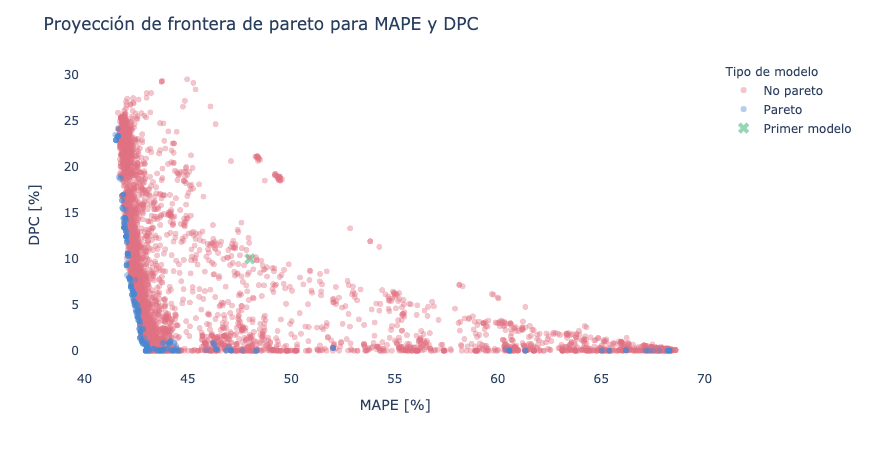

'https://plotly.com/~miloiturra/25/'

In [127]:
fig = px.scatter(
    trials, x='MAPE', y='DPC', 
    color='is_pareto', opacity=0.4, 
    color_discrete_sequence=color_cycle,
    labels={'is_pareto': 'Tipo de modelo'}
)

fig.update_layout(
    xaxis_title="MAPE [%]",
    yaxis_title="DPC [%]",
    title="Proyección de frontera de pareto para MAPE y DPC",
    paper_bgcolor='white',
    plot_bgcolor='white',
    hoverlabel_align='right',
    barmode='overlay',
)

fig.add_trace(go.Scatter(
    x=[48],
    y=[10],
    name="Primer modelo",
    mode='markers',
    marker_symbol="x",
    marker_size=10,
    marker_color=green
))

fig.show()
py.plot(fig, filename=f"pareto_mape_dpc", auto_open=True)

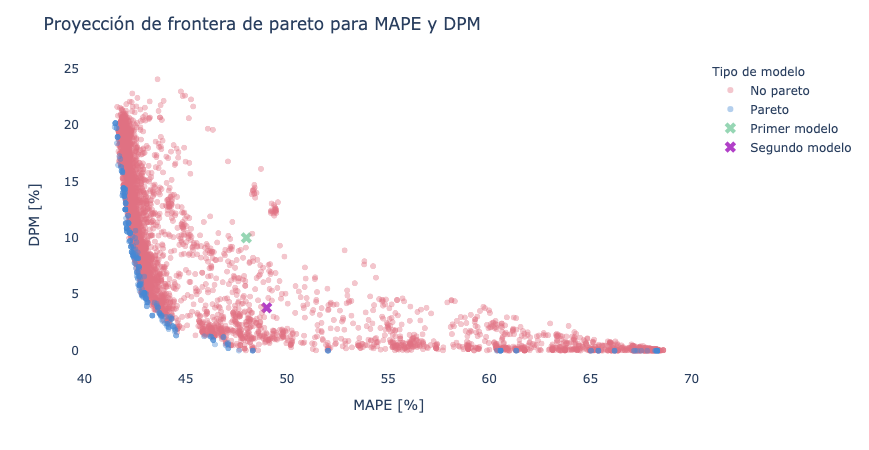

'https://plotly.com/~miloiturra/27/'

In [134]:
fig = px.scatter(
    trials, x='MAPE', y='DPM', 
    color='is_pareto', opacity=0.4, 
    color_discrete_sequence=color_cycle,
    labels={'is_pareto': 'Tipo de modelo'}
)

fig.update_layout(
    xaxis_title="MAPE [%]",
    yaxis_title="DPM [%]",
    title="Proyección de frontera de pareto para MAPE y DPM",
    paper_bgcolor='white',
    plot_bgcolor='white',
    hoverlabel_align='right',
    barmode='overlay',
)

fig.add_trace(go.Scatter(
    x=[48],
    y=[10],
    name="Primer modelo",
    mode='markers',
    marker_symbol="x",
    marker_size=10,
    marker_color=green
))

fig.add_trace(go.Scatter(
    x=[49],
    y=[3.8],
    name="Segundo modelo",
    mode='markers',
    marker_symbol="x",
    marker_size=10,
    marker_color=purple
))

fig.show()
py.plot(fig, filename=f"pareto_mape_dpm", auto_open=True)

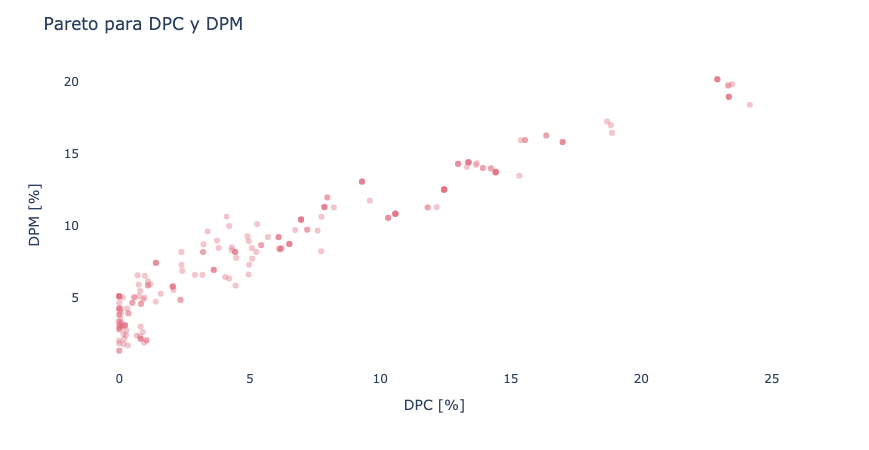

'https://plotly.com/~miloiturra/34/'

In [145]:
fig = px.scatter(
    trials.query("MAPE < 45 and is_pareto == 'Pareto'"), 
    x='DPC', y='DPM', 
    opacity=0.4, 
    color_discrete_sequence=color_cycle,
    hover_data=['number', 'MAPE']
)

fig.update_layout(
    xaxis_title="DPC [%]",
    yaxis_title="DPM [%]",
    title="Pareto para DPC y DPM",
    paper_bgcolor='white',
    plot_bgcolor='white',
    hoverlabel_align='right',
    barmode='overlay',
)


fig.show()
py.plot(fig, filename=f"pareto_dpc_dpm", auto_open=True)

In [146]:
modelo_ganador = 4978

In [154]:
def trial_params_to_model_params(trial_params):
    sexo_feature_contri = trial_params['sexo_feature_contri']
    feature_contri = np.ones(len(features))
    feature_contri[features.index('sexo')] = sexo_feature_contri
    
    model_params = {
        "objective": "regression",
        "metric": ["mape", "mae"],
        "verbosity": -1,
        "boosting_type": "gbdt",  
        "max_depth": -1,
        "min_data_in_leaf": 20,
        "learning_rate": trial_params['learning_rate'], 
        'lambda_l1': trial_params['lambda_l1'],
        'lambda_l2': trial_params['lambda_l2'],
        'num_leaves': trial_params['num_leaves'],
        'feature_fraction': trial_params['feature_fraction'],
        'bagging_fraction': trial_params['bagging_fraction'],
        'bagging_freq': trial_params['bagging_freq'],
        'min_child_samples': trial_params['min_child_samples'],
        'seed': 1312,
        'feature_contri': feature_contri,
        "deterministic": True,

    }
    
    return model_params

In [155]:
model_params = trial_params_to_model_params(study.trials[modelo_ganador].params)

regressor = lgbm.LGBMRegressor(**model_params)
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', regressor)])
pipeline.fit(X=df_train[features], 
             y=df_train[target+'_transf'],
             classifier__categorical_feature=[i for i in range(len(categorical_features))],
             classifier__feature_name=features,
)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=2.08247428088289e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.08247428088289e-06
[LightGBM] [Warning] bagging_fraction is set=0.8748686361431663, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8748686361431663
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.27963318232570883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27963318232570883
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.44228890484464467, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44228890484464467


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='N/A',
                                                                                 strategy='constant')),
                                                                  ('label',
                                                                   OrdinalEncoder(mapping=[{'col': 0,
                                                                                            'mapping': {'Hombre': 1,
                                                                                                        'Mujer': 2,
                                                                                                        'N/A': 0}},
                                                                                           {'col': 1,


In [156]:
datos['sueldo_predicho'] = inv_transf(pipeline.predict(datos[features]))
datos['error'] = datos.eval('sueldo_predicho - sueldo_neto')
datos['error_porcentual'] = datos.eval('error/sueldo_neto')
datos['error_porcentual_abs'] = datos.eval('abs(error_porcentual)')

In [157]:
datos.query('is_test == 1')['error_porcentual_abs'].mean()

0.44530043667912783

In [158]:
datos.query('is_test == 1')['error_porcentual_abs'].median()

0.25573569525436846